In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys
import matplotlib
import numpy
import os
if 'DISPLAY' not in os.environ:
    matplotlib.use('Agg')
    show_image=False
else:
    show_image=True
from matplotlib import pyplot as plt
from torchvision import utils

In [20]:
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = transforms.ToPILImage()(inp)
    plt.imshow(inp,cmap='gray')
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        plt.gcf().clear()

In [21]:
batch_size = 100
z_size=2
hidden_size=512
img_size=28
niter=100
epsilon=0.1
G_lr = D_lr = 5e-3
use_cuda=torch.cuda.is_available()

In [22]:
root = './data'
download = True
trans = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_set = dset.MNIST(
    root=root, train=True, transform=trans, download=download)
kwargs = {}
D_loader = torch.utils.data.DataLoader(
    dataset=data_set, batch_size=batch_size, shuffle=True)
G_loader = torch.utils.data.DataLoader(
    dataset=data_set, batch_size=batch_size, shuffle=True)

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, img_size**2),
#             nn.Tanh(),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(100,100)
        )

    def forward(self, x):
        x = x.view(x.size(0), img_size * img_size)
        return x

In [25]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
if use_cuda:
    one=one.cuda()
    noise_holder=noise_holder.cuda()
    input_holder=input_holder.cuda()
mone = one * -1

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [31]:
def sinkhorn_loss(x, y, epsilon, n, niter):
    """
	Given two emprical measures with n points each with locations x and y
	outputs an approximation of the OT cost with regularization parameter epsilon
	niter is the max. number of steps in sinkhorn loop
	"""
    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y)/n  # Wasserstein cost function

    # both marginals are fixed with equal weights
    if use_cuda:
        mu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    else:
        mu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
        nu = Variable(
            1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  #(.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) +
                         1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        #u = ave( u, lam * ( epsilon * ( torch.log(mu.unsqueeze(1)) - lse(M(u,v))   ) + u ) )
        #v = ave( v, lam * ( epsilon * ( torch.log(nu.unsqueeze(1)) - lse(M(u,v).t()) ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.cpu().numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost

    return cost


def cost_matrix(x, y, p=2):
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin))**p, 2)
    return c

  0%|          | 0/10000 [00:00<?, ?it/s]

Generator (
  (model): Sequential (
    (0): Linear (2 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 784)
  )
)
Variable containing:
1.00000e-03 *
 0.0386  0.0623  0.0294  ...   0.1378  0.1510  0.0837
 0.0838  0.1128  0.1841  ...   0.1283  0.0905  0.1222
 0.0884  0.0898  0.2074  ...   0.0990  0.0847  0.1272
          ...             ⋱             ...          
 0.1501  0.1579  0.0412  ...   0.0922  0.1358  0.0951
 0.0464  0.1221  0.1131  ...   0.1237  0.0934  0.1309
 0.0783  0.0453  0.1731  ...   0.0482  0.0628  0.0922
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3173e-03  6.6822e-10  9.6359e-10  ...   3.8258e-06  1.0478e-06  5.7859e-09
 5.3860e-10  8.2296e-04  5.0276e-04  ...   1.0715e-06  3.8641e-05  1.1192e-05
 7.6877e-10  4.9764e-04  8.6398e-04  ...   3.4865e-07  4.1027e-05  9.8260e-05
                ...                   ⋱                   ...                
 3.2855e-06  1.1416e-06  3.7529e-07  ...   8.5835e-04  4.6911e-05  2.2033e-08
 8.3695e-07  3.82

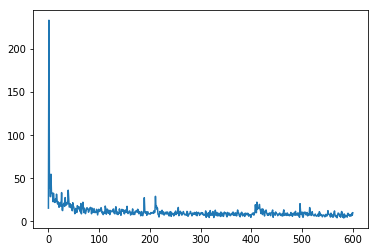

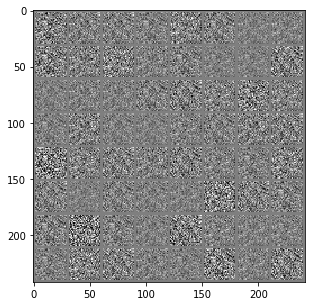

  0%|          | 1/10000 [00:02<6:43:43,  2.42s/it]

Variable containing:
1.00000e-03 *
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0557  0.0299  0.1061  ...   0.2023  0.0097  0.0027
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 8.3796  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  7.5435  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  9.5282  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   9.9990  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  9.7510  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  9.9990
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9990e-03  1.5805e-23  6.4912e-24  ...   4.6510e-17  6.8163e-20  3.7069e-22
 

  0%|          | 2/10000 [00:04<6:19:59,  2.28s/it]

Variable containing:
1.00000e-03 *
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0009  0.0000  0.0000
 0.1724  0.0000  0.7741  ...   0.0001  0.0052  0.0942
          ...             ⋱             ...          
 0.5700  0.0002  0.0416  ...   0.0254  0.0000  0.0825
 0.3670  0.0376  0.0216  ...   0.1682  0.0019  0.5022
 0.0373  0.0023  0.1265  ...   0.0010  0.1842  0.1444
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 9.9990  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  9.6781  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  5.4431  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   6.5345  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  2.5185  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  3.2924
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9990e-03  5.5405e-32  1.5373e-25  ...   6.8941e-22  3.6283e-26  8.5531e-24
 

  0%|          | 3/10000 [00:06<6:22:53,  2.30s/it]

Variable containing:
1.00000e-03 *
 0.0000  0.0000  0.0000  ...   1.4769  0.0000  0.0000
 0.0000  0.0360  0.0001  ...   0.0000  1.5164  0.0001
 0.0231  0.0000  0.6721  ...   0.0050  0.0027  0.0043
          ...             ⋱             ...          
 0.7622  0.0000  0.1682  ...   0.0002  0.0000  0.0817
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.1897
 0.0001  0.0000  0.0055  ...   1.2630  0.0012  0.0000
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 9.9990  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  9.3781  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  3.6707  ...   0.0006  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0007  ...   2.2346  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  5.7057  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  7.5639
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9990e-03  4.4124e-27  8.3419e-23  ...   3.9275e-31  7.2750e-23  6.0120e-27
 

  0%|          | 4/10000 [00:08<6:03:53,  2.18s/it]


Variable containing:
 2.4389e-05  3.6853e-05  2.1311e-04  ...   6.7410e-06  7.6729e-08  1.2878e-06
 1.5044e-04  8.4238e-05  2.1694e-04  ...   6.5713e-04  4.6895e-07  6.9847e-07
 1.2417e-05  1.4731e-05  1.4943e-05  ...   5.2433e-05  6.6349e-06  7.6187e-06
                ...                   ⋱                   ...                
 1.0546e-04  2.2409e-04  2.0958e-09  ...   5.8305e-08  1.8136e-09  3.6959e-07
 8.6582e-05  6.9919e-05  3.4348e-04  ...   9.8488e-05  2.4644e-07  1.6962e-06
 6.1378e-05  6.4509e-05  3.3533e-04  ...   2.5922e-05  1.1048e-07  1.8073e-06
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 1.1806  0.0001  0.0001  ...   0.0000  0.2152  0.6087
 0.0002  2.2298  0.0073  ...   0.0000  0.0195  0.0006
 0.0001  0.0083  4.2776  ...   0.0000  0.0003  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   9.9583  0.0000  0.0000
 0.2168  0.0158  0.0002  ...   0.0000  1.1458  0.6219
 0.6057  0.0005  0.0000  ...   0.000

  0%|          | 5/10000 [00:10<5:52:08,  2.11s/it]

Variable containing:
 2.7589e-04  2.2779e-08  1.3389e-08  ...   3.0331e-06  4.6034e-05  2.2595e-06
 1.6410e-04  1.7075e-07  4.0550e-07  ...   6.0862e-05  1.2663e-04  2.5129e-04
 8.3301e-05  3.4982e-06  8.2852e-06  ...   1.5132e-05  2.0215e-04  8.2104e-05
                ...                   ⋱                   ...                
 1.4956e-05  1.3605e-07  2.6815e-07  ...   1.1437e-04  1.2278e-04  5.1802e-04
 2.8439e-05  6.7884e-09  6.8702e-09  ...   1.2974e-04  5.6934e-05  2.6005e-04
 8.0763e-05  1.0375e-05  2.2424e-05  ...   2.5211e-06  1.5115e-04  2.3777e-05
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 3.0339  0.0451  0.0742  ...   0.0015  0.0004  0.1142
 0.0429  0.6923  0.2141  ...   0.2406  0.0242  0.0416
 0.0716  0.2170  0.8184  ...   0.0238  0.0006  0.5235
          ...             ⋱             ...          
 0.0014  0.2407  0.0235  ...   0.7136  0.1487  0.0021
 0.0004  0.0251  0.0007  ...   0.1540  1.1215  0.0001
 0.1129  0.0432  0.5360  ...   0.0022

  0%|          | 6/10000 [00:12<5:37:02,  2.02s/it]

Variable containing:
1.00000e-03 *
 0.0084  0.0390  0.0004  ...   0.0956  0.0013  0.3808
 0.0002  0.0001  0.0000  ...   0.0019  0.0001  0.7606
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0115
          ...             ⋱             ...          
 0.0079  0.0005  0.0562  ...   0.0001  0.2750  0.0001
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.2525  0.0019  0.1106  ...   0.0343  0.4293  0.0033
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 1.9627  0.0000  0.0000  ...   0.0000  0.0000  0.0001
 0.0000  7.7375  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  9.8119  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   2.5157  0.0000  0.0714
 0.0000  0.0000  0.0000  ...   0.0000  9.9939  0.0000
 0.0002  0.0000  0.0000  ...   0.0500  0.0000  4.4157
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9990e-03  5.1286e-25  1.4659e-19  ...   1.9065e-17  1.9081e-20  9.2768e-22
 

  0%|          | 7/10000 [00:13<5:31:53,  1.99s/it]

Variable containing:
 4.4755e-05  3.0080e-04  6.2185e-06  ...   2.2112e-05  5.6221e-04  6.5735e-09
 2.5482e-08  6.7740e-07  2.6739e-05  ...   1.2849e-05  1.1858e-07  1.5072e-04
 4.0271e-07  1.2171e-04  2.9087e-04  ...   1.5444e-04  6.1272e-05  4.9464e-05
                ...                   ⋱                   ...                
 5.7656e-05  1.2514e-04  1.9171e-07  ...   3.7166e-05  4.9314e-04  1.9680e-10
 6.6350e-08  3.4344e-05  9.6753e-07  ...   1.9126e-04  4.4471e-06  9.2354e-06
 3.5838e-08  1.4306e-07  4.6699e-05  ...   3.7436e-06  5.2380e-08  7.3467e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.8566e-03  1.3956e-08  5.2027e-07  ...   2.3792e-06  3.6046e-09  6.6682e-09
 9.5211e-09  1.8119e-03  3.1323e-09  ...   1.2412e-08  2.4384e-05  1.0097e-03
 2.9428e-07  2.5970e-09  1.2570e-03  ...   1.3401e-12  4.5138e-09  5.3456e-11
                ...                   ⋱                   ...                
 3.0606e-06  2.3404e-08  3.0477e-12  ...   4.2615e-03  5.1655e-

  0%|          | 8/10000 [00:15<5:28:21,  1.97s/it]

Variable containing:
 2.7681e-06  5.0856e-06  7.7466e-04  ...   5.3485e-05  8.2263e-07  1.8886e-05
 1.7938e-04  2.0978e-05  3.1997e-05  ...   4.1311e-07  1.9322e-08  9.6913e-06
 6.8951e-06  3.0898e-06  3.2916e-04  ...   7.0165e-08  9.3765e-10  3.3866e-07
                ...                   ⋱                   ...                
 4.6021e-21  9.7196e-16  7.6147e-19  ...   8.2770e-36  1.2638e-41  1.1371e-16
 1.7893e-11  6.5578e-11  1.0899e-09  ...   3.0699e-19  8.2938e-23  4.3021e-12
 6.4582e-06  3.3814e-06  4.3740e-04  ...   1.5548e-07  1.9440e-09  4.9067e-07
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 1.3137  0.0219  0.0246  ...   0.0000  0.0000  0.0514
 0.0220  1.0593  0.0490  ...   0.0000  0.0000  0.0513
 0.0317  0.0629  1.9733  ...   0.0000  0.0000  1.7043
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   9.9990  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  9.9049  0.0000
 0.0655  0.0649  1.6824  ...   0.0000

  0%|          | 9/10000 [00:17<5:21:31,  1.93s/it]


Variable containing:
 3.0122e-06  1.5919e-04  2.6939e-09  ...   6.8498e-08  7.5105e-05  1.4347e-09
 7.0065e-04  2.2625e-06  2.8975e-05  ...   9.9306e-05  2.4331e-07  2.1296e-13
 3.4286e-05  1.7906e-04  1.1977e-08  ...   1.0058e-07  3.6700e-05  7.4013e-12
                ...                   ⋱                   ...                
 7.1056e-06  2.4575e-10  4.6065e-04  ...   1.5568e-04  3.6911e-10  3.2553e-18
 1.4013e-14  8.3508e-08  8.8925e-16  ...   7.0171e-13  1.4229e-06  3.8902e-04
 2.5273e-15  1.8959e-04  2.7171e-16  ...   2.7314e-12  2.7571e-04  2.9894e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0301e-03  8.3140e-06  1.6394e-04  ...   6.2099e-10  2.1121e-10  1.5197e-20
 7.9359e-06  1.2080e-03  1.5530e-05  ...   3.4744e-06  9.7613e-14  2.1468e-21
 1.5908e-04  1.5787e-05  6.0654e-04  ...   2.2299e-10  1.0989e-13  1.0200e-21
                ...                   ⋱                   ...                
 1.6190e-09  9.4897e-06  5.9914e-10  ...   9.0573e-03  8.2660e

  0%|          | 10/10000 [00:19<5:20:08,  1.92s/it]

Variable containing:
 3.3196e-04  8.8857e-05  9.0045e-05  ...   1.0535e-05  5.4725e-06  1.7791e-05
 5.6700e-06  7.4018e-07  2.8117e-05  ...   1.4256e-10  4.7320e-04  2.1329e-04
 1.1525e-04  3.3603e-04  6.8743e-05  ...   1.8051e-04  2.5125e-06  1.8326e-05
                ...                   ⋱                   ...                
 3.6565e-04  2.8625e-04  2.5869e-04  ...   4.5016e-05  2.2174e-05  6.0543e-05
 2.8468e-05  9.7311e-05  4.5384e-05  ...   1.1482e-04  2.3221e-06  1.9899e-05
 4.0998e-05  1.7596e-04  1.3705e-05  ...   3.9612e-04  3.2137e-07  1.3435e-05
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 1.1784  0.0000  0.0400  ...   0.4242  0.0014  0.0051
 0.0000  3.9733  0.0000  ...   0.0000  0.0000  0.0000
 0.0372  0.0000  0.4381  ...   0.1637  0.0657  0.2445
          ...             ⋱             ...          
 0.4100  0.0000  0.1699  ...   0.9330  0.0119  0.0210
 0.0014  0.0000  0.0668  ...   0.0117  0.7571  0.1136
 0.0047  0.0000  0.2428  ...   0.0201

  0%|          | 11/10000 [00:20<5:15:02,  1.89s/it]

Variable containing:
 6.3766e-04  8.5329e-05  5.4713e-04  ...   2.1824e-05  9.2192e-06  2.5628e-08
 5.9083e-05  6.3044e-05  2.5706e-06  ...   3.6538e-07  1.1811e-05  1.3079e-05
 4.5205e-06  2.4005e-05  7.6982e-08  ...   2.8890e-05  2.9212e-04  6.7889e-04
                ...                   ⋱                   ...                
 2.6264e-05  5.5422e-06  1.4105e-04  ...   1.8235e-05  5.9201e-07  7.2414e-10
 6.3578e-06  3.4268e-05  1.5367e-06  ...   9.9114e-05  4.1817e-05  1.9409e-04
 3.3412e-04  6.2404e-04  1.3334e-03  ...   1.4936e-05  2.5930e-06  5.6190e-07
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 7.5231  0.0000  0.0000  ...   0.0001  0.0000  0.3070
 0.0000  0.4807  0.0177  ...   0.0000  0.0093  0.0000
 0.0000  0.0171  0.7289  ...   0.0000  0.2104  0.0000
          ...             ⋱             ...          
 0.0007  0.0000  0.0000  ...   9.6083  0.0000  0.0001
 0.0000  0.0092  0.2150  ...   0.0000  0.8715  0.0004
 0.2316  0.0000  0.0000  ...   0.0000

  0%|          | 12/10000 [00:22<5:15:39,  1.90s/it]

Variable containing:
 5.5892e-05  1.0794e-05  7.2693e-15  ...   4.0508e-08  8.7997e-07  1.6680e-03
 2.3563e-04  4.3255e-05  4.0122e-13  ...   4.2730e-07  8.5434e-06  9.0808e-04
 7.2573e-06  4.2760e-06  4.4498e-06  ...   1.0565e-04  1.9874e-05  5.3063e-07
                ...                   ⋱                   ...                
 1.3373e-04  7.5597e-06  7.4423e-11  ...   2.8854e-06  1.6711e-05  5.5642e-04
 2.0404e-07  1.0510e-06  1.3539e-04  ...   1.0744e-04  5.0531e-07  2.7254e-10
 2.8166e-06  1.7382e-04  7.0197e-13  ...   1.2218e-05  1.1212e-04  8.2842e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 3.7100e-03  1.2532e-03  8.5195e-09  ...   8.7752e-05  5.2577e-10  1.5686e-08
 1.2526e-03  1.2169e-03  9.1720e-08  ...   1.5136e-04  8.8518e-09  8.3324e-08
 8.3110e-09  8.9516e-08  7.2079e-04  ...   1.6008e-05  1.4037e-04  2.6294e-08
                ...                   ⋱                   ...                
 8.4652e-05  1.4608e-04  1.5830e-05  ...   8.4916e-04  4.7968e-

  0%|          | 13/10000 [00:25<5:22:04,  1.93s/it]

Variable containing:
 3.1715e-04  2.2256e-04  1.4087e-05  ...   4.9322e-05  1.1422e-05  3.9822e-04
 6.0658e-05  5.8305e-06  8.7809e-08  ...   7.0642e-09  1.3239e-06  8.3585e-08
 2.3094e-06  6.8043e-08  5.8980e-13  ...   1.0395e-14  5.3065e-12  8.3790e-11
                ...                   ⋱                   ...                
 5.7069e-06  1.1335e-07  2.5938e-14  ...   6.9503e-13  1.4247e-11  2.0872e-09
 9.5064e-06  4.5770e-06  2.1563e-05  ...   1.0456e-05  2.6376e-04  3.2335e-07
 5.1232e-06  7.0634e-07  4.6746e-07  ...   1.2113e-07  4.5121e-05  1.1766e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2265e-03  1.2566e-06  9.0451e-09  ...   7.8242e-14  3.5712e-07  2.0299e-07
 1.3980e-06  1.0629e-03  7.2427e-07  ...   6.7646e-22  3.3919e-05  1.3219e-04
 1.7459e-08  1.2565e-06  2.3783e-03  ...   5.8449e-16  6.7671e-11  4.7568e-10
                ...                   ⋱                   ...                
 8.7216e-13  6.7776e-21  3.3755e-15  ...   9.9990e-03  5.9279e-

  0%|          | 14/10000 [00:26<5:17:42,  1.91s/it]

Variable containing:
 4.7630e-05  1.7249e-05  7.8025e-10  ...   2.1592e-04  4.7465e-05  3.2150e-04
 4.8848e-04  8.9506e-07  2.0818e-11  ...   1.9108e-05  2.7700e-04  2.2626e-04
 1.6628e-05  1.4940e-04  2.4136e-10  ...   1.1244e-04  4.4203e-05  5.7655e-06
                ...                   ⋱                   ...                
 2.9303e-05  7.5931e-06  2.0148e-09  ...   1.7952e-04  2.0509e-05  5.2522e-04
 7.6045e-08  2.0322e-04  5.8794e-08  ...   4.8861e-05  5.4316e-07  1.0212e-07
 3.7942e-09  9.8102e-13  2.4319e-22  ...   3.6462e-13  1.5106e-07  7.0000e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 6.4953e-04  1.8022e-04  6.9404e-05  ...   6.0498e-04  4.7570e-06  2.0464e-15
 1.8514e-04  9.8541e-04  4.2024e-05  ...   1.7994e-04  8.4192e-07  1.0476e-12
 7.0488e-05  4.1548e-05  6.1659e-04  ...   4.3286e-05  3.7497e-05  2.9467e-12
                ...                   ⋱                   ...                
 6.0725e-04  1.7582e-04  4.2781e-05  ...   8.0358e-04  4.6844e-

  0%|          | 15/10000 [00:28<5:16:14,  1.90s/it]

Variable containing:
 2.4749e-07  5.7706e-05  3.1120e-06  ...   7.4070e-07  7.4248e-07  3.4801e-04
 4.4232e-08  1.0431e-04  2.4703e-05  ...   3.2642e-05  1.3582e-06  1.0491e-04
 4.6446e-09  8.3982e-05  7.1775e-05  ...   2.3752e-04  7.5328e-07  3.4158e-05
                ...                   ⋱                   ...                
 5.9677e-09  9.0994e-05  7.6511e-05  ...   2.3749e-04  9.3131e-07  3.6731e-05
 9.7509e-04  9.2087e-05  2.4270e-06  ...   4.2239e-07  3.9773e-05  6.3230e-07
 2.0077e-09  5.3599e-05  7.6314e-05  ...   2.4273e-04  8.1635e-07  1.3436e-05
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 0.6386  0.1696  0.0280  ...   0.0315  0.0065  0.0099
 0.1672  0.4352  0.2162  ...   0.2349  0.0008  0.0943
 0.0277  0.2166  0.6287  ...   0.6094  0.0003  0.6089
          ...             ⋱             ...          
 0.0312  0.2353  0.6095  ...   0.5973  0.0003  0.5615
 0.0076  0.0010  0.0003  ...   0.0004  1.7678  0.0003
 0.0099  0.0951  0.6133  ...   0.5655

  0%|          | 16/10000 [00:30<5:13:30,  1.88s/it]

Variable containing:
 1.0372e-04  5.8162e-07  3.6630e-05  ...   3.3430e-06  1.8189e-11  1.0013e-06
 1.0627e-04  1.2478e-06  2.2849e-05  ...   8.5679e-04  1.6562e-05  7.4692e-05
 5.2340e-05  2.0015e-07  1.0708e-04  ...   9.9015e-06  1.4355e-09  1.9395e-07
                ...                   ⋱                   ...                
 6.0361e-08  3.4619e-09  1.3601e-04  ...   6.6112e-07  6.2425e-08  1.4923e-09
 3.4214e-05  5.7790e-06  1.5883e-04  ...   5.2356e-06  1.2911e-10  1.3030e-05
 3.5164e-05  5.5555e-05  3.8955e-04  ...   7.4718e-05  1.5075e-08  2.0239e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0665e-03  1.5593e-06  9.5001e-05  ...   1.4543e-09  4.0886e-04  4.5969e-05
 1.6468e-06  1.0363e-03  1.8171e-05  ...   1.1562e-06  2.5166e-06  3.6016e-05
 9.8626e-05  1.7862e-05  1.6013e-03  ...   8.4301e-06  1.9157e-05  1.0185e-05
                ...                   ⋱                   ...                
 1.9827e-09  1.4924e-06  1.1071e-05  ...   5.4997e-03  6.1521e-

  0%|          | 17/10000 [00:32<5:13:42,  1.89s/it]

Variable containing:
 6.6222e-05  6.3817e-08  2.4887e-04  ...   1.4847e-04  1.9307e-05  1.9025e-04
 1.4031e-05  3.0995e-07  4.8111e-04  ...   2.0135e-04  1.6666e-04  2.1178e-05
 8.8579e-07  6.5154e-05  1.9151e-05  ...   9.6765e-05  2.6832e-04  6.6456e-06
                ...                   ⋱                   ...                
 3.0659e-10  2.3958e-04  1.8824e-08  ...   9.7657e-07  3.6996e-09  2.3368e-08
 4.7694e-08  7.7609e-05  3.3062e-06  ...   5.0109e-05  7.9226e-05  2.2048e-07
 5.4586e-13  5.6598e-11  5.2669e-15  ...   5.7077e-17  1.5430e-16  2.1327e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 5.0375e-04  2.3942e-04  2.1989e-05  ...   2.4781e-08  5.9019e-06  6.4738e-16
 2.4068e-04  3.8999e-04  9.0750e-05  ...   1.3283e-07  4.3536e-05  6.3377e-16
 2.2489e-05  9.2326e-05  4.8757e-04  ...   2.3095e-06  3.9004e-04  4.5839e-15
                ...                   ⋱                   ...                
 3.7384e-08  1.9933e-07  3.4067e-06  ...   3.1264e-03  1.9404e-

  0%|          | 18/10000 [00:33<5:12:44,  1.88s/it]

Variable containing:
 2.0622e-05  8.0373e-06  7.2836e-05  ...   8.2754e-06  5.1746e-06  1.3196e-09
 1.2486e-14  1.0152e-10  3.0060e-14  ...   1.5245e-16  9.5983e-07  6.1952e-06
 1.6200e-07  3.0702e-07  3.9040e-06  ...   2.5928e-04  3.9145e-06  3.7557e-10
                ...                   ⋱                   ...                
 2.5250e-15  2.4395e-10  1.1821e-14  ...   1.3229e-20  4.6865e-07  1.8366e-04
 2.3562e-05  1.0183e-05  7.5831e-05  ...   7.9270e-06  6.0931e-06  1.6990e-09
 1.7459e-08  5.1370e-10  1.1869e-05  ...   1.5855e-06  5.5848e-09  1.1527e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 5.9174e-04  1.0395e-17  2.9432e-04  ...   1.4596e-22  5.8362e-04  3.5156e-05
 3.1637e-17  2.9600e-03  8.5715e-17  ...   5.4800e-05  4.4141e-17  2.5219e-22
 2.9777e-04  2.8495e-17  9.7017e-04  ...   1.6994e-22  2.8277e-04  5.8297e-05
                ...                   ⋱                   ...                
 4.4771e-22  5.5233e-05  5.1525e-22  ...   4.8158e-03  6.6729e-

  0%|          | 19/10000 [00:35<5:11:15,  1.87s/it]

Variable containing:
 2.5296e-08  2.6637e-04  7.5489e-05  ...   6.9282e-10  8.1371e-05  1.4654e-04
 6.1685e-07  5.3765e-07  1.0643e-06  ...   4.2060e-06  2.0598e-07  5.8888e-06
 3.4894e-06  4.0871e-09  1.8244e-07  ...   3.1186e-04  2.1600e-08  6.8837e-08
                ...                   ⋱                   ...                
 3.3911e-09  2.9467e-08  5.7541e-08  ...   1.6321e-07  9.3516e-09  4.1096e-05
 5.4374e-09  4.1838e-08  7.7172e-08  ...   2.1346e-07  1.2990e-08  4.0014e-05
 6.1437e-05  3.3147e-06  3.3853e-05  ...   7.8545e-07  9.9128e-06  3.9661e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 6.9033e-04  1.9335e-05  8.1251e-07  ...   6.5222e-06  7.7867e-06  1.6478e-05
 1.9206e-05  6.2299e-04  2.4996e-04  ...   2.8392e-04  3.1706e-04  5.6620e-05
 8.2090e-07  2.5423e-04  1.0997e-03  ...   5.8207e-05  6.5813e-05  5.3894e-05
                ...                   ⋱                   ...                
 6.5641e-06  2.8766e-04  5.7982e-05  ...   1.7281e-03  1.5899e-

  0%|          | 20/10000 [00:37<5:13:58,  1.89s/it]

Variable containing:
 3.3301e-04  3.3522e-05  2.4246e-05  ...   1.4758e-04  4.4741e-04  3.3838e-07
 7.1211e-04  5.8461e-06  4.8356e-05  ...   4.5762e-04  5.3294e-04  1.6397e-08
 7.9299e-04  8.8333e-06  1.2643e-04  ...   7.5524e-04  4.3541e-04  1.2700e-08
                ...                   ⋱                   ...                
 7.0405e-08  1.0588e-04  5.8105e-11  ...   3.0017e-10  1.6496e-07  3.3063e-04
 2.0992e-05  1.7501e-04  8.5281e-06  ...   7.6585e-06  6.0034e-05  1.0079e-06
 7.8601e-04  7.0637e-06  7.8767e-05  ...   6.1671e-04  4.9162e-04  1.4318e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 5.3630e-04  3.6123e-04  3.8017e-04  ...   4.3439e-06  1.8153e-04  3.8840e-04
 3.6429e-04  9.1434e-04  6.0622e-04  ...   6.3793e-07  3.3325e-05  7.9555e-04
 3.7647e-04  5.9527e-04  6.4903e-04  ...   3.3945e-07  7.5409e-05  6.5761e-04
                ...                   ⋱                   ...                
 5.2244e-06  7.6077e-07  4.1226e-07  ...   1.1275e-03  7.4183e-

  0%|          | 21/10000 [00:40<5:19:13,  1.92s/it]

Variable containing:
 1.3955e-07  6.0540e-05  1.5060e-05  ...   2.7229e-04  1.9604e-04  2.5083e-06
 1.2149e-05  2.0409e-04  1.0355e-06  ...   4.6215e-05  1.4635e-05  1.7005e-08
 1.6661e-04  5.5437e-06  1.1743e-08  ...   1.8415e-06  1.3219e-07  3.2327e-09
                ...                   ⋱                   ...                
 8.1810e-06  1.8870e-05  1.6805e-07  ...   2.4394e-06  1.8410e-06  1.4871e-07
 2.6770e-10  1.1580e-09  9.3422e-05  ...   1.2684e-06  7.3313e-06  8.8913e-04
 2.6353e-08  1.5628e-05  7.9203e-07  ...   1.0978e-04  2.2165e-04  2.5145e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 5.2790e-04  2.1485e-04  2.8527e-07  ...   4.6140e-07  1.5880e-09  3.8436e-04
 2.1799e-04  1.9433e-03  5.4393e-06  ...   1.7490e-06  1.5214e-11  2.2137e-04
 3.2742e-07  6.1530e-06  3.0911e-03  ...   1.0825e-03  2.4743e-11  7.0350e-08
                ...                   ⋱                   ...                
 5.2836e-07  1.9740e-06  1.0801e-03  ...   1.7943e-03  4.0782e-

  0%|          | 22/10000 [00:42<5:21:56,  1.94s/it]

Variable containing:
 6.2301e-07  6.9536e-07  2.5117e-15  ...   7.2024e-09  3.7426e-11  4.0627e-08
 5.1813e-06  1.0246e-04  1.2720e-08  ...   4.9277e-05  1.4164e-07  3.2309e-05
 8.5934e-05  4.7335e-04  5.3560e-11  ...   8.4102e-06  2.0190e-07  1.0671e-05
                ...                   ⋱                   ...                
 2.2651e-06  4.2579e-05  5.4461e-10  ...   7.2756e-06  1.7430e-08  1.6471e-05
 9.8535e-05  6.0778e-04  6.2809e-09  ...   1.3514e-04  3.5017e-06  3.3550e-05
 2.3069e-06  5.1311e-05  3.7341e-10  ...   6.6516e-06  1.6950e-08  1.1527e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1620e-03  7.1729e-07  2.3812e-05  ...   4.6426e-06  5.7238e-07  6.6565e-06
 7.2689e-07  8.5887e-04  1.0122e-04  ...   4.9926e-04  2.8346e-04  4.8518e-04
 2.2827e-05  9.5755e-05  5.8956e-04  ...   9.5915e-05  1.4638e-04  1.1886e-04
                ...                   ⋱                   ...                
 4.6392e-06  4.9231e-04  9.9981e-05  ...   1.0556e-03  6.9255e-

  0%|          | 23/10000 [00:45<5:28:29,  1.98s/it]

Variable containing:
 3.7200e-07  8.8095e-05  3.5800e-09  ...   4.5024e-04  5.0295e-13  7.0443e-05
 6.0193e-11  1.0548e-10  5.2685e-07  ...   3.9148e-14  3.8073e-16  2.6500e-09
 1.3149e-07  9.8319e-07  7.1042e-06  ...   1.5228e-05  9.7209e-18  2.4228e-05
                ...                   ⋱                   ...                
 4.2383e-05  5.7066e-07  2.3250e-11  ...   4.7544e-08  8.5078e-05  3.4701e-09
 4.7119e-09  8.1097e-10  3.6006e-05  ...   2.0879e-12  1.4895e-16  1.0232e-07
 7.8658e-05  1.0056e-04  4.3893e-06  ...   4.5493e-06  2.9788e-13  2.6766e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 3.9404e-03  2.7500e-20  3.3338e-06  ...   2.6545e-08  7.3627e-11  1.0192e-05
 1.1912e-19  9.4272e-03  9.4056e-18  ...   3.8086e-18  9.0215e-07  1.0703e-15
 3.1599e-06  2.0581e-18  1.0092e-03  ...   1.5560e-11  3.7905e-09  1.2375e-05
                ...                   ⋱                   ...                
 3.0560e-08  1.0122e-18  1.8899e-11  ...   2.7497e-03  2.6933e-

  0%|          | 24/10000 [00:47<5:32:31,  2.00s/it]

Variable containing:
 1.4757e-09  8.1676e-06  6.7298e-05  ...   6.9240e-06  3.4478e-06  2.3536e-05
 2.1787e-11  1.7461e-08  4.1810e-07  ...   1.3649e-06  1.1514e-08  3.4801e-09
 5.9258e-04  3.2991e-09  1.0378e-11  ...   4.1590e-06  2.0374e-07  5.8961e-11
                ...                   ⋱                   ...                
 2.0098e-05  3.9432e-06  5.4823e-07  ...   2.1478e-04  1.0905e-04  2.3014e-07
 3.4541e-08  1.7052e-06  5.5416e-06  ...   6.5891e-05  1.2484e-05  2.4281e-07
 3.3704e-04  3.0952e-07  5.1482e-09  ...   5.9610e-05  2.4312e-05  1.1652e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0097e-03  6.4028e-05  1.1960e-14  ...   4.6537e-08  6.7942e-06  6.4436e-11
 6.3601e-05  1.0718e-03  3.3782e-15  ...   8.1938e-08  4.8583e-05  4.3239e-11
 1.9437e-14  5.5267e-15  4.6177e-03  ...   1.0244e-06  2.7676e-11  3.9267e-04
                ...                   ⋱                   ...                
 5.2964e-08  9.3880e-08  7.1741e-07  ...   1.3428e-03  4.6926e-

  0%|          | 25/10000 [00:50<5:32:45,  2.00s/it]

Variable containing:
 5.4596e-09  1.6288e-03  4.9055e-08  ...   4.2268e-06  3.1914e-06  8.3842e-06
 2.7200e-05  2.2805e-06  4.8166e-04  ...   7.0814e-07  4.8875e-04  1.6388e-07
 3.5703e-03  1.2518e-06  1.0001e-06  ...   2.1286e-10  3.7030e-04  3.4988e-10
                ...                   ⋱                   ...                
 2.6261e-10  9.3222e-05  4.7535e-06  ...   3.4434e-05  4.5650e-07  5.1872e-07
 9.5278e-07  7.1076e-05  3.0490e-05  ...   5.8561e-04  7.4217e-05  2.5300e-04
 1.9100e-11  9.0869e-05  1.2641e-08  ...   4.4044e-09  1.1261e-09  1.0603e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4679e-03  1.2391e-06  3.5279e-08  ...   2.9549e-05  1.1038e-04  1.1876e-05
 1.2980e-06  7.9753e-04  2.1946e-05  ...   2.2257e-06  1.6802e-05  1.6622e-07
 6.0707e-08  3.6050e-05  5.7297e-03  ...   3.7638e-08  6.2819e-07  5.9270e-09
                ...                   ⋱                   ...                
 3.1807e-05  2.2871e-06  2.3545e-08  ...   9.2200e-04  7.5833e-

  0%|          | 26/10000 [00:52<5:32:45,  2.00s/it]

Variable containing:
 1.0618e-03  1.6058e-14  4.2126e-07  ...   1.4387e-05  6.7035e-05  1.6325e-10
 5.2145e-07  1.2266e-09  1.0228e-05  ...   3.3993e-04  5.4912e-06  5.9211e-06
 6.9641e-10  1.3166e-07  2.9126e-05  ...   1.6600e-04  1.0101e-06  3.3031e-05
                ...                   ⋱                   ...                
 4.1985e-14  1.2791e-03  3.1380e-12  ...   2.6189e-06  1.8168e-11  8.5947e-05
 3.1558e-09  1.0282e-06  6.2481e-06  ...   8.8722e-05  2.9206e-07  6.9462e-05
 1.0043e-11  6.7154e-18  9.8966e-09  ...   2.3501e-07  5.5829e-04  4.6319e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7947e-03  1.5288e-06  2.9341e-11  ...   6.9435e-13  1.4913e-10  4.3447e-10
 1.2272e-06  1.0528e-03  6.8748e-06  ...   7.7098e-07  5.1953e-05  6.9134e-11
 2.2765e-11  6.6447e-06  9.8144e-04  ...   1.7353e-06  2.1320e-04  1.7210e-11
                ...                   ⋱                   ...                
 5.2055e-13  7.2002e-07  1.6767e-06  ...   4.6826e-03  1.2064e-

  0%|          | 27/10000 [00:54<5:35:33,  2.02s/it]

Variable containing:
 1.9795e-04  1.7712e-05  4.8950e-06  ...   1.5556e-08  3.7626e-07  6.4095e-05
 1.8446e-06  7.8746e-05  1.5670e-07  ...   4.9702e-11  1.6751e-06  6.0491e-07
 2.5800e-06  1.3768e-04  1.5261e-07  ...   4.4800e-10  2.9698e-06  7.0301e-07
                ...                   ⋱                   ...                
 2.0287e-07  7.2692e-05  4.0840e-08  ...   2.3069e-10  2.0455e-05  1.3098e-07
 2.6255e-04  5.9553e-05  3.5987e-05  ...   1.0905e-06  8.3704e-06  7.4926e-05
 4.8696e-05  2.0803e-04  1.1349e-05  ...   1.1164e-07  1.0544e-05  8.9698e-06
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 1.0552  0.0150  0.0179  ...   0.0001  0.2876  0.0910
 0.0181  1.4128  0.8867  ...   0.3204  0.0065  0.0666
 0.0213  0.8751  1.2518  ...   0.2156  0.0166  0.2092
          ...             ⋱             ...          
 0.0001  0.3431  0.2339  ...   1.8679  0.0001  0.0038
 0.2876  0.0054  0.0139  ...   0.0000  0.5312  0.2170
 0.0958  0.0582  0.1851  ...   0.0031

  0%|          | 28/10000 [00:56<5:34:20,  2.01s/it]

Variable containing:
 6.7826e-07  4.5163e-05  1.0681e-05  ...   3.0270e-04  2.5569e-11  1.1487e-05
 2.0474e-11  6.8657e-13  2.8340e-08  ...   1.0724e-11  7.5892e-20  1.0966e-13
 4.4887e-05  4.3353e-04  2.5254e-04  ...   3.1751e-05  7.5101e-11  5.9344e-05
                ...                   ⋱                   ...                
 6.8619e-06  1.6882e-04  2.5832e-04  ...   1.4732e-05  1.0966e-12  2.3648e-06
 2.8276e-15  9.4484e-18  2.2167e-12  ...   3.0672e-15  2.3781e-25  5.5679e-19
 1.3325e-08  1.2458e-07  8.4713e-07  ...   4.3015e-06  5.9216e-14  7.4976e-08
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 0.5325  0.0001  0.1765  ...   0.1253  0.0000  0.1086
 0.0001  3.2182  0.0000  ...   0.0002  0.0007  0.0237
 0.1774  0.0000  0.5452  ...   0.1300  0.0000  0.0063
          ...             ⋱             ...          
 0.1235  0.0001  0.1275  ...   0.4910  0.0000  0.0311
 0.0000  0.0030  0.0000  ...   0.0000  9.9257  0.0000
 0.1108  0.0174  0.0064  ...   0.0322

  0%|          | 29/10000 [00:58<5:32:43,  2.00s/it]

Variable containing:
 8.5267e-05  4.7751e-05  3.8553e-07  ...   3.1119e-05  5.7101e-06  5.7254e-06
 1.5455e-09  4.2074e-09  5.0204e-06  ...   1.0163e-07  5.0910e-06  2.3160e-03
 1.1940e-08  3.5510e-05  3.3618e-09  ...   2.1959e-07  5.5252e-07  6.5561e-07
                ...                   ⋱                   ...                
 2.3155e-04  1.1579e-04  9.1205e-05  ...   1.0255e-05  6.9288e-06  7.7737e-05
 1.8999e-04  2.1428e-04  8.3416e-05  ...   1.8958e-04  4.0931e-06  2.5421e-05
 7.5612e-10  1.4688e-05  2.8857e-11  ...   4.3991e-10  5.1564e-08  2.7665e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 5.3885e-03  1.0237e-14  5.5730e-15  ...   1.8935e-07  4.6988e-12  2.6552e-15
 3.9489e-15  6.9584e-03  2.2324e-09  ...   4.1115e-07  1.5929e-07  1.3340e-09
 2.0342e-15  2.1123e-09  1.0057e-03  ...   2.8699e-08  2.6204e-05  1.9882e-04
                ...                   ⋱                   ...                
 7.3674e-08  4.1469e-07  3.0591e-08  ...   2.5434e-03  1.9351e-

  0%|          | 30/10000 [01:00<5:33:58,  2.01s/it]

Variable containing:
 1.0776e-09  3.2747e-06  2.9617e-04  ...   1.8368e-05  3.1562e-05  2.8265e-07
 1.3459e-06  2.7446e-04  8.5261e-05  ...   2.7833e-04  8.2067e-07  2.7372e-06
 1.5202e-09  7.1360e-06  1.5482e-04  ...   1.5742e-05  5.9344e-06  2.8812e-07
                ...                   ⋱                   ...                
 3.5506e-07  1.2172e-05  1.8936e-07  ...   7.8332e-07  1.4876e-10  6.4270e-09
 2.8633e-06  3.3212e-06  1.3710e-08  ...   3.1976e-08  1.2257e-11  4.2660e-10
 1.0822e-03  2.9527e-04  2.7623e-06  ...   9.5661e-06  2.0549e-07  2.4900e-06
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 2.9514  0.0083  1.5359  ...   0.0000  0.0000  0.0000
 0.0080  0.9208  0.0100  ...   0.0001  0.0000  0.0037
 1.5414  0.0105  1.9537  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0001  0.0000  ...   5.6434  0.0367  0.0012
 0.0000  0.0000  0.0000  ...   0.1199  9.8990  0.0000
 0.0000  0.0040  0.0000  ...   0.0009

  0%|          | 31/10000 [01:02<5:37:12,  2.03s/it]

Variable containing:
 1.4588e-06  5.9935e-05  3.3064e-04  ...   1.3764e-05  2.9162e-04  5.0253e-04
 2.6002e-05  1.5232e-04  1.9818e-06  ...   4.4342e-05  3.4994e-05  1.5629e-04
 4.9642e-07  1.0150e-04  4.9328e-04  ...   4.9313e-06  6.8473e-05  2.9366e-04
                ...                   ⋱                   ...                
 2.9286e-04  3.1217e-04  1.2225e-05  ...   6.6011e-04  1.2590e-04  1.7909e-05
 1.8147e-06  3.2282e-05  5.7234e-09  ...   9.2912e-07  1.4991e-08  6.5940e-06
 5.1954e-08  1.0583e-05  1.8002e-04  ...   5.0467e-07  5.6885e-05  3.7076e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 6.4784e-04  4.7274e-06  3.1141e-04  ...   2.5246e-05  3.1063e-09  2.1710e-04
 5.0623e-06  1.0019e-03  4.0685e-07  ...   7.3345e-05  9.8810e-05  2.5123e-07
 3.1622e-04  3.8580e-07  6.8544e-04  ...   3.7436e-06  4.1814e-10  2.1293e-04
                ...                   ⋱                   ...                
 2.5665e-05  6.9628e-05  3.7477e-06  ...   8.0110e-04  2.1434e-

  0%|          | 32/10000 [01:05<5:41:51,  2.06s/it]

Variable containing:
 1.7983e-09  1.0130e-13  6.3564e-12  ...   4.6032e-08  7.7243e-15  1.6705e-08
 7.6317e-10  2.6082e-12  2.3080e-03  ...   3.1256e-13  4.8146e-16  1.7477e-06
 1.3969e-09  1.3490e-11  1.3705e-06  ...   9.0977e-10  3.9024e-12  1.1793e-06
                ...                   ⋱                   ...                
 2.4756e-04  5.9881e-06  9.7359e-07  ...   3.9658e-07  1.9579e-05  1.7787e-07
 1.3875e-04  2.6812e-06  7.6676e-07  ...   1.8881e-08  2.2713e-06  7.9612e-09
 4.7510e-08  1.4132e-06  1.3300e-11  ...   1.4158e-11  4.3886e-08  2.5143e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 3.9111e-03  1.5331e-19  1.2867e-13  ...   1.7767e-23  5.5831e-24  1.1350e-23
 1.1298e-19  7.4065e-03  5.1171e-07  ...   1.9186e-08  2.0792e-08  1.4668e-11
 1.2185e-13  6.5762e-07  6.5316e-03  ...   3.2199e-09  5.7440e-10  9.8977e-13
                ...                   ⋱                   ...                
 9.2069e-24  1.3491e-08  1.7618e-09  ...   7.7437e-04  5.6635e-

  0%|          | 33/10000 [01:07<5:41:49,  2.06s/it]

Variable containing:
 3.8927e-04  7.5525e-13  1.9537e-10  ...   2.3847e-14  3.6050e-10  9.6261e-16
 2.0322e-06  5.0211e-04  2.2556e-04  ...   1.5855e-04  1.4543e-06  1.1957e-04
 1.1183e-06  1.3337e-04  3.6354e-04  ...   2.1320e-04  1.2133e-04  9.0199e-05
                ...                   ⋱                   ...                
 9.9328e-07  2.8061e-05  8.9792e-05  ...   3.7040e-06  1.2642e-04  2.5922e-05
 9.3616e-06  1.7440e-04  5.0137e-04  ...   3.3906e-06  2.4443e-05  9.7709e-06
 2.8275e-06  2.0221e-04  5.9388e-04  ...   5.1805e-05  4.8936e-05  3.9953e-05
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 9.9893  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.9480  0.0539  ...   0.0113  0.1014  0.1111
 0.0000  0.0520  0.4841  ...   0.2961  0.1957  0.4016
          ...             ⋱             ...          
 0.0000  0.0110  0.2991  ...   0.8852  0.3426  0.3428
 0.0000  0.1003  0.2009  ...   0.3480  0.8390  0.4554
 0.0000  0.1077  0.4039  ...   0.3413

  0%|          | 34/10000 [01:10<5:42:56,  2.06s/it]

Variable containing:
 5.4421e-10  1.1563e-05  2.5891e-04  ...   2.4405e-10  2.5333e-05  5.4782e-06
 3.7931e-10  1.6188e-04  4.5948e-05  ...   4.0060e-10  4.5559e-04  1.2892e-04
 3.5508e-06  5.1913e-06  4.5990e-06  ...   9.5374e-05  5.4627e-07  2.8360e-06
                ...                   ⋱                   ...                
 7.3397e-07  1.7353e-04  1.2732e-04  ...   2.4558e-07  1.8460e-04  8.8003e-05
 2.6034e-11  3.0484e-04  8.3905e-07  ...   1.4175e-11  1.1780e-04  2.2639e-05
 3.8354e-08  2.5902e-05  1.8952e-04  ...   1.1350e-08  8.0497e-05  3.3591e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0613e-03  4.2937e-05  1.5874e-08  ...   3.8136e-05  3.8612e-06  1.5373e-04
 4.3529e-05  1.0226e-03  9.6974e-08  ...   6.2796e-06  2.5246e-04  6.8004e-06
 1.7811e-08  1.0733e-07  1.5347e-03  ...   5.0299e-07  3.6736e-09  3.7807e-08
                ...                   ⋱                   ...                
 3.8255e-05  6.2135e-06  4.4969e-07  ...   5.7342e-04  3.7572e-

  0%|          | 35/10000 [01:12<5:42:52,  2.06s/it]

Variable containing:
 3.1549e-05  3.5035e-04  2.1921e-06  ...   3.8617e-05  7.0773e-10  5.0219e-10
 7.3692e-07  3.5790e-05  3.8021e-07  ...   1.2940e-07  1.3168e-10  2.0000e-09
 2.3610e-06  1.6187e-07  8.1569e-09  ...   1.2489e-09  3.7935e-11  5.7496e-08
                ...                   ⋱                   ...                
 5.2968e-05  3.5606e-05  1.2641e-06  ...   1.5029e-04  9.5959e-07  1.0821e-06
 1.2867e-04  9.9468e-05  1.0369e-05  ...   3.3480e-04  1.5357e-08  3.5198e-07
 1.2259e-04  1.7809e-04  2.2545e-06  ...   5.9125e-04  1.7093e-07  2.9303e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4265e-03  1.5535e-07  4.3275e-08  ...   1.4830e-06  2.0537e-04  3.8005e-05
 1.3540e-07  2.2035e-03  6.3953e-10  ...   6.7268e-05  5.5451e-07  2.0047e-05
 6.0898e-08  1.0326e-09  8.3868e-03  ...   2.6185e-09  4.2881e-07  2.9235e-08
                ...                   ⋱                   ...                
 1.3248e-06  6.8949e-05  1.6623e-09  ...   5.6338e-04  1.3916e-

  0%|          | 36/10000 [01:13<5:40:31,  2.05s/it]

Variable containing:
 5.2154e-06  6.5942e-04  1.1471e-04  ...   1.0849e-08  5.7156e-07  1.1952e-05
 3.4492e-06  2.9406e-04  8.3956e-04  ...   1.2292e-04  1.9200e-08  6.9020e-08
 1.3082e-05  1.5626e-08  2.5563e-08  ...   1.9936e-11  5.5125e-11  9.2392e-11
                ...                   ⋱                   ...                
 1.9133e-04  2.5491e-07  1.0086e-08  ...   3.7016e-13  4.9271e-06  1.9862e-08
 1.8909e-05  6.1966e-06  1.2133e-07  ...   1.1243e-12  3.5176e-04  3.7125e-05
 6.1296e-06  8.8571e-05  8.5789e-04  ...   2.9591e-09  5.2139e-09  5.5882e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2540e-03  5.5115e-05  4.5867e-08  ...   1.5022e-07  4.6162e-06  7.5560e-05
 6.6268e-05  2.3053e-03  2.4437e-08  ...   1.1582e-09  2.3762e-09  2.3370e-05
 4.5099e-08  1.9984e-08  3.0138e-03  ...   3.4382e-05  3.8775e-08  1.0545e-08
                ...                   ⋱                   ...                
 1.4051e-07  9.0104e-10  3.2707e-05  ...   1.4228e-03  3.3115e-

  0%|          | 37/10000 [01:15<5:39:36,  2.05s/it]

Variable containing:
 1.9009e-03  1.7729e-07  7.6135e-10  ...   8.0150e-07  9.9512e-12  1.8023e-11
 3.2680e-09  1.3444e-04  2.8491e-05  ...   3.4023e-08  1.3644e-09  9.5000e-05
 5.2112e-06  2.8717e-04  1.7931e-06  ...   1.0027e-04  2.2767e-04  2.2336e-05
                ...                   ⋱                   ...                
 4.7594e-15  3.1209e-09  2.4778e-05  ...   8.9260e-13  5.5232e-06  3.2681e-15
 1.1610e-04  2.1996e-04  2.1352e-06  ...   4.8424e-04  2.2784e-05  8.0808e-06
 9.9872e-11  7.8880e-05  1.2729e-03  ...   5.5932e-10  1.6606e-07  8.8424e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 4.7566e-03  1.4823e-09  3.2906e-08  ...   1.5555e-16  1.1796e-06  5.4814e-12
 1.5453e-09  4.3772e-03  4.5202e-07  ...   1.4888e-11  4.4899e-07  1.6530e-05
 2.8318e-08  3.7313e-07  5.3288e-04  ...   1.1226e-11  1.7374e-04  4.1375e-08
                ...                   ⋱                   ...                
 4.1634e-16  3.8226e-11  3.4917e-11  ...   4.6141e-03  1.2710e-

  0%|          | 38/10000 [01:17<5:37:59,  2.04s/it]

Variable containing:
 3.7209e-07  3.2185e-04  3.8244e-05  ...   1.4631e-04  2.6358e-04  2.2078e-05
 6.6953e-07  3.9283e-04  6.5932e-05  ...   1.8363e-04  1.5030e-04  1.2502e-05
 3.3668e-05  2.7949e-04  3.8307e-06  ...   2.8283e-05  1.4499e-05  9.0884e-06
                ...                   ⋱                   ...                
 2.3039e-12  3.9795e-07  1.4044e-09  ...   1.0625e-07  9.5724e-05  7.0203e-05
 7.7541e-07  2.4912e-04  3.7633e-04  ...   2.9817e-04  2.9910e-05  3.0940e-06
 7.5864e-08  3.3049e-04  4.5145e-05  ...   1.9017e-04  2.0077e-04  6.8880e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 7.2151e-04  6.6366e-04  1.4684e-04  ...   5.7900e-09  2.6228e-04  3.2221e-04
 6.6571e-04  8.2237e-04  1.2526e-04  ...   7.6857e-10  4.9042e-04  2.7964e-04
 1.4349e-04  1.2203e-04  5.8442e-04  ...   1.5738e-09  1.8970e-05  1.3000e-05
                ...                   ⋱                   ...                
 1.0329e-08  1.3669e-09  2.8731e-09  ...   2.6884e-03  4.3156e-

  0%|          | 39/10000 [01:18<5:36:02,  2.02s/it]

Variable containing:
 8.7024e-05  9.4950e-05  3.5459e-07  ...   2.9007e-05  2.0387e-04  1.2274e-07
 6.5113e-04  1.2668e-04  8.7886e-05  ...   8.0313e-05  1.9672e-04  8.6791e-09
 4.9775e-04  9.1632e-05  1.6983e-04  ...   6.3747e-05  1.0497e-04  4.3491e-09
                ...                   ⋱                   ...                
 5.2008e-05  7.0849e-06  2.8492e-06  ...   4.4535e-07  1.4744e-04  2.2899e-08
 3.7611e-10  1.1498e-13  3.5407e-12  ...   5.8582e-15  4.2487e-10  1.4113e-03
 3.5442e-05  3.0015e-04  1.4111e-06  ...   3.0268e-04  3.9815e-04  2.4457e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 7.2126e-04  1.5335e-04  6.8953e-05  ...   8.7632e-06  4.4092e-10  1.6040e-04
 1.5412e-04  5.6569e-04  5.0526e-04  ...   5.1941e-05  3.3189e-10  6.1624e-05
 6.9687e-05  5.0808e-04  5.9177e-04  ...   9.3475e-05  3.2268e-10  2.3422e-05
                ...                   ⋱                   ...                
 9.1640e-06  5.4045e-05  9.6721e-05  ...   9.1983e-04  3.7783e-

  0%|          | 40/10000 [01:20<5:34:04,  2.01s/it]

Variable containing:
 2.7706e-07  3.4151e-08  1.1350e-04  ...   4.7994e-04  1.2169e-04  2.0408e-06
 5.2701e-07  1.5195e-09  1.2575e-06  ...   1.3462e-04  2.8628e-05  4.4544e-11
 1.1794e-03  7.1627e-06  3.8751e-09  ...   3.8386e-05  2.0854e-11  7.0305e-11
                ...                   ⋱                   ...                
 3.8483e-04  1.3891e-08  1.1563e-09  ...   4.2151e-05  1.3867e-09  5.1621e-13
 3.5418e-05  1.3647e-06  3.9431e-07  ...   2.4686e-04  7.6646e-08  8.7456e-08
 3.4037e-07  1.1685e-08  2.6477e-05  ...   3.2563e-04  1.8149e-04  2.1212e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 7.1120e-04  1.5714e-06  1.8305e-08  ...   3.1290e-09  2.5345e-05  2.0997e-04
 1.8046e-06  1.1461e-03  9.7050e-07  ...   3.8195e-05  2.3204e-05  1.9508e-04
 2.4615e-08  1.1363e-06  1.8955e-03  ...   2.2625e-04  1.3885e-04  4.5407e-07
                ...                   ⋱                   ...                
 4.1407e-09  4.4012e-05  2.2266e-04  ...   3.0597e-03  2.0182e-

  0%|          | 41/10000 [01:22<5:32:52,  2.01s/it]

Variable containing:
 1.9757e-09  2.1938e-24  1.9623e-09  ...   9.3937e-05  4.8146e-11  3.9203e-04
 8.0842e-04  6.9153e-09  4.6894e-08  ...   4.2021e-07  8.0608e-04  8.0964e-06
 3.1377e-05  8.9026e-20  5.1019e-11  ...   7.4307e-06  1.1336e-07  2.0553e-05
                ...                   ⋱                   ...                
 1.0526e-05  2.7445e-06  1.2234e-10  ...   4.9655e-08  1.0245e-04  6.8841e-08
 5.1234e-04  5.9580e-13  8.0272e-09  ...   1.0129e-06  1.2510e-05  1.5911e-05
 2.7963e-09  9.4313e-25  4.0744e-10  ...   4.0348e-05  5.0448e-11  3.0047e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.9087e-03  6.5516e-10  7.0694e-07  ...   2.3771e-12  1.7117e-08  1.7554e-03
 5.9440e-10  1.3569e-03  1.7432e-07  ...   1.2393e-04  2.1493e-04  5.5502e-10
 6.7082e-07  1.8233e-07  1.4651e-03  ...   3.6403e-09  1.0116e-05  9.8048e-07
                ...                   ⋱                   ...                
 2.4083e-12  1.3839e-04  3.8866e-09  ...   2.0385e-03  5.2964e-

  0%|          | 42/10000 [01:24<5:33:03,  2.01s/it]

Variable containing:
 1.2017e-09  3.2094e-08  3.9900e-07  ...   3.0200e-06  1.7674e-07  1.3118e-06
 9.5555e-05  1.8918e-09  5.7523e-06  ...   3.4191e-07  9.2367e-05  7.0800e-06
 9.5578e-07  4.5617e-08  5.0508e-04  ...   1.4908e-04  3.0437e-04  6.2787e-05
                ...                   ⋱                   ...                
 1.0008e-13  3.5541e-08  1.3883e-06  ...   3.6524e-05  6.0758e-07  1.9715e-06
 7.1993e-07  8.4192e-08  8.1229e-04  ...   1.9107e-04  4.5097e-04  1.1881e-04
 1.8653e-11  2.0190e-06  7.1494e-06  ...   2.4546e-05  1.5162e-05  1.2211e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4366e-03  1.4544e-06  1.6053e-05  ...   1.0854e-09  4.9589e-06  9.9784e-10
 1.7086e-06  1.3152e-03  4.5241e-05  ...   4.5233e-11  2.5834e-05  1.3721e-09
 1.6610e-05  3.9846e-05  8.2453e-04  ...   2.2839e-08  6.9328e-04  2.1255e-07
                ...                   ⋱                   ...                
 1.3396e-09  4.7522e-11  2.7243e-08  ...   1.4813e-03  6.9148e-

  0%|          | 43/10000 [01:26<5:32:05,  2.00s/it]

Variable containing:
 3.4431e-04  2.2057e-07  2.0860e-14  ...   3.9821e-09  2.7317e-12  1.0447e-05
 2.3990e-06  1.7577e-04  4.9228e-12  ...   1.5775e-04  1.8992e-05  1.2465e-05
 1.5504e-08  1.2830e-05  1.2828e-11  ...   3.9837e-04  1.2322e-05  1.2839e-06
                ...                   ⋱                   ...                
 1.5949e-04  1.6319e-05  4.0981e-12  ...   8.6096e-06  2.4769e-08  1.9651e-05
 1.5538e-07  8.7579e-08  1.4936e-06  ...   9.3408e-07  1.3395e-08  4.9031e-06
 2.0951e-05  5.2524e-06  4.0189e-10  ...   2.0356e-05  9.6824e-08  1.8717e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7623e-03  2.0724e-07  3.7022e-09  ...   6.5305e-05  7.0787e-09  1.3138e-06
 1.7117e-07  6.2558e-04  7.9706e-05  ...   7.2161e-05  1.0675e-06  3.8892e-05
 3.0640e-09  7.9866e-05  7.7916e-04  ...   2.5413e-06  6.2185e-06  1.4618e-05
                ...                   ⋱                   ...                
 5.8645e-05  7.8457e-05  2.7574e-06  ...   1.0048e-03  2.6778e-

  0%|          | 44/10000 [01:27<5:31:11,  2.00s/it]

Variable containing:
 1.1678e-06  8.8123e-05  1.9700e-10  ...   9.4314e-07  7.3307e-05  3.3147e-05
 3.8835e-05  6.1289e-07  1.4396e-09  ...   2.6551e-04  1.1253e-07  6.8814e-04
 4.2757e-12  3.2201e-08  6.0150e-13  ...   2.5489e-04  1.7234e-07  5.7444e-06
                ...                   ⋱                   ...                
 8.3546e-12  9.7396e-05  2.1149e-16  ...   6.2496e-09  5.4284e-04  5.7982e-09
 2.9840e-08  5.0936e-04  2.3333e-12  ...   1.9549e-07  3.9848e-04  8.7827e-06
 9.9417e-12  1.2858e-05  3.0376e-14  ...   9.6070e-09  5.9995e-05  2.4245e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 4.7601e-04  1.3731e-05  3.9246e-08  ...   7.9764e-08  3.1415e-04  2.9317e-05
 1.3859e-05  1.1143e-03  8.0784e-06  ...   1.7722e-08  5.3813e-06  4.9256e-08
 4.0353e-08  8.2294e-06  1.7905e-03  ...   2.5866e-07  6.4967e-08  3.1985e-09
                ...                   ⋱                   ...                
 1.0613e-07  2.3362e-08  3.3471e-07  ...   2.3392e-03  1.5738e-

  0%|          | 45/10000 [01:29<5:30:19,  1.99s/it]

Variable containing:
 1.0943e-05  1.6769e-04  5.0561e-07  ...   3.1712e-04  5.2506e-04  2.4885e-06
 3.4722e-04  1.1419e-05  2.8749e-06  ...   1.7067e-07  2.5007e-11  1.8008e-06
 6.4530e-04  6.3974e-05  8.2286e-06  ...   1.5650e-06  9.5766e-09  1.5656e-05
                ...                   ⋱                   ...                
 3.8180e-05  5.9236e-07  5.6055e-07  ...   2.0169e-08  7.4567e-14  2.5549e-08
 6.2107e-05  3.5262e-04  4.3063e-07  ...   7.4596e-06  3.1992e-04  6.3395e-07
 6.8656e-05  2.1844e-04  1.6832e-06  ...   1.7374e-04  4.3340e-04  2.7201e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1780e-03  6.2427e-08  1.5693e-06  ...   9.4493e-10  3.3513e-05  5.7552e-04
 6.6888e-08  1.7961e-03  7.1302e-04  ...   5.7698e-04  4.1379e-06  8.9826e-07
 1.6020e-06  6.7932e-04  9.7493e-04  ...   7.6384e-05  3.2524e-05  1.5204e-05
                ...                   ⋱                   ...                
 1.0921e-09  6.2237e-04  8.6481e-05  ...   2.0767e-03  2.3535e-

  0%|          | 46/10000 [01:31<5:29:31,  1.99s/it]

Variable containing:
 5.4425e-06  3.3204e-09  2.3440e-06  ...   1.4930e-06  3.0973e-07  4.5839e-08
 4.9861e-10  1.8676e-11  6.2514e-04  ...   4.4484e-09  5.2414e-11  4.0369e-09
 7.6216e-12  3.2708e-03  2.4297e-08  ...   1.1341e-06  1.5571e-03  2.2453e-04
                ...                   ⋱                   ...                
 2.1986e-08  6.7484e-08  2.5986e-04  ...   2.7608e-07  2.9398e-07  2.3511e-06
 4.5707e-09  5.0850e-06  5.4228e-05  ...   8.1867e-07  1.4581e-05  4.3794e-05
 5.5224e-09  8.9775e-06  9.8886e-07  ...   8.3098e-06  2.5231e-04  1.4397e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0197e-03  3.1973e-06  5.3291e-07  ...   9.9984e-05  3.0283e-05  4.4254e-05
 3.0412e-06  8.9072e-04  9.0368e-08  ...   7.4814e-05  1.3032e-05  1.1758e-06
 5.2603e-07  9.3781e-08  1.5348e-03  ...   7.7986e-06  6.4606e-05  1.2688e-04
                ...                   ⋱                   ...                
 9.4210e-05  7.4112e-05  7.4442e-06  ...   6.1117e-04  3.2900e-

  0%|          | 47/10000 [01:33<5:30:47,  1.99s/it]

Variable containing:
 6.6076e-05  5.5249e-06  6.3944e-07  ...   2.2464e-06  5.0151e-06  1.2262e-04
 3.8838e-07  1.3914e-10  8.8972e-10  ...   1.2991e-05  8.1776e-04  8.1211e-06
 6.4242e-06  8.7585e-05  1.3938e-05  ...   6.1812e-06  7.7600e-07  4.4969e-04
                ...                   ⋱                   ...                
 9.3694e-10  1.7863e-12  5.1826e-10  ...   1.8443e-03  3.4741e-07  7.4025e-06
 1.0565e-08  1.2554e-10  9.5041e-09  ...   4.7819e-04  5.5105e-06  1.3342e-04
 7.7152e-05  1.4992e-08  2.1038e-08  ...   2.2082e-06  6.8239e-05  6.1628e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 6.0326e-04  2.4497e-08  3.4649e-04  ...   8.2678e-09  7.7062e-07  1.3408e-06
 2.9351e-08  1.0568e-03  3.3276e-09  ...   3.7766e-07  1.3094e-06  1.1614e-04
 3.4869e-04  2.7949e-09  7.4235e-04  ...   1.0250e-08  9.7564e-07  1.0127e-07
                ...                   ⋱                   ...                
 9.3880e-09  3.5790e-07  1.1565e-08  ...   3.1748e-03  6.6544e-

  0%|          | 48/10000 [01:35<5:30:04,  1.99s/it]

Variable containing:
 2.4054e-04  3.0157e-07  1.8279e-04  ...   1.3951e-05  3.8014e-04  2.6967e-05
 1.1056e-03  1.7287e-09  6.7231e-04  ...   6.1722e-05  9.0160e-06  3.8837e-06
 3.0080e-12  2.9549e-04  8.1856e-13  ...   6.0915e-06  1.2132e-07  9.8991e-07
                ...                   ⋱                   ...                
 3.2543e-07  1.0604e-04  9.7359e-09  ...   1.0429e-04  5.8754e-05  6.3352e-04
 4.4605e-05  6.3173e-09  4.6900e-06  ...   3.4729e-05  1.9896e-05  4.4306e-05
 6.0445e-06  1.8239e-04  5.1252e-06  ...   1.9188e-06  3.6926e-04  4.4728e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 7.6412e-04  1.9033e-04  6.2771e-09  ...   2.4853e-05  1.3454e-04  3.0951e-05
 1.9175e-04  1.2766e-03  1.9393e-10  ...   8.7532e-07  1.5185e-04  7.7191e-07
 7.5570e-09  2.3175e-10  1.9464e-03  ...   5.2906e-06  1.1564e-10  2.5445e-06
                ...                   ⋱                   ...                
 2.6157e-05  9.1440e-07  4.6251e-06  ...   7.1722e-04  4.3947e-

  0%|          | 49/10000 [01:37<5:29:53,  1.99s/it]

Variable containing:
 1.7559e-04  1.6093e-07  6.2224e-07  ...   6.2370e-04  8.8410e-08  7.4387e-06
 5.7280e-17  1.8018e-20  1.2629e-18  ...   1.1172e-22  4.8943e-19  2.4134e-11
 9.1804e-08  1.9423e-05  4.7382e-10  ...   1.8260e-05  2.4498e-07  7.1948e-07
                ...                   ⋱                   ...                
 2.9605e-11  2.5793e-03  7.0205e-14  ...   4.2080e-09  2.0388e-06  1.8161e-08
 7.0944e-06  1.0906e-05  2.0321e-08  ...   1.5040e-06  1.1329e-04  4.9294e-05
 1.0499e-04  1.5317e-08  8.6842e-07  ...   6.9939e-04  6.7620e-09  4.1447e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 6.2416e-04  5.2453e-17  9.5022e-05  ...   2.0670e-07  4.2428e-05  5.1618e-04
 4.2938e-16  9.9990e-03  7.0472e-17  ...   9.2616e-19  1.8609e-16  6.7099e-16
 9.9736e-05  9.0361e-18  1.5755e-03  ...   1.7948e-05  3.7630e-05  6.5847e-05
                ...                   ⋱                   ...                
 2.5751e-07  1.4095e-19  2.1303e-05  ...   2.4673e-03  1.3745e-

  0%|          | 50/10000 [01:39<5:29:19,  1.99s/it]

Variable containing:
 1.3927e-07  2.4805e-04  1.2425e-04  ...   1.3111e-10  4.6284e-04  1.5992e-07
 1.5074e-06  5.1320e-04  5.5989e-04  ...   6.9326e-12  1.3904e-04  1.7787e-06
 4.3926e-07  7.1231e-04  5.6557e-04  ...   1.2557e-11  1.1706e-04  3.2927e-07
                ...                   ⋱                   ...                
 1.3006e-03  1.6264e-05  2.6768e-06  ...   1.4357e-17  2.0998e-09  9.7285e-04
 3.0277e-12  2.6019e-08  2.6045e-06  ...   1.6852e-19  1.4507e-08  2.3812e-11
 1.9910e-11  7.6465e-06  1.1987e-04  ...   3.6243e-15  4.7314e-06  1.5997e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 6.3957e-04  3.6753e-04  2.9945e-04  ...   7.1003e-08  2.6195e-09  4.5752e-07
 3.6918e-04  7.7227e-04  5.8447e-04  ...   2.9649e-06  4.6665e-08  1.7209e-06
 2.9899e-04  5.8098e-04  6.8826e-04  ...   1.4130e-06  2.3411e-07  9.5762e-06
                ...                   ⋱                   ...                
 8.1028e-08  3.3684e-06  1.6150e-06  ...   1.8550e-03  2.8684e-

  1%|          | 51/10000 [01:41<5:29:27,  1.99s/it]

Variable containing:
 3.0618e-04  6.2754e-07  1.9405e-12  ...   9.4198e-07  3.6620e-07  6.2456e-10
 9.1636e-10  8.3177e-13  5.6626e-04  ...   5.4760e-09  3.2054e-07  4.1990e-08
 3.6685e-05  9.3300e-05  2.5295e-11  ...   2.2231e-04  2.0875e-07  1.2383e-06
                ...                   ⋱                   ...                
 5.9963e-08  1.2519e-07  1.3244e-07  ...   2.5129e-05  1.8663e-05  4.7515e-04
 2.3422e-06  7.6075e-07  5.0508e-08  ...   2.2197e-04  8.8449e-04  6.1424e-04
 1.4131e-06  8.2789e-05  8.4211e-13  ...   2.5361e-06  8.7111e-10  1.0757e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8632e-03  4.8678e-10  1.7552e-06  ...   1.3430e-07  1.2505e-06  3.4856e-08
 4.7018e-10  2.1225e-03  1.4509e-08  ...   1.2610e-05  4.3568e-06  1.1829e-09
 1.4484e-06  1.2396e-08  5.3115e-04  ...   3.6461e-05  2.2678e-05  1.7266e-04
                ...                   ⋱                   ...                
 1.1129e-07  1.0818e-05  3.6613e-05  ...   8.5921e-04  1.7969e-

  1%|          | 52/10000 [01:43<5:30:30,  1.99s/it]

Variable containing:
 1.4809e-04  1.2375e-07  5.7532e-04  ...   1.8447e-06  1.1318e-03  1.4224e-06
 4.5396e-10  4.1881e-06  1.6759e-09  ...   8.9199e-04  1.9679e-13  4.9176e-09
 1.2969e-06  1.8392e-04  2.7384e-06  ...   3.9159e-05  5.0177e-10  3.1057e-06
                ...                   ⋱                   ...                
 7.9093e-04  5.1399e-06  7.3756e-04  ...   9.4788e-07  2.5513e-04  1.8733e-05
 1.8279e-09  5.7437e-05  1.5561e-09  ...   8.7928e-04  1.0228e-12  3.8379e-08
 4.9362e-10  1.6980e-06  2.4110e-10  ...   1.1412e-11  5.7923e-11  3.2527e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0045e-03  1.3035e-09  2.2905e-07  ...   5.0172e-04  9.0475e-09  3.6101e-12
 1.3763e-09  2.2910e-03  1.5789e-04  ...   1.1921e-08  6.0781e-04  7.2300e-12
 2.3254e-07  1.5181e-04  8.0714e-04  ...   2.7694e-06  1.1641e-04  4.6321e-10
                ...                   ⋱                   ...                
 5.0327e-04  1.1325e-08  2.7362e-06  ...   9.1484e-04  9.4586e-

  1%|          | 53/10000 [01:45<5:31:04,  2.00s/it]

Variable containing:
 4.0844e-08  4.9334e-09  1.2071e-07  ...   6.0232e-09  3.6096e-05  3.6918e-04
 1.1017e-07  1.3961e-09  2.7183e-07  ...   4.1350e-07  2.4166e-08  9.0313e-07
 1.4281e-05  2.0227e-07  9.7837e-05  ...   8.5539e-09  1.1204e-07  6.0101e-06
                ...                   ⋱                   ...                
 1.2972e-10  6.5956e-11  2.6172e-09  ...   1.7653e-08  2.5379e-04  2.3504e-05
 2.4330e-07  5.5653e-08  1.7388e-06  ...   3.9939e-09  1.1886e-05  1.6096e-04
 7.4480e-05  1.3293e-06  5.4867e-04  ...   1.6560e-09  4.2264e-08  3.5036e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 6.5942e-04  2.4247e-05  8.9492e-05  ...   2.9700e-05  5.0285e-04  4.8405e-05
 2.4573e-05  7.8014e-04  1.4688e-04  ...   3.8532e-06  1.8841e-05  3.4497e-05
 9.1328e-05  1.4790e-04  8.4305e-04  ...   1.2211e-06  1.8702e-04  6.8953e-04
                ...                   ⋱                   ...                
 3.0465e-05  3.8999e-06  1.2273e-06  ...   5.6294e-03  7.6278e-

  1%|          | 54/10000 [01:48<5:31:38,  2.00s/it]

Variable containing:
 3.6322e-14  9.0645e-11  4.5655e-07  ...   4.9428e-18  6.0490e-11  8.7329e-16
 1.9701e-07  1.5208e-10  1.4242e-07  ...   6.5724e-08  1.3200e-05  3.8217e-04
 4.2834e-12  1.1724e-08  3.6050e-05  ...   8.6675e-17  2.6786e-05  6.7987e-09
                ...                   ⋱                   ...                
 8.0128e-06  7.2155e-04  1.2021e-10  ...   4.9293e-15  1.2037e-07  3.9075e-09
 1.9237e-18  4.3964e-10  9.2027e-12  ...   4.2736e-21  6.5004e-09  3.1546e-18
 3.6372e-14  3.8123e-08  6.3429e-10  ...   5.6076e-17  2.7081e-09  3.6319e-14
[torch.FloatTensor of size 100x100]

Variable containing:
 5.3816e-03  1.0011e-17  6.7199e-07  ...   7.6832e-11  1.2921e-10  2.0446e-10
 4.7139e-18  3.2701e-03  3.3450e-10  ...   8.6381e-10  1.9174e-16  2.3606e-13
 2.9952e-07  3.1664e-10  2.2863e-03  ...   2.8740e-08  9.8340e-08  9.6463e-09
                ...                   ⋱                   ...                
 2.4729e-11  5.9047e-10  2.0753e-08  ...   8.7838e-04  6.6693e-

  1%|          | 55/10000 [01:49<5:30:49,  2.00s/it]

Variable containing:
 6.3394e-08  2.3956e-08  5.1682e-04  ...   2.9653e-10  7.0113e-08  2.4081e-05
 3.6756e-04  2.0333e-07  2.1316e-08  ...   6.1055e-07  5.0840e-04  9.7901e-09
 2.7082e-12  1.6293e-07  3.3839e-10  ...   8.6475e-07  3.0749e-11  1.1499e-07
                ...                   ⋱                   ...                
 3.6124e-05  2.2404e-05  2.9149e-07  ...   3.3061e-05  1.0473e-04  2.5748e-06
 9.2806e-12  2.1696e-11  4.8181e-05  ...   5.7759e-09  4.0646e-12  3.2541e-08
 1.1811e-03  6.3349e-08  1.7902e-07  ...   6.5040e-09  6.2829e-04  2.0657e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1564e-03  1.2002e-07  4.4007e-08  ...   2.3264e-06  4.9493e-06  1.4323e-06
 1.0146e-07  5.5703e-04  9.8703e-08  ...   1.6875e-04  5.7609e-09  2.7782e-04
 4.0921e-08  1.0857e-07  3.6520e-03  ...   4.5459e-06  6.1285e-09  9.8476e-09
                ...                   ⋱                   ...                
 1.9853e-06  1.7035e-04  4.1720e-06  ...   4.9821e-04  4.2819e-

  1%|          | 56/10000 [01:51<5:30:36,  1.99s/it]

Variable containing:
 3.5661e-06  8.0937e-05  6.2259e-09  ...   9.5510e-05  2.4588e-08  2.5499e-07
 2.7654e-07  1.9003e-04  1.2574e-09  ...   4.4080e-04  2.3526e-09  3.6490e-06
 4.0882e-07  1.1384e-06  1.1989e-09  ...   9.3619e-10  1.1804e-04  1.8737e-11
                ...                   ⋱                   ...                
 3.7654e-05  4.6224e-05  4.5722e-10  ...   1.9463e-06  9.3347e-08  1.4883e-07
 3.1842e-09  5.0526e-05  2.7312e-08  ...   2.4487e-03  9.2783e-10  3.1034e-08
 1.3506e-08  4.0212e-06  2.2276e-10  ...   1.5953e-11  2.6385e-03  1.1718e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 8.5745e-04  4.6920e-04  1.2101e-05  ...   5.6289e-04  1.4367e-04  1.6806e-06
 4.6308e-04  9.4884e-04  7.3050e-07  ...   1.6572e-04  2.7058e-04  1.6769e-07
 1.2639e-05  7.7307e-07  1.1838e-03  ...   4.7302e-05  4.1968e-07  7.4034e-04
                ...                   ⋱                   ...                
 5.6622e-04  1.6890e-04  4.5557e-05  ...   1.1175e-03  2.0299e-

  1%|          | 57/10000 [01:53<5:30:51,  2.00s/it]

Variable containing:
 4.8881e-06  3.1929e-04  3.6205e-05  ...   7.0086e-07  2.4685e-04  5.0574e-05
 2.0499e-18  1.6691e-10  1.6991e-12  ...   5.5252e-16  5.7464e-12  6.8323e-12
 2.5348e-07  7.8110e-05  5.8338e-06  ...   2.1583e-04  1.4299e-04  7.0174e-07
                ...                   ⋱                   ...                
 1.4535e-09  2.5529e-04  1.8855e-07  ...   1.7180e-06  2.9574e-04  3.6369e-08
 5.7689e-09  1.5974e-05  3.1081e-06  ...   7.9448e-04  4.3203e-05  2.3302e-07
 1.6558e-05  1.7311e-08  1.2547e-06  ...   1.2235e-06  7.1048e-08  2.8662e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 6.0686e-04  1.8322e-11  6.5171e-06  ...   3.7582e-06  1.3771e-07  7.1641e-07
 6.1714e-11  7.1570e-03  1.1036e-11  ...   6.3821e-07  1.5290e-12  3.4825e-15
 6.3720e-06  3.2035e-12  6.5890e-04  ...   4.2066e-05  2.2721e-04  2.0926e-06
                ...                   ⋱                   ...                
 3.8266e-06  1.9292e-07  4.3807e-05  ...   2.4127e-03  1.5919e-

  1%|          | 58/10000 [01:55<5:30:51,  2.00s/it]

Variable containing:
 6.2127e-08  3.7887e-12  6.5849e-05  ...   1.4331e-17  5.8349e-05  1.1500e-07
 2.9795e-03  2.5752e-10  1.4124e-05  ...   5.4901e-15  3.6075e-04  8.1399e-05
 4.5043e-06  1.4130e-07  3.5097e-04  ...   1.2250e-11  6.3121e-04  1.5188e-04
                ...                   ⋱                   ...                
 9.0078e-08  7.5526e-05  1.3410e-04  ...   2.4679e-13  3.1153e-05  1.4232e-07
 9.0904e-12  5.1462e-13  2.7509e-05  ...   1.1146e-19  8.1427e-07  2.7284e-11
 4.7823e-06  3.8289e-08  1.3332e-05  ...   3.0302e-09  4.6853e-05  8.1587e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0674e-03  5.0083e-06  1.9525e-05  ...   1.6087e-07  1.4186e-04  9.8435e-08
 5.6386e-06  4.2124e-03  5.6251e-06  ...   1.5248e-07  3.7364e-09  2.2675e-06
 1.7270e-05  4.4192e-06  8.0821e-04  ...   1.8861e-05  2.2759e-07  1.2299e-04
                ...                   ⋱                   ...                
 1.4137e-07  1.1903e-07  1.8741e-05  ...   1.4288e-03  9.2485e-

  1%|          | 59/10000 [01:57<5:30:42,  2.00s/it]

Variable containing:
 4.2251e-15  1.7619e-17  4.7381e-16  ...   1.1955e-24  6.0280e-21  3.0796e-13
 1.1107e-15  2.3232e-10  1.0869e-13  ...   4.8723e-04  2.2089e-14  2.0860e-17
 4.2947e-07  6.6628e-05  1.1099e-05  ...   1.7117e-06  2.6586e-07  1.8087e-11
                ...                   ⋱                   ...                
 2.1045e-03  3.0480e-04  6.6928e-06  ...   4.7598e-10  4.5792e-07  8.0490e-09
 2.3126e-10  8.9159e-10  2.2055e-09  ...   2.5794e-04  1.1171e-08  3.3614e-12
 1.8803e-03  2.0444e-05  3.3569e-05  ...   1.5483e-10  2.0900e-08  2.8761e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9624e-03  1.6985e-26  3.2948e-18  ...   2.1156e-16  2.2318e-17  7.8252e-17
 3.0426e-27  6.7955e-03  2.6872e-08  ...   2.0727e-12  2.3350e-07  2.9484e-12
 4.3930e-19  2.0001e-08  7.3501e-04  ...   2.9475e-05  6.9730e-07  3.4224e-05
                ...                   ⋱                   ...                
 2.7295e-17  1.4928e-12  2.8521e-05  ...   1.4463e-03  9.6093e-

  1%|          | 60/10000 [01:59<5:29:53,  1.99s/it]

Variable containing:
 1.8580e-12  9.8922e-12  5.2575e-10  ...   1.7718e-08  9.2636e-11  3.6702e-08
 4.7312e-08  1.5246e-08  1.6517e-06  ...   3.0335e-06  2.2438e-07  4.6683e-07
 5.3517e-09  1.3350e-09  1.2545e-09  ...   1.6659e-06  5.4189e-04  5.7742e-07
                ...                   ⋱                   ...                
 2.5893e-05  9.6433e-06  2.2080e-05  ...   7.5743e-04  9.5000e-05  4.2786e-04
 1.1717e-05  1.0647e-05  6.0449e-06  ...   2.7679e-04  2.2980e-05  4.6394e-04
 4.8742e-08  1.2746e-08  1.2850e-08  ...   6.0150e-06  2.6127e-04  1.6145e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 4.2120e-03  2.0340e-05  4.9608e-10  ...   6.4810e-09  6.8774e-10  6.4954e-10
 1.7662e-05  1.5207e-03  6.2254e-08  ...   7.1382e-06  2.2022e-07  1.4699e-07
 3.9100e-10  5.6509e-08  1.0511e-03  ...   9.8528e-06  1.3882e-05  6.9356e-04
                ...                   ⋱                   ...                
 4.9783e-09  6.3148e-06  9.6025e-06  ...   6.7833e-04  2.7966e-

  1%|          | 61/10000 [02:01<5:29:07,  1.99s/it]

Variable containing:
 2.7997e-04  2.1941e-08  2.2706e-06  ...   7.1356e-04  3.2064e-05  3.1293e-09
 7.6434e-07  3.7427e-09  4.7722e-08  ...   5.6307e-05  8.8624e-07  9.1833e-08
 1.5963e-05  2.5788e-10  2.2226e-08  ...   6.5877e-06  3.6042e-09  9.4566e-14
                ...                   ⋱                   ...                
 5.5083e-04  2.6750e-08  2.3496e-06  ...   2.2044e-04  9.1402e-07  1.2893e-11
 2.3053e-06  2.6208e-04  7.7925e-04  ...   2.7573e-06  3.3045e-07  3.0833e-11
 1.1010e-07  1.6105e-03  1.2478e-04  ...   1.0609e-05  9.8718e-06  8.9562e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5177e-03  9.3762e-06  2.2415e-06  ...   7.9356e-05  2.0071e-06  6.0099e-07
 8.8591e-06  1.1634e-03  3.2932e-12  ...   1.7432e-09  6.2149e-08  1.1770e-07
 2.8714e-06  4.4650e-12  1.9431e-03  ...   5.3136e-04  8.6948e-10  3.1389e-11
                ...                   ⋱                   ...                
 9.7045e-05  2.2562e-09  5.0725e-04  ...   1.2480e-03  2.2042e-

  1%|          | 62/10000 [02:02<5:28:22,  1.98s/it]

Variable containing:
 7.6690e-08  1.0372e-04  2.2593e-06  ...   7.6892e-11  2.6339e-08  4.7038e-11
 6.5633e-05  1.5221e-06  4.5392e-04  ...   6.4594e-09  6.2937e-05  2.6177e-06
 1.2982e-10  7.3236e-14  1.2850e-16  ...   5.4572e-04  7.1654e-10  4.7281e-14
                ...                   ⋱                   ...                
 5.9752e-04  3.9346e-04  2.9792e-05  ...   2.2878e-07  4.7765e-05  3.6916e-08
 1.7806e-07  2.5135e-08  1.0808e-10  ...   7.3703e-07  2.9687e-07  8.4608e-11
 5.0011e-10  1.3541e-06  1.2300e-06  ...   3.8935e-13  1.0595e-09  7.5824e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8649e-03  1.8918e-07  1.4793e-12  ...   4.6739e-06  6.2393e-06  8.9754e-04
 1.6145e-07  7.5322e-04  2.7830e-10  ...   9.6818e-05  1.1872e-07  1.6277e-08
 2.0484e-12  4.5155e-10  5.8136e-03  ...   1.5717e-08  1.4944e-08  2.4378e-14
                ...                   ⋱                   ...                
 4.0320e-06  9.7866e-05  9.7917e-09  ...   5.4650e-04  2.9715e-

  1%|          | 63/10000 [02:04<5:27:15,  1.98s/it]

Variable containing:
 3.7124e-09  1.9260e-14  9.4049e-11  ...   2.0519e-09  1.1077e-10  4.6810e-07
 3.1158e-04  7.3883e-09  1.0715e-04  ...   1.2094e-08  1.0598e-05  1.1541e-04
 3.3610e-07  3.3941e-05  3.8380e-08  ...   4.1581e-12  6.6280e-09  1.2442e-08
                ...                   ⋱                   ...                
 8.8249e-04  1.8614e-07  1.7442e-05  ...   2.8929e-11  3.9643e-07  1.5307e-06
 4.0251e-04  4.0823e-08  2.9962e-06  ...   6.8998e-12  1.5097e-07  2.2443e-07
 7.7750e-06  1.6731e-11  7.1541e-05  ...   4.5285e-07  6.7525e-04  3.7604e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 5.3701e-03  9.8768e-08  1.1203e-07  ...   2.7704e-10  8.8757e-11  2.2851e-08
 7.5019e-08  9.0704e-04  2.5725e-06  ...   1.1685e-05  1.0714e-06  5.2350e-05
 8.5581e-08  2.5873e-06  1.4609e-03  ...   7.1440e-08  8.0139e-09  7.4155e-09
                ...                   ⋱                   ...                
 2.2368e-10  1.2422e-05  7.5508e-08  ...   1.2720e-03  1.0648e-

  1%|          | 64/10000 [02:06<5:26:19,  1.97s/it]

Variable containing:
 2.0273e-08  2.0485e-12  4.9252e-07  ...   7.6595e-04  7.9424e-10  1.4399e-10
 1.4754e-05  1.7431e-11  8.9011e-08  ...   1.9246e-08  5.1207e-06  6.9160e-11
 9.2609e-07  1.5396e-05  2.8908e-05  ...   2.6804e-06  4.8822e-04  6.9107e-12
                ...                   ⋱                   ...                
 6.3396e-06  1.0772e-10  3.8042e-07  ...   4.6703e-08  8.6012e-05  8.6048e-11
 4.9440e-04  1.5626e-08  1.1753e-04  ...   6.5078e-05  9.6028e-08  3.8530e-09
 3.1439e-05  3.5346e-07  2.9449e-04  ...   8.0198e-05  6.5520e-07  7.1322e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 4.3581e-03  5.0918e-08  3.4195e-09  ...   2.5928e-08  8.2825e-06  8.4277e-07
 4.1970e-08  1.1465e-03  7.6165e-06  ...   8.6780e-04  1.0125e-06  1.7834e-07
 2.6314e-09  7.1106e-06  2.5178e-03  ...   3.3800e-05  1.2043e-07  1.9975e-07
                ...                   ⋱                   ...                
 2.1192e-08  8.6052e-04  3.5901e-05  ...   1.1078e-03  7.0588e-

  1%|          | 65/10000 [02:07<5:25:25,  1.97s/it]

Variable containing:
 1.3684e-04  5.1368e-11  1.7297e-05  ...   6.5018e-06  2.2357e-04  2.6001e-10
 9.2087e-06  1.7725e-11  6.8481e-05  ...   4.7230e-08  3.7619e-05  4.4299e-13
 3.4195e-07  3.5717e-03  3.8162e-10  ...   2.2214e-08  2.5011e-08  4.4823e-15
                ...                   ⋱                   ...                
 1.2125e-05  2.8634e-16  9.0963e-05  ...   2.2203e-04  5.6866e-11  1.2529e-03
 2.1589e-05  1.4863e-13  4.3143e-04  ...   6.8123e-07  8.0585e-05  2.4514e-11
 8.3011e-06  9.6796e-07  2.0075e-07  ...   7.0355e-07  6.0051e-05  9.9083e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 8.7178e-04  2.0140e-06  3.7692e-11  ...   1.8465e-08  4.5364e-05  1.5813e-05
 2.2340e-06  2.5846e-03  4.6730e-13  ...   8.0931e-11  2.7167e-04  4.1118e-09
 6.1576e-11  6.8824e-13  5.3500e-03  ...   7.0616e-17  1.6584e-13  2.1621e-06
                ...                   ⋱                   ...                
 2.2417e-08  8.8581e-11  5.2479e-17  ...   2.1764e-03  1.1061e-

  1%|          | 66/10000 [02:09<5:24:36,  1.96s/it]

Variable containing:
 4.9463e-09  4.3862e-06  1.5029e-03  ...   1.2078e-08  2.0169e-07  5.5593e-04
 3.1299e-11  3.0917e-06  2.2953e-05  ...   3.4489e-09  4.5868e-08  1.4053e-05
 8.3874e-06  6.6543e-08  1.5137e-06  ...   1.1089e-08  1.3039e-05  7.9403e-08
                ...                   ⋱                   ...                
 5.2747e-05  3.4324e-09  1.3137e-07  ...   1.4265e-09  8.0204e-07  1.7014e-09
 3.6472e-06  1.3860e-12  4.7958e-15  ...   2.5612e-15  1.9185e-14  5.2261e-14
 2.2431e-11  2.3037e-07  2.5423e-04  ...   2.4440e-10  6.7396e-09  1.4807e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6539e-03  1.7174e-04  1.1299e-07  ...   3.0604e-08  5.4804e-15  6.4643e-04
 1.7141e-04  3.6595e-03  1.2816e-09  ...   1.7413e-10  5.2352e-14  5.1613e-04
 1.1439e-07  1.3000e-09  1.3732e-03  ...   4.8478e-04  7.0190e-14  5.9995e-10
                ...                   ⋱                   ...                
 3.0265e-08  1.7254e-10  4.7353e-04  ...   3.5702e-03  2.8393e-

  1%|          | 67/10000 [02:11<5:24:21,  1.96s/it]

Variable containing:
 3.8584e-07  1.8879e-09  1.8713e-06  ...   5.5208e-05  1.5575e-03  1.1785e-08
 5.6980e-08  2.1989e-08  7.9449e-05  ...   1.1803e-04  2.0760e-06  5.9125e-10
 1.3572e-06  1.4131e-06  5.4860e-05  ...   6.0765e-04  4.5360e-08  4.5866e-09
                ...                   ⋱                   ...                
 1.1505e-07  3.7935e-06  9.5018e-06  ...   1.9982e-04  1.4370e-07  4.5484e-10
 2.2573e-06  1.1699e-03  5.9528e-08  ...   9.9295e-07  4.3164e-07  2.9188e-09
 4.0348e-08  8.4682e-09  4.1133e-05  ...   1.2688e-05  8.2231e-06  2.7778e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0757e-03  2.9687e-06  1.1875e-07  ...   2.1572e-07  6.9794e-08  4.5533e-06
 2.8151e-06  8.4239e-04  1.6134e-04  ...   3.5196e-04  3.1516e-08  5.4297e-04
 1.1527e-07  1.6515e-04  9.0512e-04  ...   4.3721e-04  4.7615e-07  3.1329e-05
                ...                   ⋱                   ...                
 2.1076e-07  3.6263e-04  4.4008e-04  ...   1.0176e-03  1.5383e-

  1%|          | 68/10000 [02:12<5:23:36,  1.95s/it]

Variable containing:
 1.1826e-14  5.3222e-04  3.7713e-06  ...   2.8712e-06  2.3588e-07  1.7742e-12
 1.5530e-05  1.0538e-08  3.3573e-05  ...   1.5877e-09  1.2499e-05  1.0486e-04
 1.5561e-21  7.4225e-07  2.9658e-08  ...   1.5649e-03  1.6918e-10  8.8171e-16
                ...                   ⋱                   ...                
 5.0093e-14  1.1694e-04  2.6055e-05  ...   4.5763e-05  1.0988e-06  4.7209e-11
 2.6647e-14  1.6820e-06  3.6015e-06  ...   9.5452e-06  2.5889e-07  1.9079e-07
 5.5104e-07  8.3033e-06  7.7389e-04  ...   5.7622e-08  1.1450e-03  1.0177e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5522e-03  6.6025e-08  4.7103e-06  ...   6.1918e-04  3.8375e-07  5.0629e-05
 6.4168e-08  1.0999e-03  2.6881e-11  ...   2.1565e-07  1.6025e-07  3.0027e-05
 6.6313e-06  3.8939e-11  2.7530e-03  ...   2.9937e-05  3.0497e-06  1.3239e-08
                ...                   ⋱                   ...                
 6.1567e-04  2.2063e-07  2.1144e-05  ...   8.7889e-04  5.3902e-

  1%|          | 69/10000 [02:14<5:22:42,  1.95s/it]

Variable containing:
 4.3959e-04  1.1435e-13  9.1860e-11  ...   1.8774e-06  9.9261e-09  1.1262e-11
 1.0448e-19  3.8048e-05  8.5778e-11  ...   3.4251e-09  1.7031e-05  1.8119e-10
 1.0188e-13  1.4948e-10  9.1076e-04  ...   3.2421e-05  4.0183e-07  5.3441e-05
                ...                   ⋱                   ...                
 8.8380e-13  8.0724e-08  1.2089e-04  ...   7.9232e-06  5.6295e-07  2.3555e-06
 1.5032e-13  4.2202e-10  1.2159e-03  ...   1.3324e-05  1.2705e-07  5.0843e-05
 1.3171e-03  1.0154e-20  6.9210e-15  ...   1.4738e-12  1.0601e-15  4.2577e-17
[torch.FloatTensor of size 100x100]

Variable containing:
 5.4556e-03  2.7360e-15  2.5398e-11  ...   4.4754e-09  6.1528e-11  1.8240e-04
 2.5151e-15  1.7821e-03  7.8774e-09  ...   2.5681e-09  3.2541e-09  3.4273e-21
 1.5305e-11  5.1638e-09  8.7915e-04  ...   3.6186e-05  6.5958e-04  1.8274e-16
                ...                   ⋱                   ...                
 2.7540e-09  1.7192e-09  3.6954e-05  ...   9.4189e-04  1.3227e-

  1%|          | 70/10000 [02:16<5:21:44,  1.94s/it]

Variable containing:
 1.1304e-11  3.3575e-12  1.4198e-05  ...   2.2305e-03  9.4442e-06  1.5297e-04
 9.1168e-10  4.2196e-10  2.7405e-06  ...   1.5046e-09  1.5072e-05  1.0946e-05
 4.4531e-06  4.0394e-06  3.5548e-06  ...   1.5289e-07  1.5562e-04  5.1326e-07
                ...                   ⋱                   ...                
 7.9819e-08  4.5076e-06  8.6812e-07  ...   1.2276e-08  2.9052e-06  1.2757e-08
 4.0867e-11  1.4799e-09  1.4981e-07  ...   2.4626e-09  1.5966e-06  2.0377e-06
 5.8610e-10  4.2316e-10  1.3769e-03  ...   1.7810e-08  2.3903e-06  2.9518e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1537e-03  6.0073e-09  8.8481e-09  ...   2.2640e-10  3.1134e-10  1.5640e-09
 3.9176e-09  1.0164e-03  3.3315e-05  ...   1.1524e-07  1.4614e-05  4.1853e-06
 5.7751e-09  3.3343e-05  9.0660e-04  ...   1.0017e-04  1.8336e-05  1.5198e-07
                ...                   ⋱                   ...                
 1.5826e-10  1.2352e-07  1.0728e-04  ...   2.0937e-03  6.3500e-

  1%|          | 71/10000 [02:17<5:21:35,  1.94s/it]

Variable containing:
 6.1687e-07  3.4042e-08  4.6251e-10  ...   7.8838e-07  1.5329e-08  1.1044e-09
 3.7559e-10  8.3064e-11  1.7737e-12  ...   8.0180e-11  2.4651e-10  2.5447e-05
 7.0706e-06  2.2812e-05  3.3813e-04  ...   1.3033e-07  3.3863e-09  5.3559e-06
                ...                   ⋱                   ...                
 1.8142e-05  6.4699e-05  9.5004e-08  ...   4.8931e-08  1.7274e-04  3.5437e-05
 3.1479e-09  1.7201e-06  1.4929e-06  ...   2.3452e-07  7.1108e-08  1.3885e-07
 2.5384e-08  1.0966e-03  2.0978e-09  ...   2.9300e-04  7.2373e-05  1.2413e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3825e-03  1.0160e-13  4.0301e-10  ...   3.6482e-09  1.2300e-05  8.3935e-09
 1.8528e-13  8.0835e-03  1.4840e-10  ...   1.0177e-07  6.5771e-10  6.7808e-09
 3.6055e-10  7.2801e-11  1.8507e-03  ...   2.4519e-07  1.1365e-07  1.1052e-09
                ...                   ⋱                   ...                
 3.0317e-09  4.6376e-08  2.2776e-07  ...   1.1040e-03  8.1036e-

  1%|          | 72/10000 [02:19<5:20:43,  1.94s/it]

Variable containing:
 5.9282e-10  1.3440e-06  1.6845e-09  ...   2.1507e-07  2.3171e-07  3.8531e-05
 1.0359e-03  2.9409e-14  7.5886e-12  ...   1.1079e-13  2.6940e-16  4.4291e-10
 9.6116e-10  3.5693e-07  7.2171e-10  ...   3.6916e-08  3.7845e-08  2.2447e-05
                ...                   ⋱                   ...                
 3.0830e-13  8.3445e-05  1.7816e-03  ...   3.5485e-04  1.1835e-06  4.5939e-06
 2.1371e-07  1.5479e-08  1.1014e-08  ...   5.1457e-09  3.3225e-10  6.8732e-07
 1.0825e-11  1.0565e-06  1.4281e-04  ...   9.3490e-04  5.2311e-10  1.0826e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 7.1233e-04  3.5232e-12  5.7800e-04  ...   7.0085e-08  1.2708e-06  1.6847e-08
 6.1536e-12  3.1689e-03  4.2565e-11  ...   1.5687e-12  4.5320e-06  7.6375e-10
 5.8705e-04  2.4752e-11  8.5030e-04  ...   3.9203e-08  7.9433e-06  1.6546e-08
                ...                   ⋱                   ...                
 8.1572e-08  1.0453e-12  4.4925e-08  ...   1.8514e-03  2.1349e-

  1%|          | 73/10000 [02:21<5:19:55,  1.93s/it]

Variable containing:
 3.9551e-19  2.8877e-12  4.1090e-14  ...   1.0376e-16  3.3144e-23  3.4401e-21
 7.6442e-05  1.0784e-09  1.0566e-07  ...   5.8356e-05  8.3670e-08  1.4559e-09
 1.3001e-04  7.6843e-08  1.8538e-07  ...   1.9724e-05  1.1211e-06  2.8425e-06
                ...                   ⋱                   ...                
 2.7562e-04  6.4609e-07  3.3803e-04  ...   5.9937e-05  6.9132e-09  1.6704e-06
 6.4669e-12  2.1011e-07  3.4937e-08  ...   2.3457e-11  6.4650e-16  9.2666e-12
 1.0986e-09  1.9267e-13  1.3048e-12  ...   7.3521e-08  2.8367e-08  5.0771e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 6.8706e-03  8.5183e-19  2.2635e-18  ...   4.8411e-16  5.0925e-05  4.6539e-22
 1.8778e-19  1.0896e-03  1.3326e-04  ...   3.5032e-05  1.4404e-11  2.2231e-05
 4.9753e-19  1.3288e-04  7.1591e-04  ...   6.9746e-05  6.5479e-11  8.2506e-07
                ...                   ⋱                   ...                
 1.0513e-16  3.4510e-05  6.8905e-05  ...   1.0111e-03  6.9151e-

  1%|          | 74/10000 [02:22<5:19:24,  1.93s/it]

Variable containing:
 7.6132e-04  1.9969e-07  2.2710e-07  ...   2.5930e-07  4.3760e-04  3.8467e-09
 4.5205e-04  3.5409e-06  2.6120e-06  ...   7.4574e-09  7.4686e-05  3.0552e-07
 5.9406e-04  1.1297e-08  1.6997e-08  ...   3.9388e-07  7.0507e-04  2.3572e-11
                ...                   ⋱                   ...                
 2.2561e-06  8.0046e-09  5.4223e-04  ...   1.3141e-12  1.5902e-07  1.7841e-06
 1.5987e-04  5.2775e-05  1.1413e-05  ...   4.6079e-09  4.0947e-05  4.8207e-06
 5.6439e-10  1.1427e-04  9.4322e-09  ...   8.4540e-10  6.0698e-07  5.9346e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 8.9947e-04  3.8953e-04  6.0678e-04  ...   3.5521e-06  1.1115e-04  3.7232e-09
 3.8681e-04  8.6963e-04  1.0492e-04  ...   3.1156e-05  5.6259e-04  2.6006e-08
 6.0903e-04  1.0605e-04  1.6851e-03  ...   1.2227e-06  2.2410e-05  3.1533e-09
                ...                   ⋱                   ...                
 3.5910e-06  3.1718e-05  1.2315e-06  ...   9.9365e-04  3.3290e-

  1%|          | 75/10000 [02:24<5:19:01,  1.93s/it]

Variable containing:
 5.2573e-07  7.8815e-05  7.3881e-17  ...   1.2831e-07  2.2302e-06  5.2077e-10
 5.0779e-07  3.4147e-05  2.8505e-17  ...   2.6862e-04  7.7980e-05  1.5441e-08
 6.6613e-09  2.4450e-04  1.3019e-09  ...   8.4881e-05  4.2772e-07  6.4680e-12
                ...                   ⋱                   ...                
 2.0825e-05  8.8632e-05  4.8193e-18  ...   9.7700e-08  1.3151e-04  1.4053e-05
 2.5713e-03  2.1010e-07  3.9007e-15  ...   1.7225e-11  5.7231e-06  9.0020e-08
 2.3646e-05  6.6375e-07  5.8936e-19  ...   4.4937e-11  1.8179e-06  5.8466e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 9.1788e-04  8.0353e-06  6.7498e-08  ...   6.1927e-06  2.0549e-08  4.2054e-07
 8.0139e-06  1.0286e-03  4.5336e-07  ...   3.8749e-05  1.1778e-09  2.9422e-07
 8.7027e-08  5.8609e-07  1.5601e-03  ...   8.1016e-10  1.2026e-11  5.8944e-12
                ...                   ⋱                   ...                
 6.1707e-06  3.8715e-05  6.2613e-10  ...   8.1071e-04  4.1921e-

  1%|          | 76/10000 [02:26<5:18:43,  1.93s/it]

Variable containing:
 2.6843e-08  4.0227e-12  2.8175e-04  ...   2.0364e-11  4.5125e-07  7.1670e-05
 9.9485e-05  7.0985e-05  1.5171e-06  ...   8.7339e-07  3.2173e-10  1.0041e-07
 7.7360e-05  2.9767e-07  3.9699e-05  ...   4.4190e-12  6.6204e-08  2.4880e-04
                ...                   ⋱                   ...                
 2.0102e-09  1.0285e-14  1.9772e-05  ...   1.0914e-12  5.2538e-04  1.6323e-05
 3.0801e-04  2.7259e-04  5.1623e-06  ...   3.1243e-09  1.8628e-09  6.7242e-07
 2.8018e-06  2.1868e-10  4.8657e-12  ...   7.9931e-08  2.7659e-11  4.7540e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2251e-03  7.1120e-07  4.7731e-06  ...   3.2400e-05  6.1887e-07  6.0686e-10
 7.2955e-07  1.3167e-03  1.3908e-05  ...   8.3558e-10  6.5614e-04  1.5870e-08
 4.9377e-06  1.4025e-05  8.4042e-04  ...   9.0162e-08  1.0076e-04  1.6545e-09
                ...                   ⋱                   ...                
 3.4636e-05  8.7075e-10  9.3169e-08  ...   1.9865e-03  2.1436e-

  1%|          | 77/10000 [02:28<5:18:34,  1.93s/it]

Variable containing:
 3.8732e-05  1.5472e-04  2.4253e-13  ...   3.4116e-08  5.8687e-07  1.3042e-07
 8.8423e-08  4.7352e-05  1.1628e-07  ...   2.1327e-05  1.1177e-08  4.6194e-04
 2.4845e-06  1.9725e-04  2.9304e-06  ...   5.7466e-07  2.4638e-06  2.3828e-04
                ...                   ⋱                   ...                
 1.1028e-04  6.5356e-04  4.5543e-08  ...   4.1833e-09  5.9803e-05  4.1998e-06
 7.6746e-10  1.1340e-10  3.5070e-06  ...   1.8898e-04  1.2346e-09  1.1365e-07
 1.4099e-03  2.7091e-04  3.8323e-10  ...   3.1378e-10  2.9779e-04  1.0010e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2624e-03  7.1245e-06  1.0540e-06  ...   7.3863e-06  5.4898e-10  2.4436e-05
 6.4328e-06  7.5965e-04  1.7749e-04  ...   3.4881e-05  1.0497e-06  4.9127e-06
 9.5035e-07  1.7724e-04  8.8904e-04  ...   3.5657e-04  6.2584e-07  4.7301e-05
                ...                   ⋱                   ...                
 7.0014e-06  3.6619e-05  3.7487e-04  ...   1.3612e-03  1.0921e-

  1%|          | 78/10000 [02:29<5:17:47,  1.92s/it]

Variable containing:
 4.2138e-07  5.2119e-05  3.3298e-14  ...   2.3977e-03  3.0934e-14  5.2704e-17
 6.4951e-16  1.1776e-13  3.3749e-12  ...   4.3908e-17  1.4107e-08  8.3266e-12
 1.1097e-17  2.9669e-08  7.7424e-04  ...   1.4195e-18  2.0291e-10  3.4443e-04
                ...                   ⋱                   ...                
 1.6584e-06  5.4521e-05  6.7527e-08  ...   1.4880e-12  6.6129e-06  5.1936e-10
 8.1881e-12  7.3777e-07  2.8985e-05  ...   1.4991e-15  4.2101e-05  2.9568e-07
 7.0373e-16  4.1402e-10  4.8836e-05  ...   8.4202e-20  5.0237e-11  2.6997e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.4715e-03  1.3123e-14  7.3140e-17  ...   8.2862e-12  2.3342e-14  1.4187e-17
 9.8618e-15  8.6296e-03  2.9997e-10  ...   3.3870e-09  8.7929e-08  1.0913e-08
 5.3198e-17  2.9034e-10  2.3384e-03  ...   4.8996e-09  2.7870e-06  1.0009e-06
                ...                   ⋱                   ...                
 5.0097e-12  2.7250e-09  4.0726e-09  ...   1.3631e-03  1.8588e-

  1%|          | 79/10000 [02:31<5:17:56,  1.92s/it]

Variable containing:
 1.8768e-12  4.9026e-09  5.5000e-08  ...   7.7784e-08  1.3481e-07  1.9419e-03
 2.1762e-05  1.2631e-05  7.7629e-04  ...   2.7640e-04  2.6288e-05  1.7054e-08
 2.3667e-14  1.3228e-11  1.3138e-08  ...   1.1256e-09  2.5372e-11  2.4975e-06
                ...                   ⋱                   ...                
 3.2415e-05  1.2928e-05  6.6775e-04  ...   2.2681e-04  2.8411e-05  1.0563e-08
 1.5349e-16  3.0135e-14  3.0599e-08  ...   6.6649e-17  8.6164e-14  1.4216e-17
 7.8448e-13  1.8148e-11  1.1966e-07  ...   7.6086e-14  1.3559e-10  1.1617e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 5.1928e-03  1.0902e-08  2.7298e-04  ...   8.6276e-09  1.5394e-16  1.0384e-13
 7.6438e-09  1.2171e-03  5.0070e-11  ...   1.1175e-03  9.4703e-14  3.2973e-11
 2.6084e-04  6.8235e-11  5.6230e-03  ...   4.7396e-11  1.3368e-18  3.7469e-16
                ...                   ⋱                   ...                
 6.0534e-09  1.1182e-03  3.4802e-11  ...   1.0983e-03  9.7909e-

  1%|          | 80/10000 [02:34<5:18:17,  1.93s/it]

Variable containing:
 4.7968e-06  5.1875e-05  9.9664e-09  ...   1.5366e-07  3.7953e-05  4.6111e-07
 5.1294e-07  3.2021e-12  1.8961e-08  ...   1.6982e-07  5.2622e-04  2.3282e-04
 5.1669e-05  1.7660e-11  4.6287e-06  ...   2.9326e-06  1.1669e-10  5.6018e-11
                ...                   ⋱                   ...                
 1.0733e-04  2.1567e-08  1.6426e-05  ...   6.1465e-07  5.2131e-04  7.3836e-05
 3.4076e-05  3.4031e-10  6.3998e-05  ...   2.9945e-06  1.8713e-09  2.1643e-10
 2.0979e-09  5.6834e-14  7.2130e-10  ...   1.0061e-08  8.9766e-11  6.1494e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7053e-03  4.7296e-08  3.4834e-13  ...   2.2327e-05  5.6522e-12  6.4443e-13
 2.7356e-08  1.3221e-03  7.2399e-12  ...   5.7721e-05  3.7131e-11  3.1963e-10
 1.9826e-13  7.1242e-12  1.2469e-03  ...   3.4419e-10  3.0946e-04  2.2591e-06
                ...                   ⋱                   ...                
 1.2891e-05  5.7619e-05  3.4916e-10  ...   1.0295e-03  5.5136e-

  1%|          | 81/10000 [02:35<5:17:41,  1.92s/it]

Variable containing:
 7.6824e-07  1.3475e-06  7.6746e-09  ...   1.7628e-06  3.8473e-08  3.7781e-06
 7.3962e-05  2.7672e-06  1.2989e-07  ...   1.3677e-05  4.3482e-06  4.0246e-04
 1.6127e-05  1.1255e-06  1.8181e-08  ...   2.5818e-04  1.1111e-09  6.1264e-06
                ...                   ⋱                   ...                
 1.6684e-04  2.7734e-05  6.7691e-07  ...   3.2438e-04  5.0169e-06  1.2451e-04
 1.2190e-04  9.2515e-04  4.4529e-04  ...   3.5114e-05  9.1361e-04  1.1209e-04
 1.3615e-10  3.1275e-11  7.3914e-16  ...   8.7846e-08  6.7940e-13  3.1191e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2935e-03  5.1877e-05  2.5686e-09  ...   1.4968e-07  6.0847e-06  1.2928e-09
 4.9823e-05  7.6552e-04  9.4878e-07  ...   5.4023e-05  7.6012e-05  1.0513e-11
 2.6207e-09  1.0079e-06  1.1186e-03  ...   1.8582e-04  2.4651e-07  9.8899e-11
                ...                   ⋱                   ...                
 1.4724e-07  5.5333e-05  1.7916e-04  ...   1.0530e-03  3.6790e-

  1%|          | 82/10000 [02:37<5:16:55,  1.92s/it]

Variable containing:
 1.1423e-07  1.5516e-07  3.8760e-05  ...   1.0223e-04  1.5830e-03  2.2456e-06
 1.7754e-06  6.9110e-06  3.2760e-04  ...   3.8305e-04  1.2341e-03  2.0988e-04
 2.8540e-04  1.7644e-06  2.7227e-05  ...   2.0626e-04  2.3109e-06  8.8720e-05
                ...                   ⋱                   ...                
 1.7704e-06  2.7369e-05  1.6860e-07  ...   1.1524e-07  6.8830e-11  3.0476e-06
 2.7034e-05  3.9252e-08  6.4898e-05  ...   7.4979e-06  4.6942e-09  5.8174e-08
 1.7434e-07  1.6535e-08  1.2006e-07  ...   9.9842e-06  1.4283e-06  7.6867e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 3.6932e-03  2.4460e-04  1.1685e-06  ...   9.2715e-10  2.5837e-09  1.7788e-04
 1.9937e-04  1.2986e-03  2.0346e-05  ...   1.1381e-07  1.4819e-07  9.4107e-06
 1.0055e-06  2.1479e-05  1.3065e-03  ...   5.3451e-08  9.1064e-06  5.1252e-06
                ...                   ⋱                   ...                
 7.9855e-10  1.2026e-07  5.3501e-08  ...   2.8654e-03  8.9386e-

  1%|          | 83/10000 [02:39<5:16:43,  1.92s/it]

Variable containing:
 2.1177e-09  2.4707e-04  1.4634e-04  ...   3.9525e-07  4.0664e-09  4.7301e-05
 1.2983e-05  3.7461e-13  6.8896e-15  ...   1.2445e-06  5.0170e-04  6.3249e-07
 1.4434e-07  2.2818e-11  2.2994e-12  ...   4.7655e-06  6.2969e-11  8.3760e-10
                ...                   ⋱                   ...                
 1.0128e-07  1.1856e-06  2.9934e-07  ...   7.4315e-05  2.7091e-07  4.2603e-04
 8.5189e-07  2.4414e-07  3.6136e-08  ...   4.6237e-04  4.7772e-07  1.5330e-04
 9.3409e-10  3.2544e-17  8.6817e-21  ...   6.9874e-13  1.7166e-11  2.1583e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4426e-03  2.7972e-09  4.2610e-08  ...   1.3178e-04  3.3171e-05  1.0423e-12
 2.8634e-09  1.4772e-03  1.0981e-07  ...   6.6520e-07  3.3831e-06  6.0214e-10
 4.0646e-08  1.0232e-07  2.5556e-03  ...   8.8345e-07  6.2095e-06  1.1778e-07
                ...                   ⋱                   ...                
 1.2632e-04  6.2293e-07  8.8780e-07  ...   7.7305e-04  5.5940e-

  1%|          | 84/10000 [02:40<5:15:56,  1.91s/it]

Variable containing:
 5.0928e-08  1.1836e-04  4.6666e-05  ...   2.5723e-07  2.6717e-04  3.9312e-07
 5.0401e-08  4.7207e-04  1.3489e-06  ...   2.3846e-07  1.1336e-04  1.4820e-05
 1.4036e-06  6.4103e-05  6.7628e-04  ...   1.6678e-05  1.0221e-04  2.8607e-07
                ...                   ⋱                   ...                
 7.7173e-12  1.9347e-08  5.7440e-11  ...   4.0427e-09  3.6455e-08  5.4283e-10
 6.8961e-08  7.0937e-05  2.7011e-04  ...   2.8377e-06  1.0780e-04  1.3868e-07
 1.0900e-07  7.9272e-08  2.8046e-10  ...   6.7715e-09  3.0555e-10  2.9449e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 5.9021e-04  1.4742e-04  1.7389e-05  ...   5.3563e-08  1.7941e-04  5.1620e-10
 1.5144e-04  1.2121e-03  1.0360e-06  ...   2.1028e-08  7.9417e-06  4.4614e-10
 1.8222e-05  1.0567e-06  1.0146e-03  ...   4.0697e-09  2.6228e-04  1.9251e-08
                ...                   ⋱                   ...                
 5.6483e-08  2.1585e-08  4.0956e-09  ...   3.3214e-03  3.1381e-

  1%|          | 85/10000 [02:42<5:15:10,  1.91s/it]

Variable containing:
 5.8876e-12  7.6467e-08  3.3120e-10  ...   2.5361e-09  1.9330e-03  1.7821e-10
 2.8254e-07  6.6654e-04  8.8659e-07  ...   1.0897e-08  3.1340e-10  2.3650e-08
 1.7267e-08  8.0958e-09  3.1763e-03  ...   1.2731e-09  5.2951e-11  1.4035e-11
                ...                   ⋱                   ...                
 2.3818e-07  1.4300e-05  3.8593e-09  ...   8.8467e-06  5.1475e-08  1.1325e-03
 3.6934e-06  6.1857e-05  3.3088e-08  ...   4.8534e-05  1.2947e-07  8.0581e-04
 2.8523e-06  7.8602e-08  2.8632e-03  ...   3.5736e-07  1.2583e-09  2.0801e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 3.7627e-03  2.9576e-09  6.7576e-07  ...   6.1203e-08  7.3173e-08  8.9744e-07
 2.6209e-09  2.0233e-03  7.1789e-07  ...   5.1857e-06  1.4517e-05  2.7030e-06
 6.8689e-07  8.2345e-07  4.5853e-03  ...   7.0461e-08  1.7650e-07  1.7373e-03
                ...                   ⋱                   ...                
 5.2844e-08  5.0527e-06  5.9852e-08  ...   9.9155e-04  5.9845e-

  1%|          | 86/10000 [02:43<5:14:38,  1.90s/it]

Variable containing:
 5.0175e-06  3.8174e-07  1.6944e-04  ...   1.1731e-04  6.6585e-05  7.2005e-09
 4.9404e-06  3.0181e-05  5.4176e-05  ...   4.8806e-05  2.0455e-06  3.5400e-06
 2.7453e-06  3.4294e-05  7.0451e-06  ...   5.3038e-06  4.7200e-08  7.3323e-06
                ...                   ⋱                   ...                
 7.1174e-06  3.8040e-06  2.6842e-04  ...   8.1960e-05  7.3282e-05  1.0299e-08
 1.0319e-08  2.5329e-08  3.4070e-05  ...   1.0090e-08  9.6924e-04  2.4112e-11
 1.2714e-08  5.1086e-11  4.9860e-05  ...   1.5506e-05  1.0372e-08  4.5284e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 8.4864e-04  8.8427e-05  6.4325e-06  ...   6.7585e-04  2.1177e-05  1.3286e-05
 8.4632e-05  5.4438e-04  2.8363e-04  ...   1.5811e-04  2.7009e-07  3.0529e-07
 6.0773e-06  2.7999e-04  6.3207e-04  ...   1.7224e-05  9.2518e-09  1.7045e-08
                ...                   ⋱                   ...                
 6.6685e-04  1.6300e-04  1.7988e-05  ...   7.3293e-04  1.8658e-

  1%|          | 87/10000 [02:45<5:14:15,  1.90s/it]

Variable containing:
 9.9328e-09  1.7531e-08  3.3562e-05  ...   4.2715e-09  1.2350e-06  1.4033e-09
 1.6417e-19  1.9086e-18  5.5722e-14  ...   1.0883e-21  4.8366e-17  5.7527e-17
 3.6484e-07  8.5508e-11  7.7828e-09  ...   2.8091e-12  2.3523e-08  1.0428e-13
                ...                   ⋱                   ...                
 2.5432e-08  2.1585e-07  5.3807e-07  ...   9.3842e-05  5.6503e-09  9.2127e-09
 8.8515e-09  1.9790e-06  6.3499e-09  ...   2.2295e-10  1.0640e-05  1.9046e-04
 1.5236e-05  2.0429e-04  6.1959e-09  ...   3.3906e-07  1.9551e-04  2.8761e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8137e-03  1.2047e-08  2.6894e-18  ...   2.5782e-10  4.0747e-06  1.4775e-07
 6.1470e-08  9.9942e-03  8.9676e-29  ...   5.5699e-19  3.3060e-09  2.2878e-17
 1.0625e-17  6.9433e-29  9.8894e-03  ...   7.0097e-16  2.1933e-18  5.4029e-14
                ...                   ⋱                   ...                
 2.6199e-10  1.1092e-19  1.8029e-16  ...   2.6769e-03  6.0650e-

  1%|          | 88/10000 [02:47<5:13:44,  1.90s/it]

Variable containing:
 6.0453e-06  4.5241e-04  1.9812e-07  ...   6.6474e-07  2.4982e-05  1.2169e-06
 1.5577e-06  4.8212e-04  5.9804e-09  ...   1.0721e-05  2.8724e-06  1.6171e-06
 5.9022e-05  7.5063e-04  3.7007e-05  ...   1.7901e-04  2.4140e-06  4.4554e-05
                ...                   ⋱                   ...                
 1.8353e-07  2.3044e-04  1.6009e-10  ...   1.8457e-06  1.0002e-06  2.8412e-07
 2.5082e-13  3.4604e-16  9.4798e-18  ...   3.2427e-08  8.6577e-17  6.8223e-05
 2.8137e-06  1.6123e-05  2.1053e-08  ...   8.9900e-09  2.3046e-05  8.4579e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2904e-03  2.9170e-04  8.3999e-05  ...   1.4567e-04  3.7323e-18  3.9716e-04
 3.0083e-04  1.0943e-03  1.0715e-04  ...   6.6809e-04  3.8569e-18  2.2196e-05
 8.4735e-05  1.0481e-04  8.7322e-04  ...   1.0808e-05  2.9650e-16  1.7158e-06
                ...                   ⋱                   ...                
 1.5361e-04  6.8309e-04  1.1297e-05  ...   1.1836e-03  1.4578e-

  1%|          | 89/10000 [02:48<5:13:16,  1.90s/it]

Variable containing:
 6.7352e-08  1.6020e-07  3.0678e-07  ...   1.5606e-05  9.9896e-07  6.0470e-08
 5.7555e-09  2.9975e-04  1.5083e-08  ...   8.1511e-07  6.8512e-07  5.6201e-04
 3.8440e-09  1.5700e-07  8.9916e-06  ...   6.1590e-08  2.3827e-03  1.2939e-07
                ...                   ⋱                   ...                
 2.5688e-10  2.7551e-08  8.8862e-09  ...   1.1332e-08  3.7706e-05  4.4336e-09
 6.7515e-09  6.5433e-04  7.9285e-09  ...   7.6641e-06  3.3842e-07  5.6694e-04
 1.0258e-08  1.1009e-07  3.3398e-07  ...   3.2233e-06  5.5970e-06  9.8390e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1438e-03  5.9043e-09  1.4768e-05  ...   1.0978e-08  5.3722e-08  8.6910e-04
 6.2057e-09  1.8162e-03  9.1519e-08  ...   1.1715e-07  8.9138e-04  5.1500e-09
 1.4990e-05  8.8385e-08  1.9972e-03  ...   2.8680e-05  1.8641e-07  3.9561e-05
                ...                   ⋱                   ...                
 1.1747e-08  1.1927e-07  3.0233e-05  ...   1.7359e-03  9.9884e-

  1%|          | 90/10000 [02:50<5:12:36,  1.89s/it]

Variable containing:
 1.9513e-05  1.0986e-11  5.3708e-12  ...   5.1610e-05  3.2432e-05  1.0328e-06
 4.9224e-08  9.3023e-07  1.2041e-03  ...   4.3001e-12  2.8768e-12  1.6417e-07
 1.3242e-10  9.4522e-13  2.3037e-09  ...   1.9285e-07  4.6406e-04  1.5648e-07
                ...                   ⋱                   ...                
 4.4737e-07  3.7353e-13  7.6790e-12  ...   8.6337e-06  8.9295e-04  3.4442e-07
 1.2348e-05  1.1409e-04  5.2022e-05  ...   7.4227e-09  5.5352e-10  3.1932e-05
 9.6536e-07  1.2476e-03  1.1738e-08  ...   2.6665e-07  1.8935e-10  6.7112e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 9.6353e-04  9.7248e-13  1.7910e-08  ...   4.0301e-04  4.5103e-10  1.5133e-09
 1.1496e-12  2.8921e-03  8.4330e-11  ...   1.1257e-12  3.7855e-04  8.4665e-07
 2.6132e-08  1.0409e-10  8.9660e-03  ...   2.5008e-06  1.2908e-09  6.1669e-10
                ...                   ⋱                   ...                
 4.0726e-04  9.6228e-13  1.7320e-06  ...   1.5367e-03  1.8740e-

  1%|          | 91/10000 [02:51<5:12:05,  1.89s/it]

Variable containing:
 2.1496e-04  2.2597e-04  6.6340e-07  ...   4.5595e-08  1.1824e-03  1.2324e-05
 4.3940e-04  4.4466e-08  2.4366e-04  ...   4.4185e-09  2.3798e-07  4.1633e-04
 1.0912e-07  1.1056e-08  7.8650e-10  ...   1.1121e-03  4.1815e-08  2.3080e-08
                ...                   ⋱                   ...                
 9.6019e-05  6.4792e-04  2.5350e-07  ...   1.3902e-08  5.2827e-04  4.7007e-05
 4.0867e-10  1.0644e-12  1.2794e-09  ...   9.8441e-09  3.7619e-08  8.7908e-12
 8.9591e-07  1.3179e-04  3.6181e-08  ...   4.4269e-10  7.2216e-06  4.2614e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.6579e-03  3.4896e-07  5.0197e-10  ...   5.0439e-04  3.2815e-12  1.3802e-06
 4.1302e-07  4.9407e-03  2.5238e-08  ...   7.0323e-08  6.3023e-13  1.6815e-08
 5.3570e-10  2.2756e-08  1.9716e-03  ...   2.8666e-09  9.1014e-19  7.2026e-09
                ...                   ⋱                   ...                
 4.9085e-04  5.7821e-08  2.6140e-09  ...   1.1447e-03  3.0983e-

  1%|          | 92/10000 [02:53<5:11:30,  1.89s/it]

Variable containing:
 1.5746e-10  4.4250e-07  9.4570e-05  ...   4.2053e-05  7.0821e-11  4.1432e-04
 2.0842e-15  8.5302e-11  3.6892e-10  ...   3.9069e-10  3.2611e-18  1.8302e-07
 4.6368e-06  4.2247e-07  4.7121e-06  ...   1.2999e-03  1.9436e-06  1.7135e-07
                ...                   ⋱                   ...                
 1.3693e-10  8.2782e-16  5.2462e-14  ...   1.2866e-11  2.9927e-13  8.7118e-13
 2.3668e-04  9.2918e-09  1.4168e-07  ...   6.5698e-04  1.0868e-04  3.9390e-08
 5.3470e-11  4.8812e-07  8.0956e-05  ...   1.6148e-05  1.6674e-11  8.2507e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1382e-03  6.7502e-12  4.4491e-06  ...   1.3476e-15  3.8734e-07  1.3020e-03
 1.3009e-11  9.5487e-03  5.9973e-15  ...   5.3206e-12  1.2869e-15  1.3616e-10
 5.2151e-06  3.6476e-15  1.9044e-03  ...   8.6943e-15  1.0595e-03  7.7141e-07
                ...                   ⋱                   ...                
 6.9491e-15  1.4237e-11  3.8250e-14  ...   9.9834e-03  1.1733e-

  1%|          | 93/10000 [02:55<5:11:20,  1.89s/it]

Variable containing:
 1.3799e-12  3.5756e-09  7.1419e-12  ...   4.8551e-16  6.5284e-10  2.1938e-09
 5.2727e-07  9.7764e-05  2.2501e-04  ...   3.4021e-10  2.2934e-10  5.5288e-04
 8.8000e-08  1.4964e-10  3.1403e-07  ...   2.2871e-04  3.0794e-17  1.0565e-07
                ...                   ⋱                   ...                
 9.0422e-11  1.3600e-03  1.3053e-07  ...   3.1102e-12  3.7094e-06  1.9118e-06
 7.1003e-04  3.9440e-07  1.2524e-03  ...   3.4241e-09  5.3573e-14  1.2872e-06
 2.6423e-08  7.8404e-11  9.5474e-08  ...   1.5014e-04  1.1833e-17  6.7275e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 4.6921e-03  1.7636e-10  1.3233e-16  ...   1.3315e-08  2.9549e-11  5.9637e-17
 8.4857e-11  6.2241e-04  3.0064e-13  ...   9.8506e-07  5.8043e-05  7.0070e-14
 1.8167e-16  8.5781e-13  3.9316e-03  ...   3.8180e-13  3.3324e-11  3.9444e-03
                ...                   ⋱                   ...                
 6.8777e-09  1.0575e-06  1.4365e-13  ...   3.0765e-03  2.2661e-

  1%|          | 94/10000 [02:56<5:10:50,  1.88s/it]

Variable containing:
 5.5478e-07  6.7126e-06  1.7850e-09  ...   5.2370e-04  2.7949e-04  2.1566e-08
 7.3867e-05  2.8859e-06  2.1742e-07  ...   3.1325e-05  2.5189e-04  1.8947e-05
 8.2451e-05  6.4319e-06  5.9530e-10  ...   1.1314e-06  6.2224e-04  9.6520e-08
                ...                   ⋱                   ...                
 6.9415e-04  1.5100e-06  9.4887e-08  ...   3.3793e-07  1.3693e-05  1.1287e-04
 2.3445e-04  9.5304e-06  1.8876e-09  ...   2.5803e-08  3.3605e-09  2.7114e-04
 3.1384e-04  6.2957e-07  1.4243e-09  ...   6.9358e-09  9.1840e-06  4.1130e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0868e-03  1.5590e-04  7.7858e-05  ...   6.1349e-06  2.9364e-08  9.4632e-07
 1.5672e-04  6.1115e-04  1.1927e-04  ...   1.9697e-04  2.6879e-06  2.8657e-05
 7.9318e-05  1.2087e-04  1.3410e-03  ...   7.8972e-05  1.0411e-06  1.3375e-04
                ...                   ⋱                   ...                
 6.2974e-06  2.0112e-04  7.9572e-05  ...   6.5595e-04  7.4546e-

  1%|          | 95/10000 [02:58<5:10:20,  1.88s/it]

Variable containing:
 2.0137e-05  2.9632e-04  4.1922e-08  ...   2.7411e-06  3.8849e-08  1.0817e-07
 1.0016e-09  1.0457e-12  1.1247e-04  ...   2.1254e-06  6.7545e-09  3.7314e-09
 2.3296e-04  7.1493e-05  4.7621e-07  ...   3.4212e-07  7.7740e-08  3.0638e-08
                ...                   ⋱                   ...                
 1.1148e-07  1.8706e-11  5.5940e-07  ...   7.2236e-07  9.4480e-05  1.6783e-04
 2.1151e-05  4.1127e-05  4.4216e-07  ...   1.9187e-06  1.2034e-08  6.1296e-09
 1.4326e-06  1.5382e-07  1.0148e-06  ...   1.5463e-04  5.1401e-06  6.0271e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4367e-03  2.4344e-10  1.0174e-05  ...   3.9019e-11  1.4643e-05  1.1606e-05
 2.5428e-10  7.2923e-03  2.7762e-09  ...   1.8347e-06  5.3211e-10  3.2135e-07
 1.0776e-05  2.8151e-09  1.2777e-03  ...   5.6231e-10  5.8076e-04  5.4544e-07
                ...                   ⋱                   ...                
 5.0194e-11  2.2595e-06  6.8294e-10  ...   6.4974e-03  1.7498e-

  1%|          | 96/10000 [03:00<5:10:12,  1.88s/it]

Variable containing:
 2.0224e-05  4.4787e-06  8.1163e-07  ...   3.1157e-05  1.7264e-07  7.6378e-09
 1.8358e-05  1.6554e-05  2.4362e-07  ...   2.8115e-05  7.3005e-10  1.2945e-07
 7.0822e-09  4.3191e-04  1.9776e-09  ...   8.0345e-04  1.4212e-11  5.5415e-09
                ...                   ⋱                   ...                
 1.5468e-05  8.5087e-09  1.0188e-03  ...   6.6769e-10  6.0926e-12  1.4564e-11
 8.3886e-12  3.2839e-09  1.4286e-11  ...   2.7272e-12  7.1029e-14  1.1193e-10
 3.4265e-09  1.2204e-03  1.8381e-09  ...   8.5548e-04  1.5659e-12  1.2655e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 6.5241e-04  4.4672e-04  7.0712e-05  ...   1.0811e-06  8.4947e-11  2.7532e-05
 4.5262e-04  8.0525e-04  1.1522e-04  ...   1.1749e-06  5.1565e-10  6.4230e-05
 7.0842e-05  1.1392e-04  9.0853e-04  ...   3.5512e-08  1.7547e-10  7.4221e-04
                ...                   ⋱                   ...                
 1.2186e-06  1.3070e-06  3.9954e-08  ...   1.6593e-03  6.3412e-

  1%|          | 97/10000 [03:02<5:09:49,  1.88s/it]

Variable containing:
 1.3851e-06  2.9690e-09  4.4931e-07  ...   8.3959e-06  4.2838e-04  8.1027e-09
 4.7653e-06  1.2891e-03  6.9405e-05  ...   1.1725e-07  2.0959e-06  1.5160e-11
 4.5014e-07  6.3107e-05  4.9992e-05  ...   4.0981e-07  1.6493e-04  1.1242e-10
                ...                   ⋱                   ...                
 1.9488e-05  9.8041e-04  3.5362e-04  ...   3.0995e-08  5.1976e-07  3.8327e-11
 4.4489e-07  1.2273e-10  6.1633e-11  ...   2.4772e-17  2.8451e-10  4.1780e-04
 2.0787e-05  1.3953e-08  1.1282e-07  ...   8.9583e-06  4.3028e-07  2.6552e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1625e-03  1.6117e-07  1.9264e-06  ...   1.9694e-07  6.6571e-12  3.5110e-04
 1.5872e-07  1.0830e-03  3.2900e-04  ...   7.2045e-04  7.5359e-16  9.7989e-09
 1.8893e-06  3.2765e-04  1.1555e-03  ...   1.9096e-04  1.3823e-15  2.2479e-08
                ...                   ⋱                   ...                
 1.9093e-07  7.0924e-04  1.8876e-04  ...   9.6543e-04  1.0517e-

  1%|          | 98/10000 [03:03<5:09:26,  1.87s/it]

Variable containing:
 8.1634e-15  4.2059e-07  1.3414e-12  ...   5.6202e-06  7.4192e-13  1.2081e-11
 2.0938e-06  2.1711e-06  6.5218e-06  ...   2.0865e-04  1.2707e-09  8.4930e-08
 2.9210e-07  9.3265e-08  4.8986e-06  ...   3.0830e-11  4.1352e-04  6.1359e-08
                ...                   ⋱                   ...                
 3.7395e-10  3.5479e-04  2.0706e-09  ...   6.0642e-09  4.2179e-10  2.5466e-08
 1.5949e-05  9.7503e-05  2.9413e-05  ...   3.5322e-06  1.0713e-05  2.1766e-05
 2.7584e-09  2.9885e-04  9.6388e-09  ...   9.2933e-09  1.9058e-09  3.2907e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2416e-03  8.5703e-07  4.0823e-13  ...   2.0516e-06  2.7700e-08  1.4290e-07
 7.2170e-07  1.5365e-03  1.8758e-10  ...   4.6128e-08  5.3614e-06  2.7525e-08
 4.4620e-13  2.4347e-10  3.3265e-03  ...   6.8359e-12  4.7561e-07  9.2836e-12
                ...                   ⋱                   ...                
 1.7807e-06  4.7544e-08  5.4282e-12  ...   2.2472e-03  4.6447e-

  1%|          | 99/10000 [03:05<5:09:10,  1.87s/it]

Variable containing:
 4.0579e-05  2.9526e-04  6.8525e-09  ...   4.4318e-04  6.3155e-07  4.4107e-05
 5.8466e-11  2.0471e-06  4.8450e-09  ...   8.9920e-08  1.0203e-09  1.2705e-11
 3.3361e-04  1.0580e-04  3.1292e-08  ...   3.0106e-04  1.0085e-05  6.3819e-05
                ...                   ⋱                   ...                
 2.8414e-09  1.3000e-06  1.3943e-03  ...   3.8855e-05  1.0558e-05  5.3156e-09
 5.2252e-11  4.8627e-08  1.7675e-06  ...   1.1479e-09  3.0656e-08  1.1197e-11
 8.2590e-09  1.3889e-06  3.4564e-09  ...   3.6768e-05  5.6752e-09  1.9695e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 6.0841e-04  2.1472e-10  3.8910e-04  ...   4.9577e-08  2.4826e-12  1.3134e-06
 4.5665e-10  2.6885e-03  2.9556e-10  ...   4.1030e-09  2.6055e-09  1.4854e-05
 3.9174e-04  1.3992e-10  7.6240e-04  ...   3.1422e-07  1.6997e-11  1.7676e-07
                ...                   ⋱                   ...                
 6.6896e-08  2.6032e-09  4.2113e-07  ...   7.3862e-03  1.0360e-

  1%|          | 100/10000 [03:07<5:08:44,  1.87s/it]

Variable containing:
 3.4758e-06  9.0384e-07  4.6839e-09  ...   2.8616e-13  1.2490e-06  6.0832e-06
 4.9932e-06  2.7804e-06  1.1280e-05  ...   4.8527e-14  8.6980e-07  7.0702e-09
 6.0559e-08  1.1043e-10  6.7550e-15  ...   1.6062e-14  7.1710e-06  1.3632e-05
                ...                   ⋱                   ...                
 5.9680e-04  2.3226e-05  9.8859e-06  ...   3.9478e-11  1.1946e-05  8.8056e-06
 1.2504e-08  3.2230e-12  4.1880e-15  ...   4.0864e-14  8.0063e-06  8.9773e-05
 4.3618e-13  1.2824e-15  8.0208e-16  ...   1.9847e-17  6.3153e-09  3.1858e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2599e-03  2.1213e-06  1.3171e-05  ...   2.3261e-08  6.0298e-07  2.6370e-16
 2.1912e-06  1.8975e-03  3.6167e-10  ...   1.3481e-06  6.6142e-11  1.1362e-12
 1.3632e-05  3.6238e-10  1.8712e-03  ...   1.1344e-09  7.4491e-04  5.2528e-18
                ...                   ⋱                   ...                
 2.6996e-08  1.5147e-06  1.2721e-09  ...   3.6304e-03  7.3603e-

  1%|          | 101/10000 [03:08<5:08:20,  1.87s/it]

Variable containing:
 1.1427e-04  8.6989e-11  4.5464e-10  ...   3.2269e-08  7.5089e-08  4.4877e-08
 7.2132e-05  4.8316e-10  9.8042e-09  ...   2.9073e-08  3.7202e-06  4.0725e-05
 6.0033e-06  8.5205e-06  4.2691e-06  ...   6.2904e-04  3.7938e-07  1.0896e-06
                ...                   ⋱                   ...                
 8.1876e-09  3.7343e-04  2.7152e-07  ...   3.5110e-05  3.0991e-10  1.1375e-10
 9.1307e-13  1.8759e-03  1.8776e-09  ...   2.1674e-09  2.0908e-13  1.6108e-14
 2.7441e-06  4.8602e-06  3.2089e-05  ...   1.9074e-04  2.3246e-06  4.4945e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9783e-03  9.7489e-07  2.1027e-07  ...   8.2850e-09  4.4608e-11  1.1223e-07
 8.1933e-07  1.3648e-03  2.9561e-07  ...   6.4557e-09  1.1516e-10  4.5504e-07
 1.5032e-07  2.5147e-07  6.7487e-04  ...   1.3239e-04  1.1585e-06  4.4444e-04
                ...                   ⋱                   ...                
 6.0367e-09  5.5968e-09  1.3492e-04  ...   1.3114e-03  2.0149e-

  1%|          | 102/10000 [03:10<5:08:19,  1.87s/it]


Variable containing:
 1.0412e-06  7.6691e-08  5.2020e-11  ...   5.4169e-05  4.3811e-11  1.3142e-10
 5.1246e-04  2.6755e-05  1.4800e-06  ...   5.0358e-05  1.9545e-07  1.3990e-06
 1.4491e-03  1.5174e-07  1.2504e-05  ...   2.2715e-06  2.9541e-09  7.5176e-06
                ...                   ⋱                   ...                
 3.7886e-04  6.0061e-09  6.4167e-05  ...   4.3851e-06  1.9780e-09  1.4763e-04
 7.7549e-04  1.0749e-08  5.4890e-05  ...   2.3614e-06  1.8395e-09  8.9459e-05
 6.7758e-05  1.1390e-07  2.1909e-07  ...   2.2746e-04  4.5688e-10  1.4567e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2138e-03  6.5733e-06  6.9116e-07  ...   1.7765e-07  1.5936e-07  2.3551e-04
 6.0002e-06  9.0132e-04  3.7076e-04  ...   5.4458e-05  8.0632e-05  8.9186e-05
 6.5077e-07  3.8245e-04  1.3882e-03  ...   5.6252e-04  7.8519e-04  6.8090e-05
                ...                   ⋱                   ...                
 1.7206e-07  5.7783e-05  5.7862e-04  ...   1.5717e-03  1.3347e

  1%|          | 103/10000 [03:12<5:08:11,  1.87s/it]

Variable containing:
 3.6302e-09  7.6675e-10  2.3029e-04  ...   2.3735e-11  2.3495e-06  1.8470e-05
 6.7771e-05  7.6605e-04  1.5384e-12  ...   1.2354e-08  2.0961e-07  5.5093e-16
 5.7288e-06  2.3324e-06  1.3815e-17  ...   7.5698e-05  3.0621e-12  3.3735e-19
                ...                   ⋱                   ...                
 2.9960e-05  6.5785e-06  2.7250e-09  ...   2.3212e-05  3.6387e-07  2.4733e-10
 9.0668e-11  7.3015e-09  3.7843e-09  ...   1.7732e-11  3.0075e-08  6.4221e-16
 5.2382e-08  1.7241e-08  3.2970e-07  ...   3.6264e-09  4.1104e-05  3.3086e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 3.5749e-03  3.3920e-10  4.4755e-15  ...   5.9336e-08  9.4010e-12  6.5830e-05
 3.0934e-10  2.1180e-03  3.5396e-08  ...   2.6350e-07  6.5307e-07  2.9628e-09
 4.6066e-15  3.9949e-08  3.3460e-03  ...   1.5397e-08  4.6994e-15  7.7290e-13
                ...                   ⋱                   ...                
 5.1243e-08  2.4953e-07  1.2919e-08  ...   1.2295e-03  1.1325e-

  1%|          | 104/10000 [03:13<5:07:39,  1.87s/it]

Variable containing:
 2.3732e-08  2.5002e-05  8.2500e-07  ...   9.2884e-07  4.7389e-05  5.0534e-05
 9.2479e-05  9.4969e-13  7.7187e-09  ...   5.5087e-16  1.4891e-13  1.5142e-08
 4.5901e-11  1.8957e-04  1.1425e-07  ...   1.3575e-11  1.2722e-10  1.3540e-06
                ...                   ⋱                   ...                
 5.8086e-09  6.4467e-04  1.5144e-05  ...   3.0038e-10  4.3985e-09  6.1170e-06
 8.0723e-05  4.1829e-07  3.8374e-05  ...   6.6182e-10  3.2787e-08  8.8813e-05
 3.7325e-08  6.6618e-07  4.7219e-08  ...   3.1460e-04  7.1791e-05  1.0056e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 7.3879e-04  1.0041e-12  1.1453e-07  ...   9.1643e-07  2.6499e-07  2.7824e-07
 1.5580e-12  3.6779e-03  6.5196e-15  ...   1.9646e-13  1.3761e-05  2.8108e-08
 1.7431e-07  6.3952e-15  4.8408e-03  ...   8.4279e-04  4.6148e-09  4.6387e-11
                ...                   ⋱                   ...                
 1.0961e-06  1.5144e-13  6.6232e-04  ...   2.0533e-03  9.7291e-

  1%|          | 105/10000 [03:15<5:07:33,  1.86s/it]

Variable containing:
 9.7973e-05  3.8181e-07  1.4476e-06  ...   1.6307e-13  1.1538e-09  6.4646e-07
 5.7439e-04  1.6282e-07  7.1206e-09  ...   4.9774e-15  3.7777e-08  3.9162e-11
 4.4044e-07  6.0446e-06  1.1835e-05  ...   1.2908e-11  3.2410e-06  1.0213e-08
                ...                   ⋱                   ...                
 2.4852e-06  2.2754e-06  2.5590e-06  ...   1.5722e-12  1.4961e-06  8.0039e-09
 1.5166e-07  1.8373e-07  3.5450e-08  ...   2.3061e-12  2.2167e-03  2.0951e-11
 1.7651e-07  1.9291e-09  1.6263e-06  ...   5.7498e-13  1.4872e-11  3.6667e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0675e-03  3.5771e-06  7.5549e-05  ...   2.2412e-04  4.5730e-07  1.0828e-05
 3.8547e-06  3.7317e-03  7.2730e-07  ...   4.1962e-06  1.2654e-05  6.4944e-10
 7.6147e-05  6.8027e-07  6.7153e-04  ...   5.3082e-04  2.9394e-05  1.3107e-05
                ...                   ⋱                   ...                
 2.2483e-04  3.9064e-06  5.2832e-04  ...   8.4737e-04  3.0891e-

  1%|          | 106/10000 [03:17<5:07:01,  1.86s/it]

Variable containing:
 5.8947e-08  1.4118e-06  4.6975e-06  ...   8.4133e-05  2.2523e-05  2.9608e-09
 1.0020e-08  3.3666e-12  2.3944e-09  ...   7.3123e-05  1.4248e-07  9.3501e-10
 3.5263e-06  6.3619e-08  4.1311e-04  ...   1.7938e-08  5.1321e-04  1.9992e-08
                ...                   ⋱                   ...                
 3.8383e-07  4.7763e-08  3.2355e-04  ...   1.1293e-07  3.4987e-08  4.3125e-12
 5.1199e-09  1.3722e-11  2.4685e-11  ...   2.9363e-19  7.4284e-09  1.8157e-04
 1.4980e-08  1.3999e-07  1.5271e-07  ...   1.3579e-03  3.6473e-06  1.0397e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 9.4302e-04  2.6429e-06  5.3024e-05  ...   1.2005e-06  7.5677e-11  3.8259e-04
 3.3373e-06  3.8843e-03  2.1861e-08  ...   2.0015e-10  1.0695e-10  5.6150e-05
 5.3754e-05  1.7551e-08  6.1642e-04  ...   1.7638e-05  4.9011e-10  2.3820e-06
                ...                   ⋱                   ...                
 1.2547e-06  1.6566e-10  1.8184e-05  ...   1.7638e-03  2.2532e-

  1%|          | 107/10000 [03:19<5:06:48,  1.86s/it]

Variable containing:
 9.2857e-10  6.8708e-09  2.3893e-04  ...   1.8803e-08  9.2451e-05  6.4946e-10
 1.8331e-07  2.3850e-04  7.0279e-07  ...   9.2328e-04  1.3015e-07  3.1329e-04
 1.6871e-06  1.8573e-04  4.6402e-06  ...   3.5623e-04  1.1639e-06  8.0751e-04
                ...                   ⋱                   ...                
 7.9089e-04  1.6664e-09  2.0217e-06  ...   9.1294e-09  2.0961e-08  4.1294e-09
 1.6891e-10  7.8200e-05  1.6105e-07  ...   3.4488e-05  4.4015e-09  2.6391e-06
 1.1936e-07  1.0877e-04  2.7446e-04  ...   6.8509e-05  8.7151e-05  8.5595e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 6.2735e-03  5.0595e-09  2.7905e-08  ...   4.3174e-08  1.8990e-09  1.5904e-06
 4.0485e-09  1.6177e-03  3.5716e-04  ...   3.1016e-08  1.0003e-04  5.2403e-06
 2.1788e-08  3.4850e-04  6.6570e-04  ...   3.1593e-07  1.6348e-06  5.8101e-05
                ...                   ⋱                   ...                
 3.5098e-08  3.1511e-08  3.2895e-07  ...   1.0154e-03  2.1944e-

  1%|          | 108/10000 [03:20<5:06:45,  1.86s/it]

Variable containing:
 1.0512e-15  1.0525e-20  1.4818e-11  ...   1.9999e-03  1.2482e-06  2.8391e-20
 1.6320e-05  3.2312e-08  6.6388e-06  ...   2.2077e-11  5.6536e-06  2.7998e-08
 1.2125e-04  1.1239e-05  2.8104e-08  ...   3.9306e-12  3.5721e-07  2.4006e-06
                ...                   ⋱                   ...                
 1.7249e-04  1.9985e-05  1.8527e-09  ...   2.7627e-13  1.8933e-07  6.6913e-05
 3.6006e-06  6.9622e-11  1.9812e-05  ...   1.6998e-13  2.3830e-05  2.0770e-10
 8.5092e-05  1.3057e-06  9.1379e-09  ...   1.1557e-12  1.1553e-07  7.7378e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 9.4556e-03  3.2511e-12  3.6794e-12  ...   1.7632e-13  7.9714e-13  4.7182e-13
 8.8445e-13  1.2351e-03  2.3439e-04  ...   4.8370e-07  1.2201e-04  4.7569e-04
 8.6705e-13  2.0303e-04  1.9208e-03  ...   7.5699e-05  6.8455e-06  5.5689e-04
                ...                   ⋱                   ...                
 3.7044e-14  3.7354e-07  6.7489e-05  ...   6.6123e-04  1.0281e-

  1%|          | 109/10000 [03:22<5:06:34,  1.86s/it]

Variable containing:
 4.1207e-08  3.4942e-10  6.1218e-06  ...   1.3190e-05  1.7375e-08  5.7209e-07
 1.2080e-05  1.6867e-10  1.3521e-04  ...   1.3071e-05  4.9868e-08  8.5865e-06
 6.5389e-06  6.5156e-14  2.2913e-07  ...   1.4600e-06  7.8066e-11  7.9824e-05
                ...                   ⋱                   ...                
 1.3036e-08  6.1067e-08  1.9954e-07  ...   1.4165e-03  4.0434e-09  1.2783e-05
 4.4098e-11  8.1860e-14  7.2687e-10  ...   3.0858e-05  1.1236e-10  5.3122e-04
 4.1670e-04  2.4259e-10  3.4760e-05  ...   1.0091e-06  1.0008e-09  4.6123e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5735e-03  3.5226e-04  7.1320e-08  ...   1.0598e-04  3.7156e-09  3.7505e-06
 3.5197e-04  1.1746e-03  6.5313e-06  ...   5.2427e-06  1.5297e-09  1.4783e-04
 7.6713e-08  7.0311e-06  2.5951e-03  ...   2.6349e-08  7.2107e-08  1.5043e-04
                ...                   ⋱                   ...                
 1.0931e-04  5.4117e-06  2.5265e-08  ...   2.8814e-03  5.3351e-

  1%|          | 110/10000 [03:24<5:06:53,  1.86s/it]


Variable containing:
 9.6363e-06  1.1459e-03  1.9270e-11  ...   3.7859e-11  2.3349e-05  8.7084e-11
 1.3601e-06  1.9023e-10  1.1353e-10  ...   1.0486e-04  5.8157e-08  6.0976e-05
 6.2192e-04  4.5274e-05  4.8932e-11  ...   1.6167e-09  1.4122e-06  1.2550e-09
                ...                   ⋱                   ...                
 1.4869e-05  1.2210e-03  2.0530e-11  ...   5.2092e-11  2.1247e-05  1.0659e-10
 5.2034e-04  5.7143e-08  7.1558e-12  ...   1.0012e-10  4.7045e-09  3.7023e-07
 7.0898e-10  5.1258e-20  3.2967e-19  ...   1.6351e-10  2.7455e-17  8.5951e-14
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3152e-03  5.3943e-10  5.8337e-05  ...   1.2591e-03  1.2317e-07  8.9155e-17
 6.4738e-10  1.9565e-03  5.3927e-08  ...   8.8913e-10  1.4533e-07  2.3313e-13
 6.3313e-05  4.8768e-08  1.9212e-03  ...   9.4697e-05  5.4370e-05  1.9478e-14
                ...                   ⋱                   ...                
 1.2625e-03  7.4284e-10  8.7485e-05  ...   1.2524e-03  2.1216e

  1%|          | 111/10000 [03:26<5:06:51,  1.86s/it]

Variable containing:
 1.6809e-05  8.3788e-06  3.6304e-04  ...   1.1987e-09  2.2917e-08  8.4209e-05
 7.5225e-08  3.8704e-08  5.3601e-05  ...   1.2647e-10  5.0669e-10  1.6148e-06
 2.7717e-08  4.2991e-04  2.9911e-04  ...   5.4321e-10  5.7969e-04  5.9613e-05
                ...                   ⋱                   ...                
 2.7460e-03  6.4623e-08  6.9791e-08  ...   2.4318e-11  5.6737e-14  2.8999e-08
 2.9107e-06  3.5013e-05  1.2728e-04  ...   2.9342e-11  1.1567e-06  5.7147e-05
 6.0260e-12  1.4465e-08  2.8691e-07  ...   4.6876e-04  2.7185e-09  8.4620e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3888e-03  2.1139e-04  5.0731e-07  ...   2.2714e-10  5.7870e-06  6.9509e-07
 2.2034e-04  2.3275e-03  1.7635e-08  ...   3.0896e-13  3.5332e-08  3.5563e-07
 5.2215e-07  1.7413e-08  2.0306e-03  ...   4.0127e-13  2.6905e-04  9.5450e-09
                ...                   ⋱                   ...                
 8.2460e-10  1.0761e-12  1.4154e-12  ...   8.8667e-03  8.6222e-

  1%|          | 112/10000 [03:28<5:06:25,  1.86s/it]

Variable containing:
 1.8338e-08  2.0358e-07  2.3921e-06  ...   3.0972e-09  1.7225e-10  1.9563e-07
 5.5338e-04  1.7037e-04  5.2703e-04  ...   1.0693e-07  3.4240e-07  7.6977e-05
 7.4695e-04  4.2731e-05  3.8289e-04  ...   4.0474e-08  3.2163e-07  8.8935e-05
                ...                   ⋱                   ...                
 3.5482e-04  5.0641e-07  8.9572e-06  ...   1.9975e-09  2.9956e-05  6.8850e-06
 4.7637e-07  5.9453e-09  2.1083e-07  ...   1.2242e-12  2.3897e-08  2.1195e-06
 4.2631e-06  1.8118e-06  1.3351e-05  ...   1.2532e-09  1.6164e-08  7.8670e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.6356e-03  1.2787e-07  2.8866e-08  ...   1.1119e-07  2.7809e-06  9.2084e-05
 1.2814e-07  8.0333e-04  6.8216e-04  ...   4.4929e-05  3.4379e-09  1.0079e-06
 2.9241e-08  6.8951e-04  8.8259e-04  ...   4.9831e-05  7.9992e-10  1.9337e-07
                ...                   ⋱                   ...                
 1.1905e-07  4.8003e-05  5.2672e-05  ...   1.5746e-03  3.3462e-

  1%|          | 113/10000 [03:29<5:05:55,  1.86s/it]

Variable containing:
 4.0878e-06  4.5250e-12  2.4781e-09  ...   1.8183e-12  6.0031e-11  3.6008e-12
 5.8855e-30  2.0186e-21  6.5801e-18  ...   1.9558e-08  3.3247e-10  1.5764e-12
 2.9487e-22  7.9661e-14  1.8457e-11  ...   6.1700e-04  1.1725e-09  6.4524e-08
                ...                   ⋱                   ...                
 6.5475e-24  9.6851e-18  5.1790e-13  ...   1.0092e-05  6.7905e-10  3.6067e-10
 2.8965e-07  5.0006e-15  1.5543e-14  ...   3.5985e-15  2.7607e-11  1.8279e-15
 1.0906e-11  8.7256e-07  4.3360e-04  ...   6.6547e-05  3.4631e-05  8.3718e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3321e-03  5.9780e-23  1.2595e-15  ...   6.5894e-15  8.5866e-09  3.2529e-08
 3.2592e-22  9.9850e-03  3.0542e-13  ...   1.9121e-05  4.9954e-25  8.4749e-15
 1.3591e-15  6.0448e-14  1.9093e-03  ...   4.9973e-07  4.4910e-20  1.4488e-07
                ...                   ⋱                   ...                
 8.8743e-15  4.7233e-06  6.2370e-07  ...   7.7736e-03  2.3755e-

  1%|          | 114/10000 [03:31<5:05:47,  1.86s/it]


Variable containing:
 6.1982e-07  6.4792e-04  9.5331e-06  ...   2.9270e-04  3.2583e-06  8.0960e-04
 5.2310e-10  2.9733e-07  5.3742e-10  ...   2.6484e-05  2.6721e-07  1.5940e-05
 1.2862e-05  4.9597e-04  5.7797e-04  ...   6.8950e-07  1.2237e-09  4.5106e-05
                ...                   ⋱                   ...                
 5.0344e-09  3.5075e-06  6.1776e-09  ...   1.3452e-04  1.8702e-06  1.5527e-04
 4.4900e-06  6.0810e-08  5.7012e-10  ...   7.6886e-07  8.6628e-09  1.1820e-08
 2.6021e-10  9.2849e-07  9.9291e-10  ...   2.8314e-05  1.1920e-05  1.9197e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0728e-03  7.4321e-06  4.7123e-05  ...   6.8939e-05  6.0466e-07  2.8828e-07
 9.6569e-06  2.4486e-03  3.5117e-08  ...   1.7797e-03  1.3597e-05  4.2441e-09
 4.5833e-05  2.6286e-08  1.4982e-03  ...   1.8445e-07  1.0886e-07  1.6281e-09
                ...                   ⋱                   ...                
 8.3579e-05  1.6605e-03  2.2991e-07  ...   3.1437e-03  8.2780e

  1%|          | 115/10000 [03:33<5:05:47,  1.86s/it]

Variable containing:
 2.0688e-07  1.8913e-07  2.0816e-05  ...   1.2782e-08  3.5236e-10  1.5056e-05
 1.9673e-05  9.9299e-06  8.5134e-06  ...   2.3437e-04  3.1873e-14  5.5115e-06
 1.6497e-05  5.5687e-06  7.0116e-06  ...   1.0741e-04  1.0066e-13  5.0209e-06
                ...                   ⋱                   ...                
 3.4990e-08  5.0457e-09  4.0265e-09  ...   1.1666e-09  4.4196e-14  3.6096e-08
 5.5064e-08  6.8069e-06  5.5724e-07  ...   2.2011e-06  2.4225e-11  2.0817e-08
 2.2114e-05  1.8183e-04  1.1551e-04  ...   7.7930e-04  1.3071e-14  3.7744e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 5.6879e-03  2.1054e-08  2.3797e-08  ...   5.9883e-09  2.6203e-07  3.4063e-07
 1.9508e-08  1.9143e-03  1.5425e-03  ...   4.2813e-07  1.8137e-10  1.0885e-04
 2.2145e-08  1.5492e-03  1.7493e-03  ...   2.4341e-06  1.8123e-10  3.9648e-05
                ...                   ⋱                   ...                
 1.1891e-08  9.1747e-07  5.1939e-06  ...   9.5570e-03  3.5114e-

  1%|          | 116/10000 [03:35<5:05:27,  1.85s/it]

Variable containing:
 2.8382e-07  6.4065e-08  3.7654e-09  ...   1.3546e-08  4.1979e-06  2.9846e-08
 1.5060e-10  1.0877e-08  4.4694e-12  ...   1.0409e-07  8.1403e-05  1.3570e-03
 4.5482e-09  4.8000e-10  5.9914e-12  ...   1.0924e-10  7.1603e-05  2.9028e-06
                ...                   ⋱                   ...                
 3.9549e-04  3.9378e-04  1.6660e-06  ...   3.6863e-04  1.8346e-05  1.7313e-06
 1.2244e-05  1.7948e-06  8.6019e-07  ...   2.1752e-04  1.3702e-07  2.3499e-08
 1.0137e-04  1.0148e-05  9.5451e-06  ...   3.5550e-04  1.7977e-07  3.3452e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 3.8007e-03  6.8494e-07  4.0969e-04  ...   1.6440e-06  3.9890e-08  1.0499e-07
 1.0284e-06  4.8586e-03  2.2757e-05  ...   4.6412e-07  8.0990e-09  1.3712e-08
 5.9673e-04  2.2077e-05  5.4976e-03  ...   1.6135e-07  3.5295e-09  7.4243e-09
                ...                   ⋱                   ...                
 1.4534e-06  2.7329e-07  9.7939e-08  ...   5.1909e-04  8.9889e-

  1%|          | 117/10000 [03:36<5:04:59,  1.85s/it]

Variable containing:
 2.6051e-10  1.1433e-03  3.1787e-09  ...   1.1415e-09  5.1484e-13  2.6489e-10
 6.2453e-06  3.6980e-05  1.7707e-04  ...   1.6355e-05  2.8957e-09  4.6235e-04
 2.3753e-04  3.6704e-05  1.0921e-11  ...   1.2530e-11  1.1957e-05  2.5425e-09
                ...                   ⋱                   ...                
 5.6848e-05  1.5263e-05  5.2661e-05  ...   1.8448e-04  4.7526e-08  2.2485e-04
 5.2864e-10  1.0117e-10  7.1644e-08  ...   2.3748e-11  7.9051e-16  4.7647e-06
 6.0638e-09  5.9665e-09  4.0971e-06  ...   8.5043e-10  2.6478e-14  3.0210e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 7.1506e-03  8.9937e-07  7.6208e-09  ...   1.4232e-07  4.3857e-10  6.6014e-09
 3.0534e-07  2.1035e-03  6.4353e-08  ...   3.2055e-04  2.8574e-07  4.5227e-06
 2.7025e-09  6.7218e-08  2.8047e-03  ...   6.3291e-08  2.2307e-13  5.0196e-12
                ...                   ⋱                   ...                
 4.2960e-08  2.8500e-04  5.3874e-08  ...   1.1130e-03  9.5026e-

  1%|          | 118/10000 [03:38<5:04:29,  1.85s/it]

Variable containing:
 4.9317e-07  1.1637e-06  4.0387e-06  ...   9.0783e-06  2.0811e-05  2.0399e-08
 1.3074e-05  3.2807e-05  1.0293e-05  ...   6.6307e-05  2.2737e-04  1.9583e-07
 2.6601e-05  2.8739e-04  2.3830e-07  ...   5.1443e-06  7.9731e-05  2.9512e-07
                ...                   ⋱                   ...                
 7.3528e-09  1.4932e-08  1.0686e-06  ...   3.7289e-06  7.7220e-06  3.4970e-09
 1.0911e-06  1.6166e-05  3.1038e-07  ...   8.3836e-07  8.9055e-06  8.6896e-08
 5.8364e-11  3.5084e-08  5.0802e-06  ...   1.0587e-07  7.0368e-07  2.9066e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0516e-03  4.6639e-04  6.0163e-05  ...   2.4939e-04  4.0003e-04  1.2329e-07
 4.7200e-04  8.6259e-04  3.8290e-04  ...   3.0572e-05  4.6313e-04  3.4213e-07
 6.2275e-05  3.9164e-04  1.0845e-03  ...   1.4361e-06  3.2183e-04  1.1751e-06
                ...                   ⋱                   ...                
 2.5162e-04  3.0478e-05  1.3997e-06  ...   1.9573e-03  2.5804e-

  1%|          | 119/10000 [03:39<5:04:02,  1.85s/it]

Variable containing:
 1.7619e-09  1.1717e-07  5.0141e-19  ...   1.7431e-05  1.2121e-09  1.0426e-05
 5.2567e-06  9.5323e-04  2.2685e-19  ...   1.2162e-06  1.1013e-03  3.4697e-05
 6.2876e-11  2.1095e-07  7.8567e-14  ...   1.2281e-05  3.0172e-08  8.6813e-04
                ...                   ⋱                   ...                
 6.5781e-11  6.7022e-07  3.9710e-15  ...   1.4927e-05  2.8852e-08  1.2159e-03
 5.2991e-08  1.3656e-08  1.0962e-20  ...   3.1270e-05  3.6679e-09  1.9586e-06
 3.3653e-10  5.7068e-09  2.9088e-23  ...   6.3911e-08  5.1682e-11  4.4382e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5829e-03  1.0803e-09  5.9838e-07  ...   3.7152e-06  1.2018e-04  3.7154e-05
 9.5708e-10  1.5028e-03  5.5416e-09  ...   6.9964e-09  4.5026e-10  9.1629e-11
 5.3848e-07  5.6290e-09  3.7814e-03  ...   1.8538e-03  8.8223e-10  1.8484e-11
                ...                   ⋱                   ...                
 3.4459e-06  7.3247e-09  1.9106e-03  ...   3.1992e-03  3.5054e-

  1%|          | 120/10000 [03:41<5:03:47,  1.84s/it]

Variable containing:
 8.9753e-06  5.3627e-08  1.2108e-06  ...   3.9597e-04  1.3343e-04  8.5744e-05
 5.5159e-06  1.1448e-05  1.1536e-06  ...   5.3785e-08  7.6938e-08  3.6296e-05
 4.0588e-07  3.0554e-07  7.7431e-04  ...   4.6425e-07  2.7032e-06  2.5715e-05
                ...                   ⋱                   ...                
 9.0724e-04  6.9930e-08  4.3655e-12  ...   3.3267e-06  9.3974e-06  1.5032e-05
 8.9461e-08  4.9655e-09  8.5465e-06  ...   5.7228e-08  5.5969e-07  8.3190e-07
 1.2230e-07  9.7648e-04  3.9078e-11  ...   1.7651e-13  1.0549e-09  1.8628e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 6.6247e-04  5.4788e-06  5.7451e-05  ...   2.6406e-06  7.6285e-06  2.1319e-10
 5.6983e-06  1.5825e-03  9.7308e-05  ...   3.3654e-08  2.9311e-07  3.6002e-06
 5.7099e-05  9.2986e-05  9.7670e-04  ...   7.3021e-09  2.4395e-05  1.1868e-08
                ...                   ⋱                   ...                
 2.9724e-06  3.6424e-08  8.2706e-09  ...   2.8527e-03  2.0721e-

  1%|          | 121/10000 [03:42<5:03:16,  1.84s/it]

Variable containing:
 2.3421e-09  5.6692e-11  5.7034e-07  ...   5.3880e-04  6.4658e-11  1.8092e-07
 2.2539e-08  8.5906e-09  1.4092e-05  ...   5.8974e-04  1.9766e-11  1.3759e-05
 5.8074e-08  1.3996e-07  4.3411e-06  ...   9.1900e-04  3.3526e-10  9.3565e-05
                ...                   ⋱                   ...                
 4.4941e-07  3.1287e-08  4.0479e-09  ...   7.8480e-09  6.3388e-10  3.4667e-08
 3.6339e-06  5.7178e-06  3.7960e-04  ...   1.9756e-07  4.7527e-09  1.5963e-06
 5.1211e-06  9.9027e-09  4.8779e-07  ...   3.2554e-08  3.8328e-07  9.7495e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 5.4452e-03  7.9163e-04  1.0846e-04  ...   8.9703e-11  2.4752e-10  1.1138e-09
 5.7067e-04  3.6242e-03  4.9082e-04  ...   7.1083e-10  2.9050e-08  7.3877e-09
 7.3430e-05  4.6095e-04  1.6729e-03  ...   7.7511e-09  2.0528e-08  1.1745e-08
                ...                   ⋱                   ...                
 1.0101e-10  1.1103e-09  1.2892e-08  ...   3.6919e-03  5.3155e-

  1%|          | 122/10000 [03:44<5:02:47,  1.84s/it]

Variable containing:
 3.4780e-06  9.7468e-08  2.0813e-05  ...   2.6568e-06  5.7435e-06  1.1904e-05
 2.0425e-05  5.5358e-10  4.0785e-05  ...   6.1956e-05  2.7454e-08  3.2882e-08
 5.0497e-07  7.9198e-11  6.5898e-08  ...   5.1652e-08  1.0767e-03  4.8498e-06
                ...                   ⋱                   ...                
 4.0050e-10  7.0817e-11  5.2578e-08  ...   3.9412e-09  2.5261e-05  4.1967e-07
 5.9601e-10  1.4568e-10  9.8005e-04  ...   2.4852e-05  3.4251e-11  2.5231e-11
 7.2026e-07  2.3459e-11  4.9603e-08  ...   4.6839e-08  8.8312e-04  1.6137e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 6.9246e-04  1.2963e-04  2.2618e-05  ...   1.7846e-08  1.1640e-07  1.2935e-05
 1.3218e-04  9.2576e-04  9.0536e-06  ...   1.3435e-08  3.5385e-06  9.5082e-06
 2.3122e-05  9.0772e-06  1.3313e-03  ...   2.3100e-05  2.4873e-08  1.4586e-03
                ...                   ⋱                   ...                
 3.0141e-08  2.2254e-08  3.8165e-05  ...   3.1359e-03  4.8687e-

  1%|          | 123/10000 [03:45<5:02:20,  1.84s/it]

Variable containing:
 1.5354e-17  7.7241e-10  9.3439e-05  ...   4.7522e-05  6.0635e-07  3.6422e-11
 1.6641e-11  6.2437e-07  4.2372e-04  ...   7.4182e-05  2.1725e-05  1.9101e-06
 2.0561e-12  2.2898e-06  5.1359e-05  ...   1.7240e-04  3.5767e-05  2.4498e-07
                ...                   ⋱                   ...                
 1.9495e-04  1.1871e-06  6.3730e-11  ...   1.2612e-10  2.0912e-11  3.2590e-06
 3.6458e-18  3.0436e-14  1.8419e-10  ...   1.3182e-07  1.5367e-11  1.7111e-08
 6.4997e-12  7.3909e-06  1.7171e-06  ...   1.2814e-04  8.1417e-05  1.1105e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 3.1470e-03  2.8183e-06  4.4902e-06  ...   1.9947e-12  3.8201e-10  3.0540e-07
 2.5779e-06  1.1097e-03  1.5117e-04  ...   2.6211e-07  2.7489e-14  2.6727e-06
 3.7824e-06  1.3921e-04  6.9269e-04  ...   5.7016e-09  1.4303e-13  1.6769e-04
                ...                   ⋱                   ...                
 2.3214e-12  3.3348e-07  7.8771e-09  ...   1.8836e-03  7.2872e-

  1%|          | 124/10000 [03:47<5:01:50,  1.83s/it]

Variable containing:
 8.9910e-09  3.8622e-05  1.8660e-07  ...   4.7202e-06  3.2293e-09  1.9256e-05
 4.6754e-06  1.3989e-08  7.3619e-12  ...   1.2540e-08  1.8799e-09  1.3935e-09
 3.5517e-06  3.8019e-08  3.5141e-12  ...   1.2975e-09  1.7451e-10  4.0649e-09
                ...                   ⋱                   ...                
 5.4492e-09  1.3858e-04  2.9507e-05  ...   4.1757e-04  1.1240e-09  5.9941e-05
 1.6838e-05  7.2585e-07  4.8035e-11  ...   2.4380e-08  1.5916e-08  8.6518e-08
 6.7497e-10  8.9266e-05  5.8916e-04  ...   2.9481e-04  2.8909e-07  9.6772e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3008e-03  2.6243e-08  4.3893e-07  ...   3.8616e-07  6.5496e-06  4.1242e-05
 2.6490e-08  1.3451e-03  8.7064e-05  ...   1.8095e-08  7.6062e-05  3.3132e-09
 4.4008e-07  8.6475e-05  1.8286e-03  ...   4.3710e-10  4.6802e-04  1.7609e-09
                ...                   ⋱                   ...                
 4.7469e-07  2.2035e-08  5.3591e-10  ...   5.9505e-03  4.9129e-

  1%|▏         | 125/10000 [03:48<5:01:25,  1.83s/it]

Variable containing:
 6.6789e-05  7.3257e-07  2.2289e-08  ...   8.3440e-09  6.1588e-05  5.9872e-04
 5.0722e-04  1.0724e-08  2.1721e-08  ...   1.7852e-06  3.2170e-06  3.7786e-08
 3.0823e-04  4.9188e-08  1.7822e-08  ...   8.3102e-08  2.4460e-04  1.9513e-05
                ...                   ⋱                   ...                
 1.1916e-03  1.3129e-08  6.4967e-06  ...   5.9345e-07  4.0809e-06  9.6823e-08
 2.0062e-07  2.4383e-04  3.1562e-11  ...   4.4440e-11  1.7303e-08  3.3772e-04
 1.8747e-06  4.5562e-05  2.0594e-09  ...   1.2584e-10  1.7198e-07  1.2438e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 9.6825e-04  3.1502e-06  2.5492e-04  ...   5.1985e-06  5.5518e-05  8.9435e-05
 3.2941e-06  1.6286e-03  1.0894e-04  ...   7.7262e-04  3.0600e-09  2.1101e-08
 2.5425e-04  1.0390e-04  8.0754e-04  ...   7.1290e-05  9.7721e-07  2.2745e-06
                ...                   ⋱                   ...                
 5.4609e-06  7.7618e-04  7.5087e-05  ...   1.6152e-03  5.7042e-

  1%|▏         | 126/10000 [03:50<5:00:56,  1.83s/it]

Variable containing:
 3.9949e-06  3.2584e-18  1.1319e-08  ...   6.3141e-09  9.6186e-04  7.2383e-04
 7.7038e-05  8.9381e-17  1.5457e-07  ...   1.7159e-08  8.2106e-08  2.9995e-08
 2.2091e-04  3.2693e-10  3.3101e-08  ...   3.9880e-04  1.4726e-10  8.9080e-10
                ...                   ⋱                   ...                
 3.5727e-06  5.2569e-16  1.2614e-07  ...   1.9124e-05  2.4439e-07  1.4443e-06
 6.9544e-06  9.7502e-18  2.4376e-08  ...   2.9685e-08  3.7826e-04  5.3924e-04
 4.5958e-06  5.4448e-18  1.6246e-08  ...   2.7177e-08  3.7901e-04  4.2773e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2363e-03  3.0814e-05  4.2041e-10  ...   1.0492e-07  1.4571e-05  2.1855e-03
 3.1491e-05  1.9718e-03  7.6797e-09  ...   1.8998e-08  2.3585e-07  4.2362e-05
 5.0494e-10  9.0256e-09  3.9933e-03  ...   7.4866e-06  3.5533e-08  5.8670e-10
                ...                   ⋱                   ...                
 1.1075e-07  1.9623e-08  6.5796e-06  ...   2.6237e-03  8.6803e-

  1%|▏         | 127/10000 [03:51<5:00:28,  1.83s/it]

Variable containing:
 2.4182e-08  2.0561e-04  7.9757e-10  ...   4.1160e-11  6.1378e-06  2.0523e-05
 4.6061e-03  1.7944e-10  3.8407e-20  ...   1.9067e-10  6.6438e-08  4.1231e-17
 5.0596e-06  6.8153e-04  6.2410e-14  ...   3.3603e-11  2.5879e-06  3.6900e-08
                ...                   ⋱                   ...                
 1.0643e-10  2.4135e-05  1.1011e-04  ...   1.0886e-04  1.6118e-05  8.5140e-05
 2.0509e-04  8.7456e-06  4.5626e-15  ...   7.6264e-09  7.1047e-05  6.9431e-11
 5.2375e-05  5.1574e-05  9.3387e-13  ...   2.1896e-06  3.4165e-04  1.4789e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1056e-03  1.5230e-16  6.7853e-05  ...   1.4404e-07  6.1613e-08  8.1640e-07
 7.5946e-16  9.9924e-03  7.8990e-13  ...   3.2195e-14  1.1219e-08  5.0563e-10
 6.7240e-05  1.5697e-13  2.4275e-03  ...   1.4419e-08  4.5981e-06  4.1481e-06
                ...                   ⋱                   ...                
 1.5391e-07  6.8989e-15  1.5549e-08  ...   2.8562e-03  1.3427e-

  1%|▏         | 128/10000 [03:53<5:00:01,  1.82s/it]

Variable containing:
 2.8594e-08  1.9050e-09  6.6223e-08  ...   2.3917e-05  2.0725e-04  2.9879e-04
 1.9943e-09  1.0495e-06  4.0979e-07  ...   1.2752e-07  7.8059e-08  9.8407e-10
 1.4194e-06  3.3472e-10  1.2438e-09  ...   5.7749e-09  1.8869e-17  2.9646e-13
                ...                   ⋱                   ...                
 2.1607e-07  4.4354e-08  2.1342e-05  ...   2.4105e-04  2.5357e-05  9.2593e-05
 6.7385e-04  6.7883e-06  2.0414e-06  ...   2.2277e-06  3.1108e-13  2.1303e-10
 8.1711e-05  2.0771e-07  7.4628e-06  ...   5.9594e-05  6.4476e-12  5.8151e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2522e-03  5.3616e-08  2.7730e-11  ...   3.4879e-05  4.4149e-09  1.1692e-06
 6.7536e-08  2.8179e-03  1.4008e-14  ...   1.7689e-06  4.0687e-11  1.4411e-09
 4.8976e-11  1.9641e-14  4.8145e-03  ...   8.0189e-12  1.2349e-05  4.5791e-05
                ...                   ⋱                   ...                
 3.3201e-05  1.3368e-06  4.3219e-12  ...   6.4216e-04  4.7489e-

  1%|▏         | 129/10000 [03:55<4:59:43,  1.82s/it]

Variable containing:
 1.6448e-12  2.4300e-09  1.8061e-03  ...   4.1276e-08  1.1228e-09  5.0167e-12
 8.4823e-07  5.7367e-05  2.6142e-05  ...   2.5672e-05  2.6539e-07  2.4496e-09
 5.2759e-08  5.3928e-07  7.7915e-07  ...   2.7796e-06  1.1795e-09  1.9370e-11
                ...                   ⋱                   ...                
 2.0281e-04  5.1918e-04  1.2659e-04  ...   5.6193e-06  1.4740e-04  1.2671e-09
 4.1728e-12  2.7436e-06  4.8544e-06  ...   3.4809e-04  8.2948e-08  4.5682e-05
 9.0204e-06  8.1043e-07  3.1555e-07  ...   7.2139e-09  7.1709e-07  4.3753e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 7.3319e-03  7.6605e-08  1.5241e-07  ...   1.0694e-08  4.9114e-10  1.0370e-09
 2.1205e-08  1.2684e-03  4.8449e-04  ...   7.0133e-05  2.2925e-07  2.9313e-07
 4.3437e-08  4.9880e-04  1.8632e-03  ...   3.8611e-06  1.4585e-08  1.1555e-07
                ...                   ⋱                   ...                
 2.8012e-09  6.6361e-05  3.5487e-06  ...   6.9209e-04  5.9822e-

  1%|▏         | 130/10000 [03:56<4:59:17,  1.82s/it]

Variable containing:
 2.3818e-05  4.2927e-06  7.0597e-08  ...   1.0995e-07  4.2627e-04  1.2857e-07
 1.1675e-10  6.6780e-07  1.6460e-06  ...   2.3112e-06  2.2635e-08  2.0450e-08
 4.9394e-19  3.1061e-11  6.4412e-15  ...   2.4242e-16  5.9064e-11  9.5490e-13
                ...                   ⋱                   ...                
 2.9361e-10  2.7732e-08  6.1508e-05  ...   6.3239e-09  1.5724e-07  9.3250e-09
 2.4473e-10  1.8449e-04  1.0644e-10  ...   2.2834e-04  2.3651e-11  6.4845e-06
 1.7286e-11  1.5638e-06  2.8303e-05  ...   1.3969e-11  3.0423e-05  7.8467e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 8.2242e-04  1.0335e-07  3.0363e-16  ...   1.2155e-07  6.4238e-08  4.0496e-08
 1.1246e-07  1.4271e-03  5.9828e-18  ...   4.3299e-04  1.4947e-06  7.8282e-09
 1.2215e-15  2.2119e-17  9.3952e-03  ...   1.8457e-16  4.4200e-17  1.0290e-08
                ...                   ⋱                   ...                
 1.2876e-07  4.2151e-04  4.8601e-17  ...   1.0120e-03  5.0764e-

  1%|▏         | 131/10000 [03:57<4:58:49,  1.82s/it]

Variable containing:
 7.1594e-07  3.2664e-09  5.2844e-09  ...   1.8872e-08  2.0012e-07  5.6986e-04
 2.8896e-09  1.3980e-03  3.5985e-06  ...   2.6510e-05  5.3078e-08  1.6898e-09
 4.1831e-09  6.4816e-08  1.1217e-05  ...   8.3882e-07  1.1821e-07  1.0631e-06
                ...                   ⋱                   ...                
 1.2135e-13  7.8841e-11  4.1370e-13  ...   1.2200e-14  1.9383e-17  8.7302e-10
 1.0860e-05  2.5280e-08  1.3592e-06  ...   1.0792e-05  6.1200e-05  1.2938e-04
 1.9601e-09  2.1660e-06  1.0152e-04  ...   1.2356e-05  1.8602e-07  2.2333e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4678e-03  1.4369e-08  1.4256e-07  ...   5.4539e-13  1.5329e-04  3.4581e-08
 1.3633e-08  1.2278e-03  1.0603e-06  ...   4.4397e-15  1.9807e-07  4.5127e-05
 1.4950e-07  1.1720e-06  1.7296e-03  ...   2.2662e-10  1.3993e-06  3.8298e-04
                ...                   ⋱                   ...                
 1.6000e-12  1.3728e-14  6.3396e-10  ...   4.9800e-03  1.1759e-

  1%|▏         | 132/10000 [03:59<4:58:23,  1.81s/it]

Variable containing:
 2.6869e-05  2.8642e-06  1.2867e-14  ...   7.0656e-05  2.2585e-06  1.1313e-03
 7.0256e-05  1.1808e-03  2.1892e-11  ...   1.8296e-06  3.3482e-08  4.8248e-07
 1.2604e-04  1.2686e-03  3.5799e-12  ...   1.2166e-05  6.0195e-08  4.0240e-06
                ...                   ⋱                   ...                
 6.8593e-04  2.6389e-08  4.8546e-06  ...   4.2073e-05  1.6504e-03  8.7431e-07
 1.2611e-12  1.1859e-10  2.7983e-20  ...   2.4046e-10  4.9794e-13  1.4211e-11
 1.5490e-09  1.5128e-08  5.0956e-16  ...   8.3747e-05  2.3536e-09  1.7388e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2292e-03  2.0777e-06  1.9008e-05  ...   6.5942e-07  5.0225e-10  4.1530e-09
 2.0357e-06  9.7541e-04  7.8979e-04  ...   2.4195e-06  8.7889e-14  1.4518e-07
 1.8555e-05  7.8684e-04  1.1404e-03  ...   2.6927e-06  7.3556e-13  1.8764e-07
                ...                   ⋱                   ...                
 8.4394e-07  3.1604e-06  3.5304e-06  ...   2.9983e-03  2.0071e-

  1%|▏         | 133/10000 [04:00<4:57:57,  1.81s/it]

Variable containing:
 1.2815e-18  1.0098e-08  2.2743e-10  ...   6.0813e-12  4.0735e-08  1.4978e-19
 2.8818e-13  1.2039e-06  4.2730e-07  ...   4.9637e-09  3.2316e-05  2.8354e-14
 3.6481e-05  2.0887e-05  4.0841e-04  ...   3.2914e-04  9.1345e-05  7.5348e-09
                ...                   ⋱                   ...                
 4.1963e-19  1.9627e-09  3.6708e-11  ...   7.2215e-12  2.6343e-08  1.9222e-19
 2.3665e-05  4.5668e-10  5.7402e-06  ...   1.6525e-04  9.0043e-13  2.3024e-03
 1.0599e-09  1.0979e-03  1.2528e-06  ...   2.6610e-08  1.9705e-04  1.1060e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8491e-03  7.9150e-05  1.7842e-09  ...   8.0215e-04  4.1245e-14  5.5091e-08
 7.3593e-05  1.0473e-03  1.3772e-06  ...   1.1795e-04  2.0385e-11  1.5017e-06
 1.5783e-09  1.3103e-06  1.0584e-03  ...   1.0686e-09  7.6357e-08  3.7465e-06
                ...                   ⋱                   ...                
 8.0284e-04  1.2697e-04  1.2091e-09  ...   1.8020e-03  1.0858e-

  1%|▏         | 134/10000 [04:02<4:57:33,  1.81s/it]

Variable containing:
 4.0960e-11  4.9128e-04  2.1024e-03  ...   2.9829e-07  1.5468e-07  1.9129e-08
 1.9093e-13  1.0059e-05  1.1567e-03  ...   3.1344e-09  2.2226e-08  2.9116e-11
 1.4217e-07  6.7731e-12  3.7922e-08  ...   4.0790e-10  2.0427e-06  3.0661e-09
                ...                   ⋱                   ...                
 9.3140e-04  1.7837e-10  6.6952e-06  ...   1.7351e-04  4.6784e-05  3.4795e-05
 5.0714e-06  1.5359e-10  5.4158e-07  ...   4.5383e-08  2.1075e-05  1.5635e-07
 2.8640e-06  9.1393e-05  2.0532e-05  ...   3.9462e-04  3.1497e-06  1.0403e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 3.6322e-03  1.7335e-03  2.0649e-11  ...   2.6300e-09  1.3169e-10  7.0196e-06
 1.8331e-03  2.9384e-03  4.3150e-12  ...   1.2407e-10  1.8471e-11  1.5906e-07
 1.5976e-11  3.1571e-12  5.6007e-03  ...   1.6025e-06  1.3911e-03  2.8295e-10
                ...                   ⋱                   ...                
 1.8164e-09  8.1032e-11  1.4304e-06  ...   8.5362e-04  4.8285e-

  1%|▏         | 135/10000 [04:03<4:57:09,  1.81s/it]

Variable containing:
 6.7813e-06  3.8000e-05  1.4274e-07  ...   5.4487e-06  1.7203e-04  4.7817e-07
 4.0845e-09  9.5408e-11  1.4876e-04  ...   4.4372e-10  1.6350e-06  1.6286e-11
 1.5886e-05  2.1434e-04  7.2887e-08  ...   3.5148e-06  4.5622e-04  2.4380e-06
                ...                   ⋱                   ...                
 2.3409e-07  7.2130e-06  6.7644e-09  ...   1.9903e-05  8.2298e-04  1.2384e-06
 1.5463e-04  5.4709e-07  3.1614e-05  ...   3.9430e-09  2.1523e-05  2.8874e-07
 6.1705e-07  1.1785e-07  4.4565e-04  ...   2.9715e-10  8.3932e-09  6.7502e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 6.9917e-04  3.1327e-08  4.4185e-04  ...   1.5611e-04  1.0327e-05  2.3659e-06
 1.1573e-07  9.6675e-03  1.0655e-07  ...   3.9537e-07  7.1848e-05  3.6513e-09
 4.3684e-04  2.8516e-08  6.0875e-04  ...   2.8340e-04  2.4507e-05  5.3512e-07
                ...                   ⋱                   ...                
 1.5958e-04  1.0941e-07  2.9303e-04  ...   9.3416e-04  9.2715e-

  1%|▏         | 136/10000 [04:05<4:56:47,  1.81s/it]

Variable containing:
 3.5107e-11  3.0073e-11  1.3639e-05  ...   5.5916e-06  2.8046e-05  2.4537e-05
 6.5147e-09  6.5422e-04  2.6281e-06  ...   1.7291e-06  6.9042e-06  2.1530e-05
 2.1622e-08  2.2825e-10  4.8125e-07  ...   6.3107e-04  9.7811e-07  8.6885e-04
                ...                   ⋱                   ...                
 3.9063e-11  1.1833e-12  5.6983e-08  ...   2.6387e-07  4.3244e-06  2.0958e-06
 5.1648e-11  3.7482e-09  4.1933e-04  ...   3.2814e-05  6.3169e-05  1.2558e-04
 7.5274e-09  1.9384e-10  8.0051e-07  ...   7.7301e-04  9.1178e-07  7.6067e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1401e-03  9.7944e-08  1.9940e-07  ...   6.9897e-04  3.3157e-04  4.5195e-07
 9.6057e-08  8.6957e-04  9.3154e-06  ...   1.4529e-08  3.2797e-06  1.0169e-05
 2.0065e-07  9.5581e-06  1.4714e-03  ...   5.3104e-08  2.2897e-06  1.3507e-03
                ...                   ⋱                   ...                
 7.1435e-04  1.5141e-08  5.3934e-08  ...   1.7483e-03  5.7739e-

  1%|▏         | 137/10000 [04:07<4:56:27,  1.80s/it]

Variable containing:
 6.1263e-09  2.2755e-08  4.6071e-07  ...   2.1794e-03  2.5221e-12  6.5238e-12
 1.3244e-06  6.9278e-07  1.0886e-07  ...   2.7436e-06  5.1236e-10  2.3996e-10
 3.2030e-08  1.6116e-08  7.7819e-12  ...   9.6151e-11  6.4662e-09  9.1693e-09
                ...                   ⋱                   ...                
 1.1572e-06  9.2703e-05  1.4783e-09  ...   6.3276e-05  1.3392e-11  8.8791e-12
 1.5960e-04  1.1426e-07  2.4992e-14  ...   2.0134e-11  1.3275e-05  5.9809e-07
 1.4280e-08  1.8576e-07  3.5367e-14  ...   1.6671e-08  9.0987e-13  1.6582e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9377e-03  4.6815e-06  8.2870e-08  ...   2.0833e-04  3.7159e-10  4.6385e-06
 3.6036e-06  3.7203e-03  5.5829e-07  ...   6.2616e-06  1.2259e-06  2.3412e-09
 6.8200e-08  5.9690e-07  2.2193e-03  ...   5.1177e-08  2.8485e-08  4.0563e-08
                ...                   ⋱                   ...                
 1.7384e-04  6.7876e-06  5.1888e-08  ...   2.0177e-03  4.3641e-

  1%|▏         | 138/10000 [04:08<4:56:08,  1.80s/it]

Variable containing:
 9.6529e-07  5.0280e-14  4.5790e-09  ...   5.3402e-11  4.5054e-07  1.1398e-03
 5.7984e-05  1.2563e-11  1.8740e-08  ...   8.0850e-12  9.9034e-06  3.2062e-04
 8.6565e-07  1.1527e-14  1.0326e-09  ...   2.5685e-11  3.7716e-07  8.9001e-04
                ...                   ⋱                   ...                
 5.2121e-09  8.5716e-18  1.0829e-10  ...   1.2071e-11  6.5843e-09  2.9654e-07
 4.0978e-06  1.7868e-11  2.1320e-07  ...   3.0362e-10  9.7582e-07  4.4945e-04
 2.8448e-07  1.3397e-13  3.4440e-08  ...   2.0443e-13  1.0042e-03  8.8302e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3440e-03  1.4355e-04  1.3897e-03  ...   2.2541e-05  2.9548e-04  5.1512e-08
 1.3351e-04  8.4093e-04  8.7134e-05  ...   3.5281e-08  4.0596e-04  5.1180e-07
 1.4399e-03  9.7079e-05  1.8622e-03  ...   4.7785e-05  1.6699e-04  3.2455e-08
                ...                   ⋱                   ...                
 3.1172e-05  5.2461e-08  6.3774e-05  ...   2.6181e-03  3.6248e-

  1%|▏         | 139/10000 [04:10<4:56:05,  1.80s/it]

Variable containing:
 1.8293e-09  1.2698e-05  5.7141e-07  ...   5.3066e-05  1.6249e-05  5.7236e-06
 1.1414e-10  4.5095e-06  2.3569e-04  ...   3.8666e-06  3.3789e-06  7.9226e-10
 5.6225e-11  1.6475e-07  7.9479e-04  ...   1.2279e-08  3.6139e-07  5.5279e-12
                ...                   ⋱                   ...                
 7.1344e-11  3.5567e-07  1.2742e-03  ...   3.5913e-08  3.3782e-07  6.3691e-12
 8.9900e-11  1.8152e-06  3.8412e-04  ...   8.9739e-07  1.8603e-06  2.5536e-10
 8.8729e-11  2.8767e-07  5.3220e-04  ...   2.3450e-08  7.1212e-07  1.5423e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5661e-03  1.1591e-05  6.8229e-07  ...   1.5495e-07  7.0452e-06  2.1900e-06
 1.0459e-05  6.4810e-04  3.4893e-04  ...   2.5922e-04  6.3000e-04  3.7234e-04
 6.1292e-07  3.4738e-04  9.6824e-04  ...   5.0764e-04  5.1740e-04  8.4321e-04
                ...                   ⋱                   ...                
 1.3827e-07  2.5636e-04  5.0428e-04  ...   9.8744e-04  3.2123e-

  1%|▏         | 140/10000 [04:12<4:56:27,  1.80s/it]

Variable containing:
 2.3479e-05  8.4486e-05  2.3657e-07  ...   1.3871e-08  1.4057e-06  1.4478e-03
 1.5559e-06  6.1460e-04  3.3750e-08  ...   4.2301e-09  4.4752e-08  2.3033e-04
 1.5148e-08  5.4504e-04  8.8380e-09  ...   1.1665e-09  8.4575e-09  4.7934e-07
                ...                   ⋱                   ...                
 1.9777e-15  9.9418e-12  7.4413e-03  ...   9.3960e-15  1.4301e-12  2.2840e-11
 1.8908e-07  2.5810e-06  8.6590e-06  ...   3.6222e-10  1.8504e-05  1.8657e-04
 3.9458e-04  6.3697e-06  2.7025e-07  ...   4.3132e-05  7.2856e-08  2.9146e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2397e-03  6.4399e-04  1.8059e-05  ...   4.6434e-12  5.6747e-05  1.3256e-06
 6.8116e-04  2.6425e-03  3.0923e-04  ...   2.1345e-12  1.2782e-05  2.8669e-07
 2.1253e-05  3.4405e-04  2.6342e-03  ...   3.4888e-12  4.0381e-06  3.0208e-09
                ...                   ⋱                   ...                
 9.5892e-12  4.1674e-12  6.1220e-12  ...   8.9196e-03  8.3349e-

  1%|▏         | 141/10000 [04:14<4:56:39,  1.81s/it]

Variable containing:
 7.2813e-14  8.9217e-09  4.2606e-10  ...   9.1472e-08  2.0771e-10  2.0253e-10
 4.2066e-09  7.4204e-05  2.7271e-05  ...   3.2055e-04  4.9666e-09  6.0143e-05
 8.2684e-11  2.3507e-10  9.2216e-15  ...   6.1902e-15  1.3497e-11  6.5664e-13
                ...                   ⋱                   ...                
 4.9508e-09  1.3164e-04  2.6839e-04  ...   1.0726e-03  4.5180e-07  3.7490e-04
 6.0403e-09  1.9242e-05  1.6214e-05  ...   3.2828e-05  3.0223e-04  1.9973e-05
 3.6340e-09  6.7686e-06  3.6323e-06  ...   8.3756e-06  3.0840e-04  5.2718e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3530e-03  7.4298e-06  1.6982e-13  ...   7.1215e-07  2.6700e-08  1.8162e-08
 7.2045e-06  1.3075e-03  7.0552e-12  ...   3.1867e-04  2.1236e-06  8.2705e-07
 3.0585e-13  1.3104e-11  8.0229e-03  ...   3.2691e-11  4.8578e-09  1.5788e-08
                ...                   ⋱                   ...                
 6.8135e-07  3.1443e-04  1.7366e-11  ...   8.7409e-04  6.0670e-

  1%|▏         | 142/10000 [04:17<4:58:00,  1.81s/it]

Variable containing:
 2.0950e-07  2.8829e-08  7.9476e-13  ...   4.0490e-09  1.2274e-06  1.7558e-09
 7.6472e-06  5.7218e-06  5.4794e-10  ...   1.4486e-12  2.8062e-04  4.8794e-14
 1.5784e-07  1.7065e-07  2.4544e-11  ...   5.8412e-14  1.1464e-05  2.8352e-14
                ...                   ⋱                   ...                
 1.1605e-10  1.4856e-11  5.3806e-08  ...   8.3202e-12  1.9521e-11  3.8357e-19
 1.6607e-06  1.3031e-06  1.2350e-08  ...   3.2835e-11  2.7128e-05  5.1239e-15
 7.3335e-09  1.5272e-06  1.9404e-18  ...   1.0076e-14  2.5008e-11  1.4285e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9970e-03  7.3316e-10  4.2882e-09  ...   8.6231e-13  2.1816e-09  1.2376e-11
 1.4525e-10  1.8382e-03  4.9538e-04  ...   2.9467e-07  5.9446e-04  1.0570e-12
 9.7495e-10  5.6850e-04  3.1325e-03  ...   1.9190e-08  9.7514e-05  4.2280e-13
                ...                   ⋱                   ...                
 1.9819e-13  3.4184e-07  1.9398e-08  ...   3.6918e-03  2.0508e-

  1%|▏         | 143/10000 [04:20<4:58:43,  1.82s/it]

Variable containing:
 4.4577e-13  3.5886e-05  4.8013e-04  ...   1.4715e-06  6.7479e-08  6.6415e-05
 5.8193e-07  1.6112e-05  2.4850e-04  ...   5.1195e-04  1.8854e-05  3.5239e-05
 3.3105e-12  9.3965e-04  3.7436e-04  ...   1.1471e-08  8.2581e-06  9.0778e-06
                ...                   ⋱                   ...                
 2.0321e-06  1.4738e-10  7.3539e-11  ...   8.8059e-10  4.3792e-07  3.6124e-10
 1.6237e-10  6.7308e-08  2.1153e-05  ...   4.8172e-04  9.1837e-09  4.3736e-06
 8.8708e-21  3.5875e-16  1.2126e-10  ...   9.2084e-12  2.5298e-14  4.8338e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 5.1661e-03  2.3132e-06  5.7274e-05  ...   2.8739e-11  3.7653e-06  4.1886e-08
 1.5292e-06  7.5870e-04  6.5989e-07  ...   2.4364e-06  3.6371e-05  3.9503e-14
 4.8186e-05  8.3983e-07  3.7925e-03  ...   4.8144e-10  1.8265e-08  5.9138e-13
                ...                   ⋱                   ...                
 1.9300e-11  2.4751e-06  3.8429e-10  ...   2.2980e-03  5.6950e-

  1%|▏         | 144/10000 [04:22<4:59:05,  1.82s/it]

Variable containing:
 1.3536e-03  5.7645e-06  1.7003e-04  ...   5.6881e-07  2.2318e-09  3.8058e-11
 8.8443e-12  8.5409e-08  1.3008e-08  ...   1.9103e-10  2.5549e-16  1.4366e-03
 3.9472e-10  8.4401e-05  3.2251e-06  ...   7.0028e-10  3.1475e-08  2.7917e-08
                ...                   ⋱                   ...                
 4.6440e-05  1.1588e-04  5.0975e-06  ...   1.5532e-04  3.9074e-08  2.9440e-08
 3.0519e-07  7.4951e-05  5.0235e-05  ...   3.3959e-07  3.9334e-11  1.2284e-04
 6.4603e-07  2.9123e-04  4.7280e-07  ...   1.0623e-03  5.0803e-10  1.7120e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5248e-03  6.2881e-12  6.6383e-09  ...   6.0528e-05  2.5821e-08  4.5969e-07
 7.8451e-12  3.4851e-03  1.0072e-07  ...   7.5640e-09  1.6821e-04  2.1189e-07
 6.1828e-09  7.5189e-08  2.7906e-03  ...   2.3323e-07  1.8363e-05  2.8248e-08
                ...                   ⋱                   ...                
 5.6761e-05  5.6855e-09  2.3483e-07  ...   1.1028e-03  4.7290e-

  1%|▏         | 145/10000 [04:24<4:59:18,  1.82s/it]

Variable containing:
 6.2378e-08  3.1967e-06  4.2145e-09  ...   1.5463e-06  1.8578e-06  3.7145e-10
 3.5433e-13  1.5774e-10  1.5559e-14  ...   5.7386e-08  7.3268e-06  2.6589e-15
 1.0288e-04  4.1133e-10  1.9600e-11  ...   5.1691e-06  3.0130e-08  3.9410e-12
                ...                   ⋱                   ...                
 7.5220e-04  8.3922e-09  8.6194e-11  ...   1.0486e-07  1.5126e-08  1.9401e-11
 3.7918e-04  1.2719e-07  5.4236e-11  ...   5.8487e-08  1.6340e-08  1.9994e-11
 5.5923e-08  9.2649e-07  7.3485e-10  ...   4.5386e-06  3.2861e-06  8.7347e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2899e-03  2.0817e-07  5.6864e-10  ...   1.0413e-09  2.3820e-09  7.8697e-04
 2.8232e-07  5.0528e-03  1.5552e-12  ...   5.4934e-13  8.2616e-13  2.4878e-06
 5.8440e-10  1.1785e-12  3.5598e-03  ...   5.4835e-04  1.8446e-04  1.3980e-10
                ...                   ⋱                   ...                
 1.0391e-09  4.0421e-13  5.3245e-04  ...   1.7756e-03  1.3177e-

  1%|▏         | 146/10000 [04:26<4:59:19,  1.82s/it]

Variable containing:
 2.1024e-05  1.8963e-04  2.4502e-08  ...   9.9235e-06  7.5039e-10  9.1244e-07
 2.5717e-08  1.5990e-04  7.6180e-11  ...   3.9846e-06  3.4851e-11  7.3497e-08
 3.3086e-10  6.8898e-07  1.2213e-08  ...   8.3769e-10  7.1817e-04  2.1245e-07
                ...                   ⋱                   ...                
 3.9282e-05  5.8598e-05  8.8126e-06  ...   2.1924e-06  2.7525e-06  5.4486e-05
 8.5958e-10  3.6785e-05  2.3234e-11  ...   2.1707e-07  5.9950e-08  1.9816e-05
 3.6620e-04  3.3010e-06  2.7373e-06  ...   7.3499e-06  7.6978e-08  3.7998e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8083e-03  4.2273e-04  4.4058e-10  ...   1.7494e-05  2.8096e-09  2.9038e-04
 4.5674e-04  2.7598e-03  5.5124e-10  ...   2.6442e-06  9.2597e-09  1.5128e-05
 4.2547e-10  4.9269e-10  1.8261e-03  ...   1.4874e-06  7.1629e-11  1.8153e-09
                ...                   ⋱                   ...                
 1.5852e-05  2.2176e-06  1.3956e-06  ...   6.0934e-04  4.0591e-

  1%|▏         | 147/10000 [04:27<4:58:57,  1.82s/it]

Variable containing:
 7.6808e-16  2.0302e-07  5.6699e-04  ...   5.1544e-13  2.3241e-07  1.4086e-04
 1.0686e-07  2.2236e-06  2.2722e-18  ...   4.6654e-11  9.2585e-12  5.3744e-12
 1.4484e-14  6.0305e-08  1.7141e-10  ...   3.8719e-07  2.0529e-04  8.7908e-06
                ...                   ⋱                   ...                
 2.3830e-05  1.6499e-05  2.6165e-12  ...   2.9422e-08  5.6007e-10  1.8092e-05
 5.1759e-10  2.1249e-06  1.6043e-09  ...   2.0017e-08  3.1492e-08  2.3744e-04
 9.2251e-10  3.5041e-05  5.9015e-09  ...   8.5888e-10  1.3488e-08  1.7535e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7349e-03  4.6363e-18  5.8777e-08  ...   8.7798e-11  3.8084e-08  9.6513e-08
 2.4304e-17  9.9588e-03  5.0880e-17  ...   2.2059e-17  5.7737e-20  2.0988e-19
 5.8541e-08  9.6671e-18  3.7733e-03  ...   2.1859e-09  1.1313e-06  1.7878e-07
                ...                   ⋱                   ...                
 8.5778e-11  4.1112e-18  2.1443e-09  ...   1.3955e-03  8.1772e-

  1%|▏         | 148/10000 [04:29<4:58:46,  1.82s/it]

Variable containing:
 2.0413e-09  9.1922e-09  1.8922e-11  ...   4.5438e-05  8.3073e-09  1.1465e-10
 7.2190e-04  1.1572e-10  5.0646e-04  ...   1.5622e-10  1.5685e-10  5.8580e-06
 2.2748e-09  5.3958e-06  5.1183e-11  ...   5.3619e-05  1.6114e-08  1.7038e-10
                ...                   ⋱                   ...                
 1.2257e-03  8.0233e-10  2.9326e-05  ...   9.1123e-09  8.5809e-11  4.5960e-06
 7.8072e-06  3.4502e-04  1.4220e-05  ...   6.0970e-06  2.9459e-06  6.1371e-05
 1.7369e-04  3.0901e-07  7.3292e-04  ...   1.7249e-08  5.0069e-08  2.2133e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1799e-03  8.2505e-10  6.5954e-04  ...   3.8923e-09  1.2972e-06  3.0310e-08
 7.5830e-10  1.3016e-03  3.8748e-10  ...   1.4711e-04  2.7492e-06  1.6558e-04
 6.7640e-04  4.3237e-10  1.9567e-03  ...   1.0889e-09  4.7481e-06  2.7749e-08
                ...                   ⋱                   ...                
 3.6822e-09  1.5142e-04  1.0045e-09  ...   2.9425e-03  1.5426e-

  1%|▏         | 149/10000 [04:30<4:58:29,  1.82s/it]

Variable containing:
 1.1698e-17  1.0149e-13  1.2596e-09  ...   3.9856e-07  1.6519e-06  1.5306e-22
 1.3124e-08  2.9515e-04  8.1202e-09  ...   9.9133e-05  2.8673e-07  5.7374e-15
 8.4837e-08  2.0536e-04  2.5649e-04  ...   4.3364e-04  3.4289e-04  1.0424e-16
                ...                   ⋱                   ...                
 1.1846e-05  1.0271e-08  5.0072e-11  ...   3.3852e-10  1.6825e-09  1.2134e-09
 1.1889e-03  2.5766e-06  1.8754e-08  ...   2.1844e-07  9.2021e-07  3.0665e-13
 5.7553e-11  2.3154e-07  2.2762e-07  ...   3.4898e-05  7.4280e-05  6.6633e-19
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9104e-03  2.6129e-09  1.7376e-07  ...   1.1134e-11  3.0710e-10  9.0735e-10
 7.6012e-10  2.4471e-03  1.6427e-06  ...   8.2514e-09  5.8517e-08  1.1110e-09
 3.8273e-08  1.2438e-06  9.4353e-04  ...   2.3328e-08  2.1783e-06  2.8407e-06
                ...                   ⋱                   ...                
 3.3064e-12  8.4229e-09  3.1451e-08  ...   3.7557e-03  1.7321e-

  2%|▏         | 150/10000 [04:32<4:58:10,  1.82s/it]

Variable containing:
 6.6953e-08  6.8472e-12  2.4396e-07  ...   4.5261e-11  2.2420e-11  4.0335e-10
 3.2120e-07  3.1493e-04  1.6338e-12  ...   1.6038e-05  1.7413e-09  2.1753e-04
 1.3752e-07  6.4946e-09  9.5999e-06  ...   9.3338e-08  6.6889e-09  4.2259e-06
                ...                   ⋱                   ...                
 2.5769e-09  3.7359e-09  2.2894e-07  ...   6.0681e-10  5.9696e-05  3.1388e-08
 1.0701e-03  4.3990e-04  5.8302e-08  ...   6.8106e-04  1.9166e-07  6.4461e-05
 1.7151e-05  2.4520e-07  1.1045e-04  ...   1.5365e-04  9.9292e-08  1.0367e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5998e-03  6.4557e-13  2.3992e-07  ...   4.3841e-07  6.0743e-11  1.5256e-09
 3.8592e-13  6.1081e-03  1.6209e-10  ...   5.4995e-12  8.1774e-05  2.3363e-08
 1.2275e-07  1.3872e-10  1.5345e-03  ...   1.2090e-06  3.0530e-08  4.5047e-06
                ...                   ⋱                   ...                
 2.5317e-07  5.3125e-12  1.3646e-06  ...   3.4160e-03  8.1251e-

  2%|▏         | 151/10000 [04:33<4:57:51,  1.81s/it]

Variable containing:
 6.6789e-10  8.7283e-11  9.8499e-11  ...   6.1700e-04  2.1974e-08  3.8044e-07
 8.3232e-07  1.5917e-06  2.6857e-04  ...   2.2903e-08  6.4823e-05  1.7785e-08
 2.1154e-05  1.7363e-06  2.1460e-07  ...   2.6317e-07  1.5845e-07  1.8301e-04
                ...                   ⋱                   ...                
 1.1167e-08  3.7481e-09  1.0028e-09  ...   1.9441e-04  6.5986e-08  6.7561e-07
 1.5305e-08  1.8877e-07  4.2254e-04  ...   2.4912e-05  1.1493e-03  6.5820e-09
 5.3084e-05  1.4292e-06  2.2227e-07  ...   2.5792e-08  6.3155e-08  6.9716e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4369e-03  1.5981e-09  8.8036e-08  ...   7.4632e-04  1.8322e-07  9.0681e-09
 1.8430e-09  2.7040e-03  1.1846e-07  ...   5.1016e-08  1.1357e-04  8.6709e-08
 8.4673e-08  9.8796e-08  6.7623e-04  ...   1.6440e-07  2.5959e-06  4.7360e-04
                ...                   ⋱                   ...                
 7.4435e-04  4.4120e-08  1.7048e-07  ...   1.4743e-03  1.2698e-

  2%|▏         | 152/10000 [04:35<4:57:40,  1.81s/it]

Variable containing:
 1.1762e-04  1.2305e-07  2.9186e-05  ...   1.6402e-06  1.2912e-11  5.8837e-05
 2.1187e-07  3.4512e-06  6.2224e-08  ...   7.6159e-07  4.1735e-07  8.3263e-07
 1.6855e-09  2.9777e-07  3.1900e-10  ...   1.0935e-05  5.1812e-10  8.9248e-04
                ...                   ⋱                   ...                
 1.0948e-03  8.2556e-06  8.8530e-04  ...   2.8197e-05  4.4088e-11  4.2936e-05
 9.9303e-04  1.6363e-05  1.1798e-03  ...   3.5423e-05  3.4711e-11  3.2947e-05
 9.4272e-07  8.3637e-09  1.7340e-07  ...   1.6004e-05  3.7186e-10  1.8813e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.9767e-03  7.2510e-09  1.9418e-07  ...   1.5181e-04  8.0957e-05  5.5784e-05
 8.5524e-09  4.4358e-03  1.6380e-08  ...   3.7339e-07  4.6870e-07  7.4617e-09
 2.4207e-07  1.7313e-08  5.5454e-03  ...   1.2281e-07  9.0420e-08  3.9330e-06
                ...                   ⋱                   ...                
 1.5428e-04  3.2172e-07  1.0011e-07  ...   9.2199e-04  8.6640e-

  2%|▏         | 153/10000 [04:37<4:57:19,  1.81s/it]

Variable containing:
 2.4224e-09  1.8322e-04  6.8843e-05  ...   1.1425e-07  8.4500e-09  3.0478e-06
 1.4462e-12  2.6316e-08  2.3541e-10  ...   1.1915e-11  2.0710e-11  1.0583e-04
 1.5619e-08  2.9682e-04  7.6904e-04  ...   1.8507e-09  5.3622e-12  1.0794e-03
                ...                   ⋱                   ...                
 2.1852e-13  4.7456e-04  4.6580e-04  ...   1.7929e-11  3.3178e-13  4.1759e-05
 2.0560e-11  5.9490e-04  3.7248e-04  ...   1.7056e-09  3.4437e-11  1.2036e-05
 2.0191e-06  2.2689e-09  1.3127e-10  ...   3.5769e-06  5.2958e-06  1.1253e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0080e-03  1.7935e-09  7.9707e-05  ...   1.9437e-05  3.0595e-04  7.0464e-07
 1.2426e-08  9.9925e-03  9.1790e-07  ...   1.7261e-08  1.6972e-08  7.1037e-12
 8.3334e-05  1.3851e-07  1.5368e-03  ...   3.6481e-05  1.0573e-04  2.0611e-09
                ...                   ⋱                   ...                
 2.0461e-05  2.6224e-09  3.6730e-05  ...   1.6334e-03  5.4982e-

  2%|▏         | 154/10000 [04:38<4:57:02,  1.81s/it]

Variable containing:
 1.7368e-05  8.9164e-05  1.7926e-10  ...   1.7105e-06  6.0346e-04  3.3551e-07
 5.4910e-08  1.8520e-12  6.8131e-11  ...   1.7932e-09  3.7460e-11  7.1652e-11
 6.6204e-10  8.9535e-16  9.7991e-07  ...   2.9973e-08  2.2290e-14  9.6496e-12
                ...                   ⋱                   ...                
 3.2410e-04  3.6261e-09  6.1071e-08  ...   8.7389e-04  2.3814e-07  1.5209e-05
 1.8412e-04  2.2843e-07  6.6784e-10  ...   1.9743e-06  3.6112e-05  2.0468e-07
 1.2509e-04  3.9811e-09  4.6807e-07  ...   7.7027e-07  4.2951e-07  1.2098e-05
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 1.6299  0.0000  0.0000  ...   0.0006  0.0875  0.0046
 0.0000  2.9694  0.0000  ...   0.0000  0.0008  0.0064
 0.0000  0.0001  7.2938  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0005  0.0000  0.0000  ...   1.4902  0.0006  0.0085
 0.0849  0.0006  0.0000  ...   0.0007  0.8770  0.2235
 0.0045  0.0051  0.0000  ...   0.0088

  2%|▏         | 155/10000 [04:40<4:56:43,  1.81s/it]

Variable containing:
 6.3656e-10  1.3739e-06  2.4585e-04  ...   1.3366e-03  2.3978e-04  3.4960e-05
 1.4740e-06  1.3409e-03  3.4423e-05  ...   6.0948e-07  1.5364e-05  7.7414e-08
 4.7427e-11  1.8318e-13  8.5042e-11  ...   2.3325e-08  1.2173e-09  3.0867e-09
                ...                   ⋱                   ...                
 6.0129e-15  1.0564e-09  7.0345e-04  ...   3.4304e-08  6.3249e-06  9.9949e-10
 2.8615e-08  1.0909e-04  1.0116e-06  ...   1.1145e-07  2.9691e-07  1.9855e-09
 4.1294e-08  7.3251e-08  3.0960e-09  ...   4.3931e-08  4.7086e-09  1.1245e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2616e-03  1.2442e-06  4.4200e-09  ...   1.5862e-06  1.2110e-07  5.4408e-10
 1.2924e-06  1.2481e-03  5.7718e-10  ...   9.1991e-12  6.6194e-04  7.9903e-06
 8.9116e-09  1.1203e-09  9.5357e-03  ...   3.2271e-14  7.6571e-10  9.9718e-11
                ...                   ⋱                   ...                
 1.7374e-06  9.7001e-12  1.7532e-14  ...   5.1658e-03  3.2238e-

  2%|▏         | 156/10000 [04:41<4:56:24,  1.81s/it]

Variable containing:
 4.3359e-11  3.9757e-14  1.1848e-14  ...   3.3192e-07  4.3921e-14  1.1497e-11
 1.5096e-14  3.9769e-15  5.1116e-17  ...   3.2490e-09  1.0930e-16  2.2902e-13
 1.5848e-07  4.3924e-10  2.1247e-10  ...   5.1098e-09  3.1616e-12  5.9055e-08
                ...                   ⋱                   ...                
 6.1702e-08  1.7531e-11  4.3363e-11  ...   9.1268e-05  3.7056e-10  1.4209e-08
 2.0194e-07  3.1991e-09  2.7352e-10  ...   1.3860e-07  6.1152e-12  1.3551e-07
 1.1652e-05  6.1065e-14  9.5279e-06  ...   5.1422e-11  9.0645e-05  1.2096e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9884e-03  1.4777e-04  3.7253e-08  ...   2.6939e-04  3.2487e-07  1.4849e-11
 1.6175e-04  6.4997e-03  1.7523e-09  ...   7.3287e-06  1.1050e-08  1.3195e-13
 2.5666e-08  1.1029e-09  2.9830e-03  ...   5.6816e-07  2.6517e-03  3.3082e-09
                ...                   ⋱                   ...                
 2.0122e-04  5.0010e-06  6.1599e-07  ...   3.0089e-03  2.6752e-

  2%|▏         | 157/10000 [04:43<4:56:04,  1.80s/it]

Variable containing:
 8.6698e-18  3.5493e-08  1.2543e-07  ...   3.1078e-14  7.5005e-17  4.6934e-11
 5.5136e-15  1.0930e-03  7.1691e-05  ...   1.7878e-14  1.1351e-14  1.5409e-07
 2.0347e-12  8.0688e-05  7.9213e-04  ...   1.4836e-07  3.6738e-12  5.1448e-07
                ...                   ⋱                   ...                
 1.1061e-10  1.4578e-05  1.8986e-04  ...   2.5068e-11  3.4050e-12  2.2168e-04
 4.8630e-18  2.1948e-08  4.6788e-06  ...   2.2002e-15  7.8669e-18  3.6284e-10
 1.1594e-11  4.3279e-04  6.8187e-04  ...   4.8662e-09  1.4909e-11  2.0766e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9592e-03  4.0115e-06  3.8856e-08  ...   1.7972e-10  9.7239e-06  1.0682e-08
 8.5290e-07  2.4781e-03  2.1936e-05  ...   2.6819e-05  1.3803e-05  6.9399e-05
 8.3462e-09  2.2162e-05  1.2117e-03  ...   2.9842e-06  2.1529e-05  4.1125e-04
                ...                   ⋱                   ...                
 3.7390e-11  2.6242e-05  2.8903e-06  ...   1.3416e-03  2.3427e-

  2%|▏         | 158/10000 [04:44<4:55:43,  1.80s/it]

Variable containing:
 7.3191e-20  2.4735e-04  9.0932e-10  ...   3.1171e-14  2.0875e-19  7.7331e-13
 6.2254e-13  5.3566e-14  1.1939e-10  ...   2.2867e-07  2.7836e-12  3.3755e-06
 6.8680e-10  4.6750e-14  8.2026e-10  ...   3.1760e-08  9.7753e-12  3.4344e-06
                ...                   ⋱                   ...                
 3.2266e-14  1.4944e-13  1.1614e-10  ...   8.7912e-04  1.0044e-11  1.9033e-08
 3.5160e-15  3.3113e-09  2.5000e-06  ...   1.4875e-05  1.0034e-13  1.8198e-05
 6.0304e-10  4.3983e-11  6.2812e-05  ...   3.1659e-08  3.2253e-08  1.4967e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 7.5870e-03  5.4001e-13  5.4658e-13  ...   1.3475e-11  1.3447e-08  1.5784e-11
 4.3238e-13  4.7794e-03  2.0051e-03  ...   2.3575e-09  1.8583e-06  7.0570e-09
 4.2653e-13  1.9542e-03  3.2180e-03  ...   9.5546e-10  8.5188e-07  3.0645e-08
                ...                   ⋱                   ...                
 1.1062e-11  2.4172e-09  1.0052e-09  ...   3.9458e-03  3.1357e-

  2%|▏         | 159/10000 [04:46<4:55:27,  1.80s/it]

Variable containing:
 1.3094e-07  3.2309e-12  3.6891e-12  ...   2.2390e-11  3.9330e-07  3.2167e-08
 8.5367e-05  3.8519e-05  1.3405e-07  ...   5.3921e-05  2.1267e-05  1.5246e-04
 4.5101e-06  1.2111e-08  3.1906e-10  ...   3.5866e-07  8.8715e-08  5.4928e-05
                ...                   ⋱                   ...                
 4.3105e-04  1.6345e-08  1.7228e-10  ...   1.3607e-08  2.4727e-04  2.5778e-03
 2.5468e-04  5.3076e-06  4.1092e-06  ...   1.3783e-04  2.4610e-06  4.8580e-08
 2.2988e-04  3.4418e-07  5.1849e-10  ...   6.3980e-08  6.7784e-04  8.4587e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 6.6209e-03  6.3143e-17  1.0985e-20  ...   2.9807e-15  2.2667e-08  3.5607e-14
 3.5404e-17  1.5574e-03  2.0211e-05  ...   9.5864e-05  1.1055e-09  1.2226e-04
 7.0599e-21  2.3167e-05  3.5791e-03  ...   8.9641e-06  1.3704e-14  2.7490e-07
                ...                   ⋱                   ...                
 1.7661e-15  1.0130e-04  8.2642e-06  ...   3.1659e-03  1.1351e-

  2%|▏         | 160/10000 [04:48<4:55:25,  1.80s/it]

Variable containing:
 1.3210e-09  3.9888e-12  1.5901e-03  ...   5.9386e-07  2.3716e-05  3.3327e-12
 3.0111e-04  9.4775e-05  4.7756e-07  ...   3.1065e-05  9.7894e-05  4.3667e-07
 1.3963e-06  1.3393e-09  1.0241e-06  ...   6.1328e-04  1.0748e-06  1.6885e-11
                ...                   ⋱                   ...                
 4.9195e-04  3.1449e-04  5.2782e-09  ...   3.4475e-06  1.7919e-06  6.8608e-06
 4.0765e-09  9.7830e-13  1.3736e-05  ...   7.3488e-09  9.8163e-06  1.0766e-06
 9.9312e-05  2.4489e-05  7.1604e-06  ...   2.5631e-05  6.6744e-04  1.9808e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6260e-03  2.7941e-06  4.3619e-05  ...   5.9745e-08  1.0335e-05  1.7287e-05
 2.7113e-06  9.2322e-04  4.8223e-05  ...   4.0201e-04  1.9561e-06  7.5584e-04
 4.4565e-05  5.0774e-05  1.1899e-03  ...   6.7078e-06  6.6146e-07  6.1048e-05
                ...                   ⋱                   ...                
 5.7876e-08  4.0133e-04  6.3600e-06  ...   8.6080e-04  2.1533e-

  2%|▏         | 161/10000 [04:49<4:55:06,  1.80s/it]

Variable containing:
 9.9612e-06  7.8823e-09  1.7954e-04  ...   1.4295e-03  1.0432e-06  5.6271e-07
 1.3877e-05  8.6072e-09  4.7086e-06  ...   2.2419e-04  3.0754e-06  5.6078e-07
 1.2055e-08  8.7004e-06  2.0381e-08  ...   7.3868e-07  8.7937e-08  4.9993e-09
                ...                   ⋱                   ...                
 7.0431e-08  1.8889e-09  4.0890e-09  ...   2.8048e-07  3.5040e-06  5.7127e-10
 4.2838e-09  2.0360e-03  2.4603e-07  ...   1.0835e-10  2.0799e-08  1.7346e-06
 3.1152e-07  4.7517e-10  1.6644e-07  ...   8.1853e-06  1.3341e-06  1.0360e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 9.4761e-04  3.1978e-04  5.3343e-06  ...   2.2405e-07  4.3364e-08  7.9063e-06
 3.1371e-04  8.0419e-04  5.0088e-05  ...   1.4901e-07  2.6096e-07  1.8339e-06
 5.2326e-06  5.0083e-05  9.1692e-04  ...   6.5480e-07  4.5947e-06  6.6658e-07
                ...                   ⋱                   ...                
 2.7641e-07  1.8739e-07  8.2354e-07  ...   1.9137e-03  3.4878e-

  2%|▏         | 162/10000 [04:51<4:54:49,  1.80s/it]

Variable containing:
 1.7967e-04  1.4535e-03  1.5429e-06  ...   6.2209e-08  1.3018e-08  2.1524e-05
 1.6732e-04  7.0848e-11  1.1205e-09  ...   3.7042e-12  1.0805e-07  3.4376e-05
 8.3677e-07  2.3550e-06  3.7304e-04  ...   6.5105e-08  1.5694e-03  2.2320e-06
                ...                   ⋱                   ...                
 1.0960e-07  6.2601e-11  4.7263e-15  ...   2.8618e-06  1.4400e-12  5.8093e-08
 2.7328e-06  2.4091e-07  6.3063e-10  ...   1.1920e-06  1.8567e-08  3.2920e-05
 7.9374e-04  9.4471e-07  7.4568e-05  ...   1.1275e-09  2.4429e-06  2.1594e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3923e-03  6.9272e-08  4.2598e-07  ...   1.3043e-09  2.9623e-06  2.0005e-05
 7.3865e-08  3.4057e-03  1.9858e-07  ...   2.3433e-09  3.0988e-09  1.7853e-04
 4.2279e-07  1.8484e-07  3.2995e-03  ...   5.7208e-12  2.6756e-06  6.1022e-06
                ...                   ⋱                   ...                
 5.0983e-09  8.5896e-09  2.2529e-11  ...   8.6637e-03  1.2373e-

  2%|▏         | 163/10000 [04:52<4:54:33,  1.80s/it]

Variable containing:
 2.7151e-10  5.8147e-05  6.6953e-10  ...   6.7408e-04  9.6820e-08  2.9413e-11
 1.3556e-09  9.0369e-04  6.3482e-10  ...   2.7490e-04  7.9659e-10  1.3745e-10
 4.8278e-06  7.3283e-07  1.6287e-08  ...   7.3830e-09  1.3232e-04  1.7234e-07
                ...                   ⋱                   ...                
 2.4282e-03  3.4495e-07  1.9312e-10  ...   3.2730e-07  3.6464e-04  2.8093e-03
 9.7788e-08  1.6987e-04  5.3704e-08  ...   9.9762e-05  8.5631e-08  2.9649e-09
 4.0807e-06  7.0836e-06  9.2949e-08  ...   2.2385e-07  2.1048e-06  2.6870e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0968e-03  4.0867e-05  6.3503e-09  ...   3.2611e-09  2.0646e-05  6.2209e-08
 4.0171e-05  1.1501e-03  9.4526e-09  ...   2.2756e-09  1.2036e-04  3.8163e-07
 7.1294e-09  1.0796e-08  1.4488e-03  ...   1.0178e-04  4.3094e-06  2.8828e-04
                ...                   ⋱                   ...                
 4.0899e-09  2.9032e-09  1.1369e-04  ...   3.2829e-03  1.7497e-

  2%|▏         | 164/10000 [04:54<4:54:14,  1.79s/it]

Variable containing:
 6.3347e-07  1.5040e-10  1.1084e-07  ...   4.6675e-11  6.3331e-08  3.0391e-05
 3.1343e-05  9.6075e-05  8.7809e-06  ...   1.1256e-03  2.1334e-04  7.2010e-09
 3.8246e-07  1.6798e-08  1.4602e-06  ...   7.8658e-07  3.4701e-08  1.3932e-10
                ...                   ⋱                   ...                
 8.5308e-06  5.3976e-09  1.5426e-04  ...   1.8624e-11  1.3827e-09  7.4040e-04
 1.8490e-05  1.4437e-10  1.1341e-05  ...   1.9491e-12  3.4497e-09  2.5430e-04
 1.0547e-05  2.1508e-06  1.3165e-04  ...   1.7011e-05  2.6882e-06  1.2807e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5622e-03  1.3829e-08  2.2530e-08  ...   1.2432e-04  1.3334e-09  3.0675e-08
 1.0218e-08  9.7648e-04  9.7078e-05  ...   1.2039e-08  4.4935e-11  1.9201e-04
 1.7582e-08  1.0253e-04  3.0371e-03  ...   8.7884e-09  1.6444e-12  3.3788e-04
                ...                   ⋱                   ...                
 1.2126e-04  1.5892e-08  1.0984e-08  ...   1.5024e-03  1.0376e-

  2%|▏         | 165/10000 [04:55<4:54:00,  1.79s/it]

Variable containing:
 4.8102e-08  1.5303e-10  9.8481e-12  ...   1.4919e-08  4.3162e-06  7.2132e-10
 2.5494e-09  2.1155e-07  4.0751e-13  ...   2.4919e-04  9.4516e-07  1.1500e-10
 4.2415e-05  5.1775e-09  1.5224e-08  ...   4.7298e-06  1.0247e-04  1.6530e-06
                ...                   ⋱                   ...                
 2.3844e-11  1.5166e-09  9.4191e-15  ...   9.0061e-10  2.8423e-08  3.7916e-13
 2.6329e-04  1.8402e-07  1.4496e-07  ...   5.3965e-05  2.4940e-04  2.2128e-05
 4.6741e-10  3.6290e-09  1.9730e-12  ...   4.3385e-13  1.3098e-04  2.4242e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4238e-03  7.1677e-07  2.4689e-04  ...   9.6652e-05  7.5822e-06  6.0040e-16
 6.5006e-07  1.3887e-03  1.3744e-06  ...   2.5551e-07  6.9996e-07  1.5674e-18
 2.3306e-04  1.4305e-06  1.2195e-03  ...   2.2883e-06  3.2879e-04  2.3270e-15
                ...                   ⋱                   ...                
 1.0906e-04  3.1790e-07  2.7354e-06  ...   4.6445e-03  9.6759e-

  2%|▏         | 166/10000 [04:58<4:54:30,  1.80s/it]

Variable containing:
 1.2677e-12  7.9359e-07  9.9757e-04  ...   3.0112e-05  5.0223e-08  7.0681e-05
 9.2097e-10  6.5297e-05  3.6555e-05  ...   8.3997e-04  1.9806e-08  1.4249e-06
 1.9536e-03  7.3531e-05  1.6092e-09  ...   8.3761e-06  4.5234e-11  3.6638e-12
                ...                   ⋱                   ...                
 4.7858e-11  4.6140e-09  1.0543e-06  ...   2.0576e-11  9.0688e-10  1.2300e-11
 6.4068e-11  3.9550e-07  1.1820e-04  ...   1.6613e-05  3.2974e-09  1.0467e-06
 7.0367e-13  6.0825e-07  4.1103e-04  ...   3.3663e-06  1.1934e-06  5.6852e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3704e-03  8.3922e-05  1.5780e-09  ...   2.4048e-08  4.4313e-05  7.3897e-04
 8.0465e-05  9.1303e-04  9.4575e-07  ...   1.0618e-08  2.4197e-04  1.7311e-05
 2.0552e-09  1.2847e-06  3.3154e-03  ...   8.4225e-11  3.2388e-07  5.0469e-10
                ...                   ⋱                   ...                
 5.0399e-08  2.3210e-08  1.3554e-10  ...   4.1881e-03  1.7545e-

  2%|▏         | 167/10000 [04:59<4:54:20,  1.80s/it]

Variable containing:
 1.9497e-14  6.9534e-11  2.6171e-05  ...   1.1480e-05  3.1109e-09  4.8947e-11
 2.4730e-14  1.1091e-14  1.5599e-12  ...   3.7312e-13  3.8608e-10  2.4390e-11
 3.9895e-11  6.7592e-09  4.2538e-04  ...   6.1101e-04  4.6530e-05  4.1314e-10
                ...                   ⋱                   ...                
 1.8323e-07  9.0861e-08  1.0942e-04  ...   4.9068e-07  4.4836e-04  4.8962e-07
 1.1381e-03  1.6805e-05  3.4473e-10  ...   1.9886e-09  4.5296e-08  3.5216e-05
 4.8478e-09  7.7334e-04  1.9311e-07  ...   3.4881e-08  9.4451e-09  4.2322e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2437e-03  1.9951e-14  4.1101e-06  ...   6.0252e-09  2.3199e-10  4.9399e-07
 2.4715e-14  7.8092e-03  1.0085e-10  ...   3.9122e-08  2.2373e-10  1.0629e-12
 3.9790e-06  7.8806e-11  1.1781e-03  ...   5.9242e-06  2.6277e-09  1.2042e-07
                ...                   ⋱                   ...                
 5.7197e-09  2.9979e-08  5.8092e-06  ...   9.9441e-04  1.3244e-

  2%|▏         | 168/10000 [05:01<4:54:03,  1.79s/it]

Variable containing:
 6.0896e-09  3.0364e-08  1.0678e-05  ...   6.1132e-05  3.2161e-07  7.8359e-06
 2.8134e-07  1.5456e-06  9.3048e-11  ...   6.2720e-09  2.0024e-07  1.4296e-05
 6.1257e-10  1.2268e-11  2.8442e-05  ...   3.7989e-08  6.5521e-08  9.2375e-09
                ...                   ⋱                   ...                
 5.7933e-11  6.9012e-10  6.2111e-11  ...   8.5580e-11  1.0897e-11  6.9819e-09
 2.0445e-06  4.2097e-07  1.8134e-08  ...   1.5536e-08  3.8891e-04  1.6949e-06
 2.8671e-08  2.1883e-07  3.8497e-05  ...   2.8854e-05  5.8046e-06  3.5685e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0269e-03  4.0535e-10  8.1845e-05  ...   1.2002e-08  1.6670e-08  7.6060e-04
 4.2696e-10  2.0234e-03  2.0569e-11  ...   3.5913e-08  2.0506e-05  7.8619e-09
 9.1824e-05  2.1909e-11  2.2022e-03  ...   1.9572e-10  3.1399e-09  6.3982e-05
                ...                   ⋱                   ...                
 2.2682e-08  6.4433e-08  3.2967e-10  ...   8.7797e-03  3.0285e-

  2%|▏         | 169/10000 [05:03<4:54:15,  1.80s/it]

Variable containing:
 1.1267e-07  1.1641e-09  1.1924e-09  ...   6.2985e-05  3.9212e-11  2.1372e-09
 1.9804e-06  5.0835e-08  7.4622e-08  ...   6.5695e-06  4.0542e-08  6.0113e-05
 1.4134e-05  2.0540e-08  4.9900e-08  ...   6.0119e-04  2.2155e-11  5.2769e-05
                ...                   ⋱                   ...                
 2.9406e-03  2.0359e-11  7.4888e-11  ...   2.6376e-03  7.8596e-14  4.3405e-07
 1.2777e-08  9.6539e-05  4.7085e-05  ...   3.7193e-09  5.6998e-04  1.5213e-04
 3.7821e-09  8.4218e-04  4.5016e-04  ...   3.1749e-09  1.9500e-05  6.7583e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3599e-03  6.4041e-09  2.9248e-08  ...   2.0512e-09  2.8725e-09  9.0061e-08
 4.9203e-09  3.0625e-03  3.7350e-05  ...   2.6611e-06  1.8007e-05  6.9973e-07
 2.8571e-08  4.7489e-05  3.1815e-03  ...   3.5883e-05  9.1394e-08  5.4433e-08
                ...                   ⋱                   ...                
 2.6376e-09  4.4539e-06  4.7235e-05  ...   4.7321e-03  1.6410e-

  2%|▏         | 170/10000 [05:05<4:54:33,  1.80s/it]

Variable containing:
 4.2546e-11  7.8490e-14  7.2103e-11  ...   1.7689e-10  6.7653e-09  5.3269e-04
 1.4047e-06  4.0209e-05  4.7908e-06  ...   7.6609e-07  6.8382e-04  5.4324e-05
 6.7119e-16  1.2616e-14  5.1459e-10  ...   5.2205e-13  2.0641e-06  3.6004e-11
                ...                   ⋱                   ...                
 7.8160e-06  3.8160e-04  1.2694e-04  ...   7.9197e-06  4.4993e-06  3.6073e-06
 3.9328e-05  8.4796e-07  8.4556e-05  ...   1.1154e-03  4.5996e-09  1.5881e-07
 3.6737e-10  1.4030e-05  4.7941e-05  ...   7.9202e-09  2.6672e-05  4.6761e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 3.4194e-03  6.2355e-06  9.1298e-13  ...   2.6884e-08  2.1913e-11  5.8380e-09
 4.9425e-06  6.4564e-04  2.1520e-12  ...   7.5609e-06  7.3710e-10  5.9556e-06
 2.7764e-12  8.2563e-12  8.6242e-03  ...   1.6027e-11  2.4451e-08  1.5046e-09
                ...                   ⋱                   ...                
 2.5094e-08  8.9039e-06  4.9195e-12  ...   1.2225e-03  6.4015e-

  2%|▏         | 171/10000 [05:07<4:54:23,  1.80s/it]

Variable containing:
 7.3702e-05  5.1391e-08  1.7362e-06  ...   2.7299e-06  4.0783e-06  2.9630e-10
 4.1867e-06  8.4994e-13  2.6446e-10  ...   6.6813e-05  1.0038e-07  6.1197e-14
 1.9345e-05  1.0466e-09  3.0104e-07  ...   3.3133e-08  7.0083e-07  8.2626e-08
                ...                   ⋱                   ...                
 1.6496e-04  8.6845e-10  7.7549e-08  ...   8.2132e-07  2.9146e-05  1.7013e-10
 2.1848e-04  7.5479e-11  3.4156e-09  ...   2.4922e-07  3.6906e-04  1.4128e-11
 1.3209e-08  1.3440e-08  2.7411e-08  ...   1.5191e-11  4.8725e-10  1.7978e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 5.5694e-04  8.6438e-07  2.0520e-04  ...   3.2864e-04  6.9329e-05  9.6681e-09
 1.1218e-06  3.8360e-03  9.7493e-08  ...   9.9544e-07  6.4906e-07  1.0880e-09
 2.0851e-04  7.6335e-08  9.9627e-04  ...   2.3357e-04  4.0239e-05  7.5434e-08
                ...                   ⋱                   ...                
 3.2858e-04  7.6686e-07  2.2981e-04  ...   6.3395e-04  3.6143e-

  2%|▏         | 172/10000 [05:08<4:54:13,  1.80s/it]

Variable containing:
 1.0473e-09  2.3507e-05  3.4654e-08  ...   8.0385e-06  7.6220e-05  7.7659e-04
 6.7215e-07  3.4407e-04  2.5734e-05  ...   3.9437e-05  4.4875e-04  7.2082e-07
 4.5358e-04  5.3439e-10  6.4479e-05  ...   2.1420e-09  2.1907e-09  1.0953e-09
                ...                   ⋱                   ...                
 1.1661e-07  8.1909e-04  8.9985e-06  ...   5.6639e-05  9.2766e-04  2.7243e-06
 2.7344e-05  1.4524e-07  2.6117e-05  ...   1.5930e-07  8.9946e-07  3.0744e-09
 6.9606e-08  2.9628e-05  9.7372e-09  ...   2.9024e-04  5.0939e-06  1.3868e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8417e-03  7.8952e-06  5.0684e-10  ...   2.8348e-05  1.3188e-08  4.4383e-05
 7.6936e-06  1.4446e-03  1.5939e-06  ...   9.9469e-04  6.6188e-05  3.7095e-07
 4.5678e-10  1.4741e-06  1.4589e-03  ...   1.1775e-07  2.5119e-04  5.8844e-10
                ...                   ⋱                   ...                
 2.8110e-05  1.0122e-03  1.2956e-07  ...   1.2153e-03  9.3015e-

  2%|▏         | 173/10000 [05:10<4:54:10,  1.80s/it]

Variable containing:
 1.7366e-13  1.3858e-05  2.4792e-20  ...   1.0264e-10  1.4305e-10  6.2587e-13
 2.8610e-15  4.5006e-08  8.3039e-16  ...   3.8663e-03  5.5873e-14  7.5638e-09
 8.9361e-13  8.4295e-05  6.8430e-16  ...   1.0353e-03  4.7079e-11  1.7644e-04
                ...                   ⋱                   ...                
 5.8613e-12  4.9318e-04  1.4309e-17  ...   5.0805e-08  3.0663e-09  5.8612e-09
 2.7399e-08  2.2990e-10  1.6586e-04  ...   1.8556e-08  1.1638e-11  6.9234e-11
 2.4282e-12  5.3589e-04  5.5539e-17  ...   1.6292e-04  1.3457e-10  3.3691e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 4.9968e-03  1.4829e-12  1.7127e-10  ...   4.7433e-04  5.5462e-16  8.5197e-07
 1.4698e-12  9.0029e-03  1.5708e-04  ...   8.9730e-10  2.8920e-11  4.3189e-05
 1.2366e-10  1.1442e-04  2.1382e-03  ...   2.5279e-07  5.5048e-12  5.0706e-04
                ...                   ⋱                   ...                
 3.7032e-04  7.0681e-10  2.7336e-07  ...   3.6128e-03  2.1832e-

  2%|▏         | 174/10000 [05:12<4:54:07,  1.80s/it]


Variable containing:
 3.5861e-09  1.0148e-04  8.8525e-09  ...   1.4441e-11  2.7229e-06  7.3695e-09
 9.9109e-04  1.3801e-08  2.5682e-09  ...   7.7497e-09  1.9572e-08  2.9369e-09
 2.7732e-08  6.5598e-14  9.7277e-11  ...   1.1099e-11  2.3948e-14  4.2613e-11
                ...                   ⋱                   ...                
 9.8880e-08  6.7880e-08  3.4744e-06  ...   5.0878e-08  6.4586e-04  1.0673e-07
 1.5988e-08  9.0935e-09  1.4786e-07  ...   3.5731e-05  5.9218e-09  1.6768e-05
 1.6026e-05  5.7924e-04  1.5708e-06  ...   6.4194e-07  2.0930e-04  1.5858e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2030e-03  6.7693e-11  1.2015e-14  ...   1.0615e-08  1.5619e-09  3.2827e-05
 6.8691e-11  1.4497e-03  1.0302e-05  ...   4.9654e-11  6.5000e-11  5.6237e-07
 1.3645e-14  1.1530e-05  1.5507e-03  ...   8.9767e-14  5.5119e-13  3.0798e-10
                ...                   ⋱                   ...                
 1.6185e-08  7.4607e-11  1.2052e-13  ...   6.7544e-03  1.6201e

  2%|▏         | 175/10000 [05:14<4:54:03,  1.80s/it]

Variable containing:
 3.1527e-11  1.8802e-09  7.3169e-05  ...   1.5697e-08  8.5591e-11  1.8579e-15
 1.5194e-05  2.1329e-03  1.8022e-07  ...   2.1495e-07  3.9117e-09  3.2048e-07
 4.8178e-08  9.1610e-07  5.9194e-04  ...   5.4098e-07  9.2389e-07  1.4047e-10
                ...                   ⋱                   ...                
 5.5863e-10  6.6701e-06  7.2338e-04  ...   3.5849e-10  1.1032e-08  3.2494e-10
 6.1189e-09  4.4348e-09  3.3715e-07  ...   9.3407e-11  6.1980e-05  1.0738e-10
 7.6930e-09  4.0214e-07  8.0437e-04  ...   2.4015e-07  5.2889e-08  9.8019e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7105e-03  7.3731e-09  1.0764e-04  ...   3.8783e-07  4.6667e-10  5.0225e-04
 8.6507e-09  5.4409e-03  4.9461e-07  ...   1.3648e-07  1.5696e-08  2.1122e-07
 1.0246e-04  4.0127e-07  8.6474e-04  ...   3.6733e-05  6.5791e-07  7.7913e-04
                ...                   ⋱                   ...                
 4.2849e-07  1.2852e-07  4.2636e-05  ...   2.1451e-03  1.4344e-

  2%|▏         | 176/10000 [05:15<4:53:57,  1.80s/it]

Variable containing:
 6.5479e-07  8.0894e-07  1.4415e-10  ...   6.1462e-11  3.1767e-11  9.8397e-07
 4.5785e-08  2.4621e-04  4.8246e-11  ...   6.4329e-11  1.0483e-08  4.0051e-10
 8.2540e-07  1.0632e-07  2.7497e-14  ...   2.6844e-10  1.8229e-09  9.7314e-09
                ...                   ⋱                   ...                
 2.4977e-05  2.8306e-07  3.4565e-11  ...   5.3431e-06  1.2738e-07  1.8875e-04
 9.4296e-07  9.9480e-07  7.5460e-07  ...   1.6165e-10  7.8986e-07  2.9053e-05
 2.7948e-04  3.4878e-06  6.4653e-11  ...   8.7020e-06  9.8251e-08  1.6436e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5932e-03  5.1730e-09  1.4146e-05  ...   1.2242e-08  9.9051e-08  3.9328e-08
 4.0833e-09  2.0471e-03  3.0017e-07  ...   1.7595e-09  2.9330e-09  2.5928e-08
 2.7096e-05  7.2839e-07  5.4111e-03  ...   8.1399e-08  7.6610e-10  2.5700e-07
                ...                   ⋱                   ...                
 8.7029e-09  1.5847e-09  3.0212e-08  ...   1.7471e-03  2.0485e-

  2%|▏         | 177/10000 [05:17<4:53:55,  1.80s/it]

Variable containing:
 1.0075e-08  2.6679e-10  7.6509e-13  ...   1.1636e-06  5.4880e-10  4.7870e-15
 1.6091e-07  6.9903e-07  4.8621e-05  ...   1.4307e-10  1.6762e-07  1.0436e-05
 1.2555e-10  4.1707e-09  2.5940e-11  ...   6.9646e-08  2.5446e-09  1.8419e-05
                ...                   ⋱                   ...                
 7.5594e-08  3.6058e-08  1.7466e-03  ...   1.0922e-09  7.3974e-08  1.6614e-09
 4.2431e-07  1.1751e-06  6.6280e-07  ...   2.9841e-13  4.0705e-05  1.2667e-06
 7.6676e-08  5.3857e-07  3.0808e-06  ...   1.1353e-11  1.0102e-07  1.8364e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 9.7390e-03  7.1734e-12  3.7396e-11  ...   7.9640e-11  5.8242e-13  2.6430e-12
 2.5303e-12  1.2524e-03  1.5686e-08  ...   1.7473e-04  3.6173e-05  7.9040e-04
 2.5609e-11  3.0454e-08  5.6686e-03  ...   1.3738e-10  3.0507e-10  2.7304e-07
                ...                   ⋱                   ...                
 2.9503e-11  1.8350e-04  7.4317e-11  ...   2.2411e-03  2.3926e-

  2%|▏         | 178/10000 [05:19<4:53:45,  1.79s/it]

Variable containing:
 5.3753e-05  2.2401e-06  4.6133e-05  ...   3.9937e-12  1.8481e-08  1.5757e-04
 2.9323e-05  4.6514e-07  2.4836e-04  ...   7.9775e-13  4.5691e-11  1.6681e-05
 3.5663e-04  2.8569e-09  1.8379e-08  ...   1.7356e-07  1.1463e-06  1.6517e-06
                ...                   ⋱                   ...                
 3.4941e-05  4.4117e-10  4.0793e-08  ...   3.0006e-07  4.7691e-10  1.0917e-06
 2.4333e-09  1.0112e-04  4.0124e-04  ...   4.5946e-14  4.6248e-12  1.2524e-04
 1.6524e-05  5.0740e-07  1.4162e-06  ...   2.1437e-10  1.3401e-03  1.9420e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0497e-03  3.8904e-04  5.5377e-06  ...   1.5732e-06  4.6372e-06  5.8874e-06
 3.8499e-04  9.2646e-04  1.0091e-07  ...   9.7765e-08  2.5964e-05  3.8212e-07
 7.1221e-06  1.3114e-07  3.8901e-03  ...   1.2260e-04  3.0581e-11  2.7980e-05
                ...                   ⋱                   ...                
 2.0442e-06  1.2837e-07  1.2387e-04  ...   2.8339e-03  4.7305e-

  2%|▏         | 179/10000 [05:21<4:53:41,  1.79s/it]

Variable containing:
 6.9742e-07  2.0449e-08  3.2744e-04  ...   3.2189e-06  2.0269e-05  6.4123e-12
 1.2984e-06  8.5184e-10  3.6439e-04  ...   7.5980e-08  8.9267e-06  1.0953e-10
 1.1883e-07  1.4139e-06  1.8957e-05  ...   4.8268e-07  1.5774e-05  1.9688e-11
                ...                   ⋱                   ...                
 3.2643e-05  2.1248e-03  4.7639e-06  ...   4.3193e-07  5.4386e-06  2.1430e-10
 1.1741e-06  6.7080e-05  1.4300e-05  ...   4.6068e-07  7.5209e-06  4.4216e-11
 3.3825e-05  3.5612e-06  9.0028e-05  ...   5.9745e-07  2.1242e-05  6.2220e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3807e-03  8.7709e-05  1.4220e-04  ...   9.9740e-08  1.8405e-05  1.6590e-04
 9.0795e-05  1.2825e-03  5.1486e-07  ...   1.9142e-08  1.7755e-07  1.3820e-04
 1.3509e-04  4.7250e-07  1.3195e-03  ...   2.7109e-06  4.1328e-04  3.8437e-05
                ...                   ⋱                   ...                
 9.4527e-08  1.7525e-08  2.7044e-06  ...   2.0249e-03  8.4760e-

  2%|▏         | 180/10000 [05:23<4:53:45,  1.79s/it]

Variable containing:
 1.5153e-06  9.3150e-11  4.0376e-08  ...   2.4856e-07  1.2843e-08  1.6989e-05
 2.1485e-09  8.9742e-06  9.2740e-05  ...   3.1305e-04  3.3291e-05  2.1025e-04
 1.0261e-09  1.5391e-06  3.7604e-06  ...   4.2726e-04  5.0890e-04  1.9649e-05
                ...                   ⋱                   ...                
 3.0034e-10  2.5908e-10  7.1885e-12  ...   1.9266e-07  3.5418e-07  1.0901e-07
 5.8517e-11  1.8039e-08  7.4825e-04  ...   1.1065e-08  1.5573e-09  1.7205e-04
 1.7015e-09  2.4810e-04  9.2464e-06  ...   2.5845e-04  3.6691e-06  2.0854e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 5.3782e-03  2.9260e-06  1.1101e-07  ...   1.2059e-09  5.1160e-08  2.1880e-08
 2.6127e-06  6.9351e-04  2.1184e-04  ...   6.4860e-08  1.4093e-07  9.0721e-05
 1.0001e-07  2.1373e-04  8.5169e-04  ...   2.6800e-06  1.8756e-08  1.0016e-04
                ...                   ⋱                   ...                
 1.8453e-09  1.1114e-07  4.5518e-06  ...   5.4151e-03  2.9638e-

  2%|▏         | 181/10000 [05:24<4:53:43,  1.79s/it]

Variable containing:
 4.5006e-14  2.8246e-10  6.8371e-05  ...   5.3821e-09  3.1938e-08  3.8938e-03
 2.2660e-04  4.1712e-05  1.1040e-12  ...   5.2368e-05  1.7640e-07  6.1748e-14
 1.1702e-12  6.3686e-12  3.7200e-07  ...   7.0104e-09  2.8652e-04  9.7050e-08
                ...                   ⋱                   ...                
 1.3144e-08  3.2502e-04  3.8077e-14  ...   1.7911e-05  7.2062e-10  1.9349e-13
 1.4069e-11  5.1894e-11  1.7283e-08  ...   7.3472e-09  7.5811e-06  3.1555e-10
 2.7003e-13  6.1274e-13  1.4571e-03  ...   3.4360e-10  2.7494e-06  3.4930e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 4.4024e-03  1.4922e-10  6.5796e-07  ...   8.4338e-08  1.7253e-07  8.9672e-06
 8.6073e-11  1.1450e-03  1.6456e-09  ...   2.3834e-06  4.4146e-09  1.2643e-11
 3.7717e-07  1.6355e-09  1.8015e-03  ...   1.8282e-09  3.1349e-04  2.1651e-05
                ...                   ⋱                   ...                
 7.6772e-08  3.7614e-06  2.9031e-09  ...   8.6727e-03  3.3594e-

  2%|▏         | 182/10000 [05:26<4:53:36,  1.79s/it]

Variable containing:
 3.7862e-06  2.5594e-05  2.5870e-10  ...   4.6913e-07  4.7576e-04  2.2652e-04
 2.3819e-06  1.3058e-03  1.5692e-09  ...   4.6587e-06  6.3829e-06  4.1632e-09
 2.8817e-06  1.7805e-05  2.4707e-07  ...   1.4899e-09  1.9366e-06  2.5352e-07
                ...                   ⋱                   ...                
 1.7826e-05  1.7214e-06  2.5316e-04  ...   6.0015e-09  7.9105e-07  3.4599e-04
 9.1266e-04  5.6011e-05  3.0090e-07  ...   1.5687e-04  5.5023e-06  1.4267e-05
 1.3567e-04  2.2950e-05  6.7397e-09  ...   1.2012e-04  5.7807e-05  1.5760e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.4029e-03  3.6997e-08  1.2911e-08  ...   2.7596e-07  2.1866e-06  3.3082e-04
 3.5480e-08  2.0633e-03  5.1018e-05  ...   1.1956e-08  1.6481e-05  2.5865e-07
 1.1454e-08  4.7196e-05  1.5792e-03  ...   4.9271e-06  1.9790e-05  1.0571e-07
                ...                   ⋱                   ...                
 2.3951e-07  1.0821e-08  4.8203e-06  ...   1.8299e-03  7.7977e-

  2%|▏         | 183/10000 [05:28<4:53:21,  1.79s/it]

Variable containing:
 5.0986e-09  1.2423e-05  3.2591e-10  ...   1.9239e-08  1.0007e-07  7.8584e-05
 1.5864e-15  9.1358e-04  5.4315e-16  ...   8.7875e-14  3.4690e-14  1.2711e-09
 1.4690e-07  9.6168e-12  1.5627e-07  ...   4.0917e-08  4.5234e-06  4.9872e-08
                ...                   ⋱                   ...                
 2.1596e-07  1.7055e-21  5.8488e-08  ...   2.3119e-04  7.4895e-14  4.3298e-14
 5.5102e-08  2.9966e-11  2.9808e-08  ...   1.3073e-07  2.5924e-09  8.9166e-07
 1.4997e-07  8.2953e-14  3.9119e-08  ...   1.0614e-05  1.3171e-09  4.0890e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3257e-03  2.9111e-07  1.1269e-04  ...   1.3445e-15  2.7192e-07  1.4729e-07
 4.2712e-07  7.7735e-03  2.0967e-10  ...   7.1160e-22  5.4874e-10  2.7570e-13
 1.1834e-04  1.5006e-10  5.0293e-03  ...   2.4360e-13  2.6998e-08  7.3483e-08
                ...                   ⋱                   ...                
 1.0423e-15  3.7599e-22  1.7984e-13  ...   2.0953e-03  4.8915e-

  2%|▏         | 184/10000 [05:29<4:53:07,  1.79s/it]

Variable containing:
 3.7475e-08  9.8957e-10  1.3329e-11  ...   4.3551e-07  1.5370e-11  2.3248e-04
 1.1554e-06  2.0118e-06  9.7728e-09  ...   1.2464e-03  1.5718e-10  1.1438e-05
 1.8776e-04  2.9943e-06  3.0050e-07  ...   8.8305e-06  4.0234e-06  2.8287e-06
                ...                   ⋱                   ...                
 4.2830e-06  6.0551e-07  5.3223e-09  ...   2.4890e-04  2.1039e-09  3.3230e-06
 1.0319e-07  6.8312e-10  4.9043e-11  ...   2.5532e-10  3.2294e-03  4.9398e-06
 4.7874e-10  2.2808e-10  5.9712e-12  ...   1.3117e-05  9.3810e-14  5.3363e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0107e-03  6.2976e-06  1.1529e-07  ...   3.5079e-06  6.2085e-07  4.9442e-08
 6.5516e-06  1.3916e-03  1.5264e-05  ...   5.9272e-04  5.3218e-08  2.0610e-07
 1.2357e-07  1.5725e-05  2.2872e-03  ...   1.8205e-04  1.5104e-06  3.6387e-11
                ...                   ⋱                   ...                
 3.5807e-06  5.8156e-04  1.7338e-04  ...   1.3418e-03  1.1314e-

  2%|▏         | 185/10000 [05:31<4:52:56,  1.79s/it]

Variable containing:
 1.8919e-04  3.2685e-10  2.6502e-09  ...   4.1414e-11  7.6736e-06  1.0826e-06
 2.8591e-11  2.2909e-04  2.3880e-09  ...   5.7779e-08  4.1727e-09  2.2737e-09
 1.6028e-09  7.8502e-05  7.0475e-09  ...   5.1325e-05  2.0826e-05  5.1520e-08
                ...                   ⋱                   ...                
 9.2664e-05  1.3017e-10  5.5177e-11  ...   3.3576e-07  1.6512e-07  1.3074e-04
 1.1668e-13  9.3424e-05  2.6781e-14  ...   6.4665e-10  4.4490e-09  1.9701e-11
 6.5468e-09  1.6153e-11  5.7942e-04  ...   2.2948e-08  1.1478e-10  1.6123e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0781e-03  1.1952e-09  3.3046e-08  ...   1.2016e-06  2.8244e-11  1.3564e-12
 1.0225e-09  2.8762e-03  9.7685e-05  ...   1.5259e-08  8.6616e-06  2.4871e-10
 2.5752e-08  8.8987e-05  9.0942e-04  ...   2.1775e-07  4.6559e-06  2.5262e-10
                ...                   ⋱                   ...                
 1.6335e-06  2.4249e-08  3.7987e-07  ...   4.9381e-03  1.9669e-

  2%|▏         | 186/10000 [05:32<4:52:45,  1.79s/it]

Variable containing:
 5.2594e-06  5.1002e-06  1.4466e-04  ...   3.7957e-04  1.9607e-09  4.8781e-11
 8.7754e-09  7.2690e-07  1.4356e-06  ...   1.1904e-05  5.7964e-13  6.6306e-13
 1.5443e-07  2.1653e-16  1.6635e-13  ...   9.4811e-12  1.6691e-06  6.8493e-10
                ...                   ⋱                   ...                
 1.1031e-04  4.1963e-13  2.4687e-07  ...   2.0429e-04  2.1131e-06  8.7797e-08
 2.2141e-07  2.5108e-16  2.8481e-13  ...   2.7141e-12  3.5197e-08  6.3779e-12
 3.3457e-09  4.2650e-07  8.3977e-06  ...   1.8136e-06  8.6104e-09  7.6586e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 6.5186e-04  7.1169e-05  4.8598e-11  ...   6.0134e-07  4.0936e-10  1.4397e-08
 7.1987e-05  1.8890e-03  2.2233e-13  ...   3.7450e-09  1.9065e-12  4.5014e-08
 1.0317e-10  4.6661e-13  3.7932e-03  ...   4.9590e-10  2.4490e-03  1.6432e-14
                ...                   ⋱                   ...                
 9.5831e-07  5.9004e-09  3.7227e-10  ...   5.4710e-03  1.1728e-

  2%|▏         | 187/10000 [05:34<4:52:32,  1.79s/it]

Variable containing:
 7.6608e-05  5.3443e-04  8.0651e-07  ...   1.9304e-06  8.9270e-07  1.2283e-05
 3.3822e-07  1.9761e-06  1.9642e-10  ...   2.6086e-06  4.7630e-08  8.0973e-08
 8.9366e-06  3.1408e-09  2.2825e-08  ...   9.3589e-11  6.3507e-08  2.4880e-08
                ...                   ⋱                   ...                
 2.4673e-08  4.2328e-09  3.7246e-12  ...   2.1902e-12  9.6904e-12  7.2046e-09
 2.7798e-05  1.0902e-04  1.0384e-05  ...   1.7696e-05  1.4854e-06  9.4417e-04
 2.9185e-16  8.7424e-16  2.1317e-12  ...   3.9659e-14  1.9053e-03  1.0369e-14
[torch.FloatTensor of size 100x100]

Variable containing:
 5.6476e-04  5.8794e-05  8.7776e-10  ...   2.7193e-06  2.5372e-05  1.5965e-16
 5.9411e-05  1.9182e-03  5.9400e-10  ...   6.8402e-07  1.6116e-06  1.6914e-17
 1.8909e-09  1.2663e-09  9.0794e-03  ...   3.9766e-10  2.3247e-08  2.5333e-14
                ...                   ⋱                   ...                
 3.3570e-06  8.3567e-07  2.2789e-10  ...   2.9544e-03  2.9348e-

  2%|▏         | 188/10000 [05:36<4:52:20,  1.79s/it]

Variable containing:
 1.0872e-05  2.7795e-10  7.1947e-10  ...   2.8617e-08  1.4273e-09  9.6295e-09
 4.9117e-05  2.1017e-07  1.3525e-07  ...   2.9684e-06  3.9176e-07  2.5258e-07
 2.4048e-10  2.5059e-11  1.6436e-09  ...   2.8489e-04  7.0616e-11  1.4478e-08
                ...                   ⋱                   ...                
 2.7626e-04  1.7921e-05  1.5417e-05  ...   1.1106e-04  1.9267e-05  6.9668e-05
 1.9481e-06  5.3666e-09  8.0882e-09  ...   1.2570e-09  1.4723e-07  1.2641e-07
 3.2168e-04  1.4035e-07  1.2682e-07  ...   1.9909e-07  5.7442e-07  1.5437e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5539e-03  7.0091e-05  2.8451e-10  ...   6.2556e-07  4.2430e-07  1.6025e-04
 6.9390e-05  8.1512e-04  5.9292e-09  ...   9.6260e-05  1.2363e-07  4.4589e-04
 3.2259e-10  6.7906e-09  6.2162e-03  ...   2.5637e-07  7.2020e-07  2.4762e-09
                ...                   ⋱                   ...                
 6.2782e-07  9.7585e-05  2.2693e-07  ...   7.1578e-04  4.0821e-

  2%|▏         | 189/10000 [05:37<4:52:10,  1.79s/it]

Variable containing:
 1.5608e-06  2.1936e-06  2.4077e-04  ...   2.8166e-19  1.6998e-04  1.5726e-07
 8.7739e-11  1.6387e-09  1.5936e-15  ...   7.4198e-20  3.0535e-10  7.8132e-11
 4.1426e-09  3.9095e-08  1.1956e-04  ...   7.3122e-17  2.5256e-06  3.6445e-09
                ...                   ⋱                   ...                
 6.4267e-06  3.4681e-07  3.4490e-06  ...   3.6616e-21  2.2108e-03  7.5565e-08
 1.4362e-05  4.4122e-04  2.5219e-08  ...   5.9823e-18  1.1205e-08  3.3635e-04
 1.2058e-10  2.4876e-08  1.1512e-08  ...   3.8703e-13  5.3517e-11  7.0268e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2934e-03  1.6897e-10  9.9763e-05  ...   2.9659e-04  1.0316e-06  5.1699e-08
 1.0460e-09  9.9990e-03  4.0623e-11  ...   6.9411e-09  1.6659e-09  1.4160e-11
 9.8458e-05  6.4762e-12  1.8372e-03  ...   1.4521e-06  5.1188e-08  1.7009e-05
                ...                   ⋱                   ...                
 3.1644e-04  1.1963e-09  1.5698e-06  ...   2.7369e-03  4.1761e-

  2%|▏         | 190/10000 [05:39<4:51:57,  1.79s/it]

Variable containing:
 1.6049e-06  1.3138e-04  1.2530e-04  ...   5.0645e-07  4.6806e-04  5.8226e-04
 3.6420e-21  1.0722e-14  2.2830e-19  ...   1.0582e-19  8.5642e-18  2.4492e-17
 1.0337e-10  4.6888e-05  3.0100e-07  ...   4.2523e-11  1.6329e-08  1.1563e-08
                ...                   ⋱                   ...                
 3.0250e-03  8.0637e-13  1.2193e-12  ...   2.2185e-03  4.1050e-09  3.5722e-09
 5.0733e-07  8.0401e-05  5.4259e-07  ...   2.3827e-06  7.5737e-06  3.5958e-04
 8.2980e-08  8.4423e-05  2.7694e-04  ...   3.8199e-08  3.8253e-05  3.1407e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3500e-03  7.3136e-23  1.6175e-08  ...   1.8051e-08  9.2602e-05  1.6693e-04
 3.6501e-22  9.6673e-03  8.8457e-16  ...   4.0403e-27  5.7386e-22  4.1995e-22
 1.9650e-08  2.1532e-16  3.3425e-03  ...   1.8608e-13  7.3371e-08  1.3851e-06
                ...                   ⋱                   ...                
 3.1512e-08  1.4132e-27  2.6739e-13  ...   6.8598e-03  9.9102e-

  2%|▏         | 191/10000 [05:40<4:51:48,  1.78s/it]

Variable containing:
 5.1299e-05  1.9745e-09  3.5517e-09  ...   1.2813e-08  4.5627e-06  5.0339e-12
 1.0079e-08  1.1344e-09  9.8469e-05  ...   3.1097e-07  1.3466e-10  3.6926e-05
 3.2951e-09  1.4166e-03  1.6907e-08  ...   3.8342e-05  9.8850e-09  2.2141e-05
                ...                   ⋱                   ...                
 1.6314e-04  5.3203e-09  3.0259e-13  ...   1.7442e-08  1.4003e-04  6.1301e-10
 1.9068e-06  5.4490e-06  3.1718e-10  ...   3.3329e-05  1.8066e-05  5.0525e-06
 1.5459e-08  9.7117e-07  4.5263e-11  ...   5.4887e-06  6.9102e-07  1.3145e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9471e-03  1.0355e-08  1.0984e-08  ...   3.7154e-06  2.4143e-06  1.6013e-13
 1.1839e-08  2.4106e-03  1.9024e-07  ...   2.2271e-08  3.3008e-06  1.6056e-10
 1.2877e-08  1.9506e-07  3.4480e-03  ...   6.1739e-10  3.7493e-07  6.6315e-11
                ...                   ⋱                   ...                
 3.8138e-06  1.9996e-08  5.4061e-10  ...   2.1832e-03  6.3592e-

  2%|▏         | 192/10000 [05:42<4:51:48,  1.79s/it]

Variable containing:
 4.6303e-07  3.2396e-13  1.9926e-10  ...   5.9181e-10  2.6226e-15  1.2666e-13
 2.9165e-05  4.3412e-05  3.7295e-04  ...   5.1200e-08  8.7785e-06  1.1790e-06
 1.2894e-05  4.0754e-04  9.3291e-05  ...   7.7728e-07  3.7202e-09  2.0078e-09
                ...                   ⋱                   ...                
 6.3995e-10  1.6387e-07  1.1219e-07  ...   1.9875e-07  3.5654e-06  3.9532e-09
 1.9819e-07  7.7397e-07  6.4395e-08  ...   1.0975e-05  8.1046e-11  7.4211e-09
 1.1236e-08  9.2260e-08  3.2745e-08  ...   1.0445e-06  6.3010e-11  1.2766e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 9.8390e-03  1.2749e-09  6.6160e-12  ...   9.0454e-11  3.1834e-12  5.2459e-13
 2.9229e-10  1.3327e-03  3.4199e-06  ...   4.3505e-05  1.0796e-08  1.5261e-08
 1.4322e-12  3.2292e-06  9.3841e-04  ...   6.8995e-08  7.5347e-06  3.8308e-06
                ...                   ⋱                   ...                
 2.2550e-11  4.7306e-05  7.9455e-08  ...   2.0376e-03  9.0247e-

  2%|▏         | 193/10000 [05:44<4:51:37,  1.78s/it]

Variable containing:
 3.1820e-06  1.0505e-06  5.6056e-06  ...   4.4299e-06  2.9419e-07  1.7743e-05
 1.1062e-08  2.1053e-07  3.0270e-13  ...   1.1617e-06  1.7881e-07  8.0109e-05
 9.7189e-09  4.7182e-09  8.9975e-17  ...   3.2644e-06  1.5504e-03  9.0044e-09
                ...                   ⋱                   ...                
 4.2511e-08  6.8341e-09  6.5308e-05  ...   2.2458e-07  3.0493e-10  8.7539e-08
 7.4221e-06  2.6619e-06  4.5348e-06  ...   1.0754e-06  1.2273e-07  1.8747e-06
 2.2756e-06  1.0269e-05  2.6606e-13  ...   4.0612e-07  6.0138e-11  3.2070e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 8.9908e-04  8.8680e-08  1.0381e-09  ...   4.0946e-06  6.7572e-04  1.6977e-08
 1.0569e-07  3.9236e-03  5.7248e-06  ...   1.4907e-10  2.8916e-08  5.6213e-09
 1.6171e-09  7.4824e-06  5.5275e-03  ...   2.3816e-12  7.8930e-10  2.0280e-11
                ...                   ⋱                   ...                
 4.5374e-06  1.3861e-10  1.6942e-12  ...   2.8025e-03  2.4661e-

  2%|▏         | 194/10000 [05:46<4:51:39,  1.78s/it]

Variable containing:
 4.3678e-05  7.4252e-09  7.3139e-05  ...   1.4688e-06  4.5280e-09  1.4857e-05
 5.2292e-13  3.2822e-08  3.7532e-14  ...   7.3883e-12  4.1877e-11  9.8848e-08
 1.3971e-11  2.3298e-09  1.1602e-11  ...   1.5951e-08  1.1394e-09  3.9737e-05
                ...                   ⋱                   ...                
 4.5983e-05  1.8891e-13  3.7836e-05  ...   2.1854e-09  5.0058e-14  4.4183e-09
 5.2624e-06  7.2376e-11  2.4028e-04  ...   2.3162e-07  1.0009e-07  2.2450e-07
 3.9287e-07  2.2210e-08  1.3611e-07  ...   2.0440e-07  1.3462e-09  1.8755e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0798e-03  9.1305e-10  3.6041e-08  ...   2.0025e-07  1.0166e-04  8.7993e-05
 1.6723e-09  6.0788e-03  4.0610e-04  ...   2.5430e-15  5.1932e-11  1.9515e-07
 4.0380e-08  2.4841e-04  3.6058e-03  ...   1.0497e-13  2.6202e-10  1.2897e-05
                ...                   ⋱                   ...                
 2.5265e-07  1.7518e-15  1.1821e-13  ...   5.1149e-03  1.6762e-

  2%|▏         | 195/10000 [05:47<4:51:36,  1.78s/it]

Variable containing:
 2.3953e-08  5.0794e-05  3.8716e-08  ...   1.1138e-04  2.6468e-06  6.3065e-10
 8.1789e-09  1.8013e-11  2.6467e-05  ...   1.0973e-07  1.3514e-06  6.6055e-16
 1.3145e-10  8.4375e-08  1.0760e-15  ...   8.6793e-10  2.1717e-11  4.3358e-05
                ...                   ⋱                   ...                
 5.1307e-05  8.3408e-10  1.0492e-11  ...   1.7098e-07  1.3634e-07  1.6092e-04
 5.0154e-04  8.9392e-09  9.5328e-10  ...   9.0453e-05  1.1319e-04  4.1204e-08
 1.6532e-07  7.1975e-08  1.0109e-03  ...   1.7418e-04  2.2006e-04  4.0675e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8593e-03  3.1822e-12  1.3021e-09  ...   8.6052e-09  2.5645e-07  8.2299e-05
 4.4097e-12  4.5679e-03  3.5169e-18  ...   1.3534e-12  2.6376e-09  1.0926e-07
 2.1771e-09  4.2434e-18  5.5066e-03  ...   9.7328e-09  3.5977e-11  2.0153e-11
                ...                   ⋱                   ...                
 7.9480e-09  9.0203e-13  5.3764e-09  ...   1.7008e-03  2.2956e-

  2%|▏         | 196/10000 [05:49<4:51:28,  1.78s/it]

Variable containing:
 2.5059e-05  6.3178e-06  5.5225e-07  ...   3.4576e-04  5.0316e-06  1.0753e-06
 4.2789e-07  3.2256e-04  2.8999e-05  ...   1.0287e-04  3.6996e-04  1.0923e-04
 1.0215e-06  8.7784e-09  3.9400e-12  ...   3.2413e-05  1.4892e-08  2.3321e-04
                ...                   ⋱                   ...                
 1.3558e-08  1.1518e-09  4.8011e-10  ...   2.4903e-04  5.9521e-10  3.0452e-08
 1.4845e-08  1.6108e-09  1.0344e-09  ...   2.9214e-04  7.2151e-10  3.7087e-08
 2.1764e-05  1.1668e-07  5.8831e-09  ...   2.9614e-05  1.2792e-07  1.5666e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2789e-03  1.3444e-05  7.9219e-10  ...   2.1514e-06  1.0502e-05  1.8595e-04
 1.3552e-05  9.1129e-04  1.4379e-07  ...   1.4445e-08  6.9046e-08  1.6421e-07
 1.0096e-09  1.8180e-07  3.1382e-03  ...   1.4503e-11  2.6059e-11  9.1319e-11
                ...                   ⋱                   ...                
 3.3644e-06  2.2410e-08  1.7796e-11  ...   2.8538e-03  2.7035e-

  2%|▏         | 197/10000 [05:51<4:51:26,  1.78s/it]

Variable containing:
 1.8762e-06  4.0462e-07  1.8217e-06  ...   7.7953e-04  6.5322e-04  1.8789e-05
 6.2740e-07  4.4026e-04  8.1557e-06  ...   1.1709e-04  7.8307e-08  1.8162e-06
 7.3191e-08  1.6016e-04  1.0008e-04  ...   4.7202e-05  2.2321e-07  2.2474e-05
                ...                   ⋱                   ...                
 1.6700e-09  9.9745e-05  4.0508e-04  ...   1.4980e-06  4.2990e-09  1.3815e-05
 8.0906e-17  5.5539e-15  3.3534e-10  ...   2.0600e-12  1.8294e-10  3.4291e-06
 6.3757e-06  5.0805e-06  2.9736e-06  ...   1.1501e-03  7.0055e-05  4.7855e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4270e-03  7.4763e-05  1.4126e-04  ...   2.3061e-05  3.9154e-09  8.2349e-04
 7.4830e-05  1.2220e-03  4.6835e-04  ...   1.2710e-04  6.8064e-11  3.4114e-04
 1.3887e-04  4.6000e-04  7.7629e-04  ...   4.7488e-04  6.9466e-10  2.7993e-04
                ...                   ⋱                   ...                
 2.2751e-05  1.2528e-04  4.7658e-04  ...   1.0078e-03  7.5421e-

  2%|▏         | 198/10000 [05:52<4:51:14,  1.78s/it]

Variable containing:
 2.2430e-06  2.9107e-09  1.6363e-09  ...   2.8896e-06  1.0687e-07  1.6749e-06
 5.4335e-04  5.0384e-09  6.3887e-04  ...   1.5757e-10  1.1489e-04  1.5354e-04
 2.9840e-06  7.4226e-11  6.1172e-04  ...   3.6386e-09  1.3972e-04  1.7503e-04
                ...                   ⋱                   ...                
 3.9428e-06  3.0067e-09  7.1584e-05  ...   4.8710e-08  4.8338e-04  6.8967e-04
 1.7620e-07  1.6269e-07  4.6547e-08  ...   4.3778e-09  2.4189e-04  7.7841e-05
 6.6837e-09  2.8990e-16  2.5082e-14  ...   1.2516e-06  2.2836e-12  6.1026e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3198e-03  8.3679e-09  3.9568e-07  ...   5.3467e-06  4.9232e-07  5.6095e-12
 8.8045e-09  2.5798e-03  3.1911e-05  ...   1.6081e-05  3.7501e-06  4.3665e-11
 3.9112e-07  2.9979e-05  1.1198e-03  ...   5.0368e-04  3.9790e-06  1.6017e-11
                ...                   ⋱                   ...                
 5.1932e-06  1.4845e-05  4.9492e-04  ...   1.0054e-03  6.2432e-

  2%|▏         | 199/10000 [05:54<4:51:14,  1.78s/it]

Variable containing:
 2.2049e-05  4.4540e-09  1.1670e-05  ...   6.1109e-09  8.5949e-10  3.2874e-09
 8.7735e-07  1.5671e-03  1.1055e-11  ...   2.3375e-09  1.0291e-08  7.6560e-10
 8.1265e-08  1.6837e-06  9.3168e-08  ...   2.7861e-06  6.7641e-09  1.3959e-10
                ...                   ⋱                   ...                
 5.0213e-10  3.4793e-08  4.7396e-05  ...   9.3909e-08  5.2774e-04  4.1191e-05
 2.4313e-06  4.8034e-07  1.3642e-05  ...   2.2307e-04  8.8644e-07  5.2677e-08
 1.3885e-05  3.0053e-09  1.8786e-04  ...   1.7468e-05  1.7416e-06  1.6792e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8000e-03  2.8441e-09  1.7200e-06  ...   4.2514e-14  3.5087e-07  6.8141e-07
 2.1943e-09  1.7902e-03  6.5300e-06  ...   2.6263e-11  1.1537e-06  9.0594e-09
 1.2842e-06  6.3192e-06  1.7779e-03  ...   4.2509e-12  3.0426e-04  2.2410e-06
                ...                   ⋱                   ...                
 3.9071e-14  3.1283e-11  5.2323e-12  ...   2.9585e-03  1.5968e-

  2%|▏         | 200/10000 [05:57<4:51:37,  1.79s/it]

Variable containing:
 2.6806e-10  7.5749e-10  1.3257e-11  ...   2.4837e-11  3.9145e-17  5.4797e-12
 5.3050e-07  1.3551e-03  2.4837e-06  ...   1.0439e-08  5.9985e-10  7.3524e-07
 6.8051e-06  1.3593e-06  2.2064e-07  ...   1.3054e-13  1.8955e-08  1.7218e-04
                ...                   ⋱                   ...                
 1.3849e-03  2.2296e-10  1.3274e-03  ...   3.8262e-13  2.6577e-11  8.4913e-05
 2.1869e-17  1.8694e-16  2.6771e-12  ...   8.0849e-09  3.1501e-22  1.5365e-12
 2.1272e-08  4.6975e-08  5.2266e-08  ...   4.6301e-10  1.0554e-07  6.5365e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 3.1309e-03  5.7676e-08  1.7081e-11  ...   4.9925e-11  5.1907e-10  7.1697e-13
 4.6205e-08  2.1941e-03  3.7269e-07  ...   3.4408e-08  1.7656e-17  5.6002e-09
 1.3834e-11  3.7678e-07  1.1712e-03  ...   6.5203e-07  6.3334e-20  2.8354e-05
                ...                   ⋱                   ...                
 5.1314e-11  4.4145e-08  8.2747e-07  ...   3.7417e-03  1.9071e-

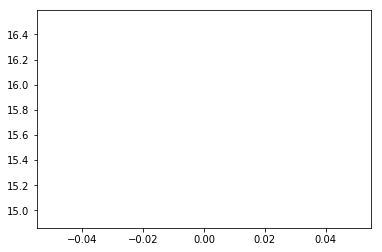

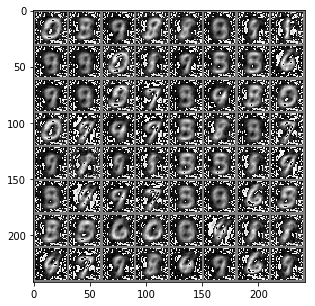

  2%|▏         | 201/10000 [05:59<4:51:56,  1.79s/it]

Variable containing:
 3.3383e-07  1.6077e-04  7.2874e-07  ...   4.8535e-05  4.1118e-04  3.0139e-04
 1.0148e-06  7.9580e-05  2.3489e-07  ...   3.2926e-05  1.7979e-04  5.5372e-04
 7.0348e-07  4.3409e-05  1.0891e-07  ...   2.0047e-05  1.2393e-04  8.1315e-04
                ...                   ⋱                   ...                
 1.2413e-08  3.6207e-05  2.1132e-06  ...   5.7203e-05  4.5825e-04  1.6001e-04
 1.2628e-09  1.0790e-07  2.1485e-11  ...   1.1739e-08  2.0790e-06  6.5231e-05
 1.4313e-06  1.2403e-07  1.7911e-10  ...   9.3438e-08  1.8245e-07  1.1124e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 7.3279e-04  4.3249e-04  3.6266e-04  ...   4.4310e-04  2.1673e-05  2.4365e-06
 4.3301e-04  5.6108e-04  5.5314e-04  ...   1.0667e-04  2.7270e-05  2.0849e-05
 3.6346e-04  5.5370e-04  5.9708e-04  ...   8.0066e-05  4.7857e-05  2.5355e-05
                ...                   ⋱                   ...                
 4.4625e-04  1.0730e-04  8.0458e-05  ...   1.2104e-03  1.0573e-

  2%|▏         | 202/10000 [06:00<4:51:40,  1.79s/it]

Variable containing:
 7.2003e-07  1.9435e-08  1.5840e-05  ...   3.4227e-09  2.5722e-06  1.5846e-06
 4.8952e-04  4.9012e-08  3.0797e-04  ...   7.8984e-08  1.5250e-06  5.2164e-05
 2.8661e-06  1.4844e-03  1.3133e-08  ...   2.1640e-03  8.9643e-09  1.0818e-10
                ...                   ⋱                   ...                
 3.1675e-08  1.0002e-08  8.8764e-08  ...   3.0148e-09  8.2813e-07  1.4060e-08
 8.6778e-05  4.5886e-07  1.7517e-04  ...   4.2384e-08  1.5916e-06  7.3687e-06
 5.4247e-05  3.3764e-11  1.8087e-03  ...   1.1451e-11  7.9596e-07  7.3194e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6895e-03  4.0208e-06  5.4300e-07  ...   7.6707e-04  8.2690e-05  9.1656e-06
 3.6617e-06  8.8191e-04  1.9197e-06  ...   2.4306e-07  1.1713e-04  2.2219e-04
 4.7249e-07  1.8343e-06  2.0689e-03  ...   3.4093e-07  5.2739e-06  8.5311e-08
                ...                   ⋱                   ...                
 8.0534e-04  2.8022e-07  4.1136e-07  ...   1.9721e-03  7.1682e-

  2%|▏         | 203/10000 [06:02<4:51:46,  1.79s/it]

Variable containing:
 1.4134e-07  1.5869e-06  1.0487e-04  ...   1.2315e-03  2.7031e-05  2.2219e-06
 4.2832e-10  1.2759e-09  2.0859e-03  ...   1.1927e-04  4.4762e-04  7.9383e-09
 2.5945e-08  1.5336e-05  2.7450e-06  ...   3.9319e-04  5.6584e-07  6.8619e-07
                ...                   ⋱                   ...                
 1.1845e-10  4.1770e-05  2.3586e-09  ...   6.2127e-10  3.3035e-09  1.2908e-05
 2.7261e-08  3.2040e-06  1.6345e-05  ...   1.1515e-03  2.9540e-06  7.8938e-07
 5.9038e-05  1.5535e-08  8.8775e-06  ...   6.3369e-09  5.0383e-04  5.5869e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2753e-03  1.6413e-04  1.8921e-04  ...   8.0521e-08  8.0490e-04  2.3187e-06
 1.9289e-04  1.8206e-03  1.1338e-05  ...   3.2775e-09  8.3591e-05  1.8045e-06
 1.7367e-04  8.8549e-06  1.0087e-03  ...   7.8588e-07  6.5367e-04  3.6225e-08
                ...                   ⋱                   ...                
 6.7601e-08  2.3412e-09  7.1879e-07  ...   2.0271e-03  1.5928e-

  2%|▏         | 204/10000 [06:04<4:51:29,  1.79s/it]

Variable containing:
 7.5621e-05  2.0346e-07  1.4840e-09  ...   7.2822e-09  6.3727e-08  5.9478e-10
 3.0241e-10  4.3837e-09  6.4870e-18  ...   2.8646e-11  6.0168e-14  4.7408e-10
 4.3471e-04  7.8623e-05  2.4941e-11  ...   1.5679e-08  5.0488e-04  1.2487e-07
                ...                   ⋱                   ...                
 1.0710e-04  4.2152e-07  1.4118e-10  ...   9.2997e-09  3.5545e-08  5.5784e-10
 2.2894e-12  2.0774e-12  5.7529e-04  ...   6.3865e-10  6.3121e-12  8.2970e-13
 1.0495e-08  6.4770e-06  1.8190e-09  ...   1.6532e-03  1.0466e-06  1.9341e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7567e-03  1.2868e-13  2.6512e-05  ...   1.4850e-03  1.8109e-09  8.4881e-10
 1.3968e-13  4.1649e-03  1.7511e-11  ...   1.0388e-12  6.0166e-23  8.9826e-11
 2.5018e-05  1.5224e-11  9.3559e-04  ...   2.4330e-05  6.3370e-13  7.5156e-07
                ...                   ⋱                   ...                
 1.4460e-03  9.3187e-13  2.5106e-05  ...   1.9861e-03  1.8834e-

  2%|▏         | 205/10000 [06:05<4:51:15,  1.78s/it]

Variable containing:
 4.3910e-08  1.8606e-05  1.1049e-10  ...   3.2545e-10  1.8975e-05  1.4330e-05
 3.4273e-05  3.1016e-12  1.5932e-15  ...   1.3205e-15  6.7246e-08  5.7959e-06
 2.6964e-12  4.3671e-05  3.0295e-03  ...   8.2587e-04  6.6918e-09  1.1559e-09
                ...                   ⋱                   ...                
 2.6829e-06  8.9635e-07  2.4046e-12  ...   2.1320e-13  1.6506e-07  1.1969e-04
 7.3869e-08  9.0902e-10  3.9011e-15  ...   6.8130e-14  3.7719e-06  2.6622e-06
 5.5034e-14  1.2800e-06  1.2141e-12  ...   5.5663e-14  1.3369e-08  1.5845e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3165e-03  1.6830e-09  2.3693e-06  ...   7.1666e-05  2.0208e-07  2.4188e-08
 3.7825e-09  7.9429e-03  1.8982e-13  ...   8.3605e-07  5.8318e-04  1.6662e-10
 2.4852e-06  8.8590e-14  1.8216e-03  ...   3.4514e-09  1.4995e-11  1.9090e-10
                ...                   ⋱                   ...                
 8.5569e-05  4.4416e-07  3.9288e-09  ...   1.4972e-03  4.8720e-

  2%|▏         | 206/10000 [06:07<4:51:06,  1.78s/it]

Variable containing:
 6.9309e-04  8.5182e-06  6.6255e-04  ...   1.2753e-05  1.1474e-08  1.6515e-04
 1.0337e-03  8.2485e-06  7.9278e-05  ...   6.9914e-06  1.6697e-08  1.3746e-04
 1.2008e-09  4.7425e-09  3.8712e-13  ...   2.2447e-11  5.0375e-09  3.2141e-08
                ...                   ⋱                   ...                
 1.4460e-06  2.1320e-04  7.3267e-07  ...   1.4450e-03  1.7100e-11  6.1342e-04
 3.2458e-04  1.2217e-05  1.6639e-06  ...   8.7185e-06  6.5597e-07  1.5765e-04
 9.1261e-07  5.4065e-07  7.7867e-11  ...   2.0901e-07  4.4467e-11  5.5609e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2052e-03  5.5008e-04  5.3543e-09  ...   4.3683e-06  9.0871e-05  4.7643e-08
 5.3299e-04  9.3669e-04  5.0180e-09  ...   2.6342e-07  3.2063e-04  1.3947e-06
 8.5967e-09  8.3151e-09  2.1726e-03  ...   5.5487e-10  7.2720e-08  1.1976e-09
                ...                   ⋱                   ...                
 5.7887e-06  3.6027e-07  4.5796e-10  ...   2.1025e-03  4.9103e-

  2%|▏         | 207/10000 [06:08<4:50:53,  1.78s/it]

Variable containing:
 6.6633e-06  1.7434e-08  2.1981e-05  ...   5.1115e-04  5.1974e-07  2.8581e-04
 4.9121e-06  1.9318e-07  1.5695e-04  ...   9.3584e-04  3.5854e-06  1.4896e-04
 4.7140e-05  1.9060e-07  1.2574e-06  ...   1.7873e-06  4.9948e-07  1.1591e-05
                ...                   ⋱                   ...                
 1.5966e-10  3.7245e-14  6.4934e-08  ...   7.5703e-12  4.2510e-14  2.6031e-09
 7.5598e-07  7.1850e-07  2.0081e-04  ...   3.7161e-04  8.5932e-06  3.1511e-05
 6.8177e-04  1.3726e-05  4.5104e-04  ...   1.2199e-06  2.0249e-06  1.2455e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 9.0062e-04  4.4020e-04  1.4624e-05  ...   1.3228e-09  9.8332e-05  4.7355e-07
 4.3940e-04  6.6388e-04  9.0677e-06  ...   2.5682e-10  4.1555e-04  1.9151e-06
 1.4744e-05  9.1589e-06  8.1138e-04  ...   5.0778e-13  2.0204e-06  2.6270e-05
                ...                   ⋱                   ...                
 2.6804e-09  5.2135e-10  1.0205e-12  ...   9.5375e-03  6.6629e-

  2%|▏         | 208/10000 [06:10<4:50:41,  1.78s/it]

Variable containing:
 6.8081e-08  4.0177e-08  5.5900e-08  ...   1.2840e-05  6.1211e-04  6.1713e-12
 2.3464e-06  1.0663e-05  5.0057e-08  ...   1.0367e-04  3.6373e-04  4.4057e-11
 5.3296e-06  3.9065e-09  7.9214e-08  ...   2.2616e-04  3.9880e-06  7.2833e-11
                ...                   ⋱                   ...                
 1.2649e-06  9.7409e-10  2.6507e-06  ...   2.9356e-05  8.1272e-09  1.5579e-10
 7.6630e-16  1.9085e-12  1.4492e-13  ...   1.0738e-15  2.2726e-13  2.0279e-13
 2.7746e-07  2.1387e-05  7.9172e-04  ...   2.9994e-08  3.4481e-11  1.3747e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8140e-03  5.1688e-06  3.3861e-05  ...   6.0912e-07  1.0989e-14  1.8101e-09
 4.3591e-06  9.8130e-04  1.0903e-05  ...   6.1156e-07  2.4680e-10  4.3242e-08
 2.8490e-05  1.0878e-05  9.0301e-04  ...   2.5040e-04  5.7565e-13  1.8737e-07
                ...                   ⋱                   ...                
 5.0893e-07  6.0589e-07  2.4865e-04  ...   1.1261e-03  6.6664e-

  2%|▏         | 209/10000 [06:12<4:50:29,  1.78s/it]

Variable containing:
 9.0860e-05  2.3587e-04  7.1350e-16  ...   1.5508e-06  2.7773e-07  2.5497e-05
 6.6051e-05  4.0181e-04  3.1692e-16  ...   8.2487e-07  2.5189e-07  2.2163e-05
 3.2831e-07  1.1173e-06  6.2111e-11  ...   8.3997e-06  1.1228e-08  4.3286e-05
                ...                   ⋱                   ...                
 1.4947e-04  1.1242e-04  6.8727e-13  ...   4.3833e-04  1.3595e-03  1.0757e-07
 2.0824e-06  6.2770e-04  7.3835e-09  ...   3.8801e-06  2.4120e-06  1.1559e-06
 7.8267e-07  1.1356e-06  3.0331e-15  ...   2.7244e-07  1.8973e-09  1.5969e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6083e-03  1.7099e-03  1.1787e-09  ...   1.9444e-06  9.2019e-09  2.6582e-06
 1.7158e-03  2.2030e-03  4.6825e-10  ...   1.4667e-06  5.0937e-09  1.1866e-06
 1.5327e-09  6.0676e-10  4.0121e-03  ...   1.8299e-07  1.1851e-05  5.5839e-05
                ...                   ⋱                   ...                
 2.0639e-06  1.5513e-06  1.4937e-07  ...   1.3392e-03  1.7781e-

  2%|▏         | 210/10000 [06:13<4:50:17,  1.78s/it]

Variable containing:
 1.4765e-05  1.6956e-07  8.6617e-08  ...   2.3383e-04  6.1838e-05  8.6226e-06
 1.9219e-07  6.9949e-09  2.7781e-09  ...   1.0897e-06  9.1635e-04  2.8618e-04
 1.0862e-03  1.2963e-04  7.1056e-05  ...   3.2828e-05  2.2743e-05  1.7389e-04
                ...                   ⋱                   ...                
 6.7673e-12  5.9986e-14  5.3715e-13  ...   4.2995e-09  4.2797e-11  1.0325e-08
 1.2154e-04  2.3029e-06  7.5117e-07  ...   3.6041e-05  4.9522e-04  5.6037e-05
 5.0236e-06  2.1847e-07  4.9273e-08  ...   1.8514e-06  1.2016e-03  1.9621e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 9.5618e-04  1.5038e-05  3.9831e-05  ...   1.8198e-12  3.2896e-04  3.2953e-05
 1.6806e-05  1.6750e-03  4.2578e-06  ...   9.0264e-13  7.1260e-05  7.5758e-04
 3.9930e-05  3.8194e-06  1.0042e-03  ...   1.1661e-11  1.8453e-04  2.3122e-05
                ...                   ⋱                   ...                
 4.6858e-12  2.0797e-12  2.9952e-11  ...   3.5553e-03  2.2417e-

  2%|▏         | 211/10000 [06:15<4:50:07,  1.78s/it]

Variable containing:
 1.3132e-08  1.8505e-04  2.2955e-03  ...   3.1229e-05  1.9775e-08  2.2888e-14
 5.5823e-09  1.3748e-06  1.9837e-04  ...   7.8679e-05  6.5307e-09  1.1554e-14
 2.1258e-04  1.1826e-07  3.6655e-08  ...   1.2557e-05  2.5963e-05  1.1392e-07
                ...                   ⋱                   ...                
 9.8731e-07  1.6412e-10  1.3095e-12  ...   2.1670e-09  1.5463e-07  1.4346e-13
 2.8887e-08  5.8944e-14  4.2686e-13  ...   2.4694e-12  1.5679e-09  1.6282e-04
 7.0573e-06  1.0317e-05  1.0591e-04  ...   1.5385e-05  1.7229e-05  2.2036e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3166e-03  1.8750e-04  1.0765e-06  ...   3.7629e-10  7.8577e-13  3.0519e-04
 1.9886e-04  2.3562e-03  2.7971e-07  ...   8.7163e-10  3.4347e-13  1.2184e-05
 9.5418e-07  2.3376e-07  6.0963e-04  ...   4.3547e-08  6.1084e-08  2.3888e-05
                ...                   ⋱                   ...                
 3.9144e-10  8.5491e-10  5.1107e-08  ...   2.2885e-03  8.3335e-

  2%|▏         | 212/10000 [06:17<4:50:11,  1.78s/it]

Variable containing:
 2.7324e-06  9.5542e-04  4.3770e-09  ...   9.0088e-05  4.3190e-06  2.8684e-07
 3.6513e-13  1.7413e-09  1.6651e-03  ...   1.3197e-05  4.4611e-07  5.2691e-13
 2.8228e-15  1.8830e-14  2.2093e-07  ...   4.5839e-09  3.9162e-11  7.3904e-17
                ...                   ⋱                   ...                
 8.5213e-05  8.4632e-07  4.1356e-07  ...   2.5418e-06  3.1451e-05  2.9497e-05
 3.3949e-04  9.9006e-07  5.6908e-08  ...   7.6294e-06  3.3456e-04  5.9925e-05
 4.7228e-09  2.9117e-11  5.6796e-10  ...   2.5620e-05  1.3461e-07  1.0370e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0465e-03  6.6598e-09  5.2387e-16  ...   6.9703e-07  4.5909e-07  5.1383e-09
 1.8424e-08  7.1494e-03  9.9389e-08  ...   5.6750e-09  1.7595e-09  1.3339e-09
 1.3028e-15  8.9345e-08  3.6681e-03  ...   6.0678e-14  1.0972e-15  1.2453e-12
                ...                   ⋱                   ...                
 6.8123e-07  2.0049e-09  2.3846e-14  ...   8.9023e-04  1.4629e-

  2%|▏         | 213/10000 [06:18<4:50:10,  1.78s/it]

Variable containing:
 1.0382e-03  4.6131e-08  4.8710e-08  ...   1.4105e-04  1.7760e-09  1.9147e-10
 5.1229e-04  4.8410e-08  2.3004e-06  ...   9.0010e-05  4.2862e-11  5.1368e-08
 1.3505e-06  9.7391e-08  5.5970e-08  ...   7.3806e-10  1.3092e-04  5.9565e-11
                ...                   ⋱                   ...                
 4.9012e-05  4.7204e-08  5.8913e-04  ...   4.3895e-05  6.1951e-10  1.1422e-05
 1.6817e-05  4.0896e-06  2.9486e-04  ...   4.9835e-05  5.6164e-06  6.6784e-06
 2.6150e-08  5.4282e-04  8.5155e-08  ...   1.0387e-07  2.4391e-08  1.8453e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 3.0500e-03  2.3663e-04  2.7539e-08  ...   1.5475e-06  7.8323e-08  5.0226e-09
 2.2301e-04  8.1991e-04  2.8759e-09  ...   1.8314e-05  9.5359e-08  1.8170e-08
 4.8019e-08  5.3208e-09  5.4194e-03  ...   1.6759e-07  6.5181e-08  3.8514e-09
                ...                   ⋱                   ...                
 1.6878e-06  2.1193e-05  1.0483e-07  ...   1.5316e-03  1.6582e-

  2%|▏         | 214/10000 [06:20<4:50:05,  1.78s/it]

Variable containing:
 1.3042e-07  5.3776e-16  3.2030e-07  ...   1.5876e-12  1.5459e-09  1.5314e-06
 1.4285e-05  7.2130e-06  1.0234e-07  ...   1.1140e-06  1.5781e-08  7.6166e-07
 2.4521e-04  4.2635e-08  5.7472e-06  ...   6.7435e-07  2.4582e-11  2.5200e-05
                ...                   ⋱                   ...                
 3.5829e-09  2.9067e-10  7.5005e-07  ...   8.5934e-04  4.8117e-12  2.8834e-05
 3.3408e-08  2.7316e-06  3.1387e-06  ...   2.3766e-05  5.1083e-11  1.0689e-04
 2.0753e-04  6.6084e-13  5.5136e-04  ...   1.6570e-07  1.6760e-10  2.3159e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 7.2347e-03  1.1450e-07  4.4908e-07  ...   3.3950e-08  7.1186e-08  1.2970e-04
 7.0700e-08  3.7474e-03  2.7868e-04  ...   4.7138e-07  7.1422e-05  3.3266e-08
 2.4486e-07  2.4609e-04  1.6268e-03  ...   1.4830e-06  7.9822e-05  3.8155e-07
                ...                   ⋱                   ...                
 1.7646e-08  3.9679e-07  1.4137e-06  ...   1.2114e-03  4.4376e-

  2%|▏         | 215/10000 [06:22<4:49:51,  1.78s/it]

Variable containing:
 2.7393e-06  9.3471e-07  2.0644e-06  ...   2.4189e-04  9.1837e-10  1.7915e-07
 9.4532e-09  2.6308e-05  5.2060e-09  ...   2.9274e-10  5.2286e-13  3.5211e-15
 4.2573e-05  1.2780e-06  2.9832e-05  ...   2.0819e-03  1.4668e-09  5.5660e-08
                ...                   ⋱                   ...                
 3.0980e-04  2.9211e-04  1.7702e-04  ...   1.6773e-06  8.5455e-05  1.9442e-05
 1.5507e-07  1.3664e-08  3.7060e-04  ...   9.6659e-11  7.5493e-04  2.3888e-05
 3.8763e-04  6.3611e-04  1.1709e-07  ...   3.5393e-07  1.3205e-08  6.1075e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3225e-03  1.6727e-17  5.9726e-04  ...   2.3165e-07  3.3582e-10  7.6769e-10
 3.1660e-17  2.4195e-03  4.4271e-15  ...   8.5135e-12  3.7993e-14  2.9590e-08
 5.9514e-04  2.3307e-15  1.6104e-03  ...   2.1112e-06  3.1396e-09  3.6210e-08
                ...                   ⋱                   ...                
 2.3111e-07  4.4874e-12  2.1137e-06  ...   8.8793e-04  2.0344e-

  2%|▏         | 216/10000 [06:23<4:49:41,  1.78s/it]

Variable containing:
 2.8641e-11  7.4433e-06  4.9983e-08  ...   7.6174e-08  1.0935e-05  6.3428e-06
 4.5597e-10  1.0272e-07  4.7536e-07  ...   9.1388e-08  2.6086e-05  1.1272e-04
 1.7338e-04  1.5448e-12  9.4166e-04  ...   9.7617e-08  8.5345e-07  7.7995e-08
                ...                   ⋱                   ...                
 2.5524e-06  7.2723e-10  3.6151e-04  ...   1.2928e-06  4.1529e-05  2.1222e-06
 1.8491e-08  8.6018e-08  3.6061e-05  ...   1.1446e-06  3.5207e-05  3.4760e-06
 3.1591e-10  4.1151e-13  6.7794e-09  ...   1.0608e-09  4.6438e-06  3.0342e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 4.1629e-03  1.0265e-03  2.4362e-09  ...   4.7589e-07  2.8768e-05  3.2397e-06
 1.0136e-03  1.9325e-03  1.0989e-08  ...   2.3251e-06  8.5089e-05  2.5506e-05
 1.9023e-09  8.6906e-09  1.3552e-03  ...   4.7627e-05  6.5084e-07  5.4353e-10
                ...                   ⋱                   ...                
 3.8058e-07  1.8833e-06  4.8777e-05  ...   1.1724e-03  2.3031e-

  2%|▏         | 217/10000 [06:25<4:49:33,  1.78s/it]

Variable containing:
 6.1552e-13  4.3786e-06  1.3734e-07  ...   2.6348e-03  7.2133e-17  7.8802e-04
 1.0123e-06  2.7514e-05  2.0119e-04  ...   4.1166e-06  8.4142e-14  6.3148e-06
 5.4528e-07  1.9584e-07  9.4673e-05  ...   6.6554e-07  2.2071e-15  2.2090e-07
                ...                   ⋱                   ...                
 2.6043e-14  7.1326e-15  3.7543e-08  ...   1.9348e-11  2.3258e-23  8.6601e-11
 1.4654e-08  1.1550e-10  2.1572e-05  ...   7.7352e-08  1.9312e-16  2.0348e-09
 3.3732e-08  4.4771e-08  2.2939e-05  ...   5.1353e-08  7.3746e-13  3.9822e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 4.9405e-03  3.5387e-09  1.6008e-09  ...   1.0537e-11  3.1637e-10  1.3979e-11
 2.5629e-09  6.6821e-04  2.1652e-04  ...   5.1657e-10  6.1916e-06  5.9222e-05
 1.1731e-09  2.1907e-04  7.6031e-04  ...   3.3274e-08  1.7809e-04  1.1546e-04
                ...                   ⋱                   ...                
 1.1085e-11  7.5035e-10  4.7768e-08  ...   3.9218e-03  1.8923e-

  2%|▏         | 218/10000 [06:26<4:49:20,  1.77s/it]

Variable containing:
 5.4722e-05  9.4200e-09  1.2095e-08  ...   4.3754e-08  9.4300e-07  2.8665e-05
 1.2297e-09  7.1561e-05  1.1363e-08  ...   9.5033e-06  3.6806e-10  1.0399e-09
 2.7147e-07  1.7994e-09  1.4058e-08  ...   6.9142e-09  1.9974e-04  2.7558e-08
                ...                   ⋱                   ...                
 6.0465e-05  6.3830e-07  2.5186e-07  ...   1.0733e-05  4.0551e-04  2.6866e-06
 6.7594e-05  4.3404e-08  2.7174e-09  ...   3.6992e-07  9.9597e-06  3.8062e-04
 3.7818e-04  4.7078e-04  7.6989e-07  ...   6.3461e-04  9.1417e-05  1.2438e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 5.7959e-03  1.0405e-10  2.9728e-11  ...   9.1177e-09  8.6261e-04  3.0234e-07
 1.1157e-10  2.9165e-03  1.6351e-10  ...   3.5498e-09  1.1919e-10  4.7279e-07
 2.9726e-11  1.5248e-10  2.0872e-03  ...   1.3970e-04  5.8370e-10  1.6821e-07
                ...                   ⋱                   ...                
 8.1979e-09  2.9766e-09  1.2561e-04  ...   1.3082e-03  1.6591e-

  2%|▏         | 219/10000 [06:28<4:49:09,  1.77s/it]

Variable containing:
 8.0472e-08  3.6536e-06  3.4206e-09  ...   1.0547e-12  9.2536e-08  1.5819e-13
 5.8298e-09  5.7417e-06  2.2335e-04  ...   1.3726e-06  2.4061e-04  1.5787e-05
 1.0222e-07  4.2450e-06  4.1392e-07  ...   1.9757e-05  8.6194e-05  4.1562e-11
                ...                   ⋱                   ...                
 2.6896e-07  2.5327e-04  4.9157e-07  ...   5.1596e-06  3.4999e-05  1.1424e-10
 5.1179e-06  1.1793e-03  5.5467e-05  ...   6.2252e-11  2.2402e-06  7.0968e-11
 1.5422e-07  2.9470e-06  2.0966e-07  ...   1.5547e-03  5.1070e-05  2.2840e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 4.3476e-03  1.1433e-09  2.3995e-08  ...   6.0328e-07  4.6716e-09  2.8677e-08
 6.5265e-10  1.0096e-03  3.3612e-06  ...   3.5386e-07  5.7199e-07  6.9549e-06
 1.4816e-08  3.6356e-06  2.9908e-03  ...   5.6462e-04  4.0921e-08  3.0109e-04
                ...                   ⋱                   ...                
 3.9912e-07  4.1011e-07  6.0497e-04  ...   1.8670e-03  7.2184e-

  2%|▏         | 220/10000 [06:30<4:48:58,  1.77s/it]

Variable containing:
 8.7123e-06  2.5666e-08  8.3598e-09  ...   1.8040e-09  8.2770e-07  1.9890e-06
 1.5576e-08  1.3217e-09  1.1762e-12  ...   2.0727e-13  4.6049e-10  1.5711e-11
 3.5502e-04  1.1207e-05  2.0460e-07  ...   9.9038e-07  7.4552e-04  8.9133e-04
                ...                   ⋱                   ...                
 1.1287e-08  7.2424e-06  8.0101e-07  ...   1.4573e-10  7.8067e-08  2.3462e-11
 1.0130e-08  1.8884e-09  2.3014e-12  ...   1.3540e-13  6.3736e-10  9.8487e-12
 2.1629e-06  1.8353e-08  9.6868e-09  ...   1.7021e-09  2.6534e-08  4.5884e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 6.7357e-04  1.8180e-07  8.2379e-07  ...   1.0851e-07  1.3013e-07  1.0972e-04
 2.6433e-07  3.0308e-03  1.0666e-10  ...   7.4295e-05  2.5419e-03  1.0718e-07
 9.8885e-07  8.8054e-11  1.5116e-03  ...   2.8906e-09  6.7486e-11  5.7728e-08
                ...                   ⋱                   ...                
 1.3803e-07  6.5003e-05  3.0633e-09  ...   2.9688e-03  1.0113e-

  2%|▏         | 221/10000 [06:31<4:48:47,  1.77s/it]

Variable containing:
 3.5221e-04  2.1542e-07  9.4168e-09  ...   3.0815e-08  2.0153e-04  1.1175e-05
 6.0882e-05  2.6083e-06  1.7079e-08  ...   4.3213e-07  2.3085e-05  1.4926e-06
 4.2530e-07  1.2390e-05  2.3848e-08  ...   2.0973e-06  1.4470e-07  2.1866e-07
                ...                   ⋱                   ...                
 7.1817e-18  1.9665e-11  5.9873e-14  ...   9.1279e-09  2.4551e-18  2.3252e-18
 8.6164e-06  1.0281e-04  5.6764e-08  ...   2.0360e-05  2.6860e-06  5.0243e-07
 9.4155e-09  5.8569e-05  5.8846e-11  ...   9.9288e-05  7.6939e-10  7.3965e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 9.7833e-04  6.9007e-04  4.3769e-06  ...   2.7473e-18  2.3280e-04  3.1471e-06
 6.8570e-04  8.3071e-04  5.0950e-06  ...   6.6046e-18  4.2069e-04  1.9685e-05
 4.7441e-06  5.5578e-06  2.3687e-03  ...   3.0897e-13  6.1461e-05  4.0411e-07
                ...                   ⋱                   ...                
 5.6810e-18  1.3744e-17  5.8944e-13  ...   3.8990e-03  4.2514e-

  2%|▏         | 222/10000 [06:33<4:48:42,  1.77s/it]

Variable containing:
 2.4478e-06  2.8966e-05  2.1930e-04  ...   1.1972e-09  3.6175e-06  8.6944e-11
 6.5996e-07  9.7461e-09  4.1549e-11  ...   5.8188e-04  7.6033e-07  2.6934e-15
 1.8682e-04  4.2517e-08  8.7990e-11  ...   3.0519e-05  4.4791e-05  2.4307e-14
                ...                   ⋱                   ...                
 1.7348e-04  5.9418e-04  2.9166e-07  ...   7.9540e-07  1.2084e-04  1.6728e-13
 2.5796e-04  1.7859e-04  3.5703e-07  ...   5.3857e-07  3.0073e-04  5.5995e-13
 2.1379e-06  8.2946e-04  2.8624e-07  ...   1.4984e-07  6.4450e-07  2.6673e-14
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7132e-03  6.4407e-11  5.0355e-09  ...   1.0144e-04  9.0833e-05  2.8636e-04
 6.9764e-11  1.3512e-03  1.0408e-07  ...   6.1065e-09  2.4601e-09  2.9893e-08
 4.6439e-09  8.8620e-08  9.6397e-04  ...   3.1353e-06  3.6666e-06  2.3800e-07
                ...                   ⋱                   ...                
 9.1710e-05  5.0970e-09  3.0736e-06  ...   7.1630e-04  6.6926e-

  2%|▏         | 223/10000 [06:34<4:48:32,  1.77s/it]

Variable containing:
 5.9502e-05  1.5258e-09  2.9273e-05  ...   3.1779e-04  8.0150e-04  2.1128e-06
 6.6303e-07  2.2532e-09  6.3542e-08  ...   8.2238e-05  3.0264e-06  8.0500e-09
 2.9727e-05  8.1361e-09  6.8433e-06  ...   3.8955e-04  4.1820e-04  6.9050e-07
                ...                   ⋱                   ...                
 7.7011e-04  2.1656e-05  2.5219e-05  ...   9.8984e-06  1.4021e-04  2.0682e-04
 6.0079e-06  8.9415e-04  7.3998e-08  ...   4.2157e-07  9.2600e-07  6.5496e-06
 1.1585e-04  5.9481e-05  3.3044e-06  ...   1.8052e-07  6.5702e-06  1.3567e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3041e-03  9.3182e-06  5.3804e-04  ...   4.3066e-05  7.1934e-09  4.0045e-07
 9.3776e-06  2.0311e-03  1.6909e-04  ...   1.2121e-05  3.8081e-07  4.6889e-08
 5.2592e-04  1.6424e-04  1.0350e-03  ...   6.5313e-05  7.7715e-08  3.4669e-07
                ...                   ⋱                   ...                
 4.2044e-05  1.1759e-05  6.5234e-05  ...   8.1976e-04  9.9976e-

  2%|▏         | 224/10000 [06:36<4:48:24,  1.77s/it]

Variable containing:
 2.6369e-05  5.5037e-05  3.2784e-05  ...   1.4339e-04  9.6143e-06  8.5354e-06
 7.6584e-14  3.0742e-07  9.6087e-09  ...   2.8576e-09  2.4382e-13  1.8618e-10
 8.3727e-14  5.1866e-10  1.1150e-08  ...   5.3121e-09  4.1429e-14  1.4650e-10
                ...                   ⋱                   ...                
 1.2085e-07  3.1112e-04  3.1804e-08  ...   3.7919e-04  2.3380e-07  5.1118e-09
 8.2702e-08  4.5203e-04  2.6189e-08  ...   2.2868e-04  2.3481e-07  3.5160e-09
 1.1116e-09  7.7488e-08  1.1502e-05  ...   5.2185e-06  1.3405e-10  1.2037e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 4.3692e-03  3.2051e-09  3.9811e-07  ...   3.2434e-05  2.1571e-05  5.1726e-06
 3.3503e-09  1.4993e-03  2.9141e-09  ...   8.3770e-10  1.0388e-09  7.1996e-08
 5.6399e-07  3.9495e-09  8.3444e-03  ...   1.3028e-07  1.2290e-07  3.5909e-06
                ...                   ⋱                   ...                
 3.3853e-05  8.3647e-10  9.5983e-08  ...   1.6916e-03  1.4877e-

  2%|▏         | 225/10000 [06:38<4:48:14,  1.77s/it]

Variable containing:
 1.4688e-12  7.0379e-13  3.0131e-14  ...   4.0337e-06  5.5836e-05  3.5473e-10
 9.0267e-07  3.6582e-06  2.4792e-04  ...   4.9497e-05  1.1131e-06  2.3720e-09
 1.8329e-04  2.4252e-06  1.2575e-03  ...   2.2108e-06  5.5663e-07  3.7550e-06
                ...                   ⋱                   ...                
 6.0676e-09  1.4570e-07  8.6013e-10  ...   1.5090e-10  9.6174e-06  5.0333e-09
 3.2717e-06  3.6010e-06  4.3636e-04  ...   2.9353e-05  8.9695e-07  9.7222e-09
 1.3865e-04  8.0808e-09  8.9542e-06  ...   1.9753e-07  8.3141e-08  1.5296e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 8.5421e-03  1.2066e-10  1.2245e-10  ...   6.5063e-10  1.1717e-10  1.1285e-08
 7.0149e-11  1.9638e-03  3.6328e-04  ...   2.9175e-07  1.7524e-03  1.3319e-06
 6.8144e-11  3.4775e-04  1.0324e-03  ...   8.0851e-07  5.1594e-04  5.8293e-05
                ...                   ⋱                   ...                
 4.1539e-10  3.2040e-07  9.2756e-07  ...   3.1852e-03  3.6340e-

  2%|▏         | 226/10000 [06:39<4:48:00,  1.77s/it]

Variable containing:
 1.3750e-05  1.4685e-14  2.1867e-06  ...   1.8752e-04  1.1969e-04  1.7148e-05
 3.2433e-09  4.1197e-18  1.2056e-09  ...   2.7391e-07  2.5236e-05  1.1789e-07
 2.4310e-04  1.2383e-14  2.9033e-06  ...   7.2301e-05  1.6721e-04  1.3917e-04
                ...                   ⋱                   ...                
 7.1780e-13  1.3660e-17  3.4039e-08  ...   1.3132e-11  1.4806e-11  1.0383e-08
 8.3776e-04  2.3376e-14  6.2008e-08  ...   4.4776e-06  4.9056e-06  6.1643e-05
 1.5752e-06  2.2948e-14  7.4156e-06  ...   7.1091e-04  6.9539e-06  1.5054e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 6.9747e-04  1.9408e-05  4.0655e-04  ...   5.5931e-08  6.3998e-06  1.8207e-04
 2.6677e-05  3.4331e-03  7.5858e-06  ...   2.6355e-10  6.8562e-09  6.7013e-07
 4.1566e-04  5.6424e-06  8.7223e-04  ...   2.4253e-08  1.0852e-04  4.5080e-05
                ...                   ⋱                   ...                
 3.0641e-07  1.0504e-09  1.2996e-07  ...   9.9621e-03  1.4127e-

  2%|▏         | 227/10000 [06:41<4:47:49,  1.77s/it]

Variable containing:
 9.4974e-09  2.1915e-07  5.3747e-07  ...   1.3679e-11  1.5969e-05  2.9768e-08
 2.4725e-08  2.6207e-06  6.9290e-07  ...   8.8102e-07  9.5325e-11  5.8726e-08
 2.3901e-14  6.2538e-05  6.0573e-09  ...   9.8392e-06  1.9635e-12  3.2841e-08
                ...                   ⋱                   ...                
 9.4301e-06  1.0840e-04  1.4840e-04  ...   7.2058e-07  4.7734e-10  1.7867e-06
 7.7063e-09  1.8484e-06  3.7306e-06  ...   1.2735e-06  8.7381e-10  4.9914e-04
 5.2874e-06  8.2542e-05  6.3477e-05  ...   1.1351e-10  6.5129e-12  6.0537e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3774e-03  1.4826e-09  8.5061e-11  ...   4.3392e-09  8.2420e-06  2.1234e-09
 1.0846e-09  1.8880e-03  2.3793e-09  ...   4.3360e-05  4.0421e-08  1.0252e-06
 1.6513e-10  6.3136e-09  7.3313e-03  ...   8.2989e-08  1.9513e-08  1.0373e-09
                ...                   ⋱                   ...                
 2.9977e-09  4.0945e-05  2.9532e-08  ...   1.1423e-03  3.6770e-

  2%|▏         | 228/10000 [06:42<4:47:38,  1.77s/it]

Variable containing:
 5.1967e-07  1.2065e-12  1.0616e-10  ...   8.4175e-07  7.1994e-09  5.0637e-09
 4.5399e-05  2.3927e-05  1.9179e-10  ...   1.0804e-03  1.1805e-05  5.1007e-05
 1.6412e-07  2.8806e-09  8.5836e-05  ...   2.5123e-07  4.1742e-08  4.1684e-07
                ...                   ⋱                   ...                
 2.2567e-06  2.2310e-04  4.4101e-10  ...   1.2614e-04  5.8887e-04  2.5654e-04
 2.5397e-05  6.5113e-09  5.7615e-11  ...   1.6011e-07  2.1043e-08  4.4472e-08
 1.2968e-07  3.0329e-10  9.7460e-14  ...   1.6159e-14  1.0170e-10  1.1341e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 5.2145e-03  3.3175e-09  6.4115e-10  ...   4.3682e-09  5.6604e-08  1.7262e-13
 2.2282e-09  1.5585e-03  5.8892e-07  ...   6.1747e-07  2.1377e-08  2.4343e-08
 3.3775e-10  4.6190e-07  1.3172e-03  ...   2.0860e-07  1.4275e-08  3.0123e-11
                ...                   ⋱                   ...                
 2.4522e-09  5.1610e-07  2.2230e-07  ...   1.1067e-03  7.3883e-

  2%|▏         | 229/10000 [06:44<4:47:26,  1.77s/it]

Variable containing:
 7.3311e-09  3.1311e-07  3.1091e-11  ...   3.4632e-05  1.3260e-06  1.3545e-07
 4.9974e-06  1.0748e-05  2.5651e-09  ...   4.1783e-07  7.6164e-07  1.1280e-04
 9.9544e-15  8.5915e-11  3.7175e-17  ...   2.4337e-07  2.0101e-12  1.4605e-13
                ...                   ⋱                   ...                
 4.9769e-05  1.1025e-05  3.2494e-10  ...   5.0516e-09  1.1511e-09  4.4799e-04
 5.0767e-04  1.1954e-04  7.3278e-06  ...   1.9541e-09  1.8609e-08  1.6445e-05
 4.9171e-06  4.0710e-04  3.1473e-12  ...   1.1699e-09  1.9507e-11  3.2873e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5777e-03  6.3492e-05  1.6159e-05  ...   1.5951e-08  5.2670e-10  1.8477e-08
 5.8753e-05  9.8604e-04  2.0258e-08  ...   1.8625e-05  1.2289e-08  4.0825e-07
 2.7929e-05  3.7837e-08  8.8169e-03  ...   1.8222e-10  3.3764e-10  2.9027e-09
                ...                   ⋱                   ...                
 1.5009e-08  1.8939e-05  9.9203e-11  ...   1.5854e-03  2.4753e-

  2%|▏         | 230/10000 [06:45<4:47:16,  1.76s/it]

Variable containing:
 3.3188e-10  1.4095e-09  7.0544e-06  ...   7.7599e-08  7.0966e-08  3.3275e-14
 8.4635e-05  1.2429e-09  1.4913e-09  ...   6.0247e-07  1.1489e-08  5.8448e-12
 1.5661e-06  9.9974e-08  3.3732e-04  ...   5.3966e-05  2.1469e-05  2.8649e-13
                ...                   ⋱                   ...                
 3.7738e-10  1.9914e-08  3.8260e-09  ...   8.0839e-07  1.3295e-08  1.3222e-16
 2.3558e-06  6.9123e-08  9.0403e-06  ...   1.2388e-05  1.4317e-07  1.4699e-13
 1.7164e-11  2.1364e-14  6.6932e-10  ...   4.1824e-14  9.0294e-15  3.7491e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2874e-03  1.0670e-06  5.2621e-05  ...   3.7456e-10  7.0476e-07  9.2144e-10
 3.6217e-06  9.2189e-03  7.4073e-07  ...   4.5228e-09  1.3383e-06  1.0533e-07
 5.1574e-05  2.1389e-07  7.3590e-04  ...   1.9464e-08  3.1985e-05  4.2310e-11
                ...                   ⋱                   ...                
 5.1273e-10  1.8241e-09  2.7186e-08  ...   2.4046e-03  4.5557e-

  2%|▏         | 231/10000 [06:47<4:47:14,  1.76s/it]

Variable containing:
 1.9726e-07  5.2716e-06  3.3032e-04  ...   2.4861e-10  1.2808e-06  1.5205e-04
 2.4478e-14  2.3445e-14  8.5952e-04  ...   1.2517e-09  4.1129e-13  1.4770e-12
 9.0730e-05  6.0639e-08  2.1590e-04  ...   1.0778e-10  4.8455e-08  1.5659e-03
                ...                   ⋱                   ...                
 3.2708e-06  4.0992e-04  2.6731e-05  ...   9.1284e-06  9.6979e-05  8.6787e-05
 3.3306e-04  3.1984e-07  3.0231e-05  ...   1.3952e-07  5.8052e-06  3.3971e-05
 5.1573e-07  1.7007e-04  6.3781e-06  ...   2.9807e-05  3.7973e-05  1.9177e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 8.4592e-04  2.9223e-18  1.5450e-04  ...   4.6878e-06  2.6280e-06  7.3341e-07
 1.0177e-17  5.2763e-03  2.6188e-18  ...   2.2674e-16  3.3444e-18  7.8110e-16
 1.5916e-04  7.7464e-19  1.6578e-03  ...   9.1307e-07  1.6940e-05  1.0830e-07
                ...                   ⋱                   ...                
 4.4025e-06  6.1143e-17  8.3239e-07  ...   6.6875e-04  1.8804e-

  2%|▏         | 232/10000 [06:49<4:47:05,  1.76s/it]

Variable containing:
 1.6372e-06  1.8229e-04  2.1835e-07  ...   3.1558e-09  3.2292e-04  2.7816e-05
 7.2238e-12  4.8049e-11  8.1329e-11  ...   6.1987e-04  1.2954e-03  7.4751e-09
 5.5641e-08  6.3612e-08  2.2563e-07  ...   4.9461e-09  2.7687e-05  2.0454e-07
                ...                   ⋱                   ...                
 5.7826e-07  1.5847e-06  1.7370e-06  ...   7.0516e-09  9.2667e-05  3.0902e-06
 6.0625e-07  7.7590e-05  1.0237e-09  ...   1.5141e-09  1.1230e-04  1.1456e-06
 3.6499e-06  8.3081e-04  2.5812e-07  ...   3.9339e-09  5.5127e-04  9.8050e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0406e-03  3.0000e-08  1.3079e-05  ...   1.0935e-04  7.8072e-06  6.3770e-04
 5.3228e-08  9.0571e-03  3.3893e-05  ...   6.0179e-06  1.1790e-09  1.7751e-08
 1.4091e-05  2.0580e-05  1.4491e-03  ...   7.7903e-04  1.0513e-08  2.3693e-06
                ...                   ⋱                   ...                
 1.1438e-04  3.5477e-06  7.5636e-04  ...   1.1593e-03  8.3959e-

  2%|▏         | 233/10000 [06:50<4:46:59,  1.76s/it]

Variable containing:
 3.4297e-06  3.3970e-06  1.1890e-10  ...   6.8217e-14  8.9251e-15  8.9084e-05
 6.7812e-04  1.6134e-10  1.6939e-09  ...   4.9984e-06  8.0279e-09  7.0892e-06
 1.9683e-08  6.7059e-05  4.9839e-05  ...   1.1278e-10  1.2828e-10  3.8336e-06
                ...                   ⋱                   ...                
 1.4187e-05  3.6810e-11  4.5380e-11  ...   5.5847e-17  6.2492e-20  3.9223e-07
 2.0612e-04  7.0534e-07  1.4426e-10  ...   1.8815e-13  9.4709e-15  1.0624e-03
 5.2171e-09  6.3391e-04  1.2112e-03  ...   3.3771e-13  4.3216e-13  7.7563e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8717e-03  4.3779e-08  2.6734e-07  ...   7.6155e-10  9.5299e-04  5.6898e-09
 5.2325e-08  2.0575e-03  2.7850e-07  ...   1.3868e-06  8.6457e-07  8.1556e-09
 2.4005e-07  2.0922e-07  9.8078e-04  ...   1.0312e-08  3.0695e-07  3.9434e-05
                ...                   ⋱                   ...                
 2.6163e-09  3.9861e-06  3.9453e-08  ...   9.9154e-03  4.5259e-

  2%|▏         | 234/10000 [06:52<4:46:46,  1.76s/it]

Variable containing:
 5.4286e-13  7.0705e-08  1.2949e-19  ...   3.3233e-11  1.6221e-11  2.7262e-08
 5.1849e-09  3.9495e-08  1.8521e-12  ...   5.4583e-09  6.5154e-08  1.7909e-09
 4.9389e-08  4.5171e-05  2.6016e-11  ...   9.4343e-08  2.4324e-05  4.4063e-07
                ...                   ⋱                   ...                
 6.2370e-04  3.7515e-06  2.5219e-04  ...   3.0388e-05  1.1679e-06  2.1529e-08
 2.0381e-14  5.2642e-13  8.9020e-09  ...   1.8883e-12  5.6607e-04  2.5625e-10
 5.8409e-13  2.2223e-13  8.4471e-06  ...   9.0861e-12  7.4305e-06  1.9830e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 8.3655e-03  1.7520e-14  1.3982e-08  ...   1.6062e-14  6.2805e-19  1.6062e-20
 1.0851e-14  1.7787e-03  2.2341e-06  ...   9.3016e-08  1.4032e-10  2.0215e-11
 8.7412e-09  2.2549e-06  1.8871e-03  ...   3.6411e-07  7.8647e-11  1.3093e-11
                ...                   ⋱                   ...                
 1.0047e-14  9.3940e-08  3.6432e-07  ...   1.9431e-03  2.0307e-

  2%|▏         | 235/10000 [06:53<4:46:34,  1.76s/it]

Variable containing:
 1.5123e-12  1.6585e-03  1.8888e-14  ...   8.0353e-13  4.7596e-09  6.4883e-10
 1.7319e-14  3.2675e-06  6.0933e-16  ...   4.2323e-14  1.0798e-09  6.7016e-05
 9.0997e-04  1.1702e-12  2.3294e-10  ...   5.7606e-03  1.6448e-05  2.1288e-10
                ...                   ⋱                   ...                
 2.3378e-07  1.0767e-07  5.7061e-08  ...   1.4830e-08  1.7955e-05  3.7221e-07
 2.1000e-13  2.1946e-05  5.0985e-15  ...   4.7000e-13  1.6414e-08  7.7429e-04
 4.7098e-10  6.2151e-05  1.4864e-13  ...   2.5890e-11  1.5301e-07  9.6010e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.6099e-03  1.5177e-06  1.3649e-11  ...   1.5770e-07  1.5517e-06  4.9415e-04
 2.4878e-06  5.6897e-03  8.1227e-12  ...   6.5402e-10  1.6367e-03  3.2188e-07
 1.2285e-11  4.4602e-12  4.5574e-03  ...   3.3244e-08  3.1606e-11  1.1966e-10
                ...                   ⋱                   ...                
 1.1576e-07  2.9288e-10  2.7112e-08  ...   9.8504e-04  4.5041e-

  2%|▏         | 236/10000 [06:55<4:46:21,  1.76s/it]

Variable containing:
 3.1692e-06  1.1744e-07  1.3669e-08  ...   8.7160e-05  1.2153e-04  7.4232e-09
 8.9096e-05  4.0661e-05  1.6718e-05  ...   3.1480e-05  5.9601e-05  1.6952e-08
 2.9281e-07  1.2029e-09  4.5156e-10  ...   6.2487e-09  1.1993e-06  3.1711e-08
                ...                   ⋱                   ...                
 5.9062e-07  8.3551e-08  8.9281e-08  ...   4.9173e-07  1.8787e-06  8.2291e-10
 6.6142e-07  2.0532e-09  2.1296e-09  ...   2.8036e-04  6.6116e-04  1.0177e-03
 2.8566e-05  1.2339e-05  7.4606e-07  ...   6.9863e-05  2.5882e-04  5.8159e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 5.7992e-03  6.1771e-08  1.9665e-11  ...   2.0483e-10  4.3929e-06  8.8658e-09
 4.9719e-08  1.5834e-03  4.1398e-08  ...   4.7686e-04  6.9342e-08  1.6830e-05
 1.6697e-11  4.3671e-08  3.7398e-03  ...   8.0826e-09  1.0734e-08  5.8398e-06
                ...                   ⋱                   ...                
 1.6770e-10  4.8506e-04  7.7937e-09  ...   2.5887e-03  6.0008e-

  2%|▏         | 237/10000 [06:56<4:46:10,  1.76s/it]

Variable containing:
 1.1667e-06  7.9954e-07  2.9615e-07  ...   7.0055e-09  1.7110e-07  1.3685e-11
 4.1989e-08  4.0899e-07  6.5335e-08  ...   1.6819e-10  6.4519e-11  2.6401e-13
 3.0689e-06  2.5595e-08  6.8963e-07  ...   1.4552e-04  7.7416e-07  5.9185e-04
                ...                   ⋱                   ...                
 1.7766e-09  8.6506e-10  2.9147e-15  ...   1.8395e-07  3.6964e-10  1.0793e-13
 5.1020e-05  1.4350e-06  1.8098e-10  ...   1.6682e-05  1.1988e-06  8.4494e-08
 3.6159e-06  8.1865e-08  7.1447e-11  ...   1.1537e-04  1.9916e-08  1.0537e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 4.8262e-03  9.9038e-07  3.2123e-10  ...   5.1216e-15  8.7295e-07  1.2364e-11
 1.8470e-06  5.9338e-03  1.2960e-11  ...   1.2349e-14  1.1712e-10  4.9321e-11
 2.0376e-10  4.4079e-12  1.0140e-03  ...   1.8171e-08  3.8572e-06  2.6145e-05
                ...                   ⋱                   ...                
 4.0490e-15  5.2347e-15  2.2648e-08  ...   3.0249e-03  3.5538e-

  2%|▏         | 238/10000 [06:58<4:45:57,  1.76s/it]

Variable containing:
 6.8562e-10  1.6439e-08  8.7255e-17  ...   2.2945e-05  5.6899e-10  1.0646e-06
 2.2386e-04  4.8012e-03  1.8559e-13  ...   9.2928e-11  1.3980e-03  8.4441e-10
 1.4994e-04  7.4366e-05  8.2969e-15  ...   1.4511e-05  6.0056e-07  1.0227e-07
                ...                   ⋱                   ...                
 7.7306e-06  2.6986e-06  6.0234e-07  ...   1.6751e-09  1.9242e-05  9.0264e-09
 5.8892e-05  3.6788e-06  1.3099e-10  ...   4.8575e-06  6.8342e-08  7.9459e-05
 1.6320e-03  1.5015e-05  1.0067e-11  ...   2.3801e-07  2.8674e-08  4.1884e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8801e-03  4.4141e-12  5.2704e-07  ...   9.6590e-14  7.3573e-07  1.6993e-08
 5.3952e-12  7.1261e-03  5.2253e-06  ...   1.6835e-06  4.4491e-08  1.7605e-06
 5.4375e-07  4.4106e-06  1.8262e-03  ...   3.9030e-08  1.5080e-05  1.1955e-04
                ...                   ⋱                   ...                
 1.0824e-13  1.5435e-06  4.2394e-08  ...   2.4965e-03  1.7068e-

  2%|▏         | 239/10000 [06:59<4:45:44,  1.76s/it]

Variable containing:
 1.1638e-04  1.7660e-05  4.8415e-04  ...   4.4173e-05  4.9922e-05  5.9327e-07
 5.0229e-06  1.5051e-07  4.8744e-11  ...   2.0120e-08  4.0436e-09  1.3920e-08
 9.2415e-05  5.0761e-06  2.3269e-04  ...   2.9937e-06  9.9451e-07  5.1542e-08
                ...                   ⋱                   ...                
 4.8693e-04  1.1651e-04  7.2524e-08  ...   1.2697e-04  5.4157e-05  8.4956e-04
 7.7923e-05  5.4592e-04  2.1404e-10  ...   2.7403e-06  6.0263e-10  2.2676e-04
 2.7519e-04  6.1266e-06  5.7484e-07  ...   4.5791e-06  9.8690e-07  6.8356e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 7.2239e-04  3.4170e-06  3.4590e-04  ...   3.5440e-05  4.6860e-08  1.0267e-04
 3.6848e-06  2.5480e-03  1.1496e-05  ...   2.7473e-05  8.0555e-09  3.3463e-04
 3.4979e-04  1.0780e-05  8.6180e-04  ...   7.9426e-06  1.6540e-08  2.9702e-04
                ...                   ⋱                   ...                
 3.6300e-05  2.6094e-05  8.0448e-06  ...   1.2045e-03  8.6959e-

  2%|▏         | 240/10000 [07:01<4:45:32,  1.76s/it]

Variable containing:
 7.1385e-12  7.5863e-05  4.8666e-13  ...   5.6261e-13  4.9511e-14  4.0844e-12
 1.2226e-05  1.5752e-06  7.5993e-09  ...   3.2843e-09  1.3644e-03  3.9506e-08
 3.8994e-06  3.6975e-07  2.8110e-03  ...   5.2211e-04  1.9668e-12  2.5941e-03
                ...                   ⋱                   ...                
 1.8043e-06  9.3254e-06  4.8204e-09  ...   1.2359e-09  7.4804e-04  3.0716e-08
 6.5358e-09  8.7709e-09  3.4788e-03  ...   6.2528e-05  7.3031e-15  2.4122e-03
 5.4169e-04  3.1877e-06  2.0167e-06  ...   1.6549e-07  4.8891e-07  4.2880e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1545e-03  1.1278e-10  5.9633e-11  ...   8.9696e-10  5.6652e-12  5.5782e-10
 1.1429e-10  1.3158e-03  1.3134e-08  ...   9.5786e-04  3.4426e-10  6.2769e-05
 7.1739e-11  1.5591e-08  3.5108e-03  ...   1.3738e-08  1.8463e-03  1.6442e-06
                ...                   ⋱                   ...                
 8.9815e-10  9.4643e-04  1.1435e-08  ...   1.2706e-03  3.9080e-

  2%|▏         | 241/10000 [07:02<4:45:21,  1.75s/it]

Variable containing:
 1.0564e-09  4.9782e-05  1.0862e-05  ...   1.3541e-07  4.4300e-04  1.3093e-04
 4.3774e-13  6.9058e-13  3.1330e-10  ...   3.7303e-10  2.4911e-03  9.7942e-08
 1.1342e-06  7.8386e-06  3.3660e-09  ...   5.5863e-09  2.6273e-05  2.5030e-04
                ...                   ⋱                   ...                
 5.3185e-05  1.0731e-07  6.9504e-11  ...   1.2304e-11  3.6471e-05  4.4127e-05
 1.4631e-09  2.1928e-04  1.2869e-05  ...   5.9304e-08  2.3872e-04  1.7167e-04
 1.7816e-06  1.1067e-04  1.8766e-08  ...   9.2985e-10  8.2659e-06  1.1524e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1882e-03  1.0352e-08  2.6358e-05  ...   7.8012e-09  9.6166e-04  9.8915e-07
 3.9106e-08  5.8371e-03  4.0603e-10  ...   2.0660e-07  1.3136e-08  2.6513e-09
 2.5548e-05  1.0418e-10  2.2474e-03  ...   7.4512e-08  3.4072e-05  3.1580e-06
                ...                   ⋱                   ...                
 8.0359e-09  5.6338e-08  7.9187e-08  ...   1.3100e-03  7.8934e-

  2%|▏         | 242/10000 [07:04<4:45:07,  1.75s/it]

Variable containing:
 1.8552e-03  2.6671e-08  1.1785e-09  ...   1.8246e-11  3.4131e-06  9.9669e-10
 3.1196e-10  7.7480e-04  8.4960e-10  ...   3.4678e-11  3.3563e-05  4.2860e-04
 3.7256e-08  3.8959e-06  1.5746e-09  ...   2.8675e-05  2.1575e-09  2.0575e-11
                ...                   ⋱                   ...                
 4.2029e-12  2.9657e-12  1.7517e-03  ...   1.0977e-05  1.7758e-08  3.1594e-14
 7.8590e-10  6.1414e-09  3.8138e-10  ...   6.3439e-11  7.8363e-07  2.8038e-06
 4.3409e-11  3.8165e-09  4.1758e-06  ...   2.5578e-03  2.8000e-10  1.1745e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3507e-03  5.2011e-08  1.2930e-07  ...   9.0653e-10  6.7519e-07  2.3680e-09
 5.8550e-08  1.8414e-03  8.1658e-08  ...   5.6589e-10  2.9197e-06  1.9162e-09
 1.2627e-07  7.0840e-08  2.2724e-03  ...   1.5045e-08  1.2535e-09  1.0201e-04
                ...                   ⋱                   ...                
 2.2767e-09  1.2625e-09  3.8691e-08  ...   8.6723e-03  1.2096e-

  2%|▏         | 243/10000 [07:05<4:44:55,  1.75s/it]

Variable containing:
 8.7736e-05  4.8677e-10  1.7443e-05  ...   4.3807e-09  4.2494e-11  2.6537e-05
 2.7604e-03  1.3585e-12  3.3654e-13  ...   7.3588e-12  6.5799e-13  8.2531e-07
 1.0182e-11  2.0064e-06  3.7431e-10  ...   4.3454e-08  2.8042e-06  3.4197e-07
                ...                   ⋱                   ...                
 4.1526e-13  1.7022e-05  3.4443e-11  ...   1.1089e-03  4.4421e-11  1.0117e-05
 4.1082e-13  1.6416e-05  3.1194e-11  ...   1.0655e-03  4.5920e-11  1.1109e-05
 1.9731e-18  1.0900e-03  4.0715e-17  ...   1.1572e-09  1.0668e-16  5.1744e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1300e-03  8.8798e-06  3.9848e-10  ...   5.3978e-10  5.5498e-10  6.4907e-18
 9.6938e-06  4.1982e-03  5.5560e-12  ...   1.2150e-12  1.2838e-12  5.7678e-21
 4.1627e-10  5.3166e-12  2.6407e-03  ...   3.3184e-08  2.6600e-08  2.6036e-13
                ...                   ⋱                   ...                
 6.4060e-10  1.3208e-12  3.7698e-08  ...   1.3948e-03  1.4094e-

  2%|▏         | 244/10000 [07:07<4:44:43,  1.75s/it]

Variable containing:
 2.2212e-07  3.8166e-04  1.9008e-07  ...   1.3696e-06  2.4239e-08  2.0904e-07
 9.3859e-08  1.1160e-06  3.8595e-08  ...   2.7476e-06  8.5511e-09  9.9446e-08
 6.1859e-08  1.4879e-06  2.4229e-08  ...   9.1633e-07  3.2325e-09  3.9637e-08
                ...                   ⋱                   ...                
 7.3324e-07  8.0039e-09  8.3476e-04  ...   5.0536e-06  1.6898e-05  1.1310e-04
 2.0530e-09  2.1866e-10  5.9885e-09  ...   6.0618e-05  5.8017e-07  1.8454e-06
 8.6477e-10  5.3444e-12  2.6246e-04  ...   1.3667e-05  1.3421e-04  1.5915e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 6.1459e-03  5.3085e-05  1.2053e-04  ...   9.3606e-10  3.2580e-09  4.2701e-11
 5.1244e-05  2.2936e-03  1.8657e-03  ...   2.0386e-10  5.0809e-08  3.9376e-11
 1.1480e-04  1.8410e-03  2.0615e-03  ...   1.1374e-10  1.2505e-08  1.9832e-11
                ...                   ⋱                   ...                
 7.7401e-10  1.7462e-10  9.8734e-11  ...   1.8804e-03  1.7128e-

  2%|▏         | 245/10000 [07:08<4:44:31,  1.75s/it]

Variable containing:
 3.0153e-08  3.1130e-08  9.0354e-11  ...   1.1479e-04  3.1752e-04  3.4071e-06
 8.4044e-08  1.2329e-11  6.4709e-10  ...   7.1672e-10  1.0343e-10  7.8696e-08
 3.0620e-04  1.5367e-04  6.6132e-09  ...   8.4332e-06  2.7975e-06  1.5189e-03
                ...                   ⋱                   ...                
 4.7954e-06  2.0590e-06  1.1785e-09  ...   8.7878e-05  8.2756e-05  1.2429e-04
 2.8774e-06  1.7155e-11  4.4430e-09  ...   1.2497e-06  6.4699e-09  1.2418e-05
 3.7819e-07  5.8259e-05  2.7257e-12  ...   2.1383e-08  5.4824e-07  2.7370e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.3443e-03  1.1525e-11  3.0290e-05  ...   8.7447e-04  1.6101e-12  2.4197e-04
 1.0813e-11  5.9264e-03  7.0952e-08  ...   1.5197e-09  1.9649e-07  4.0120e-12
 2.9045e-05  7.2517e-08  2.1131e-03  ...   5.6352e-04  1.1420e-09  9.5605e-05
                ...                   ⋱                   ...                
 8.4963e-04  1.5738e-09  5.7098e-04  ...   2.1706e-03  1.7000e-

  2%|▏         | 246/10000 [07:10<4:44:18,  1.75s/it]

Variable containing:
 1.5423e-10  1.6107e-06  2.1615e-04  ...   6.5099e-06  5.5730e-05  1.6596e-05
 1.1402e-04  9.6347e-14  9.7959e-15  ...   3.9891e-21  3.5599e-16  3.2865e-12
 1.6135e-09  1.1836e-03  3.9113e-04  ...   2.6114e-05  8.4721e-05  4.4705e-04
                ...                   ⋱                   ...                
 9.9687e-10  7.5605e-05  1.6605e-05  ...   1.3046e-06  1.3765e-05  3.5161e-05
 2.1385e-10  1.4290e-03  5.9155e-04  ...   5.4278e-04  2.1896e-04  2.9389e-04
 1.0021e-03  3.1594e-10  2.6330e-09  ...   1.6979e-15  1.6865e-10  1.6461e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 4.1591e-03  1.4002e-15  2.8089e-05  ...   8.0076e-07  1.3033e-04  5.6963e-09
 2.4953e-15  6.4910e-03  4.6490e-15  ...   6.3856e-15  3.4687e-16  1.0033e-05
 2.5964e-05  2.4113e-15  9.8620e-04  ...   3.7053e-04  6.5348e-04  3.1672e-09
                ...                   ⋱                   ...                
 7.3801e-07  3.3024e-15  3.6945e-04  ...   1.4996e-03  7.0602e-

  2%|▏         | 247/10000 [07:11<4:44:06,  1.75s/it]

Variable containing:
 3.9857e-09  4.0912e-07  9.7055e-08  ...   5.3365e-07  6.3866e-06  1.2325e-07
 1.4288e-03  3.0994e-05  9.5027e-08  ...   4.0145e-08  4.6274e-04  3.6782e-07
 8.7949e-07  1.7234e-06  1.6844e-03  ...   5.1346e-04  7.0341e-05  2.5163e-09
                ...                   ⋱                   ...                
 2.5438e-04  1.2886e-04  1.3368e-05  ...   5.3910e-06  5.6660e-04  3.7169e-07
 1.2752e-09  1.3799e-09  4.7820e-08  ...   3.4220e-06  4.0660e-06  5.3299e-11
 1.4258e-05  1.1128e-03  2.9549e-07  ...   2.6866e-07  1.4106e-05  6.5081e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 3.8618e-03  2.4002e-07  9.5978e-06  ...   1.8167e-05  2.6474e-05  8.2035e-05
 1.9332e-07  1.1504e-03  4.6065e-06  ...   2.3712e-04  4.1986e-09  3.1168e-05
 8.5272e-06  5.0813e-06  2.3336e-03  ...   2.1741e-04  1.6185e-06  1.0703e-05
                ...                   ⋱                   ...                
 1.4608e-05  2.3672e-04  1.9676e-04  ...   1.1836e-03  2.3601e-

  2%|▏         | 248/10000 [07:13<4:44:00,  1.75s/it]

Variable containing:
 1.9438e-07  2.0197e-05  6.5903e-05  ...   4.7590e-18  1.1666e-06  1.8123e-05
 8.0838e-06  3.5372e-07  1.9991e-05  ...   1.9659e-16  6.6723e-06  3.7924e-04
 4.0576e-03  1.4144e-09  1.4847e-10  ...   9.5986e-10  4.4402e-07  2.9693e-05
                ...                   ⋱                   ...                
 2.8289e-05  2.0110e-07  5.4407e-07  ...   1.0331e-11  1.6877e-07  2.2200e-05
 1.3035e-09  1.7377e-10  3.0726e-06  ...   1.0070e-24  1.5258e-07  2.5119e-10
 3.5388e-07  3.2189e-10  5.8106e-13  ...   1.0538e-05  2.5115e-09  2.3466e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5967e-03  1.5841e-05  5.0218e-11  ...   4.8753e-08  1.3834e-06  3.7173e-13
 1.4450e-05  6.8229e-04  2.8070e-07  ...   1.1826e-06  5.7754e-10  6.1090e-10
 5.0874e-11  3.1175e-07  3.7889e-03  ...   1.9713e-06  5.7009e-16  2.6127e-05
                ...                   ⋱                   ...                
 6.1226e-08  1.6282e-06  2.4438e-06  ...   2.4560e-03  3.2615e-

  2%|▏         | 249/10000 [07:14<4:43:50,  1.75s/it]

Variable containing:
 8.7256e-05  2.1063e-04  6.9009e-08  ...   2.1031e-04  4.9293e-04  2.0726e-04
 6.2896e-11  2.8537e-05  2.0669e-15  ...   4.8517e-11  4.0622e-05  1.4656e-07
 1.6436e-11  3.2058e-05  2.3981e-16  ...   1.3582e-11  1.5561e-05  1.2828e-08
                ...                   ⋱                   ...                
 3.7383e-12  1.2205e-06  3.9127e-19  ...   9.9346e-12  5.0982e-08  7.3713e-12
 4.1613e-12  5.1942e-10  3.4565e-17  ...   6.2365e-12  9.9763e-08  5.3307e-13
 5.6242e-06  2.8419e-04  1.0489e-13  ...   1.0877e-05  2.4993e-04  5.4946e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7891e-03  2.7981e-06  5.6847e-07  ...   1.2243e-10  1.8940e-10  1.4742e-05
 2.8950e-06  2.1608e-03  1.0325e-03  ...   2.8971e-09  3.8689e-07  1.1440e-06
 6.3008e-07  1.1061e-03  5.1213e-03  ...   4.2666e-08  1.2219e-05  1.6455e-06
                ...                   ⋱                   ...                
 1.2704e-10  2.9055e-09  3.9942e-08  ...   1.3611e-03  3.2725e-

  2%|▎         | 250/10000 [07:16<4:43:38,  1.75s/it]

Variable containing:
 1.6310e-07  1.2001e-03  1.7414e-04  ...   4.1760e-05  6.8286e-05  5.5984e-05
 6.7349e-10  1.1389e-05  4.5250e-05  ...   1.1565e-08  1.1855e-03  2.0898e-06
 9.3148e-09  2.5957e-04  2.1208e-04  ...   4.9985e-06  2.2955e-04  5.6875e-06
                ...                   ⋱                   ...                
 5.0764e-06  3.5323e-06  7.3673e-05  ...   3.3337e-08  7.0870e-10  1.7861e-05
 4.0820e-10  4.1271e-09  3.3785e-05  ...   6.0436e-10  4.2667e-07  1.4337e-03
 1.2457e-09  8.4444e-06  2.4750e-04  ...   3.8173e-06  4.2253e-07  5.3811e-07
[torch.FloatTensor of size 100x100]

Variable containing:
1.00000e-03 *
 0.8607  0.0602  0.3178  ...   0.0024  0.0000  0.0548
 0.0650  1.9906  0.3453  ...   0.0000  0.0002  0.0151
 0.3174  0.3195  0.9756  ...   0.0001  0.0000  0.2437
          ...             ⋱             ...          
 0.0028  0.0000  0.0001  ...   7.7863  0.0000  0.0000
 0.0001  0.0003  0.0000  ...   0.0000  3.1105  0.0000
 0.0536  0.0137  0.2389  ...   0.0000

  3%|▎         | 251/10000 [07:17<4:43:28,  1.74s/it]

Variable containing:
 5.2080e-08  2.9869e-06  1.7936e-06  ...   5.3093e-07  1.7660e-10  9.2721e-06
 8.5062e-11  5.6344e-12  1.5058e-08  ...   1.9853e-08  2.0727e-14  2.8294e-08
 5.6596e-10  1.6999e-04  8.1220e-05  ...   1.0759e-07  4.2661e-06  4.0470e-04
                ...                   ⋱                   ...                
 1.5920e-05  1.7693e-13  2.5492e-09  ...   6.5498e-04  3.3619e-14  1.3286e-07
 2.6618e-13  3.8578e-09  4.5709e-08  ...   8.2555e-09  9.1899e-04  4.2166e-04
 1.1363e-11  6.5537e-04  1.5607e-06  ...   1.2674e-08  4.0097e-08  1.1496e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 9.7689e-04  1.9827e-07  4.3430e-07  ...   2.6425e-07  2.8487e-07  2.0779e-05
 2.5310e-07  3.2916e-03  2.1610e-12  ...   5.0419e-07  7.7121e-11  3.0273e-10
 6.1690e-07  2.4045e-12  3.4803e-03  ...   4.9216e-11  3.9231e-05  1.5834e-04
                ...                   ⋱                   ...                
 3.0319e-07  4.5315e-07  3.9753e-11  ...   1.8165e-03  1.4360e-

  3%|▎         | 252/10000 [07:19<4:43:16,  1.74s/it]

Variable containing:
 1.2803e-05  1.1634e-03  1.9991e-04  ...   9.7849e-07  1.2290e-03  3.2394e-04
 3.1626e-04  1.1532e-07  7.0853e-06  ...   1.2760e-05  1.1972e-09  4.7181e-08
 4.0413e-04  6.8944e-08  6.2689e-06  ...   1.3754e-05  7.0534e-10  3.7738e-08
                ...                   ⋱                   ...                
 1.4764e-13  3.0822e-14  2.2135e-10  ...   3.2825e-11  1.6501e-14  1.2014e-15
 6.1090e-06  2.6871e-04  9.2060e-05  ...   3.2409e-05  3.5933e-05  8.1282e-05
 6.6629e-07  4.6250e-08  1.4059e-05  ...   4.4255e-04  3.2662e-10  2.5388e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1215e-03  6.2035e-06  4.3340e-06  ...   2.4694e-10  6.8041e-05  3.5070e-06
 7.8358e-06  2.8047e-03  2.8576e-03  ...   1.8945e-10  4.3298e-07  8.6367e-04
 5.4959e-06  2.8688e-03  3.0078e-03  ...   1.6013e-10  3.5153e-07  8.2933e-04
                ...                   ⋱                   ...                
 3.0418e-10  1.8475e-10  1.5555e-10  ...   4.6803e-03  3.8488e-

  3%|▎         | 253/10000 [07:20<4:43:04,  1.74s/it]

Variable containing:
 1.4076e-04  3.1774e-07  5.0006e-09  ...   3.1826e-09  2.0437e-10  1.6804e-09
 1.2920e-09  7.7685e-06  1.5560e-04  ...   1.1816e-07  8.4302e-04  1.6984e-07
 2.0875e-08  3.2841e-09  6.1424e-08  ...   2.1217e-11  2.8918e-09  2.2122e-07
                ...                   ⋱                   ...                
 6.6311e-11  1.5394e-10  1.5629e-10  ...   7.1647e-12  1.8834e-11  3.6677e-07
 3.1255e-10  2.9478e-04  7.3460e-04  ...   5.5979e-06  3.3752e-03  2.6982e-06
 1.0327e-08  6.6952e-05  4.6527e-04  ...   9.9337e-06  1.0115e-04  4.1289e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2728e-03  1.5302e-06  5.1234e-07  ...   8.8848e-10  9.8137e-08  1.2286e-07
 1.2764e-06  3.9213e-03  7.6039e-07  ...   6.1090e-09  7.4068e-04  5.5351e-05
 4.0546e-07  7.2142e-07  1.1189e-03  ...   7.9815e-05  5.0630e-07  1.6076e-05
                ...                   ⋱                   ...                
 7.6970e-10  6.3446e-09  8.7372e-05  ...   2.9839e-03  3.2654e-

  3%|▎         | 254/10000 [07:22<4:42:52,  1.74s/it]

Variable containing:
 9.3431e-08  2.8497e-08  1.4217e-04  ...   6.2817e-12  3.2771e-05  2.9384e-04
 1.1084e-07  1.3393e-07  3.5966e-08  ...   9.0583e-09  7.3571e-11  1.0990e-10
 1.5927e-08  9.0079e-07  1.9634e-10  ...   6.3816e-07  3.2596e-05  1.8953e-06
                ...                   ⋱                   ...                
 3.0261e-07  4.9424e-08  3.1096e-09  ...   6.8200e-08  6.8362e-09  9.9585e-08
 2.0608e-05  7.3880e-05  1.1307e-04  ...   1.4864e-07  6.2120e-04  6.5295e-05
 3.6128e-04  2.9819e-04  3.0418e-06  ...   6.3875e-05  4.0711e-04  1.8941e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3341e-03  2.0323e-10  6.2226e-09  ...   1.4621e-09  4.9928e-05  2.9222e-06
 2.9827e-10  5.5418e-03  1.5467e-13  ...   2.0868e-12  5.6673e-09  9.3622e-10
 6.5517e-09  1.1096e-13  1.7252e-03  ...   3.4582e-08  1.3560e-07  1.2812e-05
                ...                   ⋱                   ...                
 1.9583e-09  1.9044e-12  4.3993e-08  ...   2.3317e-03  3.0566e-

  3%|▎         | 255/10000 [07:23<4:42:41,  1.74s/it]

Variable containing:
 1.2935e-11  7.9724e-09  2.0457e-08  ...   6.0460e-06  9.2807e-09  1.9153e-12
 1.5226e-11  1.2675e-05  1.5304e-05  ...   1.1654e-05  1.4791e-03  1.3724e-07
 1.3450e-10  8.0499e-09  1.2426e-08  ...   2.4901e-05  4.9233e-09  5.4913e-12
                ...                   ⋱                   ...                
 2.0537e-12  3.5838e-05  6.9045e-04  ...   1.5650e-05  2.2098e-05  1.7059e-10
 1.2097e-13  9.7369e-04  1.0180e-03  ...   2.4861e-06  1.5129e-06  2.2439e-10
 2.6564e-12  1.7024e-04  6.5907e-05  ...   7.8400e-06  1.6132e-07  4.0703e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8155e-03  3.9138e-09  1.7975e-03  ...   1.7339e-05  1.5729e-07  1.2341e-05
 5.7214e-09  2.7750e-03  4.5026e-09  ...   1.6095e-05  8.1368e-07  8.5014e-08
 1.8088e-03  3.0995e-09  2.4293e-03  ...   9.7873e-06  1.2911e-07  1.4020e-05
                ...                   ⋱                   ...                
 1.7320e-05  1.0998e-05  9.7154e-06  ...   1.4444e-03  1.2995e-

  3%|▎         | 256/10000 [07:25<4:42:29,  1.74s/it]

Variable containing:
 8.2023e-05  1.4800e-08  1.5457e-06  ...   1.3042e-06  3.9482e-04  7.9976e-05
 4.4047e-06  6.1545e-04  1.5001e-04  ...   1.1403e-03  2.4266e-07  1.8699e-09
 1.6725e-05  5.7701e-08  8.7517e-06  ...   6.8988e-06  8.9027e-05  2.4320e-05
                ...                   ⋱                   ...                
 1.0565e-08  5.6197e-09  1.1777e-05  ...   5.2502e-08  2.4067e-09  1.7145e-07
 3.9298e-11  2.2514e-13  2.8654e-10  ...   1.7660e-11  3.4869e-07  4.2567e-06
 5.6804e-09  6.9883e-06  1.7351e-04  ...   7.1740e-06  1.1936e-10  3.1503e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1322e-03  1.4844e-06  1.1652e-03  ...   7.4444e-08  3.8022e-09  2.3117e-08
 1.4241e-06  1.8896e-03  3.0524e-06  ...   3.4929e-10  2.0665e-11  3.4030e-06
 1.1232e-03  3.0671e-06  1.2617e-03  ...   3.1257e-07  4.8695e-09  1.1101e-07
                ...                   ⋱                   ...                
 9.1299e-08  4.4653e-10  3.9767e-07  ...   2.9641e-03  7.1225e-

  3%|▎         | 257/10000 [07:26<4:42:18,  1.74s/it]

Variable containing:
 1.7451e-09  8.8541e-15  1.1094e-03  ...   2.7300e-11  3.1227e-08  8.1088e-09
 2.9471e-04  4.6246e-08  8.9743e-06  ...   1.3915e-06  9.0349e-06  1.5351e-06
 6.3044e-05  1.5774e-03  4.7711e-08  ...   5.6207e-06  5.3448e-06  1.6584e-05
                ...                   ⋱                   ...                
 6.8549e-08  1.5224e-10  2.8788e-07  ...   4.7484e-10  7.7989e-06  1.1937e-04
 1.5687e-04  3.1834e-07  1.5936e-06  ...   1.0279e-05  2.5635e-06  4.3474e-07
 8.5820e-08  6.7185e-13  8.8388e-05  ...   4.0125e-10  2.2351e-07  3.8700e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9208e-03  1.4419e-06  1.3411e-10  ...   8.3192e-10  8.0054e-08  5.2589e-04
 1.3393e-06  1.0607e-03  1.5203e-05  ...   2.8373e-08  2.0875e-04  2.6650e-05
 1.2264e-10  1.4967e-05  9.2420e-04  ...   8.4075e-08  6.5801e-05  4.2349e-09
                ...                   ⋱                   ...                
 9.7363e-10  3.5749e-08  1.0760e-07  ...   2.1096e-03  1.1011e-

  3%|▎         | 258/10000 [07:28<4:42:07,  1.74s/it]

Variable containing:
 3.4182e-06  1.9199e-03  1.6229e-08  ...   6.1310e-04  7.1582e-11  1.6697e-08
 4.6673e-05  1.8525e-09  1.4298e-04  ...   1.3271e-09  4.9259e-11  3.6183e-09
 1.5170e-07  7.8833e-10  5.1717e-08  ...   6.0771e-10  2.7336e-03  6.4643e-10
                ...                   ⋱                   ...                
 6.6033e-05  2.0858e-07  5.4496e-08  ...   7.6594e-05  4.5972e-13  6.9004e-05
 6.7996e-09  2.0066e-08  5.0127e-10  ...   7.8964e-06  1.1061e-15  2.2741e-03
 6.7229e-04  6.8944e-09  1.6204e-05  ...   1.2677e-06  1.5214e-14  8.3047e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7092e-03  8.7151e-10  1.4439e-10  ...   3.0683e-06  2.9507e-07  8.2360e-08
 9.1342e-10  1.6117e-03  2.9792e-06  ...   2.1503e-08  2.4546e-10  4.1876e-06
 1.9874e-10  3.9126e-06  3.0116e-03  ...   2.9730e-11  1.7120e-12  2.7680e-10
                ...                   ⋱                   ...                
 2.7914e-06  1.8665e-08  1.9650e-11  ...   1.0292e-03  2.7093e-

  3%|▎         | 259/10000 [07:29<4:41:55,  1.74s/it]

Variable containing:
 2.6993e-07  4.0905e-07  4.9269e-07  ...   1.1036e-04  5.6036e-06  1.1234e-07
 4.4456e-10  4.5189e-10  3.8372e-06  ...   1.9080e-06  1.7451e-05  1.0083e-10
 1.1684e-08  1.2142e-08  1.0223e-06  ...   9.3626e-09  4.1519e-08  9.9332e-10
                ...                   ⋱                   ...                
 3.2806e-10  2.2631e-10  6.6067e-04  ...   1.0037e-07  6.9809e-04  1.0633e-10
 5.2661e-08  6.5546e-08  1.7193e-05  ...   1.2574e-04  3.5929e-04  3.0564e-08
 6.0611e-05  3.7039e-05  7.9888e-09  ...   3.1629e-11  1.4929e-05  6.5027e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 9.2621e-04  3.5725e-07  2.5578e-05  ...   4.7684e-08  8.3372e-06  4.3376e-08
 4.2414e-07  2.2165e-03  7.1875e-07  ...   2.2126e-04  5.9238e-08  8.3057e-10
 2.6922e-05  6.3723e-07  2.1512e-03  ...   2.2466e-07  5.7512e-08  6.4254e-08
                ...                   ⋱                   ...                
 6.2506e-08  2.4430e-04  2.7979e-07  ...   7.7490e-03  6.5295e-

  3%|▎         | 260/10000 [07:31<4:41:43,  1.74s/it]

Variable containing:
 4.2150e-12  1.8188e-06  1.0952e-09  ...   7.7265e-08  6.1019e-08  1.0354e-10
 3.9935e-06  7.2577e-10  8.9404e-05  ...   3.1770e-07  7.6084e-05  4.2661e-05
 3.7668e-19  7.3198e-14  1.0250e-10  ...   3.4729e-11  1.0083e-17  3.6411e-09
                ...                   ⋱                   ...                
 7.4235e-11  1.1383e-04  9.7762e-08  ...   1.8219e-04  2.3025e-04  1.1578e-06
 1.4809e-13  3.8494e-08  4.0995e-10  ...   2.4682e-06  7.2075e-10  1.3022e-10
 3.8404e-12  1.1648e-04  2.0924e-08  ...   1.9563e-06  3.4464e-04  1.1039e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 3.1502e-03  2.2650e-09  4.0547e-17  ...   6.5355e-08  3.3286e-05  4.1042e-09
 2.0732e-09  1.4215e-03  9.7884e-16  ...   6.3304e-07  1.2422e-08  2.5531e-07
 1.3517e-16  3.5652e-15  7.5626e-03  ...   5.8746e-17  1.9855e-11  1.7292e-17
                ...                   ⋱                   ...                
 5.6945e-08  6.0262e-07  1.5354e-17  ...   8.7377e-04  2.5314e-

  3%|▎         | 261/10000 [07:32<4:41:36,  1.73s/it]

Variable containing:
 9.1216e-11  5.8357e-06  4.7926e-06  ...   2.7319e-03  1.2821e-05  6.9084e-11
 6.4504e-08  3.6565e-16  2.2375e-07  ...   1.1029e-12  3.0015e-14  1.0476e-15
 2.6787e-06  1.4757e-07  8.3350e-06  ...   3.4141e-07  4.7038e-04  4.4105e-07
                ...                   ⋱                   ...                
 4.1508e-12  1.4001e-03  2.1774e-08  ...   1.0834e-07  7.4919e-10  1.4510e-10
 5.7919e-06  1.4467e-07  5.8418e-05  ...   1.4166e-07  2.7348e-04  8.3110e-06
 1.6376e-10  4.2028e-08  3.4631e-04  ...   1.8498e-08  2.4451e-07  5.0674e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9634e-03  6.3620e-18  1.8831e-07  ...   3.6692e-05  4.3523e-08  5.6832e-10
 2.8178e-17  9.7923e-03  3.8205e-20  ...   9.4552e-20  6.1770e-20  9.6210e-21
 1.6150e-07  7.3980e-21  1.2077e-03  ...   1.6895e-08  8.9096e-04  1.2710e-07
                ...                   ⋱                   ...                
 3.9303e-05  2.2866e-20  2.1100e-08  ...   1.5049e-03  8.0516e-

  3%|▎         | 262/10000 [07:34<4:41:25,  1.73s/it]

Variable containing:
 1.3008e-08  2.6819e-09  1.5096e-07  ...   5.7220e-09  6.8379e-08  5.6440e-11
 3.8207e-07  9.1116e-07  4.8196e-05  ...   1.1306e-05  8.1131e-07  3.7609e-11
 3.8658e-04  1.9197e-05  1.3164e-08  ...   1.3720e-04  1.0948e-03  1.9177e-07
                ...                   ⋱                   ...                
 5.6897e-05  3.3587e-05  1.1683e-07  ...   2.8960e-04  2.9907e-04  4.6544e-09
 1.1070e-10  3.6894e-08  3.4632e-10  ...   1.7620e-07  7.3845e-06  1.9288e-09
 7.4755e-04  6.2862e-08  3.7068e-08  ...   1.9345e-06  3.8651e-04  1.4947e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 7.0590e-03  4.1824e-06  1.4233e-08  ...   1.0573e-07  1.1053e-09  1.2056e-09
 2.9229e-06  1.6856e-03  4.0759e-06  ...   5.5460e-05  5.2446e-10  2.7949e-07
 9.2735e-09  3.8000e-06  9.7134e-04  ...   4.8168e-04  1.4862e-08  1.7968e-04
                ...                   ⋱                   ...                
 6.9821e-08  5.2408e-05  4.8823e-04  ...   8.5728e-04  1.3545e-

  3%|▎         | 263/10000 [07:35<4:41:13,  1.73s/it]

Variable containing:
 3.8275e-05  6.2797e-06  1.0351e-11  ...   1.7207e-05  6.7446e-05  7.5238e-08
 2.5421e-06  4.3406e-05  6.9643e-10  ...   6.3643e-07  1.7709e-06  6.1082e-05
 9.9992e-08  7.1767e-05  3.1562e-05  ...   1.8005e-10  2.9051e-09  1.1258e-03
                ...                   ⋱                   ...                
 3.5797e-05  4.3203e-08  7.7626e-14  ...   3.8481e-05  2.2966e-04  8.5866e-13
 2.2915e-07  6.3627e-04  1.1139e-07  ...   2.2020e-08  6.0600e-08  1.4340e-03
 5.6267e-07  8.9776e-05  2.0736e-09  ...   7.8353e-09  2.9660e-08  5.5109e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 7.2596e-04  2.4866e-04  3.6169e-07  ...   1.4574e-04  2.0978e-05  2.4156e-05
 2.4954e-04  7.4035e-04  5.5216e-06  ...   5.4006e-06  3.2230e-04  1.9160e-04
 4.3874e-07  6.6743e-06  2.2081e-03  ...   3.1105e-09  1.2121e-04  1.7346e-04
                ...                   ⋱                   ...                
 1.5088e-04  5.5713e-06  2.6547e-09  ...   1.1960e-03  1.2501e-

  3%|▎         | 264/10000 [07:37<4:41:02,  1.73s/it]

Variable containing:
 2.4715e-06  1.5493e-07  2.6054e-07  ...   8.4258e-10  3.0357e-08  7.4605e-06
 8.3085e-09  3.4896e-10  3.3955e-06  ...   4.2303e-09  2.1644e-10  5.5883e-06
 5.7381e-09  1.3216e-06  1.9831e-07  ...   4.1876e-09  2.0799e-07  9.8503e-10
                ...                   ⋱                   ...                
 3.0555e-06  4.9474e-08  1.8893e-07  ...   1.4671e-09  1.3822e-08  3.8007e-06
 8.5192e-09  2.8201e-10  1.8375e-05  ...   4.3583e-09  4.4759e-05  1.0733e-03
 5.3026e-06  1.1767e-04  9.6325e-06  ...   1.3476e-06  1.5691e-03  4.1237e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.4099e-03  4.2633e-09  4.3081e-11  ...   1.2439e-03  1.7137e-07  3.2407e-07
 8.8903e-09  9.5191e-03  3.6031e-11  ...   4.0506e-08  2.2077e-07  1.5235e-08
 4.9455e-11  1.9835e-11  3.0373e-03  ...   1.6052e-10  1.0295e-08  4.2293e-06
                ...                   ⋱                   ...                
 1.2456e-03  1.9451e-08  1.4003e-10  ...   2.2662e-03  1.5566e-

  3%|▎         | 265/10000 [07:38<4:40:53,  1.73s/it]

Variable containing:
 1.1343e-05  7.4372e-06  5.3906e-04  ...   9.6984e-11  1.2464e-08  4.6736e-11
 1.3327e-12  3.6905e-09  1.8021e-10  ...   8.1473e-11  3.2319e-04  3.5934e-10
 3.8146e-12  7.2351e-12  1.8631e-14  ...   3.3979e-03  1.3183e-10  1.9788e-08
                ...                   ⋱                   ...                
 1.8259e-06  7.1801e-07  9.1730e-04  ...   2.7648e-11  2.3683e-09  4.6174e-12
 1.3446e-17  2.7480e-13  3.2602e-14  ...   4.9866e-13  3.2038e-10  1.9047e-11
 3.0979e-09  1.2929e-07  2.4635e-09  ...   1.1948e-09  1.6681e-04  4.4511e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8017e-03  3.2276e-09  3.1389e-13  ...   1.5073e-03  8.1273e-11  7.8088e-08
 3.4412e-09  2.1604e-03  8.2712e-11  ...   1.2522e-09  1.8615e-06  1.2651e-05
 9.9638e-13  2.4625e-10  7.6628e-03  ...   7.7446e-13  1.9725e-13  6.2142e-12
                ...                   ⋱                   ...                
 1.5670e-03  1.2210e-09  2.5364e-13  ...   2.3862e-03  1.1398e-

  3%|▎         | 266/10000 [07:40<4:40:41,  1.73s/it]

Variable containing:
 4.2211e-05  2.8448e-04  3.2894e-05  ...   5.1547e-06  4.7565e-12  8.3610e-09
 5.8018e-04  2.9536e-05  1.2807e-05  ...   3.1294e-06  3.5084e-13  2.1022e-11
 2.4599e-08  6.1175e-06  5.4116e-05  ...   1.4839e-05  6.8042e-11  1.9163e-10
                ...                   ⋱                   ...                
 9.9031e-09  5.0963e-06  3.0117e-06  ...   3.1336e-09  6.5549e-14  3.3327e-09
 4.3640e-12  4.3567e-07  3.6410e-07  ...   1.3411e-08  4.7556e-04  1.7706e-07
 9.2099e-12  3.1777e-07  1.9225e-05  ...   7.3117e-09  2.4481e-13  1.9259e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9903e-04  2.7411e-04  1.6903e-09  ...   3.8422e-08  3.4525e-09  1.4762e-08
 2.7534e-04  9.5480e-04  6.2066e-09  ...   2.5575e-07  8.3180e-11  8.9566e-08
 3.6564e-09  1.3365e-08  5.0549e-03  ...   5.3617e-08  3.3153e-11  2.8354e-08
                ...                   ⋱                   ...                
 4.6932e-08  3.1100e-07  3.0277e-08  ...   3.9793e-03  7.9405e-

  3%|▎         | 267/10000 [07:41<4:40:31,  1.73s/it]

Variable containing:
 2.7902e-06  6.7484e-05  2.2898e-05  ...   6.9150e-07  5.1929e-04  3.3009e-05
 1.5098e-11  1.3373e-09  4.1080e-10  ...   5.4349e-03  1.0502e-08  2.3320e-12
 1.4444e-06  1.2425e-05  2.9956e-05  ...   4.9572e-08  9.3070e-04  3.7861e-04
                ...                   ⋱                   ...                
 4.7429e-14  5.3177e-11  1.3013e-12  ...   2.5988e-09  4.7576e-10  2.3466e-10
 2.2125e-11  7.0223e-13  3.3207e-05  ...   1.5030e-14  1.5194e-10  1.5339e-13
 2.3854e-04  2.0419e-04  1.7267e-04  ...   1.6932e-09  1.3148e-07  1.1329e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1017e-03  2.0484e-07  6.2718e-04  ...   4.6690e-07  1.9942e-13  1.7751e-06
 2.4279e-07  5.6349e-03  2.3190e-08  ...   2.6824e-06  6.7311e-14  3.8775e-09
 6.4376e-04  2.0082e-08  1.3343e-03  ...   1.4005e-07  1.4288e-12  2.4437e-07
                ...                   ⋱                   ...                
 7.8107e-07  3.7860e-06  2.2826e-07  ...   6.4243e-03  7.9396e-

  3%|▎         | 268/10000 [07:43<4:40:19,  1.73s/it]

Variable containing:
 7.1976e-12  1.6044e-08  7.6030e-08  ...   1.6734e-04  1.7212e-09  8.9055e-07
 1.7679e-08  5.2638e-04  1.0580e-05  ...   1.4933e-08  1.3628e-14  3.1184e-07
 2.4134e-08  5.0518e-11  1.7688e-09  ...   4.5208e-06  1.2893e-07  1.4512e-08
                ...                   ⋱                   ...                
 5.8460e-04  1.4835e-06  2.7620e-04  ...   4.5851e-05  5.8257e-06  2.9558e-04
 1.8260e-06  2.3435e-05  2.4205e-04  ...   2.1506e-06  1.5527e-11  1.4720e-06
 8.0796e-09  3.4984e-10  1.6698e-06  ...   5.9529e-11  5.3384e-10  1.7682e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 7.0369e-03  5.8661e-09  5.8217e-07  ...   8.1924e-07  4.3670e-07  1.1576e-08
 2.8028e-09  1.7696e-03  1.1025e-12  ...   2.5741e-07  6.8827e-05  9.5931e-09
 3.5273e-07  1.3980e-12  2.7005e-03  ...   5.2253e-07  2.1153e-09  1.8626e-09
                ...                   ⋱                   ...                
 3.4795e-07  2.2882e-07  3.6629e-07  ...   1.1162e-03  2.4231e-

  3%|▎         | 269/10000 [07:45<4:40:48,  1.73s/it]


Variable containing:
 9.4619e-14  8.4377e-04  3.9278e-16  ...   2.1398e-15  4.8964e-14  2.6936e-13
 2.3935e-09  1.9965e-11  2.9724e-07  ...   4.1472e-03  5.4871e-10  1.6968e-08
 8.7061e-14  1.6084e-04  8.2120e-17  ...   3.1090e-15  5.6875e-14  4.4054e-13
                ...                   ⋱                   ...                
 1.2914e-10  6.4591e-10  3.3494e-08  ...   5.6161e-08  2.0395e-08  1.6123e-11
 3.8957e-09  5.6659e-09  7.4080e-10  ...   1.4377e-06  5.0539e-05  9.1002e-07
 1.1906e-12  3.3659e-10  1.2276e-17  ...   1.5949e-16  7.9453e-14  4.5313e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6526e-03  1.1182e-12  8.7516e-04  ...   4.4193e-11  3.0026e-10  3.3560e-07
 1.6600e-12  4.3484e-03  3.1449e-12  ...   3.0922e-06  3.0697e-05  4.5069e-11
 8.8253e-04  2.1362e-12  1.6989e-03  ...   3.5990e-11  2.5431e-10  7.3023e-06
                ...                   ⋱                   ...                
 6.9282e-11  3.2654e-06  5.5951e-11  ...   3.4579e-03  5.2492e

  3%|▎         | 270/10000 [07:48<4:41:06,  1.73s/it]

Variable containing:
 2.9131e-05  2.3122e-07  2.1077e-09  ...   5.3340e-06  3.0885e-07  2.8086e-06
 3.0958e-17  2.3682e-11  1.5269e-09  ...   3.7668e-08  2.1345e-09  1.7314e-18
 7.6108e-06  6.5120e-09  2.4964e-12  ...   1.0350e-08  1.2956e-08  9.9221e-05
                ...                   ⋱                   ...                
 1.3776e-13  7.2868e-08  2.1945e-03  ...   7.5765e-05  1.5980e-06  4.6755e-13
 1.1841e-09  2.5763e-06  9.5408e-06  ...   3.9935e-04  1.1759e-05  4.3530e-12
 1.5238e-09  8.8807e-07  7.9078e-08  ...   1.2100e-04  2.6249e-06  9.9681e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 3.6195e-03  8.8975e-12  1.8714e-04  ...   1.5866e-08  1.0935e-05  3.9080e-05
 7.4402e-12  2.4472e-03  1.5288e-14  ...   9.1721e-08  3.2422e-07  1.2869e-08
 2.1116e-04  2.0629e-14  2.8631e-03  ...   1.3007e-10  5.4278e-09  1.0995e-07
                ...                   ⋱                   ...                
 1.3042e-08  9.0163e-08  9.4753e-11  ...   2.3136e-03  6.5325e-

  3%|▎         | 271/10000 [07:49<4:41:01,  1.73s/it]

Variable containing:
 3.6879e-09  3.5359e-04  3.2835e-05  ...   1.6070e-04  1.3273e-11  1.7420e-08
 4.9384e-08  3.5203e-10  1.7981e-05  ...   5.9140e-08  1.8033e-03  1.3627e-06
 1.7810e-07  1.2089e-12  7.1120e-12  ...   3.0415e-08  3.8117e-13  9.2872e-06
                ...                   ⋱                   ...                
 7.5583e-07  4.4496e-13  3.6282e-04  ...   6.5595e-07  5.1263e-10  1.6367e-04
 1.1164e-07  3.7745e-12  8.0014e-11  ...   9.8224e-07  7.5268e-13  4.2982e-06
 1.8702e-04  8.4584e-10  3.1983e-06  ...   2.3242e-08  2.9542e-06  1.0989e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 7.0625e-03  2.1444e-08  4.3388e-09  ...   1.1390e-08  2.7086e-09  8.1679e-08
 1.3590e-08  1.4434e-03  3.6683e-10  ...   1.2252e-09  6.9717e-11  6.5324e-06
 6.9309e-09  9.2462e-10  5.2289e-03  ...   1.1268e-11  7.5264e-04  4.9849e-07
                ...                   ⋱                   ...                
 7.1755e-09  1.2178e-09  4.4436e-12  ...   1.6225e-03  1.2188e-

  3%|▎         | 272/10000 [07:51<4:40:52,  1.73s/it]

Variable containing:
 6.0962e-05  3.3801e-08  4.1610e-06  ...   7.4656e-05  5.3435e-05  2.2142e-07
 5.1679e-07  4.6015e-07  6.9824e-07  ...   2.3662e-03  5.0966e-08  9.2478e-06
 6.2797e-05  6.8189e-11  2.9048e-07  ...   7.5432e-09  5.2512e-05  4.1806e-10
                ...                   ⋱                   ...                
 4.6590e-08  2.1222e-07  8.4832e-08  ...   1.9573e-03  4.6950e-09  1.5336e-05
 5.4215e-12  1.8123e-12  6.8136e-14  ...   9.5593e-12  1.5267e-14  2.7361e-10
 7.4250e-14  3.0438e-13  1.6142e-16  ...   2.4315e-12  3.9109e-14  1.3255e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8522e-03  1.6517e-04  3.4949e-04  ...   4.3370e-05  8.1310e-11  9.1478e-11
 1.6506e-04  1.5679e-03  8.3015e-07  ...   1.1956e-03  5.8999e-11  1.7122e-10
 3.7629e-04  8.9440e-07  2.9707e-03  ...   1.2125e-07  1.4367e-11  3.2351e-12
                ...                   ⋱                   ...                
 4.3804e-05  1.2083e-03  1.1374e-07  ...   1.5243e-03  1.1837e-

  3%|▎         | 273/10000 [07:53<4:40:53,  1.73s/it]

Variable containing:
 1.6758e-10  1.6034e-08  3.0016e-04  ...   9.9207e-09  8.0201e-04  3.1301e-04
 5.4375e-10  1.2515e-09  3.3985e-05  ...   5.3766e-11  1.7074e-05  2.4511e-03
 5.8237e-10  1.2507e-05  2.2967e-04  ...   2.2486e-05  1.5836e-06  5.4677e-08
                ...                   ⋱                   ...                
 5.6248e-14  1.1418e-10  7.1007e-12  ...   2.7670e-16  2.3501e-11  6.2999e-10
 1.2675e-09  6.8604e-06  1.1193e-07  ...   1.3627e-10  2.0592e-06  2.9863e-06
 2.0782e-09  1.3804e-06  3.4845e-08  ...   4.4609e-11  4.4272e-07  1.3439e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.9051e-03  1.6118e-04  4.8150e-05  ...   2.0500e-15  5.7263e-11  1.1592e-11
 1.7726e-04  3.3806e-03  1.5158e-07  ...   1.7108e-14  8.6452e-11  2.3741e-11
 4.8865e-05  1.3987e-07  9.2033e-04  ...   3.1006e-16  1.4432e-11  2.8611e-12
                ...                   ⋱                   ...                
 3.5434e-15  2.6887e-14  5.2809e-16  ...   3.1318e-03  6.7795e-

  3%|▎         | 274/10000 [07:54<4:40:44,  1.73s/it]

Variable containing:
 3.3154e-04  1.5352e-04  1.4760e-11  ...   1.0003e-11  9.9292e-04  9.9179e-06
 4.1793e-08  9.0600e-06  1.6497e-11  ...   5.8759e-14  2.0445e-06  1.8888e-08
 2.6493e-11  2.2111e-09  1.3993e-10  ...   8.4838e-10  7.1095e-08  7.1830e-06
                ...                   ⋱                   ...                
 3.3512e-11  8.0267e-10  3.7935e-12  ...   1.9478e-08  1.2153e-08  3.7582e-04
 2.1311e-08  3.6846e-06  1.0296e-03  ...   1.2099e-09  5.6060e-06  6.0038e-07
 7.9642e-04  3.0872e-05  1.1872e-10  ...   3.4304e-10  3.4719e-04  7.5721e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.9464e-03  3.6119e-06  1.0530e-09  ...   1.6622e-09  5.9182e-09  6.8761e-04
 4.3417e-06  5.8161e-03  1.8239e-09  ...   6.2808e-10  2.5898e-09  1.6545e-07
 1.5232e-09  2.1949e-09  3.1264e-03  ...   1.2601e-03  1.4726e-06  1.2727e-09
                ...                   ⋱                   ...                
 2.2683e-09  7.1300e-10  1.1887e-03  ...   2.9552e-03  9.9447e-

  3%|▎         | 275/10000 [07:56<4:40:43,  1.73s/it]

Variable containing:
 6.1075e-07  2.9353e-06  2.1491e-08  ...   1.1455e-05  1.3144e-07  7.6392e-04
 1.8907e-07  1.2846e-06  2.6042e-04  ...   1.7911e-09  8.4944e-07  8.4272e-12
 1.2917e-05  3.4665e-05  1.2920e-06  ...   2.6068e-05  9.3222e-07  1.8026e-04
                ...                   ⋱                   ...                
 1.1499e-08  1.4300e-06  1.7125e-04  ...   5.0537e-10  1.7920e-05  2.9511e-11
 5.3956e-08  1.0678e-06  2.1276e-06  ...   5.7878e-10  9.1945e-05  8.4399e-12
 1.0143e-10  4.6858e-09  9.3305e-05  ...   1.2235e-12  3.7074e-08  1.3596e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 2.8253e-03  1.0686e-07  3.1815e-04  ...   5.0172e-08  1.7663e-08  9.1379e-10
 8.8096e-08  2.7972e-03  9.6710e-08  ...   1.0731e-04  5.3092e-07  2.4216e-04
 2.8430e-04  1.0483e-07  2.0019e-03  ...   1.6218e-07  1.1510e-06  8.5580e-10
                ...                   ⋱                   ...                
 4.1653e-08  1.0807e-04  1.5067e-07  ...   1.1945e-03  3.6861e-

  3%|▎         | 276/10000 [07:57<4:40:36,  1.73s/it]

Variable containing:
 1.4064e-12  1.4523e-15  8.7254e-04  ...   2.2252e-13  9.8955e-20  9.9532e-11
 2.2214e-05  6.0896e-09  1.1570e-08  ...   2.1370e-06  1.1317e-03  4.1068e-08
 7.7090e-06  5.2556e-08  5.6723e-06  ...   4.3784e-05  2.1279e-06  1.2003e-06
                ...                   ⋱                   ...                
 5.3059e-06  2.7929e-08  3.2563e-06  ...   4.2940e-05  1.6072e-06  6.5044e-07
 2.1524e-04  5.7656e-11  8.7270e-10  ...   1.2208e-06  1.2010e-14  5.0444e-08
 3.2015e-04  4.1700e-05  3.9486e-07  ...   1.3493e-06  2.7081e-13  6.1383e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 9.1587e-03  8.3809e-13  1.5049e-09  ...   1.0753e-09  2.9025e-13  2.5473e-11
 5.9333e-13  1.4615e-03  2.1348e-04  ...   2.2502e-04  1.6442e-10  8.5161e-09
 9.8598e-10  1.9756e-04  1.2144e-03  ...   1.2430e-03  1.5480e-09  1.2089e-07
                ...                   ⋱                   ...                
 7.0718e-10  2.0904e-04  1.2477e-03  ...   1.3496e-03  1.7525e-

  3%|▎         | 277/10000 [07:59<4:40:27,  1.73s/it]

Variable containing:
 7.9553e-05  5.0995e-05  4.8897e-09  ...   3.8333e-10  8.8479e-11  2.8248e-09
 7.5341e-06  6.1581e-05  1.1352e-06  ...   4.3958e-04  4.7543e-06  2.3724e-04
 3.4054e-08  6.5492e-07  4.1654e-07  ...   5.8800e-06  4.8873e-08  7.7034e-04
                ...                   ⋱                   ...                
 5.3063e-07  1.5385e-10  1.4748e-11  ...   3.6756e-13  2.0218e-09  2.4697e-11
 6.4069e-06  3.2682e-06  8.0315e-09  ...   3.0015e-06  9.6938e-05  3.8060e-07
 8.1820e-05  5.8690e-04  2.6612e-05  ...   1.3380e-03  1.8905e-08  1.3487e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 4.8801e-03  9.3880e-07  3.5048e-07  ...   3.4066e-07  1.1705e-07  5.6179e-06
 5.8206e-07  1.1231e-03  1.0567e-04  ...   2.6456e-10  8.2111e-05  3.5565e-04
 2.3072e-07  1.1220e-04  1.6299e-03  ...   5.0258e-10  2.1022e-07  7.7723e-05
                ...                   ⋱                   ...                
 4.4066e-07  5.5196e-10  9.8759e-10  ...   2.9716e-03  1.8422e-

  3%|▎         | 278/10000 [08:01<4:40:24,  1.73s/it]

Variable containing:
 1.4413e-12  8.6364e-10  2.5054e-06  ...   1.2405e-03  8.3418e-14  1.0217e-09
 2.5072e-08  7.6381e-04  1.9010e-06  ...   1.1067e-08  3.8904e-08  8.0728e-10
 2.5684e-07  6.2835e-05  1.3455e-03  ...   2.0540e-06  6.4053e-06  6.9608e-07
                ...                   ⋱                   ...                
 3.4505e-09  2.4312e-04  2.4904e-08  ...   9.5751e-10  1.4681e-10  1.6291e-10
 3.3773e-07  5.6913e-06  4.7779e-04  ...   3.2925e-05  3.3424e-09  2.4853e-05
 1.6252e-10  5.1479e-09  2.2722e-05  ...   8.1170e-04  9.2189e-12  3.0628e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 3.5254e-03  9.3910e-09  5.2465e-07  ...   1.4951e-09  1.2293e-05  2.3243e-04
 8.6321e-09  1.2690e-03  2.3512e-05  ...   6.4159e-04  2.8900e-06  3.6838e-08
 4.5868e-07  2.2362e-05  1.0007e-03  ...   9.1872e-07  2.7378e-04  2.0492e-06
                ...                   ⋱                   ...                
 1.4073e-09  6.5700e-04  9.8914e-07  ...   1.7784e-03  2.7230e-

  3%|▎         | 279/10000 [08:02<4:40:21,  1.73s/it]

Variable containing:
 2.1501e-10  1.4367e-11  5.2482e-08  ...   3.7603e-04  3.3169e-05  4.3014e-12
 2.7889e-08  4.2400e-15  1.1104e-11  ...   1.4098e-05  4.1286e-08  5.2548e-13
 6.2661e-04  3.8654e-12  8.1477e-10  ...   1.0834e-08  1.2814e-07  2.5514e-07
                ...                   ⋱                   ...                
 6.3925e-12  1.9775e-20  6.1903e-18  ...   7.0057e-12  2.2794e-15  1.0664e-03
 5.3728e-08  3.5089e-05  1.7768e-03  ...   6.0503e-06  5.0329e-07  7.2080e-14
 2.4502e-09  5.5766e-12  2.6720e-11  ...   1.1023e-09  1.7566e-09  7.9097e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 3.6658e-03  1.6028e-09  3.0360e-09  ...   9.9128e-12  8.9445e-06  6.6816e-10
 4.1385e-09  3.8068e-03  2.1373e-08  ...   1.7495e-08  3.1338e-10  2.1870e-09
 2.7175e-09  7.4092e-09  1.2113e-03  ...   4.6873e-10  2.7085e-09  6.6708e-09
                ...                   ⋱                   ...                
 2.3897e-11  1.6334e-08  1.2624e-09  ...   3.6040e-03  4.0374e-

  3%|▎         | 280/10000 [08:04<4:40:13,  1.73s/it]

Variable containing:
 4.3784e-10  6.5363e-08  3.6662e-04  ...   2.2548e-04  2.7138e-06  9.0000e-07
 1.0649e-11  3.6334e-10  1.5597e-04  ...   4.1848e-05  2.4219e-07  1.1492e-05
 8.3884e-08  3.1297e-03  4.2946e-05  ...   2.0092e-07  1.3977e-09  1.6547e-10
                ...                   ⋱                   ...                
 6.4461e-08  2.6434e-04  1.3604e-05  ...   5.3253e-09  7.5715e-10  4.7022e-11
 2.0569e-10  4.6726e-12  8.4722e-07  ...   3.7898e-07  2.6421e-11  1.3847e-06
 2.5919e-11  4.4976e-09  5.5493e-05  ...   1.0066e-05  1.3140e-08  2.6273e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5776e-03  3.7791e-05  1.0590e-07  ...   2.2060e-08  7.8259e-08  9.1846e-04
 3.7205e-05  1.2525e-03  2.1585e-09  ...   8.2682e-10  2.3487e-05  8.9806e-06
 1.3450e-07  2.7846e-09  3.4051e-03  ...   1.9700e-03  2.4898e-10  1.0478e-08
                ...                   ⋱                   ...                
 2.9806e-08  1.1347e-09  2.0957e-03  ...   3.9230e-03  2.2066e-

  3%|▎         | 281/10000 [08:06<4:40:14,  1.73s/it]

Variable containing:
 3.6588e-05  9.0472e-08  3.1834e-07  ...   5.7309e-14  7.5884e-13  2.9356e-12
 3.2530e-06  1.7169e-09  9.0755e-05  ...   8.7407e-08  2.4751e-05  8.3519e-05
 4.5671e-06  4.8313e-04  6.9824e-06  ...   9.3792e-10  5.4137e-05  3.8874e-04
                ...                   ⋱                   ...                
 1.3180e-05  9.9690e-12  2.4559e-05  ...   2.3807e-03  1.1302e-08  6.1226e-07
 8.5007e-06  3.3682e-09  7.3577e-07  ...   4.0247e-09  2.0939e-07  5.3159e-08
 2.3246e-08  1.8730e-04  1.5313e-07  ...   1.8933e-12  1.7549e-08  1.0276e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 5.1701e-03  1.3339e-11  8.8761e-10  ...   2.1128e-12  3.8446e-10  5.7642e-09
 5.7525e-12  1.2643e-03  2.2837e-06  ...   1.5797e-06  5.6980e-08  1.5023e-09
 3.4763e-10  2.0739e-06  1.0136e-03  ...   2.1877e-09  3.3079e-06  5.6565e-05
                ...                   ⋱                   ...                
 1.1226e-12  1.9464e-06  2.9680e-09  ...   2.9969e-03  1.0330e-

  3%|▎         | 282/10000 [08:07<4:40:15,  1.73s/it]

Variable containing:
 8.1056e-08  1.1873e-06  4.7433e-08  ...   4.2904e-05  1.8569e-08  2.7291e-04
 5.9536e-08  3.9832e-10  3.8009e-07  ...   3.2368e-04  4.5215e-06  1.5679e-07
 2.6112e-07  1.1393e-10  1.1048e-06  ...   3.3651e-04  1.6668e-05  4.7972e-07
                ...                   ⋱                   ...                
 2.7939e-12  1.1872e-07  4.7070e-10  ...   6.2125e-04  7.1326e-13  1.0544e-08
 7.0054e-08  3.8633e-07  2.9481e-08  ...   6.1332e-05  2.7882e-08  8.5726e-05
 7.4016e-06  9.3334e-17  3.0548e-10  ...   1.7959e-06  2.4888e-05  1.8121e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1767e-03  3.5137e-05  3.2054e-05  ...   6.9943e-08  1.0266e-03  1.4899e-09
 3.5963e-05  1.2123e-03  9.8849e-04  ...   9.8207e-07  6.7359e-05  2.2479e-07
 3.2359e-05  9.7500e-04  1.0678e-03  ...   3.1243e-07  5.7315e-05  8.8513e-07
                ...                   ⋱                   ...                
 8.9467e-08  1.2274e-06  3.9587e-07  ...   2.5692e-03  1.3483e-

  3%|▎         | 283/10000 [08:09<4:40:07,  1.73s/it]

Variable containing:
 2.7625e-09  9.5589e-11  3.3421e-09  ...   6.3891e-07  5.3265e-07  1.3610e-03
 2.9885e-08  1.4889e-08  1.9260e-08  ...   7.6642e-05  8.2539e-08  6.3097e-04
 3.4115e-07  1.2040e-05  1.2630e-05  ...   5.2790e-04  2.5131e-05  5.9426e-07
                ...                   ⋱                   ...                
 2.5801e-11  3.1526e-11  1.9998e-07  ...   4.5223e-12  7.5049e-11  1.2206e-10
 6.7620e-05  1.9143e-07  1.2238e-04  ...   9.9942e-05  3.7428e-06  2.8558e-07
 1.6726e-04  7.3900e-07  5.2873e-04  ...   2.2865e-05  1.2213e-05  1.7281e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1514e-03  4.1105e-05  1.7998e-07  ...   7.2029e-11  2.3337e-07  9.5595e-08
 3.7988e-05  1.9613e-03  4.6340e-05  ...   9.2048e-08  6.8548e-07  2.2208e-07
 1.3956e-07  3.8881e-05  1.2996e-03  ...   1.0800e-08  7.9396e-06  5.9393e-06
                ...                   ⋱                   ...                
 7.5216e-11  1.0401e-07  1.4544e-08  ...   3.1360e-03  5.7628e-

  3%|▎         | 284/10000 [08:11<4:39:58,  1.73s/it]

Variable containing:
 8.5288e-04  7.9091e-04  3.7775e-07  ...   1.6049e-04  6.5494e-04  4.1966e-04
 7.0236e-06  2.1788e-09  4.0602e-11  ...   8.5356e-07  5.9131e-05  5.0922e-06
 2.6661e-04  1.6109e-03  1.5435e-07  ...   2.4123e-05  8.8368e-05  1.3425e-04
                ...                   ⋱                   ...                
 4.2083e-09  2.8548e-08  1.0708e-08  ...   8.2223e-07  2.9700e-04  1.4133e-06
 5.0977e-05  5.3113e-07  4.0141e-04  ...   5.1875e-04  6.3907e-05  1.8812e-04
 2.3131e-05  1.6048e-07  1.0288e-10  ...   3.1363e-06  7.9393e-05  4.4181e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 9.2871e-04  9.2832e-06  5.0702e-04  ...   2.7928e-07  4.0623e-05  2.6586e-05
 1.0379e-05  2.6924e-03  9.2606e-07  ...   5.7464e-07  1.2351e-07  1.0489e-03
 5.0990e-04  8.3297e-07  1.5866e-03  ...   6.6597e-08  1.3839e-05  1.3041e-06
                ...                   ⋱                   ...                
 4.5004e-07  8.2822e-07  1.0671e-07  ...   5.8144e-03  3.3191e-

  3%|▎         | 285/10000 [08:13<4:40:09,  1.73s/it]

Variable containing:
 8.9768e-13  2.6427e-08  1.2882e-07  ...   6.9261e-09  9.9547e-11  1.1981e-06
 5.4184e-05  3.0836e-08  1.0005e-07  ...   3.2196e-04  5.1513e-04  1.5925e-11
 4.6065e-09  1.1387e-06  1.4559e-06  ...   2.9803e-09  4.4446e-11  6.2077e-05
                ...                   ⋱                   ...                
 8.9869e-09  2.0404e-07  3.2894e-04  ...   3.3671e-08  1.1370e-10  1.1422e-03
 4.9729e-12  5.7786e-11  1.8804e-05  ...   2.7315e-07  1.0721e-09  7.6212e-07
 2.7580e-04  2.4138e-07  7.0979e-09  ...   5.5364e-05  6.8929e-04  6.1128e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 3.7466e-03  3.5816e-12  4.2981e-14  ...   1.4967e-10  2.6671e-13  4.1498e-14
 2.6379e-12  8.1716e-04  4.2501e-10  ...   1.0458e-08  1.4219e-09  2.6378e-04
 4.1279e-14  5.5420e-10  2.0242e-03  ...   2.5345e-05  1.8360e-05  2.2285e-10
                ...                   ⋱                   ...                
 1.2583e-10  1.1938e-08  2.2187e-05  ...   1.1240e-03  3.6540e-

  3%|▎         | 286/10000 [08:14<4:40:09,  1.73s/it]

Variable containing:
 1.3713e-07  5.4292e-09  1.8335e-07  ...   1.4481e-09  1.1079e-03  1.2263e-06
 7.5590e-09  2.4162e-05  6.8047e-12  ...   2.2550e-05  2.9313e-14  4.1202e-06
 1.3555e-11  2.0485e-09  3.7384e-03  ...   9.1729e-11  6.8946e-06  2.1703e-04
                ...                   ⋱                   ...                
 8.4359e-09  1.4628e-06  6.2264e-13  ...   2.7329e-05  8.7982e-14  5.1051e-06
 1.5467e-10  1.3568e-05  9.6575e-12  ...   6.7154e-07  3.9465e-15  1.9584e-06
 3.5068e-05  1.9495e-08  2.5617e-09  ...   7.3814e-09  2.5267e-07  5.9998e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8645e-03  2.3744e-10  9.2883e-05  ...   2.4610e-10  5.7943e-11  4.4544e-05
 1.7375e-10  1.5275e-03  3.5078e-11  ...   3.4374e-04  8.9641e-04  1.3142e-09
 9.3667e-05  4.8342e-11  4.7731e-03  ...   4.4852e-11  3.0738e-11  2.8268e-07
                ...                   ⋱                   ...                
 1.7553e-10  3.3504e-04  3.1723e-11  ...   1.6663e-03  1.7493e-

  3%|▎         | 287/10000 [08:16<4:40:01,  1.73s/it]

Variable containing:
 8.1355e-08  7.7606e-13  1.8882e-14  ...   2.7508e-12  2.5745e-09  3.7297e-06
 1.6910e-08  3.9515e-10  5.3530e-13  ...   2.6528e-05  1.0767e-05  3.3712e-04
 5.7256e-07  2.0619e-11  1.6708e-09  ...   2.3083e-09  1.4162e-06  1.1630e-06
                ...                   ⋱                   ...                
 2.7810e-05  8.2827e-10  1.0329e-10  ...   6.3735e-07  3.0650e-05  2.1668e-05
 8.6267e-10  1.9306e-10  1.7040e-13  ...   4.3057e-06  5.2798e-06  1.4516e-04
 2.0148e-08  8.6076e-09  3.9226e-12  ...   1.3466e-03  6.7846e-07  2.1016e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1826e-03  2.3432e-08  2.1835e-05  ...   4.2219e-06  2.2365e-09  1.6339e-10
 2.1716e-08  1.1605e-03  9.6467e-08  ...   9.6400e-06  7.5289e-04  6.1864e-05
 2.0715e-05  9.8751e-08  1.1795e-03  ...   1.9041e-04  4.9370e-09  2.2625e-08
                ...                   ⋱                   ...                
 3.8982e-06  9.6039e-06  1.8531e-04  ...   1.0437e-03  5.9052e-

  3%|▎         | 288/10000 [08:18<4:40:01,  1.73s/it]

Variable containing:
 2.0421e-07  1.7327e-12  1.3855e-06  ...   6.8622e-07  7.4625e-06  6.1820e-07
 4.2731e-13  1.4075e-12  6.7118e-08  ...   6.9978e-07  2.8938e-08  6.9477e-09
 2.2284e-11  7.1650e-13  3.0786e-09  ...   1.6746e-10  6.3516e-11  1.1544e-09
                ...                   ⋱                   ...                
 2.1794e-06  2.7941e-08  5.1684e-04  ...   6.6500e-04  8.9507e-06  7.4357e-04
 2.2321e-14  6.7955e-18  9.1046e-15  ...   1.1758e-15  1.4954e-12  2.7863e-15
 3.1143e-10  1.3670e-10  1.3476e-05  ...   2.0540e-05  5.9253e-08  2.8566e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5356e-03  1.1936e-10  4.5870e-07  ...   2.2813e-07  7.5528e-07  1.2075e-07
 9.9999e-11  3.2901e-03  1.1943e-09  ...   3.6588e-06  7.0866e-14  5.6071e-06
 5.0946e-07  1.5833e-09  5.8703e-03  ...   7.9677e-07  9.6704e-08  4.2279e-05
                ...                   ⋱                   ...                
 1.7228e-07  3.2981e-06  5.4175e-07  ...   7.7933e-04  1.9912e-

  3%|▎         | 289/10000 [08:19<4:40:00,  1.73s/it]

Variable containing:
 1.5558e-08  6.1491e-04  2.6224e-04  ...   2.9742e-07  1.9300e-06  1.1757e-05
 1.3505e-06  5.3159e-05  3.1627e-05  ...   1.1114e-05  2.1905e-06  1.4471e-05
 2.0994e-08  1.0872e-04  1.0784e-12  ...   6.1360e-07  2.1307e-12  9.8710e-08
                ...                   ⋱                   ...                
 7.5985e-04  1.0457e-06  2.8596e-04  ...   1.7872e-09  1.3111e-09  1.4152e-07
 1.9113e-08  4.3289e-06  1.9362e-13  ...   2.1820e-08  6.7519e-13  3.5728e-09
 5.0827e-09  1.4803e-04  2.8522e-07  ...   5.2889e-04  5.8897e-06  1.5278e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7167e-03  2.1511e-05  2.5125e-12  ...   1.3234e-06  5.9664e-14  3.6370e-06
 1.7936e-05  8.8489e-04  2.1437e-09  ...   7.8916e-05  4.6457e-11  1.8567e-04
 4.1319e-12  4.2281e-09  4.5808e-03  ...   3.1158e-10  1.0268e-03  7.0349e-08
                ...                   ⋱                   ...                
 1.0892e-06  7.7898e-05  1.5594e-10  ...   1.7559e-03  4.8344e-

  3%|▎         | 290/10000 [08:21<4:39:59,  1.73s/it]

Variable containing:
 4.0674e-11  3.2977e-06  8.3239e-08  ...   1.6868e-05  3.0274e-09  2.1628e-06
 3.8229e-13  4.1948e-09  3.7068e-11  ...   4.1997e-09  2.3932e-09  4.2993e-05
 3.6398e-08  1.2134e-04  3.4063e-04  ...   1.2396e-05  4.4227e-08  3.4450e-08
                ...                   ⋱                   ...                
 1.2468e-07  5.5395e-09  5.8061e-12  ...   1.1310e-08  5.8323e-10  1.8018e-07
 1.3856e-07  3.3730e-05  3.0718e-06  ...   5.0713e-05  5.5351e-04  2.3288e-09
 2.0268e-10  2.5504e-06  4.2711e-04  ...   8.1339e-09  5.9440e-07  3.2148e-14
[torch.FloatTensor of size 100x100]

Variable containing:
 1.8846e-03  4.4941e-07  3.7362e-05  ...   2.1800e-09  8.6386e-09  4.1892e-10
 6.2002e-07  2.3989e-03  1.0421e-09  ...   2.4055e-09  9.1830e-10  2.5276e-13
 3.3208e-05  6.7134e-10  3.1123e-03  ...   1.1579e-09  1.6506e-07  8.4003e-06
                ...                   ⋱                   ...                
 3.0984e-09  2.4781e-09  1.8515e-09  ...   5.8535e-03  2.0933e-

  3%|▎         | 291/10000 [08:23<4:39:51,  1.73s/it]

Variable containing:
 2.9053e-04  3.7701e-05  8.1960e-05  ...   1.8703e-05  2.0344e-04  1.2343e-08
 6.5189e-04  1.2545e-04  1.1969e-04  ...   1.6409e-06  3.2758e-06  2.8592e-08
 1.5773e-07  1.8295e-05  7.1558e-06  ...   6.5466e-09  3.0825e-09  1.4572e-10
                ...                   ⋱                   ...                
 2.9400e-04  3.2268e-03  4.2058e-06  ...   1.1372e-05  1.6166e-09  4.7364e-08
 3.9181e-05  4.9756e-05  4.8789e-06  ...   4.7898e-04  1.8829e-05  3.5116e-09
 1.4889e-09  2.2362e-08  1.5592e-08  ...   2.1272e-13  5.4023e-12  2.1107e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 6.3198e-04  9.0963e-05  2.2622e-06  ...   1.1316e-05  3.2190e-04  2.0110e-09
 9.0210e-05  7.1382e-04  6.9724e-05  ...   1.0680e-04  6.5456e-06  1.9301e-09
 2.2960e-06  7.1356e-05  2.8465e-03  ...   7.4166e-06  1.2596e-07  3.3675e-08
                ...                   ⋱                   ...                
 1.1412e-05  1.0860e-04  7.3690e-06  ...   2.5037e-03  5.6039e-

  3%|▎         | 292/10000 [08:25<4:39:58,  1.73s/it]

Variable containing:
 8.0941e-05  1.3438e-07  4.8688e-05  ...   3.9736e-04  1.3119e-03  3.6730e-07
 4.4779e-13  6.4092e-07  9.3358e-11  ...   2.0695e-08  4.4138e-10  5.8284e-08
 3.8724e-12  1.3406e-08  4.6362e-08  ...   6.7247e-10  5.3980e-10  1.5150e-07
                ...                   ⋱                   ...                
 1.2743e-09  2.1490e-05  1.8163e-06  ...   5.3018e-07  1.2350e-09  1.0902e-04
 5.1122e-06  4.0549e-08  2.3509e-05  ...   7.4823e-05  1.0649e-03  1.7103e-07
 2.9290e-11  5.4268e-06  4.8088e-08  ...   8.8376e-10  1.4144e-09  1.6063e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2285e-03  9.1967e-11  1.4469e-10  ...   2.6728e-09  7.0418e-04  7.1978e-10
 2.0077e-10  3.6399e-03  6.1014e-07  ...   7.2517e-10  4.2052e-10  1.1909e-06
 2.2925e-10  4.4280e-07  3.5315e-03  ...   2.8860e-06  3.9139e-10  2.8499e-04
                ...                   ⋱                   ...                
 3.3220e-09  4.1286e-10  2.2640e-06  ...   1.6715e-03  3.5881e-

  3%|▎         | 293/10000 [08:27<4:39:58,  1.73s/it]

Variable containing:
 7.2989e-06  5.6811e-04  7.6118e-16  ...   2.6566e-08  3.1169e-04  1.0446e-07
 6.4050e-08  3.6274e-07  1.5354e-11  ...   3.2070e-09  8.0298e-08  1.8104e-10
 6.0931e-13  9.4674e-12  2.3127e-22  ...   4.8173e-10  8.5998e-11  6.7986e-05
                ...                   ⋱                   ...                
 1.5036e-07  1.1265e-04  2.0575e-16  ...   2.6960e-08  8.1131e-06  3.6964e-04
 4.1165e-04  1.8407e-06  4.8826e-17  ...   1.4553e-04  6.6549e-07  2.4045e-06
 1.7950e-06  4.5934e-08  4.0954e-12  ...   2.8638e-08  6.3051e-08  1.2610e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4103e-03  4.0155e-10  2.0089e-10  ...   5.9909e-06  1.7506e-06  4.7830e-10
 1.1961e-09  7.7766e-03  2.1006e-12  ...   1.6937e-08  4.4873e-08  1.9336e-05
 3.1328e-10  1.0997e-12  8.8255e-03  ...   1.6340e-05  2.6051e-09  3.2911e-13
                ...                   ⋱                   ...                
 6.9097e-06  6.5578e-09  1.2085e-05  ...   1.5937e-03  5.3710e-

  3%|▎         | 294/10000 [08:28<4:39:53,  1.73s/it]

Variable containing:
 9.7221e-05  3.4385e-04  2.7571e-06  ...   5.1919e-06  3.6946e-07  1.2209e-06
 5.5269e-08  7.3062e-07  2.6671e-13  ...   9.4859e-04  2.5963e-10  2.2824e-10
 3.7348e-07  1.2191e-05  4.2955e-11  ...   5.7415e-07  1.1883e-06  2.6744e-04
                ...                   ⋱                   ...                
 6.3868e-11  1.2310e-11  7.7359e-12  ...   3.3337e-12  2.1596e-10  3.9769e-10
 3.0703e-09  2.1893e-05  3.2288e-08  ...   2.6803e-07  1.1613e-11  1.7201e-10
 3.9584e-04  2.8181e-04  2.0231e-08  ...   6.2693e-05  5.4194e-07  1.8266e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0864e-03  1.1424e-07  2.2298e-07  ...   2.3159e-10  2.1966e-06  3.3180e-04
 1.3081e-07  2.4074e-03  2.9122e-07  ...   9.9289e-12  1.3391e-08  1.0884e-05
 4.4647e-07  5.0922e-07  5.2202e-03  ...   5.3958e-11  8.4140e-10  2.1960e-06
                ...                   ⋱                   ...                
 3.4032e-10  1.2742e-11  3.9602e-11  ...   4.9099e-03  6.2086e-

  3%|▎         | 295/10000 [08:30<4:39:48,  1.73s/it]

Variable containing:
 4.6724e-15  5.1338e-13  1.5700e-09  ...   7.7890e-13  4.8435e-11  6.6684e-12
 1.1160e-08  1.4959e-06  2.1059e-05  ...   7.1452e-06  9.0492e-05  1.0472e-04
 2.2416e-08  2.8458e-05  9.1420e-06  ...   9.2799e-04  4.4583e-07  9.8737e-07
                ...                   ⋱                   ...                
 6.6000e-13  9.1680e-07  1.6312e-04  ...   5.1228e-04  4.2356e-05  1.4538e-04
 6.0903e-09  1.8818e-08  2.7790e-06  ...   2.7103e-07  3.4547e-07  1.4054e-07
 1.1066e-11  1.2732e-07  4.3826e-04  ...   2.8672e-05  5.4331e-04  6.3396e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 6.9968e-03  6.1456e-12  1.6964e-12  ...   1.3547e-10  2.8617e-13  1.9229e-09
 4.7835e-12  2.9368e-03  1.2329e-05  ...   1.0876e-06  4.8769e-05  1.9942e-05
 1.2725e-12  1.1881e-05  2.3982e-03  ...   3.3580e-05  5.4076e-09  1.2139e-05
                ...                   ⋱                   ...                
 9.9722e-11  1.0286e-06  3.2952e-05  ...   1.1656e-03  8.7855e-

  3%|▎         | 296/10000 [08:31<4:39:39,  1.73s/it]

Variable containing:
 8.2059e-19  1.0290e-15  2.0656e-14  ...   3.7267e-18  1.4278e-15  5.9370e-06
 3.0995e-05  2.0999e-08  5.6347e-04  ...   1.2685e-04  9.2809e-07  6.9083e-10
 3.9990e-07  1.0016e-05  1.4164e-03  ...   3.1278e-06  4.1714e-07  3.8798e-10
                ...                   ⋱                   ...                
 1.5038e-06  3.4288e-06  1.0750e-05  ...   1.4610e-06  5.8865e-05  2.2662e-09
 9.0217e-09  9.1049e-04  7.0155e-05  ...   4.0010e-08  1.3016e-07  1.0976e-10
 2.1545e-06  1.9602e-08  3.9785e-04  ...   3.8097e-05  3.8092e-08  1.1035e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 3.8908e-03  6.4962e-12  1.6537e-11  ...   1.9824e-11  8.3209e-11  8.2768e-13
 2.8672e-12  8.1632e-04  4.0841e-04  ...   4.5992e-05  3.7238e-05  3.9566e-04
 7.4315e-12  4.1583e-04  1.0248e-03  ...   8.9751e-05  3.4931e-04  2.5104e-04
                ...                   ⋱                   ...                
 8.9810e-12  4.7208e-05  9.0479e-05  ...   1.0487e-03  2.5942e-

  3%|▎         | 297/10000 [08:33<4:39:32,  1.73s/it]

Variable containing:
 3.5904e-03  6.1402e-06  2.1984e-07  ...   1.6817e-09  1.2347e-11  1.4980e-16
 4.0907e-14  3.1030e-09  1.4941e-08  ...   5.1834e-09  9.0227e-13  2.9664e-11
 1.2528e-11  1.6592e-07  3.0891e-07  ...   1.6786e-05  1.9433e-10  5.1914e-09
                ...                   ⋱                   ...                
 3.1537e-10  1.3329e-07  9.9045e-06  ...   4.1618e-05  2.1945e-04  5.4188e-04
 1.1212e-14  7.3772e-14  1.0080e-10  ...   5.4297e-09  1.2328e-05  8.2947e-09
 1.3237e-08  3.3703e-05  2.1910e-04  ...   6.2976e-04  8.1528e-07  1.9143e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 3.5162e-03  4.5091e-13  4.9157e-11  ...   2.3726e-10  4.2406e-11  3.2950e-09
 5.0965e-13  5.9433e-03  3.4826e-05  ...   3.5833e-10  2.0852e-12  2.4556e-08
 3.6201e-11  2.2691e-05  1.5403e-03  ...   4.5621e-07  1.8374e-10  1.3554e-05
                ...                   ⋱                   ...                
 1.7031e-10  2.2757e-10  4.4468e-07  ...   1.1905e-03  2.5222e-

  3%|▎         | 298/10000 [08:34<4:39:26,  1.73s/it]

Variable containing:
 2.5044e-08  1.3107e-08  3.2918e-09  ...   6.5623e-11  8.6844e-10  1.1887e-10
 4.3598e-06  4.7389e-08  1.4696e-06  ...   4.4382e-11  1.2622e-07  1.5152e-09
 3.6250e-06  1.0446e-05  4.7351e-06  ...   9.4486e-09  7.9391e-07  5.8262e-09
                ...                   ⋱                   ...                
 1.7153e-07  2.1361e-08  2.2091e-08  ...   1.7780e-11  4.3934e-09  1.9795e-10
 1.3286e-04  3.6439e-08  2.0561e-04  ...   1.0369e-08  2.1335e-05  1.8698e-07
 6.1553e-09  1.9071e-08  1.9526e-08  ...   2.8034e-04  2.4032e-09  2.3622e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.9762e-03  1.2801e-04  1.8084e-05  ...   1.2015e-03  9.2037e-06  4.6483e-10
 1.1485e-04  1.3645e-03  5.3970e-04  ...   4.8591e-04  4.8073e-04  9.8477e-09
 1.6995e-05  5.6533e-04  2.5971e-03  ...   7.0810e-05  5.2996e-04  5.1775e-07
                ...                   ⋱                   ...                
 1.1520e-03  5.1928e-04  7.2242e-05  ...   1.7021e-03  4.5557e-

  3%|▎         | 299/10000 [08:36<4:39:21,  1.73s/it]

Variable containing:
 1.1914e-14  1.1979e-09  7.4634e-07  ...   2.0033e-07  2.1122e-08  4.1890e-06
 5.1900e-06  6.4381e-09  4.6826e-06  ...   1.4263e-04  1.0827e-06  2.3513e-04
 4.1887e-08  1.2522e-11  4.0922e-05  ...   1.1042e-08  2.4873e-11  5.0323e-08
                ...                   ⋱                   ...                
 1.5347e-03  2.5243e-17  1.0084e-12  ...   1.3487e-09  4.0356e-09  2.9824e-13
 4.4816e-21  6.1000e-13  7.5516e-17  ...   2.7782e-10  9.3133e-18  1.5919e-11
 5.1950e-10  3.1840e-04  4.7592e-14  ...   7.7352e-07  1.1928e-09  1.8927e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 7.1444e-03  7.0301e-09  5.0021e-12  ...   1.7415e-17  1.9224e-08  4.8409e-10
 5.6303e-09  1.1367e-03  1.0752e-05  ...   5.1825e-08  1.0045e-14  2.3116e-08
 4.3699e-12  1.1728e-05  5.5497e-03  ...   4.7146e-09  5.3836e-18  7.6065e-11
                ...                   ⋱                   ...                
 2.4176e-17  8.9834e-08  7.4921e-09  ...   6.4814e-03  8.2393e-

  3%|▎         | 300/10000 [08:38<4:39:19,  1.73s/it]

Variable containing:
 9.1753e-13  7.5542e-15  2.7012e-14  ...   3.6834e-07  3.4572e-12  4.3149e-14
 2.5847e-06  9.1303e-04  1.1855e-04  ...   2.9243e-10  1.0440e-05  5.9485e-04
 3.4020e-07  2.7129e-05  8.8479e-05  ...   2.9535e-10  9.2065e-04  1.2195e-04
                ...                   ⋱                   ...                
 2.8600e-16  8.1392e-20  1.2853e-18  ...   1.0252e-13  1.4990e-16  3.3621e-19
 3.7885e-05  1.7892e-04  3.1785e-06  ...   2.3815e-11  2.0569e-06  5.6307e-05
 5.1726e-07  4.2600e-09  4.9676e-09  ...   1.5154e-11  7.8491e-05  1.1542e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 4.3730e-03  2.4574e-12  1.7966e-10  ...   3.1331e-04  4.5522e-13  1.2664e-10
 1.0735e-12  1.5633e-03  4.7903e-05  ...   8.7587e-15  3.8617e-04  1.8524e-08
 7.9284e-11  4.8390e-05  1.6874e-03  ...   2.3219e-13  2.8346e-06  1.0165e-05
                ...                   ⋱                   ...                
 3.6156e-04  2.3137e-14  6.0720e-13  ...   6.2172e-03  8.2056e-

  3%|▎         | 301/10000 [08:39<4:39:13,  1.73s/it]

Variable containing:
 1.6051e-11  5.7223e-14  1.8094e-12  ...   2.1469e-09  1.1333e-13  4.8102e-09
 7.7780e-04  4.9074e-10  2.3632e-04  ...   1.4056e-04  1.3796e-04  2.9778e-04
 1.9658e-11  6.4508e-14  5.0562e-12  ...   1.1881e-09  2.3840e-13  3.5274e-09
                ...                   ⋱                   ...                
 5.8689e-04  3.2268e-10  3.0586e-04  ...   1.0473e-04  3.1027e-04  3.5366e-04
 4.9890e-05  4.1826e-10  5.4648e-06  ...   3.7580e-05  2.7590e-08  1.1370e-04
 5.3733e-05  3.4594e-09  6.7543e-07  ...   2.0080e-04  2.1797e-08  2.9266e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 4.2524e-03  4.4517e-09  2.1869e-03  ...   5.8381e-10  2.3214e-13  1.1613e-07
 3.6780e-09  1.6139e-03  4.4742e-09  ...   1.2025e-03  2.8462e-08  9.9182e-06
 2.2067e-03  5.4644e-09  3.3917e-03  ...   6.6716e-10  4.6841e-14  5.5219e-08
                ...                   ⋱                   ...                
 4.8633e-10  1.2124e-03  5.5077e-10  ...   1.3714e-03  1.7567e-

  3%|▎         | 302/10000 [08:41<4:39:07,  1.73s/it]

Variable containing:
 3.9350e-12  9.0173e-11  2.1379e-11  ...   1.4006e-10  1.0001e-10  3.5469e-09
 8.1209e-04  3.6471e-10  3.8300e-08  ...   1.6194e-04  1.1681e-03  7.5866e-06
 2.9561e-13  4.1221e-10  4.5818e-11  ...   7.1011e-12  6.2946e-11  1.6880e-09
                ...                   ⋱                   ...                
 2.1496e-08  8.1772e-11  5.3888e-11  ...   3.8269e-07  7.5658e-10  8.3087e-08
 5.8301e-10  2.6767e-15  2.6551e-07  ...   1.3631e-06  3.4342e-06  2.4285e-07
 3.3722e-04  3.2911e-09  1.1095e-08  ...   4.5862e-04  2.7212e-04  6.6815e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 5.5759e-03  7.1931e-08  1.9440e-03  ...   2.8800e-05  5.7604e-11  1.1373e-08
 5.5618e-08  1.2263e-03  5.7198e-09  ...   1.0908e-07  4.3613e-09  1.1079e-04
 2.2957e-03  8.7359e-09  7.3397e-03  ...   2.2636e-06  4.9796e-12  2.8472e-09
                ...                   ⋱                   ...                
 2.1740e-05  1.0649e-07  1.4469e-06  ...   1.7211e-03  1.1421e-

  3%|▎         | 303/10000 [08:43<4:39:04,  1.73s/it]

Variable containing:
 1.1837e-20  5.0143e-08  1.6816e-12  ...   7.1526e-09  3.1448e-06  1.8184e-09
 1.7203e-13  1.1362e-06  8.9507e-09  ...   6.2644e-07  2.6724e-04  1.3209e-06
 7.6561e-17  8.8013e-06  2.8486e-14  ...   8.7460e-04  4.4032e-06  2.1110e-09
                ...                   ⋱                   ...                
 1.2308e-11  3.9178e-06  1.0228e-07  ...   9.1205e-08  5.7570e-08  6.1649e-06
 4.9622e-17  8.3777e-05  6.6336e-11  ...   1.3648e-05  2.8408e-05  3.6143e-07
 1.7467e-09  8.3884e-06  9.2064e-04  ...   5.5007e-10  1.7615e-08  8.5124e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 5.8419e-03  1.6764e-08  9.5774e-10  ...   7.8906e-11  3.8968e-05  2.0825e-11
 1.0856e-08  2.0336e-03  3.5095e-09  ...   6.3026e-09  1.5596e-07  1.4395e-08
 7.4442e-10  4.2123e-09  2.8017e-03  ...   9.6511e-06  4.2006e-06  5.8368e-09
                ...                   ⋱                   ...                
 5.3642e-11  6.6162e-09  8.4411e-06  ...   1.7769e-03  2.1553e-

  3%|▎         | 304/10000 [08:44<4:38:55,  1.73s/it]

Variable containing:
 2.4383e-05  2.0883e-05  1.3985e-06  ...   9.5496e-07  2.0202e-04  1.8391e-06
 1.4357e-09  8.7644e-05  7.5946e-10  ...   5.0345e-08  5.1109e-08  2.2256e-07
 9.2524e-07  3.1384e-05  1.1326e-04  ...   3.1912e-04  4.9879e-04  6.3920e-04
                ...                   ⋱                   ...                
 1.0436e-13  5.6427e-06  3.4631e-06  ...   1.3105e-05  1.6548e-07  2.1848e-07
 5.6862e-12  1.9188e-04  6.3383e-08  ...   9.3033e-05  7.3705e-06  3.7025e-07
 3.2299e-11  3.3312e-05  1.5176e-07  ...   2.6993e-04  1.5302e-06  1.2152e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 7.5316e-04  5.5997e-06  1.2313e-04  ...   9.3603e-09  4.2666e-07  8.9194e-08
 6.7792e-06  3.5471e-03  3.1683e-06  ...   3.4115e-07  4.0193e-06  2.1548e-07
 1.2431e-04  2.6423e-06  1.0797e-03  ...   2.0491e-07  6.9155e-06  8.8414e-06
                ...                   ⋱                   ...                
 1.1656e-08  3.5091e-07  2.5273e-07  ...   2.4801e-03  2.6928e-

  3%|▎         | 305/10000 [08:46<4:38:47,  1.73s/it]

Variable containing:
 1.6790e-09  1.7901e-08  7.7042e-08  ...   2.9977e-07  1.0859e-06  1.6359e-05
 1.4545e-07  4.8970e-06  1.9613e-12  ...   6.1964e-12  9.0470e-10  1.2947e-14
 3.0007e-06  1.9655e-06  2.6696e-05  ...   1.0771e-05  1.4581e-06  5.2527e-06
                ...                   ⋱                   ...                
 4.8777e-13  9.0643e-07  1.2347e-09  ...   9.5145e-14  1.5035e-10  8.2576e-16
 2.7505e-04  1.0784e-07  1.4816e-09  ...   7.7159e-04  2.1027e-04  2.0208e-10
 6.3809e-04  2.0842e-08  5.2906e-09  ...   3.0821e-05  7.0270e-04  2.2604e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 8.2078e-03  9.7974e-10  3.5897e-05  ...   9.6328e-10  5.4723e-08  8.3159e-09
 2.5319e-09  5.0347e-03  1.5294e-07  ...   3.5194e-06  3.4513e-09  9.6448e-10
 3.1678e-05  5.2226e-08  1.4399e-03  ...   2.4755e-08  7.0901e-06  1.2595e-06
                ...                   ⋱                   ...                
 2.2810e-09  3.2248e-06  6.6424e-08  ...   9.6256e-03  1.7628e-

  3%|▎         | 306/10000 [08:47<4:38:41,  1.72s/it]

Variable containing:
 1.5107e-15  4.9440e-13  3.1360e-04  ...   1.9813e-15  2.7833e-12  5.4892e-13
 1.5947e-09  1.4113e-08  5.3872e-06  ...   2.0084e-09  2.3182e-09  2.4344e-06
 6.4028e-12  8.4466e-06  3.9723e-14  ...   1.0119e-03  4.7788e-06  2.2930e-08
                ...                   ⋱                   ...                
 3.5994e-10  1.7698e-03  1.5099e-10  ...   1.5746e-05  4.4412e-05  6.8338e-10
 1.2410e-04  4.0916e-12  1.2660e-12  ...   1.5896e-12  6.9432e-07  7.2624e-05
 9.9472e-05  1.2135e-15  3.5983e-15  ...   2.5818e-15  4.4445e-08  1.3101e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 8.0148e-03  4.1149e-05  2.1749e-15  ...   3.0248e-10  3.7478e-10  1.1348e-12
 3.4008e-05  3.4244e-03  3.4690e-11  ...   6.8307e-08  6.5796e-07  7.2917e-10
 1.6907e-15  3.2630e-11  5.4100e-03  ...   1.2164e-07  2.6976e-12  4.3741e-13
                ...                   ⋱                   ...                
 2.0029e-10  5.4729e-08  1.0361e-07  ...   1.9920e-03  2.5088e-

  3%|▎         | 307/10000 [08:49<4:38:33,  1.72s/it]

Variable containing:
 3.4263e-06  6.2877e-04  6.9464e-06  ...   2.7574e-07  5.5106e-17  4.4802e-08
 1.9084e-04  8.2671e-04  1.1740e-05  ...   4.7264e-07  1.0416e-15  3.9147e-08
 4.1372e-04  4.7909e-04  1.2066e-05  ...   6.1880e-07  3.6258e-15  7.0014e-08
                ...                   ⋱                   ...                
 3.8584e-10  2.2993e-07  7.4731e-07  ...   2.2018e-09  2.6742e-07  3.7318e-12
 8.4073e-09  4.7356e-08  6.2082e-05  ...   8.9094e-07  1.7032e-11  7.8717e-07
 9.8128e-10  1.4180e-08  1.8654e-04  ...   1.8577e-04  3.2993e-14  7.0019e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4578e-03  5.5044e-04  2.9945e-04  ...   1.9708e-11  3.2855e-11  1.9069e-09
 5.5096e-04  1.2306e-03  1.0639e-03  ...   7.5415e-11  1.1422e-10  3.2113e-09
 3.0129e-04  1.0694e-03  1.3148e-03  ...   2.9286e-10  5.0093e-10  8.9918e-09
                ...                   ⋱                   ...                
 3.1453e-11  1.2024e-10  4.6452e-10  ...   2.8630e-03  3.7081e-

  3%|▎         | 308/10000 [08:50<4:38:26,  1.72s/it]

Variable containing:
 1.7147e-08  4.1389e-08  5.6736e-12  ...   2.5994e-09  2.0632e-08  7.3540e-12
 1.7121e-07  2.3467e-06  3.7561e-03  ...   7.5681e-10  5.5958e-08  1.1710e-07
 5.5610e-08  9.6806e-07  6.9270e-12  ...   1.3838e-04  3.8125e-07  4.3950e-09
                ...                   ⋱                   ...                
 3.1867e-06  1.3252e-05  4.6142e-05  ...   2.9869e-08  1.3733e-06  1.0884e-06
 1.2729e-05  2.5907e-05  1.8185e-09  ...   1.1994e-03  3.7184e-06  5.9494e-06
 1.3240e-05  1.1436e-05  5.1672e-10  ...   3.1898e-04  9.8107e-07  5.4404e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 4.1277e-03  9.8505e-12  1.6173e-06  ...   6.5143e-11  1.0659e-07  6.8848e-08
 5.1698e-12  2.7925e-03  4.9802e-10  ...   1.8590e-04  3.9000e-08  3.2351e-08
 6.9257e-07  4.0636e-10  2.6117e-03  ...   2.2580e-08  3.3670e-04  6.3599e-05
                ...                   ⋱                   ...                
 2.8576e-11  1.5538e-04  2.3130e-08  ...   2.0262e-03  1.3014e-

  3%|▎         | 309/10000 [08:52<4:38:19,  1.72s/it]

Variable containing:
 1.7253e-07  2.3422e-06  1.4532e-12  ...   6.4349e-06  3.8054e-05  1.8765e-07
 1.0466e-06  6.6698e-04  8.3510e-09  ...   2.4601e-06  6.8582e-06  1.9517e-09
 3.6623e-04  1.4807e-05  5.9185e-06  ...   2.1662e-05  2.2788e-05  4.7933e-09
                ...                   ⋱                   ...                
 1.2824e-09  7.6595e-07  7.9344e-18  ...   1.2508e-09  8.8962e-06  1.1400e-06
 6.1355e-05  3.8783e-07  2.5332e-03  ...   7.3905e-04  3.8993e-08  2.6173e-11
 3.4269e-07  1.4346e-06  1.3893e-13  ...   9.8696e-09  3.2470e-10  1.8896e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9719e-03  3.3892e-04  5.5304e-06  ...   8.2000e-08  1.4978e-09  3.2033e-09
 3.4463e-04  1.7139e-03  5.6582e-05  ...   1.6863e-08  3.9717e-08  5.4831e-09
 5.4069e-06  5.4403e-05  1.4468e-03  ...   1.6747e-08  4.9326e-05  4.4064e-08
                ...                   ⋱                   ...                
 6.9106e-08  1.3976e-08  1.4436e-08  ...   4.4010e-03  3.3221e-

  3%|▎         | 310/10000 [08:54<4:38:17,  1.72s/it]

Variable containing:
 2.3569e-12  4.2300e-13  1.4714e-09  ...   1.7140e-10  1.5224e-10  3.7443e-05
 2.6411e-12  1.9434e-14  1.5460e-07  ...   4.0760e-10  1.1869e-09  7.0323e-08
 1.2808e-13  1.0215e-14  3.0895e-09  ...   2.3471e-11  4.8197e-11  1.6180e-07
                ...                   ⋱                   ...                
 5.1870e-10  1.0267e-12  7.4811e-05  ...   1.2112e-08  1.7973e-07  8.2565e-08
 1.6171e-09  6.1307e-10  1.3335e-03  ...   2.0134e-09  1.6772e-07  1.6659e-07
 1.1112e-08  6.7265e-13  2.0285e-07  ...   7.6704e-12  1.4392e-08  2.7797e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 3.5144e-03  7.2786e-05  9.5325e-04  ...   8.4555e-08  8.4044e-10  8.0892e-09
 5.5576e-05  3.9010e-03  1.3495e-03  ...   9.5636e-05  2.9615e-07  5.1921e-09
 8.4560e-04  1.5678e-03  4.1349e-03  ...   3.1655e-06  1.1321e-08  4.2588e-09
                ...                   ⋱                   ...                
 5.6942e-08  8.4348e-05  2.4032e-06  ...   7.8519e-04  5.7257e-

  3%|▎         | 311/10000 [08:55<4:38:10,  1.72s/it]

Variable containing:
 5.8451e-11  1.0638e-08  1.7951e-09  ...   9.8287e-09  6.0305e-11  1.1984e-08
 3.6438e-09  3.9687e-11  8.0070e-08  ...   9.0843e-12  2.1821e-07  7.3875e-09
 1.1919e-11  5.9324e-08  3.5106e-08  ...   6.6386e-04  1.3723e-08  1.5283e-06
                ...                   ⋱                   ...                
 1.3262e-03  1.5356e-13  1.8415e-11  ...   3.1688e-13  5.8101e-13  4.1710e-12
 2.8670e-09  3.9581e-08  3.2028e-07  ...   1.0005e-05  1.1252e-07  4.2756e-07
 2.0233e-10  6.3834e-06  4.7811e-07  ...   5.8364e-06  1.8503e-09  1.1259e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.6574e-03  9.0047e-08  1.4505e-06  ...   2.2184e-11  3.8674e-09  3.0517e-04
 1.1450e-07  7.4355e-03  2.1540e-08  ...   6.4970e-08  1.2013e-07  8.8252e-07
 1.5636e-06  1.8261e-08  1.3715e-03  ...   1.1027e-09  3.1252e-05  1.1105e-05
                ...                   ⋱                   ...                
 6.4972e-11  1.4964e-07  2.9961e-09  ...   9.0013e-03  4.4054e-

  3%|▎         | 312/10000 [08:57<4:38:06,  1.72s/it]

Variable containing:
 3.8975e-07  3.8121e-06  8.1900e-06  ...   4.3646e-08  6.5365e-05  1.3593e-04
 7.4619e-07  4.0325e-09  1.6698e-14  ...   1.2976e-08  5.0097e-07  8.5190e-12
 4.0216e-06  4.0372e-08  1.5751e-14  ...   2.8514e-06  3.9865e-07  4.5743e-11
                ...                   ⋱                   ...                
 1.9152e-04  3.3318e-08  1.5220e-11  ...   1.3745e-08  6.4545e-04  1.2591e-04
 5.9229e-04  2.5844e-05  3.1614e-11  ...   3.5400e-05  4.0021e-06  1.6268e-07
 3.0578e-06  4.0679e-09  1.0981e-13  ...   4.2109e-10  7.3666e-06  1.8966e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 6.0515e-03  1.3622e-10  7.5349e-10  ...   3.2927e-06  4.7195e-07  4.7238e-09
 7.9684e-11  1.7776e-03  7.4398e-06  ...   1.1569e-07  3.0200e-07  1.8019e-04
 4.2316e-10  7.1428e-06  2.1183e-03  ...   1.7757e-06  1.7490e-04  8.3378e-06
                ...                   ⋱                   ...                
 1.7529e-06  1.0530e-07  1.6833e-06  ...   5.6079e-04  2.5231e-

  3%|▎         | 313/10000 [08:59<4:38:02,  1.72s/it]

Variable containing:
 2.7272e-10  1.3875e-07  9.5214e-09  ...   1.1323e-03  1.2774e-06  3.5218e-10
 4.2168e-09  9.0668e-08  1.8356e-12  ...   9.3237e-08  1.3847e-10  8.0424e-08
 1.1459e-13  9.2038e-13  5.4953e-12  ...   6.0479e-06  7.1317e-10  8.3693e-12
                ...                   ⋱                   ...                
 7.9247e-08  3.4616e-05  9.8467e-04  ...   1.4652e-08  1.2961e-06  2.8007e-06
 5.9135e-06  2.4389e-07  2.0307e-05  ...   1.0011e-08  7.5858e-12  2.9872e-03
 8.9159e-05  1.4360e-05  3.3612e-14  ...   4.1704e-09  7.7639e-07  6.4486e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.9926e-03  1.9052e-06  1.3147e-07  ...   5.0706e-07  6.8328e-09  2.2354e-10
 2.1657e-06  2.2623e-03  1.9228e-10  ...   4.0407e-09  1.4726e-08  1.0490e-10
 2.2340e-07  2.8742e-10  4.9165e-03  ...   4.4370e-10  1.6640e-10  7.2439e-15
                ...                   ⋱                   ...                
 4.2805e-07  3.0008e-09  2.2043e-10  ...   1.7611e-03  3.1735e-

  3%|▎         | 314/10000 [09:00<4:37:56,  1.72s/it]

Variable containing:
 6.0549e-04  1.8799e-05  1.1238e-10  ...   4.9434e-09  2.2642e-10  1.2058e-07
 1.6400e-10  7.5333e-05  3.9888e-06  ...   1.8081e-05  2.9429e-09  1.0351e-07
 1.0429e-10  1.0342e-04  2.0092e-04  ...   2.0348e-04  1.6547e-05  4.0516e-09
                ...                   ⋱                   ...                
 1.3727e-09  3.2998e-04  2.8095e-06  ...   1.7838e-05  1.6441e-10  1.6585e-06
 7.6831e-11  5.4125e-06  2.2656e-04  ...   9.8328e-09  7.0850e-12  6.5498e-09
 5.8063e-11  6.6952e-06  2.9963e-07  ...   2.4758e-05  2.5431e-03  1.5288e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 5.4929e-03  7.6330e-09  5.5645e-09  ...   9.0884e-08  3.0474e-09  5.2542e-09
 5.7169e-09  1.1403e-03  1.3906e-04  ...   2.2982e-04  2.0446e-05  1.1675e-06
 4.7295e-09  1.5781e-04  3.3923e-03  ...   8.8104e-06  8.5601e-07  7.9887e-05
                ...                   ⋱                   ...                
 6.7236e-08  2.2701e-04  7.6687e-06  ...   8.4072e-04  1.5102e-

  3%|▎         | 315/10000 [09:02<4:37:48,  1.72s/it]

Variable containing:
 3.0899e-05  1.7149e-11  4.6833e-11  ...   2.7676e-06  6.8797e-09  6.1836e-05
 3.8782e-04  1.4528e-09  1.7150e-06  ...   6.7251e-06  1.2812e-07  1.8664e-06
 4.6325e-09  8.7646e-17  4.0212e-16  ...   1.1715e-04  6.0726e-18  4.4261e-14
                ...                   ⋱                   ...                
 3.5644e-04  4.6373e-10  1.3977e-09  ...   8.4392e-04  1.8287e-09  1.1438e-06
 6.0899e-07  3.1356e-09  5.0216e-09  ...   1.2622e-03  1.3452e-09  6.7211e-10
 1.2783e-05  9.9762e-04  2.3253e-06  ...   7.6110e-09  2.0189e-04  1.2684e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 3.2335e-03  8.7942e-06  8.9290e-15  ...   5.1316e-05  1.4934e-08  3.2391e-09
 8.3278e-06  1.1603e-03  1.7556e-14  ...   9.4990e-05  1.1565e-09  2.4893e-08
 5.0787e-14  1.0545e-13  9.9990e-03  ...   1.3646e-08  2.1861e-14  1.1488e-17
                ...                   ⋱                   ...                
 4.9196e-05  9.6166e-05  2.3001e-09  ...   5.1368e-03  1.5865e-

  3%|▎         | 316/10000 [09:03<4:37:44,  1.72s/it]


Variable containing:
 2.0119e-04  8.8494e-05  1.3052e-07  ...   5.1108e-06  1.2481e-07  1.0648e-03
 4.8071e-05  3.8026e-04  2.6346e-07  ...   2.1309e-06  2.4906e-05  4.1885e-04
 2.5212e-05  1.6557e-04  2.7456e-07  ...   1.3557e-03  4.9422e-07  4.2445e-05
                ...                   ⋱                   ...                
 4.0852e-04  1.3618e-05  1.6223e-06  ...   6.7722e-09  5.9719e-09  9.2745e-05
 4.3707e-05  1.6596e-04  1.2170e-07  ...   1.2390e-03  6.2209e-08  7.6598e-05
 1.2803e-13  3.5515e-09  1.0294e-08  ...   2.5013e-10  1.1868e-12  1.3130e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 9.5803e-04  2.6670e-04  1.1193e-04  ...   2.6200e-04  1.7279e-04  6.4333e-13
 2.6603e-04  8.2327e-04  1.0511e-04  ...   1.0517e-04  5.9932e-05  5.7341e-12
 1.1587e-04  1.0909e-04  9.9537e-04  ...   5.0504e-06  7.3463e-04  3.4385e-12
                ...                   ⋱                   ...                
 2.5808e-04  1.0386e-04  4.8055e-06  ...   8.6683e-04  6.8327e

  3%|▎         | 317/10000 [09:05<4:37:38,  1.72s/it]

Variable containing:
 1.7352e-10  1.4985e-03  1.6655e-10  ...   8.7382e-09  2.2609e-04  2.2507e-06
 2.1178e-07  2.1975e-10  1.2783e-06  ...   1.6067e-09  4.2095e-08  5.9198e-06
 7.8129e-14  9.7881e-10  1.0963e-13  ...   1.4054e-03  6.6294e-06  7.6254e-04
                ...                   ⋱                   ...                
 5.5225e-09  2.0385e-13  2.2865e-05  ...   1.2556e-12  8.6480e-07  1.0401e-08
 6.9779e-18  1.4833e-11  2.4348e-17  ...   2.6424e-09  1.4229e-06  3.7983e-09
 1.4736e-07  3.6691e-07  5.2593e-06  ...   1.0267e-10  9.9626e-06  2.2842e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3302e-03  2.8277e-09  1.8934e-09  ...   2.0666e-12  5.6535e-10  1.0942e-06
 4.3709e-09  6.6210e-03  7.8270e-08  ...   5.1340e-07  1.1584e-12  1.1070e-08
 1.9423e-09  5.1944e-08  2.1531e-03  ...   8.6622e-12  3.8550e-08  1.4242e-10
                ...                   ⋱                   ...                
 6.9089e-12  1.1104e-06  2.8229e-11  ...   7.8105e-03  1.5533e-

  3%|▎         | 318/10000 [09:06<4:37:32,  1.72s/it]

Variable containing:
 3.9333e-13  8.3343e-05  7.0204e-09  ...   1.9312e-09  9.6644e-07  7.1315e-11
 1.7966e-11  8.8139e-05  2.1646e-06  ...   1.0867e-08  3.5849e-04  1.0469e-05
 1.3395e-13  5.6826e-04  6.4232e-05  ...   2.1750e-11  8.4495e-04  1.9520e-08
                ...                   ⋱                   ...                
 2.4594e-13  4.2135e-07  1.1094e-08  ...   1.2559e-10  1.6681e-05  1.0878e-09
 3.1248e-13  8.1188e-04  3.2199e-05  ...   5.0604e-11  8.0923e-04  1.0060e-07
 1.7557e-06  1.9303e-06  5.9868e-09  ...   5.3944e-07  6.3608e-06  1.5929e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 4.1858e-03  7.8032e-07  1.2199e-05  ...   3.6681e-08  1.3716e-05  1.7186e-07
 7.1136e-07  7.9784e-04  1.8624e-04  ...   3.1474e-05  2.4159e-04  9.6577e-06
 1.1226e-05  1.8799e-04  1.1984e-03  ...   5.8402e-06  1.0704e-03  1.1434e-06
                ...                   ⋱                   ...                
 3.5795e-08  3.3692e-05  6.1936e-06  ...   2.4814e-03  4.4165e-

  3%|▎         | 319/10000 [09:08<4:37:25,  1.72s/it]

Variable containing:
 4.6333e-17  1.8323e-07  1.1961e-07  ...   3.6461e-05  4.0648e-07  2.0887e-07
 3.7774e-14  1.0137e-11  1.1573e-05  ...   3.0252e-06  7.2586e-07  4.1201e-10
 2.3778e-28  5.1550e-17  3.8993e-08  ...   1.5103e-14  4.1819e-07  2.0672e-20
                ...                   ⋱                   ...                
 2.1511e-15  3.4782e-10  4.2683e-05  ...   1.0687e-04  1.6478e-06  5.2960e-07
 4.7702e-10  4.3936e-04  9.6198e-05  ...   1.0331e-05  6.6650e-06  3.4280e-07
 8.2839e-12  9.0543e-11  4.8838e-09  ...   5.6799e-04  8.8663e-11  7.2916e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.3370e-03  2.7940e-08  3.3642e-17  ...   1.6744e-08  1.1392e-08  6.6101e-08
 3.7931e-08  6.9723e-03  1.7040e-14  ...   8.6383e-09  6.7159e-10  2.9598e-11
 1.5683e-16  5.8510e-14  9.5328e-03  ...   1.2626e-10  6.7156e-12  1.5946e-17
                ...                   ⋱                   ...                
 1.6894e-08  6.4198e-09  2.7328e-11  ...   2.0110e-03  1.6971e-

  3%|▎         | 320/10000 [09:10<4:37:21,  1.72s/it]

Variable containing:
 1.4771e-08  2.0306e-08  3.5222e-10  ...   1.8327e-08  4.4204e-16  2.0049e-03
 1.1996e-03  8.6856e-05  1.0897e-04  ...   2.7446e-06  3.7780e-07  8.7606e-06
 4.5112e-07  7.1727e-09  2.4784e-06  ...   4.9751e-10  3.8085e-12  1.4425e-09
                ...                   ⋱                   ...                
 1.4669e-04  1.1436e-05  4.6150e-04  ...   1.1733e-06  8.3593e-08  1.0324e-07
 2.6630e-05  1.2722e-10  7.8057e-09  ...   2.0883e-07  1.4317e-10  2.4032e-12
 3.3146e-07  3.6516e-04  6.0540e-05  ...   7.9857e-09  1.3410e-03  2.4680e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3642e-03  9.7750e-07  8.9848e-09  ...   6.4610e-08  1.9927e-11  1.0684e-11
 8.3940e-07  1.3254e-03  1.2577e-06  ...   1.2511e-04  5.5637e-07  9.6038e-06
 7.5484e-09  1.2305e-06  3.1824e-03  ...   3.8964e-05  3.4804e-09  9.8353e-10
                ...                   ⋱                   ...                
 5.3529e-08  1.2071e-04  3.8425e-05  ...   9.6184e-04  2.1369e-

  3%|▎         | 321/10000 [09:11<4:37:18,  1.72s/it]

Variable containing:
 1.0373e-11  2.5677e-03  4.2673e-10  ...   8.0316e-12  8.0254e-16  3.2491e-09
 8.7960e-11  3.9378e-07  1.4265e-06  ...   3.2739e-10  1.6083e-12  8.3645e-06
 2.8075e-06  9.1753e-08  8.4251e-04  ...   7.0899e-04  1.3918e-11  3.1821e-06
                ...                   ⋱                   ...                
 2.9167e-10  2.1232e-06  1.7164e-04  ...   5.3544e-08  2.3935e-15  1.6991e-08
 9.2005e-09  2.2578e-08  9.3475e-12  ...   1.0356e-10  5.6219e-14  2.4318e-05
 1.9614e-10  1.8098e-08  4.4632e-06  ...   2.1960e-09  5.3455e-12  1.6177e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 4.4971e-03  5.3476e-07  4.8441e-07  ...   1.4869e-06  1.5884e-06  2.6547e-08
 5.1845e-07  2.9942e-03  1.2636e-07  ...   3.0182e-07  2.1951e-07  6.5115e-04
 3.8988e-07  1.0490e-07  1.8051e-03  ...   3.9294e-05  3.4085e-08  4.2439e-07
                ...                   ⋱                   ...                
 1.6126e-06  3.3764e-07  5.2950e-05  ...   4.5336e-03  4.1920e-

  3%|▎         | 322/10000 [09:13<4:37:13,  1.72s/it]

Variable containing:
 1.4303e-09  3.3647e-04  4.3566e-06  ...   2.2713e-04  2.7879e-10  2.4670e-07
 1.7526e-12  1.5360e-07  6.7061e-04  ...   6.6869e-05  4.7656e-12  4.1743e-08
 1.3123e-11  1.2343e-06  9.0904e-05  ...   8.9887e-04  7.9777e-12  5.5113e-07
                ...                   ⋱                   ...                
 9.9806e-05  4.9573e-09  7.7759e-07  ...   4.0085e-08  5.3456e-10  7.7940e-05
 3.5762e-11  6.6259e-06  6.7990e-07  ...   2.8953e-04  1.5701e-12  3.1119e-07
 6.8874e-12  2.2257e-06  5.4510e-07  ...   4.5917e-11  7.1091e-08  2.4837e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9077e-04  1.2550e-07  9.5379e-06  ...   5.0919e-08  1.2537e-04  4.6216e-07
 1.9023e-07  2.6022e-03  4.7032e-04  ...   1.3542e-08  5.0753e-06  3.1647e-10
 1.1629e-05  3.7831e-04  2.1213e-03  ...   2.9145e-08  3.6282e-04  9.2137e-10
                ...                   ⋱                   ...                
 5.6758e-08  9.9584e-09  2.6645e-08  ...   2.5643e-03  2.1823e-

  3%|▎         | 323/10000 [09:15<4:37:11,  1.72s/it]

Variable containing:
 5.6481e-09  4.5992e-09  5.8771e-11  ...   1.2331e-10  2.9344e-07  2.5939e-10
 1.0951e-03  6.4153e-06  1.0037e-05  ...   4.8952e-06  1.1356e-06  6.4141e-08
 2.4703e-09  1.6892e-12  5.1145e-09  ...   3.0822e-09  1.4125e-11  6.8110e-10
                ...                   ⋱                   ...                
 1.5128e-05  1.0675e-06  4.4921e-08  ...   2.3553e-04  1.8723e-09  9.1478e-06
 2.3560e-08  1.7909e-11  1.3251e-10  ...   9.3048e-08  3.3423e-10  6.1183e-07
 6.0533e-10  5.1749e-10  3.4155e-12  ...   9.6213e-10  5.5744e-09  3.8827e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 5.0836e-03  1.1070e-06  6.7249e-11  ...   8.0672e-10  1.1152e-10  1.0860e-06
 9.0041e-07  2.1511e-03  1.0563e-09  ...   8.8106e-08  1.1861e-09  1.9796e-08
 8.4046e-11  1.6229e-09  6.4937e-03  ...   1.4796e-08  1.3223e-04  7.4938e-07
                ...                   ⋱                   ...                
 6.6355e-10  8.9094e-08  9.7378e-09  ...   2.6008e-03  4.8732e-

  3%|▎         | 324/10000 [09:16<4:37:05,  1.72s/it]

Variable containing:
 1.9254e-05  5.9107e-16  2.4880e-04  ...   5.9379e-04  5.9340e-08  8.5801e-04
 1.7975e-04  9.6020e-15  2.6393e-04  ...   1.2357e-06  3.6700e-09  9.0609e-06
 1.3656e-04  3.5861e-16  3.3029e-05  ...   3.5722e-05  5.3852e-09  1.5060e-04
                ...                   ⋱                   ...                
 1.9014e-06  1.0715e-15  2.0133e-05  ...   2.4681e-06  5.0857e-10  1.0673e-06
 8.1105e-05  3.8207e-15  7.1083e-05  ...   1.8164e-04  1.2062e-08  1.5675e-04
 3.7296e-05  1.5554e-15  5.9125e-04  ...   3.6584e-04  1.0649e-07  7.6356e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4862e-03  1.8091e-06  2.4774e-05  ...   4.8201e-07  1.2608e-04  3.2089e-04
 1.7612e-06  1.1806e-03  8.2841e-10  ...   1.1113e-12  4.4967e-08  9.0428e-05
 2.8972e-05  9.9511e-10  1.3803e-03  ...   3.5510e-06  5.3807e-04  4.4107e-07
                ...                   ⋱                   ...                
 7.5171e-07  1.7802e-12  4.7355e-06  ...   9.1024e-03  1.1228e-

  3%|▎         | 325/10000 [09:18<4:37:12,  1.72s/it]

Variable containing:
 1.0223e-05  1.4246e-07  3.0593e-08  ...   3.5595e-08  3.4474e-06  5.5336e-09
 3.4415e-05  2.6797e-07  1.1417e-05  ...   3.6662e-11  2.8250e-09  1.6106e-12
 6.2224e-06  7.6271e-06  9.1284e-05  ...   1.6024e-09  4.0583e-05  6.7016e-11
                ...                   ⋱                   ...                
 7.3058e-09  1.6399e-11  1.5896e-10  ...   1.1310e-10  1.6301e-03  4.9257e-12
 8.2351e-07  1.3149e-05  8.0890e-05  ...   4.0618e-09  1.4346e-04  8.9641e-11
 1.3593e-08  1.5347e-05  5.6479e-06  ...   8.5209e-07  9.1339e-06  1.0032e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2749e-03  9.4342e-09  1.1212e-07  ...   1.3738e-09  1.0901e-07  4.5416e-08
 1.0433e-08  4.4351e-03  7.5234e-05  ...   1.0452e-12  1.0529e-05  1.0019e-07
 1.3044e-07  7.9146e-05  2.1653e-03  ...   9.2051e-10  1.4479e-03  2.0623e-05
                ...                   ⋱                   ...                
 3.3314e-09  2.2920e-12  1.9187e-09  ...   8.4653e-03  6.5376e-

  3%|▎         | 326/10000 [09:20<4:37:13,  1.72s/it]

Variable containing:
 8.6558e-05  6.8477e-07  1.3536e-04  ...   9.3097e-04  5.8280e-07  1.5156e-04
 7.3380e-04  1.6126e-07  2.8811e-07  ...   2.9539e-05  1.4068e-04  1.2644e-04
 2.8089e-05  7.5081e-08  4.2055e-08  ...   1.8142e-05  5.2767e-09  1.6740e-04
                ...                   ⋱                   ...                
 4.6283e-09  1.1004e-04  4.1659e-07  ...   1.3227e-08  3.5322e-11  1.0211e-09
 1.1481e-05  7.5385e-07  8.2055e-09  ...   2.4588e-06  5.4842e-11  1.0043e-06
 5.4286e-04  1.0240e-03  1.7542e-10  ...   2.8768e-06  1.1220e-11  1.8513e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 6.5024e-04  7.1140e-05  1.1434e-05  ...   1.9503e-06  2.7990e-07  7.7121e-10
 7.1824e-05  1.1578e-03  3.9559e-06  ...   3.6080e-08  1.1643e-08  4.0578e-10
 1.2411e-05  4.2531e-06  2.4692e-03  ...   1.7432e-07  1.5599e-04  2.1546e-08
                ...                   ⋱                   ...                
 2.0369e-06  3.7322e-08  1.6772e-07  ...   2.9953e-03  3.8780e-

  3%|▎         | 327/10000 [09:22<4:37:07,  1.72s/it]

Variable containing:
 9.6351e-10  7.9342e-05  8.9748e-06  ...   1.0312e-07  5.1327e-05  8.4415e-08
 9.8729e-08  4.8484e-06  6.0100e-07  ...   7.4691e-12  5.9024e-08  1.0170e-10
 5.0030e-11  4.2789e-07  1.0539e-05  ...   1.7394e-09  2.1434e-04  1.7500e-05
                ...                   ⋱                   ...                
 6.3686e-09  9.5052e-07  2.0602e-07  ...   8.4337e-10  5.1017e-06  7.4260e-04
 5.4430e-09  1.4469e-05  3.2441e-05  ...   1.9889e-11  1.8334e-05  4.7867e-11
 2.6657e-07  4.9459e-06  1.3023e-06  ...   5.0475e-12  5.7416e-08  3.2655e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 9.3413e-04  6.6857e-06  1.8938e-09  ...   3.3960e-09  2.1550e-06  2.8943e-06
 6.9569e-06  1.5919e-03  2.0472e-12  ...   3.8811e-12  1.4432e-07  1.3234e-03
 3.5491e-09  3.6869e-12  4.2488e-03  ...   4.5527e-04  1.3669e-09  2.2115e-12
                ...                   ⋱                   ...                
 5.9988e-09  6.5884e-12  4.2913e-04  ...   3.5582e-03  3.8425e-

  3%|▎         | 328/10000 [09:23<4:37:02,  1.72s/it]

Variable containing:
 3.0895e-06  3.2846e-08  7.1338e-08  ...   2.4188e-07  1.2068e-10  5.0264e-04
 1.1057e-05  1.7005e-09  1.9538e-03  ...   2.0523e-06  2.9426e-05  1.1024e-10
 1.6187e-07  2.3775e-09  1.8838e-04  ...   1.7685e-05  2.8713e-06  7.7414e-11
                ...                   ⋱                   ...                
 2.7866e-04  8.3689e-09  2.6714e-06  ...   2.3077e-08  3.1134e-06  1.8394e-10
 1.6869e-04  2.4582e-10  1.5120e-04  ...   9.3643e-08  1.6607e-04  7.6936e-11
 2.4144e-10  2.8423e-10  8.4052e-12  ...   7.8724e-11  1.7534e-15  1.4680e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5678e-03  3.0535e-08  2.5580e-09  ...   4.0087e-08  7.1543e-08  1.5179e-07
 2.8987e-08  2.3475e-03  3.9060e-04  ...   5.4424e-06  2.9511e-04  2.6074e-12
 2.6243e-09  4.2212e-04  2.6897e-03  ...   1.5916e-06  1.4415e-05  2.3406e-12
                ...                   ⋱                   ...                
 3.5471e-08  5.0729e-06  1.3728e-06  ...   9.4274e-04  9.9374e-

  3%|▎         | 329/10000 [09:25<4:36:57,  1.72s/it]

Variable containing:
 2.7844e-07  9.8037e-08  7.5517e-07  ...   8.1814e-04  1.4483e-10  8.3304e-10
 2.8511e-08  1.7898e-13  3.0982e-17  ...   3.9511e-13  2.5141e-12  4.3455e-09
 2.7009e-06  4.5697e-08  6.8322e-11  ...   2.9240e-11  1.4336e-04  2.6066e-09
                ...                   ⋱                   ...                
 2.9713e-08  2.2752e-06  3.1417e-10  ...   1.1910e-11  1.4393e-03  3.3235e-10
 4.2198e-04  3.8679e-08  2.2954e-08  ...   3.3643e-08  7.8145e-05  1.3464e-07
 5.7857e-05  1.0595e-06  2.0450e-09  ...   5.8662e-04  4.4097e-08  1.3209e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7997e-03  1.7937e-10  3.7698e-09  ...   4.2562e-09  6.7506e-08  5.6307e-05
 1.5421e-10  2.8918e-03  1.0597e-07  ...   9.7968e-10  1.0663e-08  2.4374e-10
 3.3251e-09  1.0872e-07  1.5046e-03  ...   2.7827e-04  7.1199e-05  3.2627e-08
                ...                   ⋱                   ...                
 5.1402e-09  1.3762e-09  3.8102e-04  ...   3.4457e-03  6.4741e-

  3%|▎         | 330/10000 [09:26<4:36:52,  1.72s/it]

Variable containing:
 3.1648e-05  1.4985e-06  5.1074e-08  ...   2.0533e-06  3.4438e-08  2.4231e-05
 1.4402e-12  1.2134e-07  1.7150e-11  ...   6.3064e-10  1.7430e-14  1.1785e-12
 9.7998e-05  4.2187e-05  1.8739e-10  ...   7.2383e-05  2.7148e-08  1.5322e-03
                ...                   ⋱                   ...                
 2.5385e-05  5.4962e-08  1.8688e-10  ...   7.0879e-08  5.0767e-10  2.5828e-06
 1.5419e-05  2.1426e-05  1.3382e-11  ...   3.0562e-05  1.0239e-08  4.9652e-04
 1.0739e-03  5.6935e-06  1.4448e-09  ...   2.9141e-05  1.0035e-07  6.0257e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4415e-03  1.0572e-09  6.4145e-06  ...   1.9375e-04  4.8037e-07  1.5033e-04
 2.3968e-09  5.7273e-03  5.6471e-11  ...   3.4879e-08  1.0802e-11  7.1226e-10
 5.9790e-06  2.3216e-11  9.5606e-04  ...   5.1414e-07  7.0686e-04  3.0492e-04
                ...                   ⋱                   ...                
 1.9445e-04  1.5440e-08  5.5361e-07  ...   1.7140e-03  3.9792e-

  3%|▎         | 331/10000 [09:28<4:36:48,  1.72s/it]

Variable containing:
 4.9146e-08  1.1564e-05  8.3485e-07  ...   1.2117e-07  8.9472e-07  1.3339e-08
 1.6392e-07  3.3218e-05  2.6261e-08  ...   3.1273e-06  9.6750e-08  2.5198e-08
 1.6073e-08  9.2485e-07  2.6208e-11  ...   1.2756e-03  6.4176e-09  8.2595e-08
                ...                   ⋱                   ...                
 2.6730e-07  7.5334e-05  1.0906e-10  ...   3.1564e-10  1.0124e-09  3.5248e-10
 2.5492e-08  3.7813e-06  1.8695e-13  ...   7.4039e-13  2.7470e-10  2.5827e-12
 5.6444e-08  4.3225e-06  1.0891e-10  ...   3.4166e-04  6.5795e-09  5.1866e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1077e-03  2.7176e-04  4.2381e-06  ...   5.5490e-06  5.2810e-07  7.8523e-06
 2.6672e-04  1.3076e-03  9.7619e-05  ...   1.0741e-04  1.4648e-06  2.6122e-04
 4.3220e-06  1.0143e-04  1.0135e-03  ...   1.3990e-06  3.2676e-08  8.3166e-04
                ...                   ⋱                   ...                
 5.4863e-06  1.0820e-04  1.3563e-06  ...   1.7134e-03  6.8598e-

  3%|▎         | 332/10000 [09:30<4:36:43,  1.72s/it]

Variable containing:
 2.3509e-10  2.0386e-15  1.8142e-06  ...   7.1713e-08  5.4641e-05  1.3339e-05
 1.4890e-09  5.9611e-11  2.1601e-05  ...   1.1952e-03  2.0965e-07  4.5971e-11
 2.5318e-12  1.9274e-10  1.4623e-04  ...   1.0185e-06  2.8702e-06  2.8393e-07
                ...                   ⋱                   ...                
 4.6769e-12  2.6151e-15  3.9389e-10  ...   1.0991e-10  1.1823e-05  1.4466e-10
 4.1123e-14  6.3353e-11  1.1152e-03  ...   4.0266e-04  2.1006e-08  1.2272e-10
 7.9560e-09  2.7374e-15  2.1725e-05  ...   8.4915e-05  6.9493e-06  5.0796e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5124e-03  2.5512e-09  2.5080e-04  ...   1.0702e-08  2.4322e-07  5.4549e-08
 2.2906e-09  3.1414e-03  8.0015e-08  ...   1.2881e-09  5.5533e-05  6.7136e-05
 2.6174e-04  9.3005e-08  3.2142e-03  ...   2.6712e-09  3.5139e-05  1.6671e-07
                ...                   ⋱                   ...                
 8.6329e-09  1.1573e-09  2.0646e-09  ...   4.0874e-03  2.3944e-

  3%|▎         | 333/10000 [09:31<4:36:36,  1.72s/it]

Variable containing:
 1.2956e-07  1.8225e-09  6.1543e-06  ...   6.1121e-13  4.9864e-06  5.2724e-15
 1.2143e-06  7.4228e-06  1.8548e-07  ...   1.0685e-03  1.1150e-09  2.5177e-06
 1.6579e-04  6.4274e-04  9.3161e-06  ...   4.5607e-07  1.4424e-09  6.3710e-05
                ...                   ⋱                   ...                
 3.4077e-04  2.8542e-04  6.2028e-06  ...   2.5101e-08  4.9109e-09  1.6168e-07
 3.1042e-04  6.8177e-04  1.2884e-05  ...   6.1855e-07  3.7006e-09  1.0059e-05
 8.4487e-05  3.5826e-04  9.7349e-06  ...   1.1336e-05  2.5121e-09  1.2570e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 5.0781e-03  7.2981e-12  5.8575e-12  ...   3.4362e-11  2.8018e-11  2.6788e-11
 2.6472e-12  1.0663e-03  1.4471e-06  ...   8.9742e-08  1.4022e-06  2.9693e-05
 1.8402e-12  1.2534e-06  8.3769e-04  ...   2.2009e-04  5.6730e-04  5.0624e-04
                ...                   ⋱                   ...                
 1.0763e-11  7.7495e-08  2.1943e-04  ...   6.8085e-04  3.7267e-

  3%|▎         | 334/10000 [09:33<4:36:36,  1.72s/it]

Variable containing:
 3.7697e-13  2.6288e-11  4.5762e-13  ...   4.7938e-13  1.1425e-13  7.4246e-11
 5.5298e-07  4.2491e-10  1.2973e-11  ...   6.9330e-06  7.0164e-13  3.9785e-09
 2.1852e-06  1.2680e-08  5.1489e-06  ...   8.5979e-05  3.3505e-12  1.0474e-03
                ...                   ⋱                   ...                
 5.6473e-05  5.8504e-05  4.2378e-07  ...   4.2530e-06  3.2739e-13  5.0314e-05
 6.0464e-07  2.9338e-08  1.3179e-17  ...   1.7336e-14  4.7440e-10  2.4747e-13
 1.8954e-06  1.7931e-09  2.4880e-09  ...   6.1458e-04  5.0796e-14  9.7954e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 4.2141e-03  2.4510e-08  1.7614e-08  ...   7.3589e-08  1.3776e-11  1.4328e-09
 1.0546e-08  1.9512e-03  1.6619e-07  ...   5.1514e-07  2.7693e-09  4.8693e-05
 5.8537e-09  1.2836e-07  8.5794e-04  ...   8.4602e-05  2.3502e-12  1.1941e-05
                ...                   ⋱                   ...                
 2.5035e-08  4.0730e-07  8.6607e-05  ...   7.5600e-04  9.4273e-

  3%|▎         | 335/10000 [09:36<4:36:58,  1.72s/it]

Variable containing:
 2.2737e-08  2.3704e-07  1.7389e-07  ...   8.0328e-07  8.6838e-09  9.0408e-04
 3.0959e-04  2.9092e-07  1.8510e-04  ...   2.3942e-04  4.0346e-05  2.4352e-05
 1.7097e-04  3.1013e-07  8.9706e-04  ...   1.2169e-06  6.1195e-05  2.0566e-05
                ...                   ⋱                   ...                
 1.5169e-10  2.5059e-05  9.3949e-08  ...   1.4472e-09  7.8553e-11  1.5387e-04
 3.9269e-10  6.8440e-09  1.0250e-06  ...   2.1830e-08  1.8147e-08  2.5425e-09
 9.2175e-04  2.9855e-11  7.1212e-08  ...   2.0496e-08  7.6718e-04  4.8446e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7501e-03  2.3249e-06  5.6986e-06  ...   6.8716e-05  6.0973e-12  8.4077e-09
 2.1892e-06  1.0611e-03  1.8138e-04  ...   3.0904e-09  1.2408e-10  2.7549e-05
 5.5322e-06  1.8700e-04  1.2520e-03  ...   5.3855e-08  8.3467e-11  1.7586e-05
                ...                   ⋱                   ...                
 8.1380e-05  3.8867e-09  6.5699e-08  ...   1.9983e-03  3.6552e-

  3%|▎         | 336/10000 [09:38<4:37:09,  1.72s/it]

Variable containing:
 7.3670e-07  5.2439e-06  1.3576e-09  ...   3.4561e-05  4.2155e-09  1.5966e-09
 8.8806e-06  5.6772e-04  1.1439e-04  ...   4.8399e-05  2.3824e-05  5.6826e-06
 6.6539e-06  2.6778e-04  3.6112e-09  ...   3.9547e-08  5.8258e-05  7.7052e-07
                ...                   ⋱                   ...                
 2.0757e-06  9.7032e-05  1.1274e-06  ...   2.0388e-04  3.0450e-06  2.6843e-06
 3.4485e-07  1.3297e-05  8.1760e-12  ...   2.5133e-10  1.1167e-04  1.5502e-07
 1.0567e-03  8.2014e-06  3.3438e-09  ...   7.6461e-08  7.5708e-04  1.6121e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 3.8211e-03  8.6830e-06  6.7156e-07  ...   1.8794e-04  4.7662e-08  6.5222e-09
 6.1640e-06  8.0233e-04  1.9259e-05  ...   3.0672e-04  4.5412e-07  7.1078e-06
 4.7643e-07  1.9247e-05  9.6615e-04  ...   4.0262e-06  2.8048e-04  4.9116e-05
                ...                   ⋱                   ...                
 1.4156e-04  3.2544e-04  4.2747e-06  ...   1.4965e-03  1.7113e-

  3%|▎         | 337/10000 [09:39<4:37:06,  1.72s/it]

Variable containing:
 9.4694e-13  2.6400e-03  1.1036e-10  ...   2.3311e-06  9.4523e-08  2.0174e-05
 1.1356e-04  1.2769e-13  8.5498e-10  ...   1.8002e-09  2.7304e-05  7.9144e-10
 1.5016e-03  7.4985e-11  3.0426e-06  ...   5.3411e-11  2.2133e-06  8.7172e-08
                ...                   ⋱                   ...                
 2.2569e-10  8.1201e-09  9.8895e-07  ...   3.4435e-06  5.0924e-04  1.7355e-04
 3.3031e-13  8.5394e-08  1.3325e-06  ...   4.1821e-05  2.4651e-09  1.0542e-06
 9.9324e-04  1.5395e-09  1.3124e-07  ...   3.2261e-10  2.6218e-06  8.0925e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3650e-03  5.1561e-11  2.7949e-09  ...   1.0413e-06  3.0741e-06  5.7074e-09
 4.9189e-11  6.9036e-03  2.5416e-06  ...   1.5946e-07  3.9836e-10  4.2812e-06
 2.5351e-09  2.4165e-06  3.1385e-03  ...   2.2472e-07  8.9170e-10  1.0631e-03
                ...                   ⋱                   ...                
 7.7833e-07  1.2494e-07  1.8519e-07  ...   9.8139e-04  3.9218e-

  3%|▎         | 338/10000 [09:41<4:37:12,  1.72s/it]

Variable containing:
 4.3896e-10  3.7969e-09  9.2145e-04  ...   7.7052e-06  3.4831e-08  4.8385e-10
 1.1477e-07  4.3767e-06  6.9854e-05  ...   1.9724e-07  1.4627e-03  7.9544e-07
 6.8396e-10  1.4059e-05  1.7964e-06  ...   1.8393e-07  6.3088e-07  1.1400e-08
                ...                   ⋱                   ...                
 6.6643e-08  9.9033e-07  1.2362e-04  ...   3.5301e-07  1.1339e-03  4.2086e-07
 4.5429e-14  3.2543e-13  3.7527e-08  ...   3.0971e-07  1.3032e-09  3.2616e-11
 9.7418e-07  1.3300e-08  3.0009e-08  ...   2.4309e-08  1.5205e-09  9.7361e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 4.0719e-03  3.0740e-06  2.1521e-09  ...   1.0245e-05  5.0488e-14  1.4477e-09
 3.1174e-06  1.3948e-03  8.7244e-07  ...   1.2278e-03  1.1998e-13  1.8519e-10
 3.0115e-09  1.2038e-06  3.5678e-03  ...   3.6537e-07  2.5254e-07  3.7795e-13
                ...                   ⋱                   ...                
 1.0367e-05  1.2251e-03  2.6421e-07  ...   1.4466e-03  7.5202e-

  3%|▎         | 339/10000 [09:43<4:37:18,  1.72s/it]

Variable containing:
 2.0930e-17  3.4088e-06  1.5386e-08  ...   1.3970e-03  1.5635e-12  1.1264e-07
 1.7152e-19  3.8098e-07  8.5147e-04  ...   3.9919e-07  4.6947e-10  3.2722e-04
 8.1421e-20  1.7807e-07  9.3634e-04  ...   1.9451e-07  2.5045e-10  3.4944e-04
                ...                   ⋱                   ...                
 1.0933e-15  1.2725e-05  1.0633e-05  ...   1.0410e-06  3.2044e-07  1.3535e-06
 7.9572e-24  3.9077e-05  2.0711e-15  ...   2.8858e-10  5.9155e-21  3.8576e-10
 1.9402e-13  4.3863e-05  1.9951e-06  ...   3.8677e-08  7.9297e-04  2.7510e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2407e-03  6.5840e-07  4.0545e-07  ...   9.7680e-07  9.8004e-16  5.8812e-08
 6.1319e-07  6.9449e-04  6.9015e-04  ...   9.9075e-06  2.7776e-16  1.0944e-06
 3.7828e-07  6.9137e-04  7.2831e-04  ...   5.1563e-06  2.1598e-16  5.9232e-07
                ...                   ⋱                   ...                
 9.4476e-07  1.0289e-05  5.3454e-06  ...   1.3638e-03  6.0803e-

  3%|▎         | 340/10000 [09:45<4:37:11,  1.72s/it]

Variable containing:
 5.7341e-04  8.4840e-06  6.0248e-05  ...   8.2119e-06  5.6630e-04  5.1175e-05
 7.8695e-06  1.1922e-05  3.2944e-07  ...   8.4066e-07  9.3967e-04  7.2851e-06
 9.6634e-08  1.0999e-04  6.0521e-06  ...   3.3298e-05  6.1388e-06  8.2989e-08
                ...                   ⋱                   ...                
 5.8744e-08  7.5417e-04  3.3589e-09  ...   1.4143e-08  3.2731e-06  6.2595e-10
 2.1904e-07  1.4704e-04  1.8742e-08  ...   5.2204e-08  2.5672e-04  1.3214e-08
 5.4215e-08  6.4912e-04  6.8049e-06  ...   1.7953e-05  9.8257e-07  3.6207e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 8.2325e-04  1.5930e-04  3.2489e-06  ...   1.9120e-06  2.4436e-05  2.1167e-06
 1.5866e-04  1.7726e-03  3.7103e-05  ...   6.8186e-07  4.0046e-04  5.9766e-06
 3.6964e-06  4.2382e-05  1.6997e-03  ...   3.0635e-07  1.0463e-04  5.9886e-04
                ...                   ⋱                   ...                
 1.9647e-06  7.0349e-07  2.7670e-07  ...   4.8938e-03  2.5484e-

  3%|▎         | 341/10000 [09:47<4:37:12,  1.72s/it]

Variable containing:
 6.3978e-10  4.0115e-05  5.0859e-09  ...   1.5032e-03  1.4052e-04  5.6938e-13
 8.7569e-04  5.9504e-05  3.6544e-05  ...   3.6587e-09  1.5296e-05  1.0685e-08
 1.1509e-04  1.0258e-05  5.1474e-08  ...   7.4491e-10  1.4751e-06  2.6169e-09
                ...                   ⋱                   ...                
 3.1491e-05  8.4993e-07  3.6911e-08  ...   3.2950e-10  7.5447e-09  2.0397e-11
 1.5531e-07  9.5584e-06  3.9869e-11  ...   5.4856e-08  4.4202e-08  7.7692e-07
 5.9739e-04  3.2006e-05  7.4757e-06  ...   2.4357e-09  9.0667e-06  1.8160e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 3.4104e-03  4.5503e-08  6.0235e-09  ...   6.5334e-09  2.1136e-09  2.7715e-08
 2.2112e-08  9.7275e-04  1.1170e-04  ...   5.2862e-06  1.4175e-07  8.3250e-04
 3.3964e-09  1.2960e-04  1.5989e-03  ...   1.2946e-07  5.1887e-06  4.1084e-04
                ...                   ⋱                   ...                
 3.1713e-09  5.2802e-06  1.1144e-07  ...   1.5583e-03  1.8261e-

  3%|▎         | 342/10000 [09:48<4:37:12,  1.72s/it]

Variable containing:
 3.1036e-05  3.3476e-12  7.4129e-11  ...   3.4932e-07  3.7164e-06  8.2376e-08
 1.8442e-11  4.7251e-09  5.0762e-10  ...   2.6051e-11  2.5469e-04  8.8618e-05
 1.4681e-13  5.4596e-08  1.1168e-04  ...   6.2210e-11  1.9496e-09  5.9414e-09
                ...                   ⋱                   ...                
 5.0657e-07  1.1511e-05  2.3674e-06  ...   6.1743e-07  3.6633e-06  1.6845e-05
 3.7077e-06  9.0292e-12  4.5008e-11  ...   1.0315e-07  2.1753e-05  1.2285e-06
 1.7901e-05  2.1808e-08  1.7341e-05  ...   3.5744e-07  3.5369e-08  9.1199e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5927e-03  2.3183e-09  2.5807e-13  ...   1.7179e-06  1.1436e-03  2.6008e-09
 1.9813e-09  1.2352e-03  3.0380e-09  ...   9.4392e-08  2.4096e-08  3.2093e-09
 4.9965e-13  6.8823e-09  9.2846e-03  ...   4.2941e-11  1.6663e-12  4.8007e-13
                ...                   ⋱                   ...                
 1.5677e-06  1.0079e-07  2.0239e-11  ...   1.9039e-03  3.6260e-

  3%|▎         | 343/10000 [09:50<4:37:09,  1.72s/it]

Variable containing:
 5.4139e-06  2.4451e-13  5.4010e-07  ...   6.5236e-04  6.8557e-06  5.6502e-05
 3.2591e-07  4.8345e-18  5.6504e-06  ...   1.4396e-04  1.0792e-06  2.7185e-04
 7.2965e-04  1.2660e-15  2.7794e-07  ...   3.6476e-09  1.2704e-03  5.0952e-07
                ...                   ⋱                   ...                
 3.7003e-06  1.9109e-24  3.7979e-03  ...   1.0002e-13  4.5955e-09  3.0016e-12
 1.2723e-08  8.6228e-16  6.7829e-09  ...   2.1152e-07  5.6037e-09  1.3337e-07
 1.1451e-06  4.4929e-19  1.7240e-08  ...   1.0417e-09  1.2952e-06  2.0799e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9743e-04  5.8884e-07  4.0367e-06  ...   3.3630e-10  1.5030e-07  7.3590e-07
 5.6836e-07  1.3677e-03  2.7557e-10  ...   5.0686e-10  5.0361e-08  5.7115e-09
 4.2965e-06  3.0388e-10  1.6376e-03  ...   3.1909e-09  1.0367e-09  8.9078e-06
                ...                   ⋱                   ...                
 1.0413e-09  1.6260e-09  9.2829e-09  ...   8.2790e-03  5.2605e-

  3%|▎         | 344/10000 [09:52<4:37:01,  1.72s/it]

Variable containing:
 1.1316e-03  1.1541e-04  5.1065e-07  ...   3.1531e-05  1.1176e-05  5.5782e-05
 6.8939e-14  7.1529e-10  1.6510e-07  ...   1.4608e-06  1.1046e-10  1.6019e-09
 3.3603e-07  2.4960e-05  2.0672e-04  ...   4.7183e-06  2.1294e-06  2.2716e-04
                ...                   ⋱                   ...                
 1.0581e-08  1.5741e-05  3.4958e-05  ...   9.5630e-05  6.3666e-07  9.9664e-08
 6.8199e-06  1.7404e-05  2.1135e-05  ...   2.3796e-06  1.3732e-06  9.8759e-04
 1.3907e-11  8.4780e-08  1.6295e-06  ...   5.2858e-06  9.5808e-09  1.7961e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4470e-03  1.4534e-10  1.1169e-05  ...   1.8636e-07  1.1491e-04  4.4969e-09
 1.6131e-10  3.3323e-03  4.6689e-07  ...   1.3046e-08  8.1707e-09  8.6693e-04
 1.0684e-05  4.0238e-07  6.3328e-04  ...   3.2623e-06  2.2222e-04  7.7215e-06
                ...                   ⋱                   ...                
 2.0985e-07  1.3236e-08  3.8405e-06  ...   4.1215e-03  3.1627e-

  3%|▎         | 345/10000 [09:53<4:36:54,  1.72s/it]

Variable containing:
 1.7362e-08  9.1511e-07  2.4157e-09  ...   4.6016e-09  4.6876e-08  8.9050e-06
 9.0287e-07  1.9441e-05  1.1378e-06  ...   5.4523e-08  2.2953e-05  7.5138e-04
 8.2203e-12  1.6823e-08  1.5144e-08  ...   2.2747e-08  1.4005e-09  1.6505e-07
                ...                   ⋱                   ...                
 4.8855e-04  4.4369e-04  2.1992e-07  ...   8.3703e-07  5.8190e-05  3.2369e-07
 4.3896e-04  1.6827e-08  3.2847e-10  ...   1.4916e-11  1.1036e-07  2.3986e-11
 1.3111e-05  1.9989e-04  9.9368e-07  ...   2.2634e-07  5.0029e-05  1.1392e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0531e-03  1.5094e-05  8.9891e-05  ...   9.0662e-06  3.9304e-10  4.2628e-05
 1.4612e-05  1.2399e-03  4.7306e-07  ...   3.1911e-06  1.4496e-08  4.1103e-04
 1.6271e-04  8.8450e-07  8.4970e-03  ...   8.7004e-07  1.5617e-11  3.1364e-06
                ...                   ⋱                   ...                
 9.1795e-06  3.3375e-06  4.8668e-07  ...   1.4391e-03  4.8630e-

  3%|▎         | 346/10000 [09:55<4:36:49,  1.72s/it]

Variable containing:
 1.5717e-07  8.7067e-10  8.7435e-10  ...   1.5595e-10  1.6072e-09  2.5166e-09
 9.4177e-09  6.0629e-06  9.2566e-13  ...   3.5964e-10  8.1375e-08  2.7197e-07
 4.5991e-04  1.0294e-05  1.7102e-08  ...   2.3429e-08  1.0650e-06  3.2561e-07
                ...                   ⋱                   ...                
 3.3864e-04  1.7448e-04  2.2027e-07  ...   3.8390e-07  1.2240e-05  8.0430e-06
 5.1980e-07  4.5427e-07  1.5373e-06  ...   5.2063e-08  1.5442e-05  1.5706e-04
 1.3500e-06  2.3544e-06  1.7444e-10  ...   3.9953e-10  2.3225e-07  9.2110e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1213e-03  3.6447e-08  7.4699e-05  ...   5.6880e-07  1.5542e-09  4.4346e-06
 3.5928e-08  2.9293e-03  2.6933e-06  ...   5.0050e-06  7.6329e-07  2.8977e-04
 7.1531e-05  2.6163e-06  8.5739e-04  ...   1.3553e-04  7.7385e-07  9.5108e-05
                ...                   ⋱                   ...                
 5.5626e-07  4.9654e-06  1.3841e-04  ...   6.2203e-04  6.3952e-

  3%|▎         | 347/10000 [09:56<4:36:42,  1.72s/it]

Variable containing:
 8.0114e-04  2.5632e-10  8.0629e-09  ...   2.9749e-08  1.3967e-06  7.9919e-07
 5.4468e-05  2.2373e-08  2.9638e-07  ...   1.5580e-05  4.5308e-07  5.3181e-05
 1.5512e-11  3.4285e-09  5.2658e-09  ...   3.5531e-08  2.1227e-10  8.6441e-08
                ...                   ⋱                   ...                
 8.1049e-05  5.0800e-09  5.1078e-08  ...   1.4568e-07  2.0940e-06  7.2251e-06
 9.2495e-09  1.6517e-10  2.0047e-10  ...   2.7280e-11  4.4514e-09  1.9141e-05
 1.0274e-04  1.3712e-08  1.3203e-07  ...   4.1412e-07  4.6250e-07  2.9241e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0616e-03  2.0052e-04  4.4542e-11  ...   3.0820e-05  2.5261e-08  1.3828e-04
 1.9762e-04  6.9184e-04  4.1993e-09  ...   3.9886e-05  6.2398e-08  2.1932e-04
 5.5869e-11  5.3445e-09  7.2095e-03  ...   1.1899e-06  1.0209e-12  1.0806e-07
                ...                   ⋱                   ...                
 3.2680e-05  4.2914e-05  1.0059e-06  ...   2.2174e-03  4.5123e-

  3%|▎         | 348/10000 [09:58<4:36:37,  1.72s/it]

Variable containing:
 8.5771e-12  1.1666e-07  4.0976e-09  ...   3.7030e-04  9.0367e-10  8.7186e-09
 2.6279e-17  1.7071e-11  3.2340e-03  ...   4.1509e-13  2.8741e-08  3.3242e-12
 1.7467e-10  7.9703e-05  3.3011e-07  ...   1.4329e-04  1.6016e-07  9.4706e-08
                ...                   ⋱                   ...                
 1.3281e-05  7.1978e-07  3.1330e-13  ...   1.7881e-05  1.6539e-05  1.0530e-05
 6.6744e-05  8.3205e-08  1.1691e-13  ...   1.2948e-06  3.5336e-05  1.4245e-05
 5.1720e-07  3.8263e-12  2.1551e-15  ...   2.0369e-11  1.2137e-05  5.8182e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 6.8199e-03  3.6510e-09  2.0304e-04  ...   2.3641e-07  1.8690e-08  1.5122e-12
 8.7449e-09  4.0664e-03  4.6748e-08  ...   1.2746e-13  4.3265e-14  3.0672e-15
 2.3333e-04  2.2429e-08  3.5174e-03  ...   1.7248e-08  6.6564e-10  3.2720e-14
                ...                   ⋱                   ...                
 1.9299e-07  4.3439e-14  1.2252e-08  ...   8.4517e-04  5.7159e-

  3%|▎         | 349/10000 [09:59<4:36:30,  1.72s/it]

Variable containing:
 1.2823e-14  3.7734e-08  1.0271e-05  ...   3.9507e-08  3.5429e-06  3.3802e-05
 3.6309e-22  5.7920e-10  7.7017e-09  ...   1.0096e-06  1.7724e-06  8.0876e-11
 6.1595e-03  3.0229e-12  5.3667e-06  ...   3.6968e-12  5.3460e-09  7.3119e-10
                ...                   ⋱                   ...                
 1.6358e-19  1.5858e-06  4.2822e-06  ...   1.5816e-05  9.4169e-06  4.9718e-07
 3.3001e-17  4.1591e-09  6.5798e-07  ...   5.2954e-10  4.8775e-04  9.6417e-09
 1.4777e-15  5.1244e-06  1.2923e-03  ...   1.3561e-06  2.8777e-04  2.4851e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3678e-03  1.1919e-09  1.0545e-09  ...   6.7355e-07  2.3768e-08  1.6909e-08
 1.3251e-09  1.6831e-03  1.1894e-16  ...   1.4090e-06  1.2659e-11  4.8990e-12
 2.3245e-09  2.3583e-16  6.4976e-03  ...   7.2880e-12  3.7512e-08  1.4895e-09
                ...                   ⋱                   ...                
 6.0223e-07  1.1332e-06  2.9560e-12  ...   1.1911e-03  5.5974e-

  4%|▎         | 350/10000 [10:01<4:36:24,  1.72s/it]

Variable containing:
 2.0111e-10  1.2413e-07  3.5068e-09  ...   2.5693e-08  6.3991e-07  1.1864e-05
 6.0426e-07  7.1604e-09  4.7982e-09  ...   7.6114e-05  5.0704e-05  1.3191e-13
 5.0019e-11  8.8362e-09  4.6253e-10  ...   9.8647e-08  6.0924e-08  2.5015e-03
                ...                   ⋱                   ...                
 4.7768e-08  2.3447e-05  1.2089e-06  ...   1.5102e-05  1.2064e-04  1.4354e-07
 1.7246e-06  4.8058e-06  9.4348e-08  ...   2.5609e-04  1.2598e-04  1.8292e-08
 6.8552e-09  5.8207e-07  7.6862e-04  ...   2.2013e-06  2.3722e-05  1.5784e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0870e-03  2.6253e-10  7.0831e-07  ...   3.1915e-05  1.4917e-06  1.9030e-11
 2.7648e-10  3.2585e-03  1.0304e-09  ...   4.6103e-07  1.2669e-05  6.5014e-08
 1.0314e-06  1.4247e-09  5.2876e-03  ...   7.3564e-07  3.4508e-07  9.9131e-10
                ...                   ⋱                   ...                
 3.1641e-05  4.3401e-07  5.0086e-07  ...   8.0211e-04  2.0845e-

  4%|▎         | 351/10000 [10:03<4:36:22,  1.72s/it]

Variable containing:
 2.0208e-10  1.1428e-10  6.1286e-15  ...   2.4853e-13  1.3746e-07  2.6743e-08
 9.7274e-09  6.3849e-07  5.1545e-07  ...   5.7173e-06  6.8101e-08  1.8142e-09
 3.7339e-08  1.4104e-06  1.0808e-04  ...   4.2882e-06  4.6069e-06  1.3715e-08
                ...                   ⋱                   ...                
 7.6556e-13  1.0113e-10  3.9409e-09  ...   7.4859e-09  2.5558e-10  2.9815e-12
 1.5257e-09  2.4792e-09  2.3565e-13  ...   2.8592e-12  1.0178e-05  7.3642e-09
 1.0321e-05  2.2183e-06  7.8739e-11  ...   1.3148e-09  2.4201e-07  3.7996e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 7.4120e-03  4.8079e-10  1.9474e-10  ...   7.7401e-14  1.7785e-03  7.1853e-10
 3.4138e-10  1.3271e-03  1.9935e-04  ...   2.4614e-07  3.7999e-09  1.3299e-08
 1.3031e-10  1.8787e-04  9.2405e-04  ...   1.0543e-05  6.9837e-10  3.3654e-07
                ...                   ⋱                   ...                
 5.3971e-14  2.4172e-07  1.0986e-05  ...   7.2389e-03  2.8029e-

  4%|▎         | 352/10000 [10:04<4:36:17,  1.72s/it]

Variable containing:
 7.3925e-08  3.1303e-08  1.2970e-05  ...   1.1977e-07  9.8507e-06  1.7525e-05
 1.0364e-06  5.2627e-07  4.8808e-05  ...   5.8370e-06  2.2486e-05  1.7269e-04
 1.2774e-08  6.8141e-10  2.6553e-04  ...   1.2076e-07  6.5163e-07  4.1976e-06
                ...                   ⋱                   ...                
 1.7564e-07  6.9789e-12  1.0175e-04  ...   1.9459e-07  5.8449e-07  8.4181e-09
 3.1461e-04  2.1270e-13  3.4648e-09  ...   1.7519e-08  3.8039e-04  2.0055e-11
 8.5505e-08  1.1641e-09  5.4976e-04  ...   8.9604e-07  3.4207e-07  5.8034e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.5833e-03  3.1877e-04  3.5833e-04  ...   6.3652e-06  2.3748e-08  1.8455e-04
 2.9845e-04  9.8757e-04  9.9978e-05  ...   7.0895e-06  3.2395e-08  1.9773e-04
 3.6717e-04  1.0942e-04  1.2852e-03  ...   1.5639e-04  1.2369e-08  8.5863e-04
                ...                   ⋱                   ...                
 7.2338e-06  8.6054e-06  1.7345e-04  ...   3.2468e-03  6.3574e-

  4%|▎         | 353/10000 [10:06<4:36:15,  1.72s/it]

Variable containing:
 2.2682e-08  1.0852e-07  3.4072e-04  ...   2.3509e-03  1.4310e-07  1.2787e-08
 6.3133e-12  5.6236e-13  1.2269e-10  ...   6.9068e-08  1.6573e-08  2.9046e-08
 9.9648e-08  7.2630e-08  1.0950e-03  ...   3.3288e-06  2.6840e-05  2.3956e-07
                ...                   ⋱                   ...                
 5.3291e-04  1.8925e-13  8.4562e-08  ...   7.5956e-14  1.0544e-03  4.4228e-08
 7.7067e-08  5.8886e-11  3.3977e-09  ...   2.0126e-08  1.7338e-05  2.5973e-07
 1.3519e-12  9.3519e-05  1.6689e-09  ...   3.4552e-10  1.1571e-07  3.4048e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 5.0923e-03  7.4050e-08  3.5416e-04  ...   5.1361e-09  1.2785e-07  5.0277e-09
 1.6247e-07  5.9765e-03  8.5795e-07  ...   3.5376e-10  3.4669e-08  2.2910e-11
 3.6280e-04  4.0059e-07  2.6749e-03  ...   2.5028e-07  6.0405e-08  4.2525e-09
                ...                   ⋱                   ...                
 3.6680e-09  1.1515e-10  1.7448e-07  ...   1.2445e-03  4.2376e-

  4%|▎         | 354/10000 [10:08<4:36:10,  1.72s/it]

Variable containing:
 4.5577e-09  3.3738e-05  4.4728e-06  ...   1.1997e-04  1.2103e-07  5.0959e-09
 3.9749e-14  1.1522e-07  1.3748e-08  ...   5.1733e-08  8.1498e-10  2.5954e-12
 6.7937e-12  7.0961e-06  2.6277e-06  ...   3.5802e-06  1.5117e-08  1.1846e-09
                ...                   ⋱                   ...                
 2.1503e-09  1.9998e-10  9.1748e-04  ...   1.4381e-07  7.2854e-07  2.0817e-05
 8.5128e-09  5.4319e-05  2.8836e-06  ...   1.6083e-04  1.6988e-07  3.0515e-09
 2.6015e-06  1.4246e-07  2.9374e-05  ...   1.1145e-04  8.0925e-08  2.7285e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2703e-03  1.1368e-05  4.0401e-04  ...   6.2868e-07  1.1959e-03  1.3548e-04
 1.3544e-05  3.9443e-03  2.9603e-04  ...   6.6739e-09  8.1393e-06  5.8535e-07
 4.1838e-04  2.5731e-04  2.2334e-03  ...   4.1399e-07  2.5107e-04  2.4108e-05
                ...                   ⋱                   ...                
 6.0352e-07  5.3775e-09  3.8378e-07  ...   1.4751e-03  3.7810e-

  4%|▎         | 355/10000 [10:09<4:36:04,  1.72s/it]

Variable containing:
 6.6964e-08  1.2582e-08  1.3173e-05  ...   7.8834e-11  2.9857e-07  9.5796e-11
 6.4275e-05  6.1090e-08  2.6774e-10  ...   8.6903e-08  4.8653e-12  2.2020e-12
 1.4644e-04  8.0175e-05  5.3016e-05  ...   1.9738e-04  8.2574e-08  5.8929e-05
                ...                   ⋱                   ...                
 1.1994e-05  9.6652e-09  4.5663e-06  ...   2.5962e-08  2.5958e-07  1.4670e-07
 1.7215e-06  1.3081e-09  1.2236e-07  ...   1.0406e-09  3.1357e-07  4.3349e-10
 5.7641e-06  4.5608e-04  5.6066e-06  ...   8.9871e-05  8.8602e-08  5.8318e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 3.1673e-03  9.6550e-12  9.9873e-09  ...   5.4856e-09  1.1614e-09  4.9969e-07
 5.3536e-12  2.0902e-03  6.6999e-08  ...   5.2299e-09  3.1717e-09  5.8709e-07
 5.5329e-09  6.6939e-08  8.4467e-04  ...   3.8739e-05  1.9776e-06  6.2040e-06
                ...                   ⋱                   ...                
 3.2753e-09  5.6316e-09  4.1752e-05  ...   1.9388e-03  8.0928e-

  4%|▎         | 356/10000 [10:11<4:35:59,  1.72s/it]

Variable containing:
 5.7521e-06  1.3284e-03  1.3361e-08  ...   7.2332e-11  2.5231e-04  1.0021e-05
 1.3472e-03  2.1531e-08  3.6193e-09  ...   3.7564e-11  2.9746e-09  1.4814e-04
 1.2289e-08  2.7375e-09  3.6896e-07  ...   9.4067e-12  6.7800e-09  1.7886e-03
                ...                   ⋱                   ...                
 1.6020e-09  7.4124e-06  2.0893e-08  ...   1.5454e-13  9.7201e-05  8.2765e-06
 3.3310e-07  1.4391e-10  2.3900e-03  ...   1.3571e-08  2.0550e-12  3.0114e-11
 1.0409e-09  1.7782e-09  2.5111e-08  ...   4.2624e-12  2.6301e-08  2.4215e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3402e-03  6.5924e-06  1.4207e-07  ...   1.4535e-05  3.1307e-09  7.6271e-08
 6.9979e-06  1.7651e-03  6.6296e-09  ...   4.7093e-09  5.9395e-09  2.1873e-09
 2.2058e-07  9.6968e-09  4.2814e-03  ...   3.6073e-05  4.5345e-10  1.4457e-03
                ...                   ⋱                   ...                
 1.7634e-05  5.3823e-09  2.8187e-05  ...   2.9298e-03  2.8108e-

  4%|▎         | 357/10000 [10:12<4:35:54,  1.72s/it]

Variable containing:
 4.5092e-06  4.5757e-10  1.3775e-08  ...   8.9510e-10  1.2183e-12  9.4890e-08
 9.8904e-10  4.6686e-12  3.9878e-13  ...   2.0754e-13  2.8539e-17  1.5141e-11
 9.2401e-10  9.1346e-08  2.4912e-12  ...   3.1612e-12  1.1103e-16  3.5807e-03
                ...                   ⋱                   ...                
 5.6771e-04  2.1712e-06  4.2198e-05  ...   6.6982e-07  3.1817e-12  5.3208e-07
 8.7009e-07  2.4134e-07  2.3791e-04  ...   1.7104e-03  3.1097e-10  6.3453e-07
 1.6238e-03  1.6802e-05  5.4875e-07  ...   2.4247e-07  7.7959e-14  5.0898e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 5.4012e-03  2.5383e-08  2.0839e-08  ...   1.1291e-06  5.7717e-08  2.8655e-08
 4.1449e-08  2.9280e-03  1.9344e-12  ...   3.4401e-12  4.9902e-14  1.4965e-12
 5.3128e-08  3.0199e-12  8.5936e-03  ...   6.0590e-08  1.1125e-08  3.4845e-08
                ...                   ⋱                   ...                
 1.2028e-06  2.2441e-12  2.5318e-08  ...   2.0719e-03  5.1887e-

  4%|▎         | 358/10000 [10:14<4:35:50,  1.72s/it]


Variable containing:
 1.1605e-09  4.6413e-09  3.7833e-08  ...   4.4363e-07  3.0879e-04  5.2675e-10
 3.0684e-06  1.7503e-07  1.5969e-07  ...   1.4817e-06  1.4723e-04  5.6490e-07
 1.6593e-04  2.2469e-04  8.1664e-06  ...   2.0309e-04  7.1767e-07  7.0725e-10
                ...                   ⋱                   ...                
 5.9897e-05  2.8061e-09  4.1615e-07  ...   1.0524e-08  9.5807e-05  1.0971e-06
 1.1792e-07  1.1331e-12  1.4752e-04  ...   2.7406e-09  4.4485e-05  3.1032e-11
 5.5485e-10  1.0486e-10  3.3407e-09  ...   3.5362e-11  9.5565e-07  3.0404e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6598e-03  7.0764e-07  6.5089e-09  ...   3.6207e-09  1.0170e-06  7.6447e-10
 7.3333e-07  1.5310e-03  4.7151e-05  ...   3.0870e-04  5.5586e-09  1.7060e-06
 7.4206e-09  5.1872e-05  1.7253e-03  ...   2.1304e-05  2.5478e-09  8.8532e-09
                ...                   ⋱                   ...                
 4.0469e-09  3.3295e-04  2.0887e-05  ...   2.3708e-03  1.4488e

  4%|▎         | 359/10000 [10:16<4:35:48,  1.72s/it]

Variable containing:
 5.3834e-06  1.5730e-07  1.0985e-09  ...   1.8759e-05  1.5691e-10  1.1708e-08
 2.1179e-05  2.7948e-09  2.1632e-05  ...   8.0312e-05  3.6120e-05  3.5841e-04
 6.3022e-10  2.6662e-14  1.5724e-11  ...   4.2556e-09  5.2103e-12  1.5683e-11
                ...                   ⋱                   ...                
 6.1008e-08  2.6591e-05  1.7584e-06  ...   8.2814e-07  1.3253e-04  2.6349e-07
 4.1208e-03  3.5755e-10  3.0148e-11  ...   1.8443e-03  3.6224e-05  2.1694e-10
 1.0656e-08  2.5256e-09  3.2755e-06  ...   4.4658e-08  3.7003e-08  2.4326e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2597e-03  1.3421e-07  2.0343e-10  ...   3.1992e-08  5.7985e-08  7.3813e-06
 1.2865e-07  8.3820e-04  7.2807e-08  ...   4.5379e-06  1.1727e-06  3.0939e-07
 2.8210e-10  1.0532e-07  2.8937e-03  ...   7.6199e-09  1.0560e-10  2.8474e-10
                ...                   ⋱                   ...                
 2.9444e-08  4.3569e-06  5.0572e-09  ...   1.7944e-03  5.9666e-

  4%|▎         | 360/10000 [10:17<4:35:46,  1.72s/it]

Variable containing:
 3.4673e-05  1.2522e-09  1.1878e-06  ...   5.2250e-04  6.7706e-06  9.0819e-10
 7.1339e-09  7.1821e-09  6.5043e-06  ...   3.1420e-04  2.2773e-10  1.4261e-09
 4.5631e-07  7.5356e-04  2.4137e-05  ...   9.9180e-09  1.3126e-09  1.8890e-04
                ...                   ⋱                   ...                
 4.3855e-07  7.6215e-08  7.0831e-08  ...   1.2664e-09  2.1170e-09  2.5635e-06
 1.9085e-06  6.7643e-05  3.6868e-04  ...   8.5811e-07  3.2701e-09  6.1581e-05
 8.6609e-11  1.3554e-04  1.5946e-05  ...   7.6669e-13  2.7152e-11  1.3586e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1965e-03  1.9160e-05  8.6079e-11  ...   1.7943e-10  9.8293e-08  1.7314e-09
 2.0947e-05  2.5586e-03  1.9780e-09  ...   2.5653e-10  8.8596e-06  6.7710e-09
 9.4642e-11  1.9893e-09  2.8391e-03  ...   1.6922e-05  2.4376e-05  7.9136e-08
                ...                   ⋱                   ...                
 1.7341e-10  2.2677e-10  1.4874e-05  ...   2.7593e-03  2.6978e-

  4%|▎         | 361/10000 [10:19<4:35:48,  1.72s/it]

Variable containing:
 2.2800e-03  7.4273e-07  3.5838e-05  ...   5.4282e-08  3.6547e-07  2.7879e-17
 8.9243e-06  4.5525e-07  7.4573e-04  ...   2.1126e-07  1.7303e-06  9.9774e-16
 4.1285e-12  1.2088e-09  9.0154e-12  ...   5.8097e-10  2.9377e-10  3.8724e-07
                ...                   ⋱                   ...                
 2.0599e-11  2.3988e-04  6.2619e-09  ...   9.8365e-04  1.0166e-04  3.1506e-13
 2.4331e-12  2.5019e-07  1.2793e-11  ...   3.6236e-08  3.4421e-07  5.5845e-04
 1.0005e-07  3.0280e-06  1.9045e-05  ...   9.0228e-05  1.4247e-05  3.9238e-17
[torch.FloatTensor of size 100x100]

Variable containing:
 7.5884e-03  1.4609e-06  5.0726e-12  ...   2.3113e-08  1.1117e-11  4.5615e-06
 1.3158e-06  1.3149e-03  2.2637e-08  ...   7.6698e-08  1.2778e-09  6.5367e-06
 7.4267e-12  3.6799e-08  5.1261e-03  ...   1.7326e-07  9.2535e-05  1.7207e-09
                ...                   ⋱                   ...                
 2.2105e-08  8.1445e-08  1.1318e-07  ...   1.2089e-03  3.3953e-

  4%|▎         | 362/10000 [10:21<4:35:42,  1.72s/it]

Variable containing:
 5.7286e-06  1.3101e-04  1.4183e-10  ...   9.4857e-04  5.0135e-05  3.3400e-07
 3.4795e-05  3.8387e-11  4.1293e-03  ...   6.3490e-09  4.9296e-10  1.9269e-11
 1.1660e-08  3.5929e-06  3.1321e-12  ...   6.1300e-05  7.6597e-07  1.8521e-11
                ...                   ⋱                   ...                
 1.0361e-08  2.5404e-10  2.3783e-10  ...   1.0148e-06  5.3959e-07  7.6364e-10
 8.3568e-08  1.2393e-10  2.7738e-10  ...   8.8775e-09  3.0520e-09  8.1069e-12
 1.3264e-04  1.9307e-06  2.3014e-08  ...   5.2917e-04  1.8466e-06  4.8268e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1723e-03  9.4256e-08  6.5770e-05  ...   1.4917e-06  9.8377e-09  4.4146e-04
 1.0122e-07  3.3224e-03  3.5489e-08  ...   5.0329e-08  3.5519e-07  2.5229e-06
 6.7445e-05  3.3888e-08  2.6821e-03  ...   2.0852e-05  2.3618e-07  3.3550e-05
                ...                   ⋱                   ...                
 2.4226e-06  7.6113e-08  3.3024e-05  ...   5.7877e-03  4.7947e-

  4%|▎         | 363/10000 [10:22<4:35:36,  1.72s/it]

Variable containing:
 1.4805e-03  6.7907e-08  2.1258e-10  ...   4.5257e-08  2.2068e-11  1.2650e-06
 2.4217e-12  5.3309e-05  1.3463e-07  ...   2.4510e-03  6.1304e-12  1.0725e-12
 4.8067e-15  2.3117e-07  1.9319e-08  ...   4.0471e-08  6.2925e-13  1.3926e-12
                ...                   ⋱                   ...                
 1.3774e-10  5.6400e-05  4.0819e-04  ...   2.2557e-04  9.3490e-07  1.0093e-09
 1.4198e-09  1.5768e-06  5.0476e-05  ...   4.4868e-08  1.7141e-03  4.9272e-07
 3.5520e-11  3.6197e-09  1.4619e-04  ...   1.4654e-07  2.7416e-05  2.0192e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5703e-03  2.6561e-10  4.4659e-10  ...   9.0263e-09  7.3273e-09  5.5212e-09
 2.6401e-10  4.9374e-03  2.5532e-10  ...   3.2202e-05  1.9555e-09  2.2504e-08
 1.3918e-09  8.0051e-10  9.4196e-03  ...   5.1580e-10  2.6579e-12  3.7195e-13
                ...                   ⋱                   ...                
 7.2670e-09  2.6083e-05  1.3325e-10  ...   1.1044e-03  9.6828e-

  4%|▎         | 364/10000 [10:24<4:35:28,  1.72s/it]

Variable containing:
 2.5339e-05  2.4533e-13  5.6347e-05  ...   1.5041e-07  2.1409e-17  9.9887e-08
 8.3993e-05  2.4392e-09  1.0753e-03  ...   1.3346e-07  4.2205e-12  1.2331e-03
 2.4273e-11  2.4611e-16  1.6461e-10  ...   6.1443e-08  2.9107e-20  1.1348e-13
                ...                   ⋱                   ...                
 6.1471e-10  5.8325e-12  1.3437e-09  ...   1.8957e-03  1.1377e-14  1.2613e-08
 4.0045e-09  2.9510e-13  2.1801e-08  ...   1.5370e-04  3.4442e-17  9.9171e-10
 1.2759e-05  6.0435e-15  3.1665e-07  ...   1.6194e-10  4.7926e-17  5.2570e-11
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2062e-03  2.4894e-06  3.5490e-08  ...   3.0237e-07  1.4444e-06  2.6816e-05
 2.5895e-06  1.5900e-03  3.8684e-10  ...   1.4830e-06  3.0580e-08  2.0954e-07
 4.1269e-08  4.3244e-10  6.4213e-03  ...   3.3649e-08  4.5349e-04  7.2186e-11
                ...                   ⋱                   ...                
 3.2700e-07  1.5418e-06  3.1294e-08  ...   2.5496e-03  9.2526e-

  4%|▎         | 365/10000 [10:25<4:35:21,  1.71s/it]

Variable containing:
 7.5845e-13  4.0763e-05  5.8626e-05  ...   8.8639e-14  2.1817e-11  3.8162e-11
 2.0883e-07  6.1803e-06  3.6727e-10  ...   3.7820e-06  4.2921e-08  5.1497e-09
 3.8222e-04  3.6490e-05  1.1768e-05  ...   1.0193e-03  3.0428e-05  2.2010e-07
                ...                   ⋱                   ...                
 7.0720e-05  8.2771e-06  2.8206e-06  ...   1.0765e-04  6.8075e-07  6.2918e-08
 2.3820e-05  2.0399e-05  1.4806e-05  ...   1.0916e-04  5.6268e-04  1.3138e-07
 8.9209e-06  9.4349e-06  7.8125e-07  ...   7.0911e-08  8.0444e-10  3.4899e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 9.9990e-03  2.5759e-18  6.1905e-13  ...   3.1182e-13  2.7092e-11  6.2664e-14
 4.4154e-19  1.2136e-03  4.5905e-06  ...   1.8542e-07  9.9360e-07  1.3227e-09
 1.1272e-13  4.8765e-06  9.2692e-04  ...   3.7715e-04  2.3701e-04  1.3386e-07
                ...                   ⋱                   ...                
 5.8436e-14  2.0272e-07  3.8815e-04  ...   1.3484e-03  2.2739e-

  4%|▎         | 366/10000 [10:27<4:35:14,  1.71s/it]

Variable containing:
 8.8666e-07  4.0446e-06  4.4871e-08  ...   7.8784e-08  2.9946e-11  1.1012e-09
 2.0215e-03  1.2006e-08  4.0491e-09  ...   1.3630e-09  1.0378e-14  3.6779e-08
 9.6947e-06  1.8833e-13  1.3037e-14  ...   4.6013e-13  9.7257e-19  1.0245e-07
                ...                   ⋱                   ...                
 5.6449e-08  1.9435e-03  6.8190e-11  ...   1.8141e-09  3.5386e-08  6.9748e-09
 1.4295e-09  2.7136e-13  3.4378e-03  ...   2.5347e-04  1.5557e-05  3.7509e-07
 6.1769e-05  8.1650e-09  1.1097e-05  ...   2.6437e-06  1.6987e-07  3.9817e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.3659e-03  7.4608e-06  1.2103e-10  ...   5.7284e-07  7.9885e-08  1.9039e-06
 6.9797e-06  2.4630e-03  7.9667e-06  ...   9.6167e-09  2.7855e-08  1.3388e-05
 1.7751e-10  1.2490e-05  2.9684e-03  ...   1.3557e-11  9.8175e-12  5.0220e-08
                ...                   ⋱                   ...                
 9.3016e-07  1.6692e-08  1.5009e-11  ...   5.4535e-03  3.2290e-

  4%|▎         | 367/10000 [10:28<4:35:07,  1.71s/it]

Variable containing:
 1.5154e-03  8.4523e-07  2.2100e-08  ...   6.1606e-06  2.4766e-06  8.7918e-06
 5.5017e-05  1.5132e-05  1.2021e-05  ...   2.1900e-04  1.1211e-06  2.9555e-05
 1.2047e-11  7.5489e-07  3.9493e-09  ...   2.8289e-07  3.1171e-09  6.8299e-08
                ...                   ⋱                   ...                
 3.2619e-05  2.4386e-08  9.8639e-10  ...   2.6284e-06  5.2644e-09  1.1131e-07
 1.0602e-10  2.6748e-06  9.1290e-08  ...   4.7413e-07  2.7574e-07  4.1302e-04
 3.8975e-10  2.3494e-09  5.5257e-05  ...   7.8157e-09  7.6487e-12  7.0638e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 1.1766e-03  1.7439e-04  1.5662e-08  ...   3.1992e-04  2.5181e-08  1.0976e-08
 1.7732e-04  7.7534e-04  8.7509e-07  ...   2.0368e-05  5.6908e-07  2.1967e-07
 2.5356e-08  1.3933e-06  5.5801e-03  ...   3.9148e-09  7.6077e-08  9.8354e-10
                ...                   ⋱                   ...                
 3.1456e-04  1.9695e-05  2.3775e-09  ...   1.2985e-03  1.2033e-

  4%|▎         | 368/10000 [10:30<4:35:00,  1.71s/it]

Variable containing:
 6.7814e-05  9.4603e-06  1.0238e-11  ...   7.0851e-07  3.9438e-04  9.0919e-06
 2.5714e-10  2.5551e-07  2.4690e-14  ...   1.5060e-05  5.0518e-07  6.4701e-05
 5.0277e-08  6.5553e-09  5.4118e-12  ...   3.4678e-09  3.0886e-06  8.2635e-08
                ...                   ⋱                   ...                
 2.8169e-08  4.8762e-06  4.5117e-10  ...   3.6943e-05  5.7823e-07  4.8938e-06
 3.9924e-10  1.3584e-06  2.3971e-14  ...   1.8514e-04  1.1448e-05  5.7824e-05
 5.1478e-07  1.9925e-04  4.7111e-10  ...   5.1847e-04  3.2901e-06  3.9561e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 8.9952e-04  1.8791e-09  1.7074e-04  ...   3.7953e-09  3.6332e-09  4.0651e-07
 2.1675e-09  2.9112e-03  5.3082e-11  ...   1.8074e-07  1.0482e-04  2.1230e-06
 1.7375e-04  4.6830e-11  1.5258e-03  ...   4.9468e-10  1.0439e-10  1.5782e-08
                ...                   ⋱                   ...                
 4.3563e-09  1.7985e-07  5.5796e-10  ...   1.4895e-03  3.7729e-

  4%|▎         | 369/10000 [10:31<4:34:52,  1.71s/it]

Variable containing:
 3.7118e-04  7.4006e-10  6.0107e-15  ...   3.9046e-08  1.4528e-07  7.6251e-07
 1.7713e-08  1.2445e-07  7.3752e-10  ...   5.3397e-07  1.7721e-06  6.7773e-11
 3.1144e-10  1.7796e-07  1.3401e-07  ...   3.2821e-09  1.0503e-07  2.7102e-10
                ...                   ⋱                   ...                
 1.4791e-11  1.5379e-09  1.1294e-07  ...   7.3014e-11  1.0426e-09  9.2631e-11
 8.0313e-06  4.3996e-10  7.1526e-17  ...   1.2146e-08  5.9636e-08  1.5359e-06
 4.0370e-09  4.3734e-04  2.6202e-09  ...   6.0977e-09  1.0724e-07  6.7814e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 2.2455e-03  1.6374e-09  1.0716e-09  ...   1.7448e-09  3.9245e-04  3.7014e-09
 1.4117e-09  1.4186e-03  3.8567e-05  ...   6.8577e-07  6.8897e-11  3.0421e-05
 1.0954e-09  4.5727e-05  2.8247e-03  ...   1.0348e-03  9.6162e-11  2.5667e-05
                ...                   ⋱                   ...                
 1.9891e-09  9.0678e-07  1.1540e-03  ...   5.6059e-03  1.1606e-

  4%|▎         | 370/10000 [10:33<4:34:45,  1.71s/it]

Variable containing:
 1.0948e-11  1.4183e-04  2.2505e-11  ...   6.9729e-07  7.5870e-09  1.4716e-03
 1.1087e-09  3.5145e-10  1.0030e-15  ...   1.8179e-11  2.1822e-10  1.5258e-09
 1.0996e-07  1.4491e-06  2.6075e-13  ...   1.1792e-07  1.8329e-09  3.9046e-05
                ...                   ⋱                   ...                
 1.8003e-22  4.0629e-16  5.3715e-03  ...   6.3196e-04  3.1099e-07  2.2920e-13
 3.2218e-11  1.9438e-04  2.5938e-15  ...   3.4300e-08  9.4932e-11  1.7020e-05
 3.7862e-19  2.4465e-13  7.3714e-07  ...   1.4541e-03  4.2210e-03  5.3505e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.4696e-03  7.2481e-11  2.1035e-05  ...   5.7792e-11  2.7977e-04  3.5198e-11
 2.0133e-10  5.9005e-03  3.4896e-07  ...   1.5562e-15  1.0291e-09  4.7162e-11
 2.1112e-05  1.2609e-07  1.0092e-03  ...   8.2640e-14  6.7106e-05  1.2564e-11
                ...                   ⋱                   ...                
 1.5145e-10  1.4681e-15  2.1577e-13  ...   4.9422e-03  3.9613e-

  4%|▎         | 371/10000 [10:34<4:34:38,  1.71s/it]

Variable containing:
 4.0129e-08  1.8736e-13  5.0902e-16  ...   2.3462e-05  2.9036e-13  1.1907e-10
 4.6809e-05  9.9336e-09  8.8433e-08  ...   1.7921e-05  9.2649e-10  1.1579e-08
 2.0157e-11  1.2683e-10  1.2769e-07  ...   9.9173e-14  5.9946e-13  1.2856e-16
                ...                   ⋱                   ...                
 4.0228e-09  4.9510e-17  3.3185e-19  ...   5.8843e-10  2.3797e-09  6.0587e-10
 7.4493e-06  2.0796e-12  1.7548e-10  ...   1.0604e-06  1.1745e-05  5.5192e-06
 2.0165e-06  1.0222e-11  1.1504e-11  ...   8.1623e-04  6.1846e-12  4.8568e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 4.6177e-03  2.5376e-08  8.9083e-18  ...   6.7121e-13  2.7581e-09  1.0514e-04
 2.1278e-08  1.3539e-03  1.6105e-13  ...   2.8453e-14  6.1527e-08  1.6720e-05
 1.2655e-17  2.7285e-13  4.1161e-03  ...   4.4409e-24  3.9002e-15  4.3609e-16
                ...                   ⋱                   ...                
 1.0354e-12  5.2345e-14  4.8223e-24  ...   4.7924e-03  3.7990e-

  4%|▎         | 372/10000 [10:36<4:34:30,  1.71s/it]

Variable containing:
 8.3594e-10  3.0197e-03  2.7706e-07  ...   2.3074e-05  1.0433e-07  3.0005e-07
 2.3236e-08  3.5166e-06  2.9030e-06  ...   4.5636e-05  2.6917e-09  3.9603e-04
 3.5625e-11  9.4354e-06  6.5813e-10  ...   2.7674e-05  9.7652e-11  3.6136e-06
                ...                   ⋱                   ...                
 1.8234e-07  2.0477e-07  3.2037e-05  ...   1.6986e-05  1.0228e-08  5.3695e-04
 5.1168e-08  1.4023e-06  2.1123e-05  ...   9.2726e-06  1.3526e-08  2.9741e-04
 4.9056e-07  8.1595e-08  6.9551e-05  ...   7.4113e-06  3.4438e-08  4.6044e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.9534e-03  9.2526e-07  5.9783e-07  ...   1.4735e-06  3.7025e-07  9.4393e-07
 6.4053e-07  5.4542e-04  1.9272e-04  ...   1.7508e-04  3.5561e-04  9.1335e-05
 4.2248e-07  1.9674e-04  1.9108e-03  ...   9.0573e-06  5.9367e-05  2.8478e-06
                ...                   ⋱                   ...                
 1.0241e-06  1.7578e-04  8.9078e-06  ...   6.7492e-04  1.1060e-

  4%|▎         | 373/10000 [10:37<4:34:23,  1.71s/it]

Variable containing:
 2.9351e-16  9.4833e-09  2.1235e-11  ...   6.6823e-12  2.5893e-09  1.2178e-09
 1.9971e-15  6.3585e-07  2.0637e-11  ...   1.1113e-10  2.4304e-06  3.4810e-06
 1.7918e-16  2.6151e-05  4.0821e-12  ...   5.1099e-07  2.1960e-09  4.6382e-06
                ...                   ⋱                   ...                
 1.0871e-11  2.2041e-05  1.7296e-09  ...   2.4160e-04  4.1792e-09  1.1081e-08
 4.0724e-13  2.1441e-10  8.2690e-12  ...   2.3863e-06  1.6832e-11  3.3718e-07
 1.1629e-11  1.1963e-04  1.0083e-09  ...   5.0102e-07  3.6056e-06  5.5534e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 4.8406e-03  6.2245e-07  2.4494e-08  ...   1.6424e-07  2.6795e-13  5.0960e-08
 5.7180e-07  3.0094e-03  4.0995e-08  ...   1.7969e-10  1.6144e-13  4.1981e-08
 1.0456e-07  1.9050e-07  9.9721e-03  ...   2.9309e-08  1.9858e-11  1.6710e-08
                ...                   ⋱                   ...                
 1.8036e-07  2.1481e-10  7.5394e-09  ...   6.6972e-03  1.6728e-

  4%|▎         | 374/10000 [10:39<4:34:16,  1.71s/it]

Variable containing:
 7.0140e-08  5.2137e-13  3.9232e-11  ...   3.4252e-17  2.7507e-06  4.0296e-05
 8.3382e-10  2.2528e-09  5.3626e-10  ...   4.2860e-15  2.6943e-09  2.7444e-11
 1.0144e-05  1.9796e-07  8.0327e-04  ...   7.2985e-15  9.9450e-04  4.8732e-10
                ...                   ⋱                   ...                
 5.7648e-04  7.1369e-10  6.7842e-08  ...   2.1376e-15  1.3881e-06  3.8912e-07
 4.0023e-06  1.2072e-10  1.1048e-05  ...   9.6325e-13  7.3198e-05  4.7179e-09
 3.1344e-06  1.4167e-10  1.6360e-09  ...   6.0040e-17  2.4138e-07  1.4722e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.4947e-03  4.4537e-09  2.2911e-07  ...   1.1929e-05  3.1252e-05  5.4120e-08
 4.6952e-09  6.3436e-03  1.9444e-09  ...   8.5870e-08  1.6196e-08  1.1383e-04
 1.9981e-07  1.6084e-09  1.1805e-03  ...   5.0978e-06  2.5978e-05  5.0851e-08
                ...                   ⋱                   ...                
 1.1059e-05  7.5515e-08  5.4194e-06  ...   1.0321e-03  3.7453e-

  4%|▍         | 375/10000 [10:40<4:34:09,  1.71s/it]

Variable containing:
 1.2644e-12  7.6075e-09  1.7975e-08  ...   5.5435e-09  1.3100e-07  4.0276e-10
 5.5359e-15  1.0957e-09  1.5443e-08  ...   1.0720e-07  8.7017e-04  7.5970e-05
 8.2733e-16  1.6583e-08  1.0564e-08  ...   2.5726e-10  8.5649e-04  8.5439e-08
                ...                   ⋱                   ...                
 1.5725e-16  5.5388e-09  7.0923e-09  ...   4.7924e-11  2.6114e-04  4.3042e-08
 2.9699e-14  8.2668e-09  3.5632e-08  ...   1.2278e-07  5.4552e-05  4.0100e-07
 2.1839e-14  2.7729e-07  1.3577e-08  ...   3.9256e-09  2.2544e-04  2.8759e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.0731e-03  8.4203e-08  3.3743e-07  ...   2.5930e-08  2.0845e-04  7.4096e-05
 6.9844e-08  1.1634e-03  1.1699e-04  ...   7.2639e-05  3.4919e-05  2.0913e-05
 2.9537e-07  1.2346e-04  1.1402e-03  ...   8.8516e-04  5.1739e-05  2.4931e-04
                ...                   ⋱                   ...                
 2.2572e-08  7.6232e-05  8.8028e-04  ...   1.1359e-03  8.7918e-

  4%|▍         | 376/10000 [10:42<4:34:01,  1.71s/it]

Variable containing:
 8.0646e-13  9.3104e-15  3.2118e-11  ...   8.3844e-13  6.1023e-06  3.1937e-14
 9.1504e-08  1.2664e-06  2.4581e-04  ...   3.0995e-06  4.2719e-06  5.3626e-04
 1.5886e-10  3.3308e-06  1.3795e-07  ...   1.6618e-04  8.0996e-14  2.1632e-12
                ...                   ⋱                   ...                
 5.4903e-07  3.0897e-12  3.9264e-09  ...   6.4453e-11  1.9075e-05  1.3675e-11
 1.1040e-07  6.1024e-06  1.8036e-04  ...   5.0379e-06  1.6375e-06  3.8322e-04
 5.0694e-11  5.9235e-12  1.6321e-09  ...   8.7053e-10  7.0548e-05  8.0508e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 8.2616e-03  6.7995e-09  1.0728e-10  ...   4.5229e-10  3.4404e-09  8.2248e-05
 2.5097e-09  9.3109e-04  8.8408e-08  ...   1.0229e-09  7.8509e-04  1.5250e-09
 5.0297e-11  1.1230e-07  4.4988e-03  ...   4.3267e-12  2.7967e-07  6.4064e-10
                ...                   ⋱                   ...                
 1.9767e-10  1.2112e-09  4.0332e-12  ...   2.1670e-03  5.6489e-

  4%|▍         | 377/10000 [10:43<4:33:54,  1.71s/it]

Variable containing:
 2.3001e-07  1.4231e-04  7.9391e-04  ...   9.5537e-09  2.1954e-04  1.8380e-06
 1.0951e-03  5.3960e-06  3.3641e-05  ...   1.1157e-06  3.0991e-06  2.1790e-06
 7.1926e-09  9.9586e-06  7.1624e-06  ...   1.5678e-05  1.5755e-05  1.2165e-05
                ...                   ⋱                   ...                
 1.1238e-05  4.8190e-04  2.6227e-04  ...   5.7603e-06  5.0080e-04  4.9668e-05
 2.4868e-08  1.3289e-06  1.2910e-05  ...   1.3040e-04  9.2452e-07  1.0011e-05
 4.3083e-11  9.0849e-05  3.1405e-07  ...   5.1114e-09  5.0306e-06  1.1829e-03
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0734e-03  5.9425e-05  2.2897e-07  ...   6.3965e-05  4.8737e-08  1.5380e-06
 5.8242e-05  1.4670e-03  3.9085e-07  ...   9.8782e-05  3.8972e-07  3.0289e-08
 2.2996e-07  4.0052e-07  2.8333e-03  ...   3.0951e-05  8.2750e-04  1.5287e-07
                ...                   ⋱                   ...                
 6.3174e-05  9.9541e-05  3.0436e-05  ...   8.7258e-04  3.8356e-

  4%|▍         | 378/10000 [10:45<4:33:47,  1.71s/it]

Variable containing:
 1.0126e-08  1.5683e-07  3.9045e-07  ...   7.9886e-14  1.8431e-12  1.3369e-05
 6.7453e-05  5.3052e-05  7.4201e-04  ...   2.7926e-12  3.8590e-11  4.0434e-04
 1.8278e-03  1.9771e-09  3.0918e-08  ...   1.2725e-19  1.4441e-17  1.3623e-06
                ...                   ⋱                   ...                
 9.8012e-06  1.4763e-04  1.8627e-04  ...   2.2768e-12  1.6314e-11  8.1264e-05
 5.4942e-05  2.7039e-05  5.6146e-04  ...   1.2517e-12  2.1141e-11  6.4847e-04
 2.7535e-06  7.2944e-06  2.8494e-04  ...   1.5885e-10  2.1760e-09  1.1834e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7804e-03  1.1940e-05  8.6638e-08  ...   1.3003e-06  6.0114e-05  3.7243e-06
 1.1937e-05  7.1632e-04  7.4918e-06  ...   4.4879e-04  5.2983e-04  1.4566e-04
 1.0531e-07  9.1091e-06  4.0260e-03  ...   1.5235e-06  1.4014e-05  5.5680e-08
                ...                   ⋱                   ...                
 1.3389e-06  4.6226e-04  1.2906e-06  ...   1.1919e-03  1.5931e-

  4%|▍         | 379/10000 [10:46<4:33:40,  1.71s/it]

Variable containing:
 6.7050e-06  3.2744e-10  1.4931e-08  ...   5.1885e-08  1.4758e-06  1.9658e-08
 5.0582e-09  1.3999e-03  1.6551e-07  ...   3.2099e-10  1.0212e-10  2.0966e-06
 1.1130e-09  2.0163e-08  1.7936e-07  ...   1.5146e-10  2.8233e-10  8.3674e-06
                ...                   ⋱                   ...                
 1.1550e-08  3.8684e-08  1.0859e-07  ...   1.9027e-08  2.5338e-08  1.8355e-07
 3.4419e-05  5.6378e-09  1.1610e-03  ...   1.0433e-06  5.8747e-07  3.7207e-05
 7.3877e-09  1.5557e-06  3.3478e-08  ...   3.3270e-10  4.0388e-10  4.9664e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 3.3249e-03  5.7796e-11  6.5991e-09  ...   1.6384e-08  9.8030e-08  1.1839e-08
 8.1971e-11  3.8314e-03  1.0010e-07  ...   5.0759e-09  1.2277e-08  1.8594e-07
 7.6677e-09  8.2008e-08  4.2143e-03  ...   1.1170e-04  2.6832e-06  3.1509e-04
                ...                   ⋱                   ...                
 1.6415e-08  3.5858e-09  9.6316e-05  ...   2.9240e-03  4.8138e-

  4%|▍         | 380/10000 [10:48<4:33:33,  1.71s/it]

Variable containing:
 2.4704e-07  6.9078e-06  1.3516e-08  ...   3.7334e-07  5.6563e-05  5.2939e-05
 3.4768e-14  8.4959e-12  6.7377e-11  ...   4.7106e-12  1.6076e-09  1.0279e-05
 3.8029e-11  2.2691e-04  4.4190e-07  ...   6.5721e-04  3.5459e-06  9.5001e-07
                ...                   ⋱                   ...                
 6.1353e-12  3.7805e-13  1.4779e-10  ...   4.7328e-16  5.3798e-11  3.3997e-04
 1.0960e-15  1.3766e-16  2.3155e-17  ...   8.1853e-17  5.0949e-09  2.1869e-03
 3.7763e-11  1.0523e-04  9.4298e-07  ...   4.3911e-04  1.4876e-06  1.0926e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.1623e-03  3.5553e-11  8.9407e-06  ...   3.6833e-10  1.9975e-19  3.7433e-06
 8.4599e-11  7.8018e-03  3.2666e-09  ...   1.4273e-10  3.1787e-17  1.0814e-08
 8.9768e-06  1.3783e-09  8.6775e-04  ...   1.7559e-12  1.9827e-23  8.1932e-04
                ...                   ⋱                   ...                
 1.0646e-09  1.7337e-10  5.0547e-12  ...   6.4676e-03  1.0022e-

  4%|▍         | 381/10000 [10:49<4:33:26,  1.71s/it]

Variable containing:
 3.4074e-14  1.3960e-13  1.1487e-15  ...   2.9259e-12  1.0896e-14  3.5709e-16
 8.2851e-10  1.0078e-04  5.4285e-07  ...   4.9479e-11  2.9520e-04  1.1458e-04
 9.3231e-07  5.0350e-09  4.1558e-13  ...   5.1417e-08  1.8437e-10  1.3619e-11
                ...                   ⋱                   ...                
 7.2347e-05  3.3630e-07  4.1089e-15  ...   1.6769e-09  9.7722e-10  5.4440e-07
 1.4816e-09  1.4116e-06  5.7389e-12  ...   1.9350e-11  1.5033e-07  1.1227e-08
 2.0945e-10  1.0566e-07  8.4955e-09  ...   1.6790e-12  2.8730e-05  1.5146e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 9.4624e-03  4.9183e-12  5.1618e-08  ...   2.2693e-12  4.4190e-08  1.9212e-13
 1.3952e-12  8.3802e-04  3.4993e-11  ...   1.8914e-11  2.3217e-06  1.8114e-04
 3.6646e-08  8.7574e-11  3.9813e-03  ...   7.6649e-10  3.0334e-07  1.5759e-12
                ...                   ⋱                   ...                
 1.7669e-12  5.1912e-11  8.4064e-10  ...   9.1282e-03  2.1927e-

  4%|▍         | 382/10000 [10:51<4:33:19,  1.71s/it]

Variable containing:
 1.0318e-06  2.2043e-05  5.8382e-06  ...   2.8188e-06  4.1712e-06  1.8369e-07
 2.5054e-14  5.7487e-05  5.8673e-08  ...   7.7555e-13  7.1233e-07  2.8006e-15
 8.3605e-08  5.9711e-06  1.0370e-05  ...   7.9020e-06  3.0179e-07  1.6967e-08
                ...                   ⋱                   ...                
 4.3377e-13  1.1097e-12  7.9263e-15  ...   1.3918e-09  1.4037e-11  7.3827e-13
 2.3270e-05  2.4844e-07  2.2937e-08  ...   1.3806e-07  2.8683e-05  4.9277e-06
 3.7722e-10  7.0393e-09  3.3903e-07  ...   3.0489e-04  3.1231e-09  4.9476e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 8.0393e-04  1.6200e-10  5.3648e-04  ...   5.9436e-09  4.9983e-05  3.9808e-06
 3.0461e-10  3.8056e-03  1.0233e-10  ...   7.9634e-17  1.5638e-11  4.3065e-13
 5.4609e-04  5.5396e-11  1.0938e-03  ...   3.2695e-08  5.5150e-06  3.9205e-05
                ...                   ⋱                   ...                
 9.3049e-09  6.6304e-17  5.0284e-08  ...   6.0752e-03  1.9685e-

  4%|▍         | 383/10000 [10:52<4:33:12,  1.70s/it]

Variable containing:
 2.1242e-17  1.6591e-07  7.4387e-10  ...   5.9454e-07  5.2054e-04  1.8608e-09
 1.6227e-04  9.2715e-09  4.2188e-05  ...   3.0960e-07  1.0927e-07  1.1817e-07
 7.4186e-07  3.5686e-09  5.7253e-05  ...   1.0508e-08  2.9129e-07  1.1115e-08
                ...                   ⋱                   ...                
 2.2688e-12  3.3027e-05  9.1950e-05  ...   2.6872e-09  8.8799e-05  1.7174e-07
 5.1533e-04  6.3174e-07  4.8279e-04  ...   7.2655e-08  1.7663e-06  3.4915e-06
 3.4824e-16  3.8838e-09  7.0190e-10  ...   3.9061e-10  5.7369e-08  6.6308e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 4.4920e-03  5.9084e-13  4.7076e-11  ...   2.8306e-08  4.3003e-12  6.0283e-09
 2.5948e-13  1.1343e-03  2.2635e-04  ...   3.9089e-08  1.1067e-04  1.0221e-11
 2.0776e-11  2.2747e-04  2.7853e-03  ...   4.0890e-07  4.8869e-05  9.9019e-11
                ...                   ⋱                   ...                
 1.6537e-08  5.1999e-08  5.4128e-07  ...   2.5926e-03  3.4662e-

  4%|▍         | 384/10000 [10:54<4:33:06,  1.70s/it]

Variable containing:
 1.8660e-12  7.2179e-08  3.3536e-17  ...   1.8961e-06  1.0616e-08  4.8516e-13
 6.4197e-04  1.0804e-05  2.0642e-15  ...   2.2088e-04  7.2310e-06  1.8062e-11
 1.2338e-03  7.6939e-06  2.2496e-14  ...   3.4879e-05  1.5317e-05  8.7056e-11
                ...                   ⋱                   ...                
 3.4710e-09  4.3110e-04  6.2192e-11  ...   1.2550e-10  9.0789e-04  1.2434e-03
 2.6746e-05  6.4608e-07  1.9627e-16  ...   5.8558e-04  6.2407e-07  8.2895e-12
 9.9399e-07  2.4461e-05  3.6805e-11  ...   1.3435e-08  3.3392e-04  3.0096e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 7.9064e-03  3.3425e-08  2.1461e-08  ...   2.6375e-09  1.8173e-07  6.7671e-09
 1.5236e-08  1.1658e-03  7.1681e-04  ...   2.4602e-08  1.0545e-04  7.1341e-07
 9.7302e-09  7.1298e-04  1.3040e-03  ...   6.4117e-08  2.0265e-05  4.1418e-06
                ...                   ⋱                   ...                
 1.5676e-09  3.2080e-08  8.4055e-08  ...   3.1516e-03  2.9215e-

  4%|▍         | 385/10000 [10:55<4:33:01,  1.70s/it]

Variable containing:
 1.1679e-11  7.1153e-07  9.1959e-08  ...   2.9157e-06  1.6370e-07  1.8090e-03
 2.5895e-15  4.2855e-09  5.1705e-10  ...   2.9344e-08  1.1595e-09  1.1805e-09
 4.8407e-04  3.2695e-05  1.9442e-05  ...   1.9141e-06  4.3974e-06  1.0786e-08
                ...                   ⋱                   ...                
 4.0295e-08  8.3926e-05  3.3331e-04  ...   2.0273e-04  5.1217e-04  8.2932e-09
 2.5075e-09  5.1412e-06  3.5361e-05  ...   6.1235e-06  5.1305e-05  5.2594e-11
 1.5162e-07  2.4049e-04  5.5711e-04  ...   7.8005e-05  6.6630e-04  5.3395e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 3.1490e-03  7.5695e-09  3.7666e-07  ...   1.9186e-06  1.5859e-07  1.5750e-06
 2.9642e-08  9.9965e-03  1.3250e-12  ...   3.2526e-10  4.8527e-09  3.9723e-10
 2.4895e-07  2.2365e-13  1.3726e-03  ...   4.1049e-06  3.6244e-07  1.0841e-05
                ...                   ⋱                   ...                
 1.1641e-06  5.0398e-11  3.7682e-06  ...   5.8931e-04  2.3043e-

  4%|▍         | 386/10000 [10:57<4:32:56,  1.70s/it]

Variable containing:
 2.1396e-11  2.6706e-07  4.3293e-12  ...   4.1335e-11  2.0761e-11  1.1275e-10
 5.9230e-09  3.4832e-10  2.4786e-06  ...   1.4215e-06  3.0608e-08  4.1846e-05
 1.7204e-09  4.1338e-14  2.7551e-06  ...   4.3627e-07  2.3566e-04  1.2444e-05
                ...                   ⋱                   ...                
 7.1522e-09  5.7050e-14  2.9263e-06  ...   1.2778e-06  1.3536e-04  1.9664e-05
 1.5646e-06  2.4357e-15  2.9842e-07  ...   9.5876e-07  5.5272e-06  1.6601e-08
 8.2382e-07  1.1896e-12  8.2744e-06  ...   1.0573e-04  1.7890e-05  1.1175e-04
[torch.FloatTensor of size 100x100]

Variable containing:
 7.1382e-03  4.8603e-08  1.0572e-09  ...   1.5760e-09  1.1287e-10  4.9601e-09
 2.1873e-08  1.9259e-03  4.3354e-07  ...   1.3699e-06  1.1419e-08  1.3747e-04
 4.6900e-10  4.2736e-07  1.2582e-03  ...   9.7219e-04  1.4995e-05  6.7016e-05
                ...                   ⋱                   ...                
 6.8495e-10  1.3230e-06  9.5246e-04  ...   9.9151e-04  2.5900e-

  4%|▍         | 387/10000 [10:59<4:32:52,  1.70s/it]


Variable containing:
 1.9887e-12  8.3495e-15  6.5709e-18  ...   3.6871e-10  4.2382e-21  2.5923e-11
 9.8959e-08  1.7504e-07  4.8056e-10  ...   8.7434e-07  5.6029e-19  2.5247e-07
 2.9992e-09  1.7564e-04  3.8555e-11  ...   4.5080e-05  2.4199e-15  1.7055e-06
                ...                   ⋱                   ...                
 1.0856e-07  1.3915e-08  6.6782e-11  ...   2.4470e-05  6.1777e-15  1.5782e-05
 2.8103e-07  4.8543e-07  8.7944e-08  ...   3.5206e-05  8.8447e-12  1.8799e-05
 4.0474e-09  4.8685e-07  3.8923e-07  ...   9.1369e-07  1.4315e-08  5.0650e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 8.7459e-03  8.1663e-12  5.3919e-14  ...   4.6704e-06  2.2239e-08  6.4483e-12
 8.1615e-12  6.6025e-03  3.6482e-05  ...   2.1508e-07  1.5861e-07  9.8687e-10
 2.9012e-14  1.9641e-05  2.2956e-03  ...   1.6025e-09  1.1017e-08  2.4532e-09
                ...                   ⋱                   ...                
 2.8141e-06  1.2967e-07  1.7945e-09  ...   3.9899e-03  6.4695e

  4%|▍         | 388/10000 [11:00<4:32:47,  1.70s/it]

Variable containing:
 1.3498e-05  1.0699e-05  5.7880e-08  ...   4.9612e-06  1.1536e-05  7.1792e-12
 9.2755e-10  5.1915e-11  4.0642e-07  ...   1.0570e-03  4.6385e-06  2.7218e-11
 1.0013e-07  2.3870e-12  3.5906e-06  ...   1.6679e-07  3.3992e-04  2.1692e-08
                ...                   ⋱                   ...                
 2.9530e-08  1.6461e-11  8.6947e-05  ...   4.6560e-05  8.0401e-05  1.2157e-09
 1.6872e-10  8.4472e-10  3.3524e-13  ...   1.2174e-11  6.2026e-06  1.7122e-12
 1.2348e-14  4.0240e-14  2.0454e-12  ...   1.9056e-09  2.1746e-09  8.1812e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2720e-03  1.0805e-05  1.9592e-08  ...   3.9155e-07  8.5987e-07  1.4130e-09
 9.9795e-06  1.4028e-03  1.5046e-06  ...   5.1039e-05  6.6421e-08  1.1899e-06
 1.8702e-08  1.5550e-06  1.9769e-03  ...   3.1149e-04  1.7328e-08  4.5926e-09
                ...                   ⋱                   ...                
 3.6025e-07  5.0843e-05  3.0023e-04  ...   8.3382e-04  4.1469e-

  4%|▍         | 389/10000 [11:02<4:32:42,  1.70s/it]

Variable containing:
 1.2840e-10  8.0624e-05  1.2211e-07  ...   3.9715e-05  9.2855e-09  1.0286e-07
 3.2470e-10  3.8749e-09  6.9788e-05  ...   1.2868e-10  8.7697e-13  6.9901e-10
 4.8821e-07  5.1294e-04  5.4177e-08  ...   1.5334e-04  1.2694e-07  1.1398e-07
                ...                   ⋱                   ...                
 8.1535e-09  3.6542e-06  1.8225e-05  ...   2.9703e-08  3.0338e-10  4.3532e-09
 5.1747e-08  7.2762e-06  2.6276e-05  ...   7.0273e-08  3.0799e-10  3.3980e-08
 5.2057e-10  3.9910e-05  1.8682e-05  ...   2.1369e-08  1.7140e-10  2.8049e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.3837e-03  3.4581e-07  1.8168e-06  ...   2.3685e-09  2.0849e-10  1.6337e-08
 3.7559e-07  2.9224e-03  1.2222e-08  ...   2.5400e-08  6.4178e-10  2.1591e-08
 1.7696e-06  1.0960e-08  9.3447e-04  ...   1.8201e-06  7.8729e-07  1.3999e-05
                ...                   ⋱                   ...                
 2.9140e-09  2.8772e-08  2.2991e-06  ...   2.4617e-03  5.7329e-

  4%|▍         | 390/10000 [11:03<4:32:35,  1.70s/it]

Variable containing:
 1.6275e-10  3.0687e-10  2.2967e-07  ...   9.8590e-06  1.5432e-06  2.8307e-07
 3.1166e-07  7.5613e-07  2.6845e-05  ...   7.3430e-08  2.0109e-08  6.9207e-09
 2.1286e-09  4.3898e-09  3.4609e-10  ...   7.0369e-14  6.2998e-15  4.9722e-12
                ...                   ⋱                   ...                
 3.1589e-08  9.7188e-08  3.1145e-07  ...   4.0915e-10  1.3450e-09  4.9649e-09
 1.0710e-08  4.3492e-09  1.2979e-08  ...   1.2540e-12  2.9223e-15  1.4386e-11
 8.9908e-08  1.2746e-07  2.7309e-05  ...   1.4001e-05  5.1129e-07  3.2673e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0961e-03  3.5583e-05  3.2554e-11  ...   3.9467e-06  7.5027e-11  1.6038e-04
 3.5418e-05  7.8802e-04  4.3704e-10  ...   7.0454e-05  4.0892e-10  3.6539e-04
 1.0882e-10  1.4677e-09  7.9491e-03  ...   3.3796e-08  5.8454e-09  1.0393e-09
                ...                   ⋱                   ...                
 4.5436e-06  8.1488e-05  1.1639e-08  ...   2.9826e-03  6.8258e-

  4%|▍         | 391/10000 [11:05<4:32:28,  1.70s/it]

Variable containing:
 1.7831e-07  7.5836e-09  6.4357e-09  ...   7.1499e-07  2.3535e-05  1.6566e-06
 6.7027e-11  1.2291e-11  6.3318e-10  ...   4.1858e-09  5.3123e-04  2.0636e-10
 2.4536e-14  7.9384e-10  4.3644e-12  ...   1.1254e-10  5.1595e-07  2.2129e-10
                ...                   ⋱                   ...                
 1.7601e-11  2.3132e-11  3.0998e-09  ...   1.9341e-08  3.2575e-04  5.2843e-11
 4.1028e-12  6.6812e-11  1.8353e-08  ...   9.7398e-08  1.8319e-04  1.0693e-11
 8.6407e-22  1.4243e-17  7.1028e-23  ...   2.4835e-18  7.4624e-09  1.9255e-19
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0655e-03  1.9202e-05  4.5058e-08  ...   9.4490e-06  3.5723e-06  8.6671e-18
 1.8422e-05  8.4462e-04  6.6779e-09  ...   6.7306e-04  3.8676e-04  1.2541e-16
 1.2874e-07  1.9888e-08  7.5947e-03  ...   7.3928e-09  3.2807e-09  5.3872e-15
                ...                   ⋱                   ...                
 9.0755e-06  6.7381e-04  2.4851e-09  ...   8.8127e-04  7.9339e-

  4%|▍         | 392/10000 [11:06<4:32:21,  1.70s/it]

Variable containing:
 2.7218e-04  4.8278e-06  1.5874e-10  ...   9.6921e-11  1.8142e-08  1.0295e-10
 1.2403e-07  1.2472e-12  1.1511e-05  ...   9.3513e-06  2.3288e-04  1.2568e-04
 2.3304e-09  2.1179e-14  1.3530e-03  ...   1.1575e-03  1.0333e-05  2.7247e-08
                ...                   ⋱                   ...                
 3.4236e-08  6.5613e-12  9.3471e-09  ...   8.5950e-10  3.2412e-06  2.0532e-06
 5.0006e-05  6.2533e-08  6.0240e-07  ...   1.1260e-05  3.5012e-06  1.2495e-04
 7.4442e-09  1.4343e-03  3.4820e-13  ...   3.3353e-13  3.5801e-12  3.2006e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.7156e-03  2.3017e-08  3.6053e-08  ...   7.7633e-10  1.8255e-06  4.8351e-08
 2.5804e-08  2.9920e-03  5.2176e-06  ...   2.6480e-04  1.0764e-05  6.1401e-10
 3.6157e-08  4.6676e-06  2.2376e-03  ...   5.1955e-09  1.9631e-06  5.2161e-12
                ...                   ⋱                   ...                
 1.1695e-09  3.5582e-04  7.8041e-09  ...   3.7537e-03  9.6656e-

  4%|▍         | 393/10000 [11:08<4:32:14,  1.70s/it]

Variable containing:
 9.7956e-04  2.2578e-07  1.0472e-07  ...   1.0652e-05  6.2100e-04  1.4276e-07
 1.8497e-21  2.1896e-16  2.7212e-13  ...   3.2847e-14  1.1753e-21  8.9566e-10
 3.6692e-11  2.3380e-08  2.1576e-08  ...   2.0277e-05  7.6945e-12  7.1626e-05
                ...                   ⋱                   ...                
 3.0466e-14  1.1097e-07  5.1007e-06  ...   8.0791e-09  1.2913e-14  2.6269e-08
 1.4531e-03  1.3968e-08  1.0561e-08  ...   5.8446e-07  2.1881e-03  7.8140e-08
 1.3642e-12  2.9379e-04  1.3805e-03  ...   4.2200e-08  2.1494e-12  2.0324e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5452e-03  4.6582e-15  1.5879e-08  ...   9.6501e-12  8.3752e-04  3.8420e-10
 6.7298e-15  6.7602e-03  1.4877e-11  ...   1.5554e-05  2.3069e-16  2.0148e-08
 1.4186e-08  9.1997e-12  1.7506e-03  ...   1.5395e-10  1.1472e-10  1.1014e-09
                ...                   ⋱                   ...                
 1.1483e-11  1.2811e-05  2.0506e-10  ...   3.4293e-03  1.0667e-

  4%|▍         | 394/10000 [11:09<4:32:07,  1.70s/it]

Variable containing:
 2.0122e-07  1.4377e-05  6.4080e-09  ...   1.7981e-04  5.7008e-06  1.8696e-09
 4.4249e-07  3.5967e-05  1.8324e-08  ...   2.3857e-04  6.7554e-07  2.1581e-09
 3.4082e-13  8.1503e-11  1.0268e-05  ...   1.1579e-13  4.2193e-10  6.9157e-10
                ...                   ⋱                   ...                
 8.1672e-07  1.9293e-04  8.9474e-09  ...   2.8372e-04  5.7252e-07  4.5019e-08
 1.9859e-05  4.3242e-08  8.5617e-04  ...   1.7889e-08  8.6684e-04  3.7865e-06
 7.9988e-08  2.3092e-05  5.0472e-09  ...   4.2657e-04  4.5568e-06  2.9420e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 7.0641e-04  2.5122e-05  5.2460e-16  ...   2.4043e-06  8.2029e-09  4.9638e-04
 2.3838e-05  1.0421e-03  6.0994e-16  ...   4.7149e-04  4.3273e-10  1.6500e-04
 2.0549e-15  2.5180e-15  8.4222e-03  ...   1.2196e-14  1.9743e-08  1.3995e-15
                ...                   ⋱                   ...                
 2.2833e-06  4.7189e-04  2.9567e-15  ...   1.1253e-03  5.9663e-

  4%|▍         | 395/10000 [11:11<4:32:01,  1.70s/it]

Variable containing:
 3.9653e-08  1.0540e-05  3.3425e-06  ...   3.5198e-08  3.7901e-04  3.8687e-09
 6.1479e-12  4.2094e-13  3.2190e-13  ...   3.7610e-11  5.3888e-10  1.7125e-13
 5.8456e-04  1.2618e-07  6.7479e-11  ...   4.2446e-07  4.8126e-06  5.5758e-11
                ...                   ⋱                   ...                
 1.4228e-08  2.7490e-08  2.4311e-08  ...   5.1738e-10  1.7348e-06  1.0298e-10
 2.0936e-06  2.9394e-04  3.3084e-08  ...   1.1359e-05  3.7271e-04  3.6931e-07
 5.2063e-11  1.4998e-09  2.4498e-08  ...   2.6782e-10  1.4401e-09  1.8965e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 1.6120e-03  3.3563e-09  1.1917e-07  ...   1.8110e-04  2.0765e-04  4.1437e-06
 5.0798e-09  5.3015e-03  3.5000e-15  ...   5.2022e-12  1.7340e-09  7.0893e-15
 1.6419e-07  3.1864e-15  4.5694e-03  ...   7.9334e-07  1.8345e-07  1.7057e-06
                ...                   ⋱                   ...                
 1.7241e-04  3.2724e-12  5.4815e-07  ...   1.7357e-03  1.8773e-

  4%|▍         | 396/10000 [11:12<4:31:55,  1.70s/it]

Variable containing:
 4.4839e-06  4.0917e-13  3.0879e-06  ...   2.0404e-07  4.0835e-09  1.4828e-21
 6.5635e-04  3.5361e-04  2.5300e-06  ...   7.9805e-08  1.3297e-04  2.0716e-12
 1.0338e-03  8.2647e-08  4.8574e-06  ...   3.2915e-06  3.0946e-09  2.7300e-13
                ...                   ⋱                   ...                
 1.6555e-07  4.5072e-11  3.3579e-08  ...   1.0899e-09  2.1110e-10  8.1029e-18
 4.1849e-06  2.8075e-06  1.4518e-05  ...   2.2606e-07  1.2995e-04  5.1782e-08
 7.5026e-07  1.0169e-07  5.6812e-08  ...   9.5032e-10  8.2758e-06  4.9568e-17
[torch.FloatTensor of size 100x100]

Variable containing:
 7.1465e-03  8.3002e-09  4.5917e-09  ...   5.9214e-06  2.2584e-07  7.6157e-07
 4.3445e-09  1.1670e-03  1.4942e-04  ...   5.6662e-09  1.0718e-06  6.7905e-07
 3.3975e-09  2.1123e-04  5.7286e-03  ...   8.0148e-09  2.1855e-08  4.7810e-08
                ...                   ⋱                   ...                
 3.0620e-06  5.5979e-09  5.6012e-09  ...   3.4109e-03  9.4082e-

  4%|▍         | 397/10000 [11:14<4:31:47,  1.70s/it]

Variable containing:
 1.4943e-21  5.9660e-06  2.2683e-06  ...   1.6878e-08  1.6812e-10  5.6009e-12
 4.9991e-04  1.1367e-13  2.4487e-06  ...   3.9752e-14  2.3330e-12  2.9520e-11
 1.5244e-12  2.7004e-05  6.5992e-05  ...   2.8680e-07  4.3540e-07  1.8621e-04
                ...                   ⋱                   ...                
 1.2893e-04  1.8354e-10  2.3205e-04  ...   2.1075e-12  2.1081e-10  1.8586e-08
 1.4195e-12  4.8134e-06  4.9193e-08  ...   1.8547e-07  5.9217e-07  1.6544e-08
 7.7341e-24  2.2538e-10  7.5246e-13  ...   1.6917e-06  4.8140e-04  2.3482e-14
[torch.FloatTensor of size 100x100]

Variable containing:
 6.6021e-03  1.1855e-14  6.2455e-08  ...   1.6661e-13  1.1781e-08  2.9733e-10
 1.2017e-14  5.9930e-03  6.3458e-09  ...   6.8509e-07  1.3420e-09  3.7285e-19
 2.0440e-08  2.0489e-09  1.8792e-03  ...   9.6711e-10  1.2854e-04  8.1462e-12
                ...                   ⋱                   ...                
 2.0006e-13  8.1155e-07  3.5483e-09  ...   9.5524e-03  1.7125e-

  4%|▍         | 398/10000 [11:15<4:31:40,  1.70s/it]

Variable containing:
 1.9924e-07  1.0253e-08  5.4561e-09  ...   6.5802e-17  6.9137e-12  2.6253e-04
 3.2585e-09  1.3200e-05  1.9560e-09  ...   1.7037e-11  3.0983e-04  3.2473e-07
 1.7828e-06  2.0278e-05  5.6078e-06  ...   1.7284e-12  5.2327e-08  1.1572e-03
                ...                   ⋱                   ...                
 5.2861e-09  4.2093e-05  2.6631e-03  ...   7.4872e-10  2.7215e-09  5.8957e-09
 7.8048e-05  4.5720e-04  1.2196e-04  ...   4.2404e-09  6.5881e-06  1.3009e-04
 9.0380e-08  1.9938e-11  2.6359e-06  ...   2.3815e-06  3.9900e-09  1.9989e-10
[torch.FloatTensor of size 100x100]

Variable containing:
 8.1736e-03  2.4322e-09  5.6246e-05  ...   3.3625e-10  1.0813e-06  7.6688e-13
 2.0510e-09  3.6279e-03  2.9169e-06  ...   6.1225e-07  4.9145e-06  5.9379e-10
 4.4511e-05  2.7373e-06  1.6517e-03  ...   7.4850e-07  2.4470e-04  1.1266e-09
                ...                   ⋱                   ...                
 3.3784e-10  7.2947e-07  9.5032e-07  ...   7.0061e-03  8.2080e-

  4%|▍         | 399/10000 [11:17<4:31:33,  1.70s/it]

Variable containing:
 4.6943e-13  7.5855e-15  1.7938e-12  ...   5.2212e-05  1.6481e-16  1.4662e-19
 5.0952e-09  4.3164e-13  1.0248e-07  ...   4.7621e-06  1.3204e-10  3.3295e-09
 1.4104e-06  6.4946e-06  8.0819e-05  ...   1.2143e-07  6.8860e-05  9.6970e-09
                ...                   ⋱                   ...                
 4.7926e-04  1.0396e-08  2.1462e-07  ...   5.8772e-09  4.0014e-05  1.5241e-05
 1.9021e-06  6.1475e-08  2.7575e-08  ...   1.8954e-08  1.0836e-04  2.7450e-08
 6.2637e-06  8.7001e-06  4.2021e-06  ...   7.8162e-08  8.2323e-04  6.3646e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 9.1706e-03  2.1928e-08  9.0342e-10  ...   7.0078e-11  7.2704e-10  9.0288e-10
 8.8514e-09  4.3945e-03  2.1503e-06  ...   4.4649e-07  1.2085e-07  6.0493e-07
 1.9535e-10  1.1519e-06  1.3225e-03  ...   1.6162e-05  3.7364e-06  3.7415e-04
                ...                   ⋱                   ...                
 1.5060e-11  2.3771e-07  1.6062e-05  ...   7.4373e-04  6.4907e-

  4%|▍         | 400/10000 [11:18<4:31:28,  1.70s/it]

Variable containing:
 7.5501e-06  1.1595e-06  1.5832e-13  ...   3.8704e-06  8.1424e-07  2.1044e-05
 4.3766e-05  1.6812e-12  2.0986e-12  ...   1.4746e-12  4.3499e-11  4.1582e-09
 4.0809e-04  4.6444e-05  1.1459e-10  ...   1.0142e-06  8.3459e-10  5.9019e-10
                ...                   ⋱                   ...                
 4.2729e-03  1.3322e-05  9.5962e-06  ...   7.0460e-09  2.4256e-10  1.7056e-09
 2.9184e-07  3.2454e-05  1.0029e-13  ...   1.2184e-03  6.2064e-09  1.5227e-04
 1.6260e-05  1.6025e-06  7.4017e-13  ...   1.8879e-08  2.0986e-04  1.9046e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 1.2802e-03  1.6952e-06  4.0431e-07  ...   2.3129e-08  2.3607e-05  1.5591e-05
 2.6249e-06  5.7554e-03  1.0295e-08  ...   1.5132e-08  8.2199e-09  3.1255e-07
 4.0331e-07  6.6321e-09  3.6114e-03  ...   4.9842e-04  4.6862e-06  4.6542e-07
                ...                   ⋱                   ...                
 3.6906e-08  1.5594e-08  7.9729e-04  ...   4.5329e-03  2.3276e-

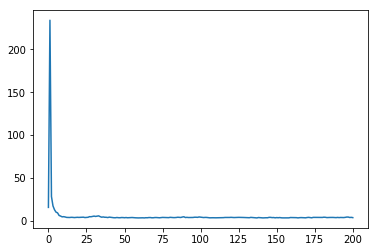

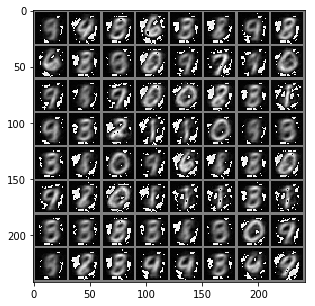

  4%|▍         | 401/10000 [11:21<4:31:43,  1.70s/it]

Variable containing:
 7.6483e-06  1.4419e-11  5.2953e-09  ...   9.6348e-09  2.3424e-13  1.2729e-07
 1.4570e-04  7.7686e-08  3.0488e-04  ...   3.1495e-09  2.6089e-11  9.3394e-11
 2.6842e-17  6.1039e-15  1.0990e-15  ...   1.3570e-18  3.8622e-16  4.4974e-08
                ...                   ⋱                   ...                
 2.5553e-08  1.0359e-03  2.2081e-06  ...   1.8636e-04  1.9740e-03  2.4481e-05
 2.3169e-08  9.7184e-04  5.6411e-06  ...   1.4466e-04  8.1093e-04  5.4697e-06
 9.3568e-05  2.1537e-07  7.9548e-07  ...   3.4163e-06  3.1635e-10  1.9276e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 2.5719e-03  5.1445e-07  1.3074e-22  ...   1.1462e-09  1.5014e-09  4.3209e-04
 5.1781e-07  1.7426e-03  1.4063e-22  ...   1.7652e-09  2.3409e-09  9.3690e-06
 6.9491e-22  7.4264e-22  9.9912e-03  ...   3.4579e-20  1.1729e-20  2.2139e-20
                ...                   ⋱                   ...                
 1.2439e-09  1.9032e-09  7.0598e-21  ...   2.1501e-03  1.8065e-

  4%|▍         | 402/10000 [11:22<4:31:44,  1.70s/it]

Variable containing:
 2.8898e-06  1.5039e-06  5.1261e-08  ...   3.9245e-07  7.2782e-04  1.0891e-04
 1.0404e-07  8.6302e-07  1.3694e-08  ...   5.7034e-09  1.2202e-04  9.6841e-05
 4.8062e-03  3.5689e-10  3.2937e-06  ...   1.2234e-09  1.9069e-10  1.8002e-11
                ...                   ⋱                   ...                
 6.9783e-12  4.4199e-10  4.8651e-08  ...   7.7999e-12  5.8488e-10  4.4578e-05
 3.4175e-14  2.3940e-05  4.9849e-15  ...   6.2623e-17  1.8267e-13  1.1750e-18
 2.2964e-09  3.4360e-05  3.6677e-09  ...   6.7580e-12  1.8541e-09  2.9420e-12
[torch.FloatTensor of size 100x100]

Variable containing:
 8.5884e-04  5.0907e-04  1.1764e-08  ...   1.5232e-07  2.7684e-09  3.2029e-06
 5.3273e-04  1.4021e-03  5.0445e-09  ...   2.1809e-06  2.9791e-09  1.1136e-05
 3.5178e-08  1.4414e-08  5.4898e-03  ...   4.1447e-09  1.1214e-11  1.7101e-07
                ...                   ⋱                   ...                
 2.2740e-07  3.1114e-06  2.0693e-09  ...   2.4911e-03  5.3892e-

  4%|▍         | 403/10000 [11:25<4:31:54,  1.70s/it]

Variable containing:
 9.8670e-06  2.1669e-06  1.8896e-06  ...   4.7987e-06  2.1188e-06  9.5038e-05
 3.8361e-05  1.0924e-06  3.7059e-06  ...   4.4726e-08  3.4237e-11  7.4893e-09
 7.0860e-04  1.3346e-06  6.8251e-07  ...   3.8417e-09  9.7571e-11  3.9158e-09
                ...                   ⋱                   ...                
 2.8260e-10  9.1167e-08  2.9765e-07  ...   2.2687e-04  2.0972e-09  5.0779e-04
 7.4144e-10  9.6259e-10  1.4021e-08  ...   6.8037e-05  9.9792e-10  8.4045e-05
 4.8532e-05  3.8331e-06  2.2559e-06  ...   1.3100e-06  1.0970e-06  3.3541e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 1.0958e-03  9.5290e-07  1.6784e-06  ...   8.8136e-06  8.8230e-06  1.0844e-03
 9.8474e-07  2.4523e-03  9.5161e-04  ...   2.8818e-08  4.9170e-08  3.0175e-06
 1.6898e-06  9.2712e-04  1.1471e-03  ...   6.0941e-09  1.0262e-08  6.5042e-06
                ...                   ⋱                   ...                
 9.9220e-06  3.1394e-08  6.8140e-09  ...   1.7879e-03  1.4926e-

  4%|▍         | 404/10000 [11:26<4:31:54,  1.70s/it]

Variable containing:
 5.0071e-08  2.6280e-08  4.5442e-10  ...   2.8497e-05  3.8793e-13  3.6237e-10
 6.9389e-09  4.2700e-07  3.5949e-08  ...   3.8543e-04  6.8588e-09  3.2674e-04
 1.8297e-13  1.0491e-09  1.0544e-07  ...   1.0221e-08  1.3401e-03  3.8562e-05
                ...                   ⋱                   ...                
 2.1274e-12  2.5806e-04  2.7371e-10  ...   4.4031e-06  2.8626e-12  9.3153e-06
 1.5114e-11  3.8020e-10  3.1025e-07  ...   1.0610e-06  1.3106e-07  4.6470e-04
 3.7966e-05  2.0749e-09  1.2214e-09  ...   6.0700e-05  6.1320e-12  1.1578e-08
[torch.FloatTensor of size 100x100]

Variable containing:
 6.8999e-03  8.6636e-08  7.9199e-12  ...   1.0602e-07  8.5920e-10  4.1694e-04
 5.9253e-08  9.1372e-04  1.0204e-09  ...   5.7846e-06  1.1310e-06  7.7881e-07
 7.5178e-12  1.4163e-09  4.6162e-03  ...   3.8759e-12  5.4506e-05  1.0921e-10
                ...                   ⋱                   ...                
 9.0499e-08  7.2193e-06  3.4853e-12  ...   3.0048e-03  9.0043e-

  4%|▍         | 405/10000 [11:28<4:31:59,  1.70s/it]

Variable containing:
 4.9607e-07  1.1161e-04  3.0981e-11  ...   1.0249e-10  8.3216e-07  3.5988e-09
 2.3999e-08  1.0399e-12  9.5663e-08  ...   2.6917e-05  2.7988e-06  8.5729e-09
 9.8880e-05  2.7807e-08  1.9442e-11  ...   1.2414e-10  8.8839e-08  1.5585e-09
                ...                   ⋱                   ...                
 5.3001e-11  2.6954e-15  1.0099e-03  ...   1.1782e-09  4.7443e-12  4.5234e-07
 2.1167e-07  3.1637e-10  1.0645e-12  ...   4.5531e-11  1.0326e-09  5.4039e-11
 9.7083e-09  2.6280e-09  1.0801e-10  ...   1.0029e-06  2.0322e-05  1.0808e-09
[torch.FloatTensor of size 100x100]

Variable containing:
 2.8259e-03  1.4890e-09  4.8723e-05  ...   8.3630e-13  3.1719e-08  7.0506e-09
 1.7039e-09  4.8285e-03  5.6417e-09  ...   1.0576e-06  1.3146e-10  1.4460e-09
 6.1447e-05  6.2174e-09  4.7215e-03  ...   1.6352e-13  4.1647e-05  5.6665e-09
                ...                   ⋱                   ...                
 1.0080e-12  1.1139e-06  1.5628e-13  ...   5.7542e-03  4.3280e-

  4%|▍         | 406/10000 [11:30<4:32:04,  1.70s/it]

Variable containing:
 4.6758e-08  2.5685e-05  6.4739e-04  ...   3.2882e-04  6.6427e-08  1.9239e-06
 3.9637e-11  6.2980e-04  4.2782e-08  ...   3.7361e-05  3.3268e-10  3.8038e-07
 1.1287e-08  6.2288e-06  1.7041e-05  ...   1.0255e-04  4.6365e-08  1.0534e-05
                ...                   ⋱                   ...                
 2.9066e-05  2.8704e-11  4.2548e-11  ...   1.4653e-07  1.4620e-09  2.1990e-06
 1.9060e-09  5.4382e-10  5.0704e-10  ...   2.9256e-07  5.4528e-08  2.2237e-05
 2.0389e-05  2.7034e-10  2.5803e-10  ...   1.5712e-07  4.2304e-08  7.2273e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 9.4406e-04  2.0422e-05  4.1153e-04  ...   2.5669e-10  1.1961e-07  1.9394e-09
 2.5986e-05  3.4047e-03  1.1686e-04  ...   7.3139e-12  2.7319e-05  7.1641e-11
 4.1998e-04  9.3722e-05  1.3237e-03  ...   2.8470e-10  6.0225e-06  3.1665e-09
                ...                   ⋱                   ...                
 3.2264e-10  7.2246e-12  3.5064e-10  ...   2.9825e-03  2.6200e-

  4%|▍         | 407/10000 [11:32<4:32:10,  1.70s/it]

Variable containing:
 5.3569e-11  2.6034e-06  8.2228e-05  ...   1.6385e-07  1.9690e-07  4.8349e-06
 4.8224e-08  2.4764e-05  1.2253e-09  ...   2.0397e-10  9.1280e-12  1.5805e-09
 2.0945e-14  7.2909e-08  2.5151e-09  ...   2.8028e-08  3.0119e-11  2.6111e-07
                ...                   ⋱                   ...                
 1.1043e-09  2.2363e-06  3.6915e-08  ...   1.0501e-06  2.2037e-08  2.7789e-09
 1.9498e-06  1.0306e-04  2.5537e-08  ...   1.3740e-09  6.8728e-10  3.0015e-07
 8.4516e-07  7.4309e-07  6.4190e-07  ...   5.0505e-05  9.1252e-06  4.3475e-05
[torch.FloatTensor of size 100x100]

Variable containing:
 2.4459e-03  1.2540e-06  1.2276e-04  ...   1.0920e-07  1.3316e-06  4.9105e-09
 2.4722e-06  6.3872e-03  2.7366e-07  ...   1.7212e-07  4.2299e-04  1.7377e-11
 1.2978e-04  1.4675e-07  3.1799e-03  ...   6.7999e-09  4.3861e-08  6.1548e-11
                ...                   ⋱                   ...                
 1.0431e-07  8.3403e-08  6.1444e-09  ...   2.2638e-03  2.3081e-

  4%|▍         | 408/10000 [11:34<4:32:12,  1.70s/it]

Variable containing:
 7.5495e-11  2.2678e-07  1.3561e-13  ...   4.4603e-16  5.7136e-09  1.9350e-05
 1.3343e-11  3.6006e-07  1.4853e-05  ...   2.1968e-13  1.8578e-06  1.8543e-06
 7.2891e-11  1.4329e-04  3.1483e-07  ...   2.2302e-12  3.2792e-06  4.2054e-04
                ...                   ⋱                   ...                
 7.2433e-12  5.3536e-11  1.7768e-14  ...   6.4715e-18  9.1165e-04  7.7385e-08
 1.1290e-11  2.9053e-07  1.6441e-05  ...   2.5583e-13  9.8036e-07  1.3156e-06
 4.8694e-12  7.2978e-05  1.4616e-03  ...   1.1471e-08  2.0018e-08  2.3377e-07
[torch.FloatTensor of size 100x100]

Variable containing:
 2.3646e-03  2.3242e-08  1.2413e-06  ...   4.8182e-08  2.2276e-08  4.2852e-09
 2.2595e-08  1.7704e-03  5.2068e-05  ...   7.3404e-07  1.6849e-03  5.4103e-05
 1.1422e-06  4.9285e-05  1.0146e-03  ...   9.6782e-07  3.0876e-05  2.7568e-05
                ...                   ⋱                   ...                
 4.4001e-08  6.8954e-07  9.6049e-07  ...   1.6989e-03  3.9158e-

  4%|▍         | 409/10000 [11:36<4:32:14,  1.70s/it]

Variable containing:
 2.2826e-12  1.5563e-12  2.7396e-13  ...   1.3193e-05  5.6583e-06  2.9471e-04
 5.3544e-08  3.0779e-05  1.6494e-11  ...   2.6570e-04  3.5313e-06  2.4393e-04
 1.8162e-11  1.3172e-13  4.9022e-12  ...   2.4792e-07  1.1133e-09  2.6058e-05
                ...                   ⋱                   ...                
 1.5986e-06  1.7632e-03  2.9078e-09  ...   5.1912e-05  3.1877e-07  7.1845e-06
 6.7941e-12  1.1102e-11  7.0647e-13  ...   2.6917e-06  1.4220e-03  1.9381e-04
 3.3615e-07  1.6956e-06  3.9667e-08  ...   1.0074e-04  5.7607e-05  8.9394e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 1.7562e-03  3.7002e-07  4.5508e-04  ...   1.5287e-10  4.4261e-05  7.5757e-08
 3.2912e-07  1.5087e-03  2.0323e-07  ...   1.1467e-04  1.1321e-07  7.7052e-06
 4.6845e-04  2.3520e-07  4.6191e-03  ...   1.8916e-10  2.2556e-06  2.9339e-08
                ...                   ⋱                   ...                
 1.3557e-10  1.1432e-04  1.6296e-10  ...   1.5036e-03  3.1950e-

  4%|▍         | 410/10000 [11:38<4:32:22,  1.70s/it]

Variable containing:
 1.1941e-11  1.4019e-03  1.5875e-05  ...   8.0209e-05  5.1088e-05  2.1452e-13
 1.9533e-05  4.7347e-09  9.3673e-10  ...   1.5618e-08  1.4703e-10  4.6910e-11
 7.6719e-13  3.5117e-08  3.4450e-07  ...   4.6824e-07  2.1519e-11  8.1699e-14
                ...                   ⋱                   ...                
 1.1269e-09  6.9422e-07  1.5943e-04  ...   1.3110e-05  6.8273e-06  1.0827e-05
 8.1233e-13  2.3211e-04  1.6608e-03  ...   2.5997e-05  2.4497e-04  2.0231e-14
 5.9087e-13  6.1478e-13  3.2453e-11  ...   3.6145e-07  1.2788e-11  3.6827e-06
[torch.FloatTensor of size 100x100]

Variable containing:
 4.5021e-03  4.0652e-09  2.9118e-09  ...   3.5967e-08  5.6358e-06  5.9849e-11
 2.6786e-09  1.8313e-03  3.4751e-12  ...   4.1555e-09  9.5922e-13  8.3681e-14
 4.0463e-09  7.3289e-12  4.7791e-03  ...   1.7859e-09  5.7597e-07  1.5865e-13
                ...                   ⋱                   ...                
 2.0877e-08  3.6607e-09  7.4597e-10  ...   1.1366e-03  1.3876e-

  4%|▍         | 411/10000 [11:40<4:32:18,  1.70s/it]

Variable containing:
 1.1526e-08  7.5870e-07  5.8672e-12  ...   2.9988e-08  3.8669e-03  4.1111e-15
 1.5127e-08  1.0727e-06  3.2227e-12  ...   2.3543e-08  8.6396e-04  2.2706e-14
 3.4314e-06  1.4842e-05  1.6411e-05  ...   3.8292e-05  1.8853e-05  4.8679e-14
                ...                   ⋱                   ...                
 4.2727e-06  2.6710e-04  1.0262e-08  ...   5.3556e-04  1.3250e-07  1.4517e-11
 7.4945e-05  4.2789e-09  7.3516e-09  ...   1.9633e-05  1.9862e-08  8.4323e-17
 2.7605e-06  3.5561e-05  5.2297e-06  ...   5.3029e-05  1.9186e-05  1.4276e-13
[torch.FloatTensor of size 100x100]

Variable containing:
 3.1344e-03  2.5878e-03  2.0384e-06  ...   4.0547e-08  9.2589e-09  3.2134e-06
 2.4805e-03  3.2381e-03  1.3198e-06  ...   3.0402e-08  3.7974e-09  2.4713e-06
 1.1544e-06  7.7976e-07  7.7789e-04  ...   2.1271e-05  3.7249e-06  7.1511e-04
                ...                   ⋱                   ...                
 2.3910e-08  1.8704e-08  2.2150e-05  ...   1.1187e-03  2.6189e-

KeyboardInterrupt: 

In [32]:
from tqdm import tqdm
G = Generator()
G.apply(weights_init)
D = Discriminator()
print(G)
if use_cuda:
    G.cuda()
    D.cuda()
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
errs=[]
for epoch in tqdm(range(10000)):
    optimizers['G'].zero_grad()
    data=next(iter(G_loader))[0]
    if use_cuda:
        data=data.cuda()
    input_holder.resize_as_(data).copy_(data)
    y = D(Variable(data))
    noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
    noisev = Variable(noise_holder)
    fake_data = G(noisev)
    x = D(fake_data)
    W_xy=sinkhorn_loss(x,y,epsilon,batch_size,niter)
    W_xx=sinkhorn_loss(x,x,epsilon,batch_size,niter)
    W_yy=sinkhorn_loss(y,y,epsilon,batch_size,niter)
    Loss_G=2*W_xy-W_xx-W_yy
    Loss_G.backward(one)
    if use_cuda:
        errs.append(Loss_G.cpu().data[0])
    else:
        errs.append(Loss_G.data[0])
    optimizers['G'].step()

    if epoch % 100 == 0:
        if use_cuda:
            dd = utils.make_grid(fake_data.cpu().data[:64])
        else:
            dd = utils.make_grid(fake_data.data[:64])
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/Vuil_Sinkhorn_MLP_%d.png'%(epoch))
        imshow(dd,'./results/Sinkhorn_MLP_%d.png'%(epoch))
        plt.plot(errs)
        plt.savefig('./results/Sinkhorn_loss.png')